# Tennessee Eastman Process (TEP) Analysis Notebook

## Process Control Definition

**Process Control** is a discipline within engineering that focuses on maintaining and regulating industrial processes to ensure they operate within desired parameters. It involves the use of control systems, sensors, actuators, and algorithms to monitor process variables (such as temperature, pressure, flow rate, chemical composition) and automatically adjust process inputs to maintain optimal operating conditions.

Key aspects of process control include:
- **Monitoring**: Continuous measurement of process variables using sensors and instrumentation
- **Control**: Automatic adjustment of process inputs (manipulated variables) to maintain desired outputs
- **Optimization**: Ensuring processes operate efficiently, safely, and within quality specifications
- **Safety**: Preventing hazardous conditions and maintaining safe operating limits
- **Quality**: Maintaining consistent product quality by controlling process parameters

Process control systems are essential in industries such as chemical processing, oil refining, power generation, manufacturing, and many others where consistent, safe, and efficient operation is critical.

---

## Notebook Overview

### Purpose
End-to-end exploration and benchmarking on Tennessee Eastman Process (TEP) data including:
- **Exploratory Data Analysis (EDA)** → Data understanding and visualization
- **Supervised Classification** → Multi-class fault classification
- **Anomaly Detection** → Binary fault detection
- **Performance Evaluation** → Comprehensive metrics, plots, and export

### How to Use This Notebook
1. **Setup**: Run initialization cells (Python version check, imports, data loading)
2. **Configuration**: Execute "Global Configuration" and "Data Preparation" sections
3. **Analysis**: Run desired analysis sections (EDA, Classification, or Anomaly Detection)
4. **Results**: Review generated plots and exported results in `output/<VERSION>/`

### Key Features
- **Reproducible**: All random seeds are fixed for consistent results
- **Modular**: Each section can be run independently after setup
- **Configurable**: All parameters centralized in configuration section
- **Exportable**: Automatic saving of plots, tables, and results
- **Scalable**: Supports reduced datasets for fast iteration and full datasets for production

### Data Structure
- **Training Data**: Fault-free and faulty training samples
- **Testing Data**: Fault-free and faulty testing samples
- **Features**: 52 process variables (XMEAS_1 to XMEAS_22, XMV_1 to XMV_11, etc.)
- **Target**: Fault numbers (0=normal, 1-21=different fault types)

# 1. Environment Setup and Data Loading

This section handles:
- Python environment validation
- Library imports and configuration
- Data loading from R data files
- Reproducibility settings

In [50]:
# Install required packages (uncomment if needed)
# !pip install -r requirements.txt

In [51]:
"""
Reproducibility and Display Configuration
=========================================
Sets up consistent random seeds and display settings for reproducible results.
"""
import os
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility settings
GLOBAL_SEED: int = 42
os.environ["PYTHONHASHSEED"] = str(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# Matplotlib/Seaborn visualization defaults
mpl.rcParams["figure.figsize"] = (12, 8)
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Pandas display options
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")
pd.set_option("display.max_rows", 50)

print("✓ Reproducibility and display settings configured")

✓ Reproducibility and display settings configured


In [52]:
"""
Python Environment Validation
==============================
Ensures the correct Python version is being used.
"""
import sys
from typing import Tuple


def validate_python_version(required_major: int = 3, required_minor: int = 11) -> None:
    """
    Validate that the current Python version meets requirements.
    
    Args:
        required_major: Required major version (default: 3)
        required_minor: Required minor version (default: 11)
    
    Raises:
        RuntimeError: If Python version doesn't match requirements
    """
    current_version: Tuple[int, int, int] = sys.version_info[:3]
    
    if (current_version[0] != required_major or 
        current_version[1] < required_minor):
        raise RuntimeError(
            f"Python {required_major}.{required_minor}+ is required, "
            f"but you are using {current_version[0]}.{current_version[1]}.{current_version[2]}"
        )
    
    print(f"✓ Python version validated: {current_version[0]}.{current_version[1]}.{current_version[2]}")


# Validate Python environment
validate_python_version()

✓ Python version validated: 3.11.5


In [53]:
"""
Additional Library Imports
===========================
Specialized libraries for data processing, visualization, and machine learning.
"""
# Data loading and processing
import pyreadr
from tabulate import tabulate

# Visualization
import plotly.express as px
import plotly.graph_objects as go

# Machine learning and preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Statistical analysis
from scipy import stats
from scipy.stats import skew, kurtosis

print("✓ Additional libraries imported successfully")

✓ Additional libraries imported successfully


In [54]:
"""
Data Loading from R Files
==========================
Loads Tennessee Eastman Process datasets from R data files.
"""
from pathlib import Path
from typing import Dict, Any

def load_tep_data() -> Dict[str, pd.DataFrame]:
    """
    Load Tennessee Eastman Process datasets from R data files.
    
    Returns:
        Dictionary containing all loaded datasets
        
    Raises:
        FileNotFoundError: If data files are not found
        Exception: If data loading fails
    """
    data_dir = Path("data")
    
    # Define data file paths
    data_files = {
        "fault_free_training": data_dir / "TEP_FaultFree_Training.RData",
        "fault_free_testing": data_dir / "TEP_FaultFree_Testing.RData", 
        "faulty_training": data_dir / "TEP_Faulty_Training.RData",
        "faulty_testing": data_dir / "TEP_Faulty_Testing.RData"
    }
    
    # Check if all files exist
    for name, file_path in data_files.items():
        if not file_path.exists():
            raise FileNotFoundError(f"Data file not found: {file_path}")
    
    # Load data
    datasets = {}
    try:
        print("Loading TEP datasets...")
        
        fault_free_training_dict = pyreadr.read_r(str(data_files["fault_free_training"]))
        fault_free_testing_dict = pyreadr.read_r(str(data_files["fault_free_testing"]))
        faulty_training_dict = pyreadr.read_r(str(data_files["faulty_training"]))
        faulty_testing_dict = pyreadr.read_r(str(data_files["faulty_testing"]))
        
        # Extract DataFrames
        datasets["fault_free_training"] = fault_free_training_dict["fault_free_training"]
        datasets["fault_free_testing"] = fault_free_testing_dict["fault_free_testing"]
        datasets["faulty_training"] = faulty_training_dict["faulty_training"]
        datasets["faulty_testing"] = faulty_testing_dict["faulty_testing"]
        
        # Print dataset info
        for name, df in datasets.items():
            print(f"✓ {name}: {df.shape[0]:,} samples, {df.shape[1]} features")
            
        return datasets
        
    except Exception as e:
        raise Exception(f"Failed to load TEP data: {str(e)}")

# Load all datasets
tep_datasets = load_tep_data()

# Assign to original variable names for backward compatibility
DF_FF_TRAINING_RAW = tep_datasets["fault_free_training"]
DF_FF_TEST_RAW = tep_datasets["fault_free_testing"]
DF_F_TRAINING_RAW = tep_datasets["faulty_training"]
DF_F_TEST_RAW = tep_datasets["faulty_testing"]

Loading TEP datasets...
✓ fault_free_training: 250,000 samples, 55 features
✓ fault_free_testing: 480,000 samples, 55 features
✓ faulty_training: 5,000,000 samples, 55 features
✓ faulty_testing: 9,600,000 samples, 55 features


# 2. Global Configuration

This section centralizes all configuration parameters used throughout the notebook.

In [55]:
"""
Global Configuration Parameters
================================
All configurable parameters for the TEP analysis pipeline.
"""
import os

# Version and output settings
VERSION = "1.00"
OUTPUT_PATH = "output"

# Data column names
TARGET_VARIABLE_COLUMN_NAME = "faultNumber"
SIMULATION_RUN_COLUMN_NAME = "simulationRun"
COLUMNS_TO_REMOVE = ["simulationRun", "sample"]

# Fault handling configuration
SKIPPED_FAULTS = []
FAULTS_TO_BE_MERGED_TOGETHER = [3, 8, 9, 15, 18]
MERGE_FAULTS_TO_NUMBER = 3
FAULT_INJECTION_STARTING_POINT = 25

# Data reduction settings (for development/testing)
USE_REDUCED_DATA = True

# Simulation run ranges for reduced data
TRAINING_SIM_RUNS = (0, 2)      # Fault-free training: runs 0-1
TESTING_SIM_RUNS = (2, 4)       # Fault-free testing: runs 2-3
FAULTY_TRAINING_SIM_RUNS = (4, 6)   # Faulty training: runs 4-5
FAULTY_TESTING_SIM_RUNS = (5, 7)    # Faulty testing: runs 5-6

# Model names for consistency in plots and tables
XGBOOST = "XGBoost"
RANDOM_FOREST = "Random Forest"
NEURAL_NET = "Neural Network"

# Create output directory structure
os.makedirs(os.path.join(OUTPUT_PATH, VERSION), exist_ok=True)

print(f"✓ Configuration loaded (Version: {VERSION})")
print(f"✓ Output directory: {os.path.join(OUTPUT_PATH, VERSION)}")
print(f"✓ Using {'reduced' if USE_REDUCED_DATA else 'full'} dataset")
print(f"✓ Fault injection point: sample {FAULT_INJECTION_STARTING_POINT}")
print(f"✓ Skipped faults: {SKIPPED_FAULTS}")
print(f"✓ Merged faults: {FAULTS_TO_BE_MERGED_TOGETHER} → {MERGE_FAULTS_TO_NUMBER}")

✓ Configuration loaded (Version: 1.00)
✓ Output directory: output/1.00
✓ Using reduced dataset
✓ Fault injection point: sample 25
✓ Skipped faults: []
✓ Merged faults: [3, 8, 9, 15, 18] → 3


# 3. Utility Functions

This section contains all reusable utility functions organized by category:
- Data validation and quality checks
- Export and I/O functions  
- Analysis and metrics functions
- Visualization functions

## 3.1 Analysis and Metrics Functions

In [56]:
"""
First Detection Delay Analysis
===============================
Functions for computing first detection delay metrics.
"""
import numpy as np
import pandas as pd
from typing import Union, List, Optional


def compute_first_detection_delay(
    y_true: Union[List[int], np.ndarray],
    y_pred: Union[List[int], np.ndarray]
) -> pd.DataFrame:
    """
    Compute the first detection delay for each fault type.
    
    The first detection delay is the time between when a fault actually occurs
    and when it is first correctly detected by the prediction system.
    
    Args:
        y_true: True fault labels (ground truth)
        y_pred: Predicted fault labels
        
    Returns:
        DataFrame with columns ['Fault', 'First Detection Delay']
        
    Example:
        >>> y_true = [0, 0, 1, 1, 1, 2, 2, 2]
        >>> y_pred = [0, 0, 0, 1, 1, 0, 2, 2] 
        >>> compute_first_detection_delay(y_true, y_pred)
           Fault  First Detection Delay
        0      1                      1
        1      2                      1
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    
    # Get unique fault labels (excluding normal state 0)
    fault_labels = sorted(np.unique(y_true[y_true > 0]))
    results = []
    
    for fault in fault_labels:
        fault_mask = y_true == fault
        fault_indices = np.where(fault_mask)[0]
        
        if len(fault_indices) == 0:
            delay = None
            print(f"Warning: No samples found for fault {fault}")
        else:
            start_index = fault_indices[0]  # First occurrence of fault
            
            # Find first correct detection after fault starts
            detection_indices = np.where(
                (y_pred == fault) & (np.arange(len(y_pred)) >= start_index)
            )[0]
            
            if len(detection_indices) > 0:
                delay = detection_indices[0] - start_index
            else:
                delay = None  # Fault never detected
        
        results.append({
            "Fault": fault,
            "First Detection Delay": delay if delay is not None and delay >= 0 else np.nan
        })
    
    return pd.DataFrame(results)


# Test the function with sample data
if __name__ == "__main__":
    # Example usage
    sample_true = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3]
    sample_pred = [0, 0, 0, 1, 1, 0, 2, 2, 0, 3]
    
    result = compute_first_detection_delay(sample_true, sample_pred)
    print("Sample first detection delay analysis:")
    print(result)

Sample first detection delay analysis:
   Fault  First Detection Delay
0      1                      1
1      2                      1
2      3                      1


## 3.2 Export and I/O Functions

In [57]:
"""
Export and I/O Utility Functions
================================
Functions for saving plots, DataFrames, and other analysis outputs.
"""
import os
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Optional


def save_plot(
    plot_name: str, 
    suffix: str = "", 
    plot_path: str = "plots",
    format: str = "png",
    dpi: int = 300,
    bbox_inches: str = "tight"
) -> str:
    """
    Save current matplotlib figure with a structured filename and path.
    
    Args:
        plot_name: Base name for the plot file
        suffix: Optional suffix (e.g., class ID, model name)
        plot_path: Subdirectory within output path for organizing plots
        format: File format (png, pdf, svg, etc.)
        dpi: Resolution for raster formats
        bbox_inches: Bounding box configuration
        
    Returns:
        Full path to saved file
        
    Example:
        >>> plt.plot([1, 2, 3], [1, 4, 2])
        >>> save_plot("model_performance", suffix="xgboost", plot_path="classification")
        'output/1.00/classification/model_performance_xgboost_v1.00.png'
    """
    try:
        # Use global configuration if available, otherwise use defaults
        version = globals().get('VERSION', 'default')
        output_path = globals().get('OUTPUT_PATH', 'output')
        
        # Create directory structure
        base_dir = Path(output_path) / version / plot_path
        base_dir.mkdir(parents=True, exist_ok=True)
        
        # Generate filename
        timestamp = ""  # Could add timestamp if needed: datetime.now().strftime("%H%M%S")
        if suffix:
            filename = f"{plot_name}_{suffix}_v{version}{timestamp}.{format}"
        else:
            filename = f"{plot_name}_v{version}{timestamp}.{format}"
        
        filepath = base_dir / filename
        
        # Save the plot
        plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches, format=format)
        
        print(f"✓ Plot saved: {filepath}")
        return str(filepath)
        
    except Exception as e:
        print(f"✗ Error saving plot '{plot_name}': {str(e)}")
        raise


def save_dataframe(
    df: pd.DataFrame, 
    name: str, 
    suffix: str = "",
    file_format: str = "csv",
    index: bool = True
) -> str:
    """
    Save a DataFrame with versioned and structured filename.
    
    Args:
        df: DataFrame to save
        name: Base name for the file
        suffix: Optional suffix (e.g., class ID, 'summary')
        file_format: File format ('csv', 'xlsx', 'parquet')
        index: Whether to include index in saved file
        
    Returns:
        Full path to saved file
        
    Example:
        >>> df = pd.DataFrame({'a': [1, 2], 'b': [3, 4]})
        >>> save_dataframe(df, "metrics", suffix="classification")
        'output/1.00/data/metrics_classification_v1.00.csv'
    """
    try:
        # Use global configuration if available
        version = globals().get('VERSION', 'default')
        output_path = globals().get('OUTPUT_PATH', 'output')
        
        # Create directory structure
        base_dir = Path(output_path) / version / "data"
        base_dir.mkdir(parents=True, exist_ok=True)
        
        # Generate filename
        timestamp = ""  # Could add timestamp if needed
        if suffix:
            filename = f"{name}_{suffix}_v{version}{timestamp}.{file_format}"
        else:
            filename = f"{name}_v{version}{timestamp}.{file_format}"
        
        filepath = base_dir / filename
        
        # Save based on format
        if file_format.lower() == "csv":
            df.to_csv(filepath, index=index)
        elif file_format.lower() == "xlsx":
            df.to_excel(filepath, index=index)
        elif file_format.lower() == "parquet":
            df.to_parquet(filepath, index=index)
        else:
            raise ValueError(f"Unsupported file format: {file_format}")
        
        print(f"✓ DataFrame saved: {filepath}")
        return str(filepath)
        
    except Exception as e:
        print(f"✗ Error saving DataFrame '{name}': {str(e)}")
        raise

## 3.3 Data Validation Functions

In [58]:
"""
Data Validation Utility Functions
==================================
Functions for validating data quality and balance.
"""


def validate_data_balance(
    df1: pd.DataFrame, 
    df2: pd.DataFrame, 
    threshold: int = 100,
    df1_name: str = "Dataset 1",
    df2_name: str = "Dataset 2"
) -> None:
    """
    Validate that two datasets are balanced within a specified threshold.
    
    Args:
        df1: First DataFrame to compare
        df2: Second DataFrame to compare
        threshold: Maximum allowed difference in number of rows
        df1_name: Name for first dataset (for error messages)
        df2_name: Name for second dataset (for error messages)
        
    Raises:
        ValueError: If datasets are imbalanced beyond threshold
        
    Example:
        >>> df_normal = pd.DataFrame({'a': range(100)})
        >>> df_fault = pd.DataFrame({'a': range(95)})
        >>> validate_data_balance(df_normal, df_fault, threshold=10)
        ✓ Data balance validated: difference = 5 rows (within threshold of 10)
    """
    size_diff = abs(df1.shape[0] - df2.shape[0])
    
    print(f"Data balance check: {df1_name}={df1.shape[0]:,}, {df2_name}={df2.shape[0]:,}")
    print(f"Difference: {size_diff:,} rows")
    
    if size_diff > threshold:
        raise ValueError(
            f"Data imbalance exceeds threshold:\n"
            f"  {df1_name}: {df1.shape[0]:,} rows\n"
            f"  {df2_name}: {df2.shape[0]:,} rows\n"
            f"  Difference: {size_diff:,} rows (threshold: {threshold:,})"
        )
    
    print(f"✓ Data balance validated: difference = {size_diff:,} rows (within threshold of {threshold:,})")


def validate_dataset_integrity(df: pd.DataFrame, dataset_name: str = "Dataset") -> Dict[str, Any]:
    """
    Perform comprehensive validation of dataset integrity.
    
    Args:
        df: DataFrame to validate
        dataset_name: Name of dataset for reporting
        
    Returns:
        Dictionary with validation results
    """
    results = {
        "dataset_name": dataset_name,
        "shape": df.shape,
        "missing_values": df.isnull().sum().sum(),
        "duplicate_rows": df.duplicated().sum(),
        "memory_usage_mb": df.memory_usage(deep=True).sum() / 1024**2
    }
    
    # Check for infinite values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_values = 0
    if len(numeric_cols) > 0:
        inf_values = np.isinf(df[numeric_cols]).sum().sum()
    results["infinite_values"] = inf_values
    
    # Data type summary
    results["dtypes"] = df.dtypes.value_counts().to_dict()
    
    print(f"\n{dataset_name} Integrity Report:")
    print(f"  Shape: {results['shape']}")
    print(f"  Missing values: {results['missing_values']:,}")
    print(f"  Duplicate rows: {results['duplicate_rows']:,}")
    print(f"  Infinite values: {results['infinite_values']:,}")
    print(f"  Memory usage: {results['memory_usage_mb']:.2f} MB")
    print(f"  Data types: {results['dtypes']}")
    
    return results

# 4. Data Preparation and Processing

This section handles:
- Data filtering and fault selection
- Data reduction for development/testing
- Data balancing validation
- Feature engineering and scaling
- Target variable encoding for different analysis types

In [59]:
"""
Data Filtering and Preparation
===============================
Filter and prepare datasets for analysis using global configuration.
"""

def prepare_tep_datasets(
    df_ff_train_raw: pd.DataFrame,
    df_ff_test_raw: pd.DataFrame, 
    df_f_train_raw: pd.DataFrame,
    df_f_test_raw: pd.DataFrame,
    use_reduced_data: bool = True
) -> Dict[str, pd.DataFrame]:
    """
    Prepare TEP datasets with filtering and reduction options.
    
    Args:
        df_ff_train_raw: Raw fault-free training data
        df_ff_test_raw: Raw fault-free testing data
        df_f_train_raw: Raw faulty training data
        df_f_test_raw: Raw faulty testing data
        use_reduced_data: Whether to use reduced datasets for fast iteration
        
    Returns:
        Dictionary containing prepared datasets
    """
    
    print("Preparing TEP datasets...")
    
    # Filter out skipped faults
    df_f_train_filtered = df_f_train_raw[
        ~df_f_train_raw[TARGET_VARIABLE_COLUMN_NAME].isin(SKIPPED_FAULTS)
    ].reset_index(drop=True)
    
    df_f_test_filtered = df_f_test_raw[
        ~df_f_test_raw[TARGET_VARIABLE_COLUMN_NAME].isin(SKIPPED_FAULTS)
    ].reset_index(drop=True)
    
    print(f"✓ Filtered out faults: {SKIPPED_FAULTS}")
    
    if use_reduced_data:
        print("Using reduced datasets for fast iteration...")
        
        # Reduce training data (fault-free)
        df_ff_train_reduced = df_ff_train_raw[
            (df_ff_train_raw[SIMULATION_RUN_COLUMN_NAME] >= TRAINING_SIM_RUNS[0]) & 
            (df_ff_train_raw[SIMULATION_RUN_COLUMN_NAME] < TRAINING_SIM_RUNS[1])
        ].drop(columns=COLUMNS_TO_REMOVE, axis=1)
        
        # Reduce training data (faulty)
        df_f_train_reduced = df_f_train_filtered[
            (df_f_train_filtered[SIMULATION_RUN_COLUMN_NAME] >= FAULTY_TRAINING_SIM_RUNS[0]) & 
            (df_f_train_filtered[SIMULATION_RUN_COLUMN_NAME] < FAULTY_TRAINING_SIM_RUNS[1]) &
            (df_f_train_filtered["sample"] > FAULT_INJECTION_STARTING_POINT)
        ].drop(columns=COLUMNS_TO_REMOVE, axis=1)
        
        # Reduce test data (fault-free)
        df_ff_test_reduced = df_ff_test_raw[
            (df_ff_test_raw[SIMULATION_RUN_COLUMN_NAME] >= TESTING_SIM_RUNS[0]) & 
            (df_ff_test_raw[SIMULATION_RUN_COLUMN_NAME] < TESTING_SIM_RUNS[1])
        ].drop(columns=COLUMNS_TO_REMOVE, axis=1)
        
        # Reduce test data (faulty)  
        df_f_test_reduced = df_f_test_filtered[
            (df_f_test_filtered[SIMULATION_RUN_COLUMN_NAME] >= FAULTY_TESTING_SIM_RUNS[0]) & 
            (df_f_test_filtered[SIMULATION_RUN_COLUMN_NAME] < FAULTY_TESTING_SIM_RUNS[1]) &
            (df_f_test_filtered["sample"] > FAULT_INJECTION_STARTING_POINT)
        ].drop(columns=COLUMNS_TO_REMOVE, axis=1)
        
        datasets = {
            "fault_free_train": df_ff_train_reduced,
            "fault_free_test": df_ff_test_reduced,
            "faulty_train": df_f_train_reduced,
            "faulty_test": df_f_test_reduced
        }
        
    else:
        print("Using full datasets...")
        # Use full datasets
        datasets = {
            "fault_free_train": df_ff_train_raw.drop(columns=COLUMNS_TO_REMOVE, axis=1),
            "fault_free_test": df_ff_test_raw.drop(columns=COLUMNS_TO_REMOVE, axis=1),
            "faulty_train": df_f_train_filtered.drop(columns=COLUMNS_TO_REMOVE, axis=1),
            "faulty_test": df_f_test_filtered.drop(columns=COLUMNS_TO_REMOVE, axis=1)
        }
    
    # Print dataset information
    for name, df in datasets.items():
        print(f"✓ {name}: {df.shape}")
        if TARGET_VARIABLE_COLUMN_NAME in df.columns:
            fault_counts = df[TARGET_VARIABLE_COLUMN_NAME].value_counts().sort_index()
            print(f"   Fault distribution: {dict(fault_counts)}")
    
    return datasets

# Prepare datasets using global configuration
prepared_datasets = prepare_tep_datasets(
    DF_FF_TRAINING_RAW, DF_FF_TEST_RAW, 
    DF_F_TRAINING_RAW, DF_F_TEST_RAW,
    use_reduced_data=USE_REDUCED_DATA
)

# Assign to variables for backward compatibility
DF_FF_TRAINING_REDUCED = prepared_datasets["fault_free_train"] 
DF_FF_TEST_REDUCED = prepared_datasets["fault_free_test"]
DF_F_TRAINING_REDUCED = prepared_datasets["faulty_train"]
DF_F_TEST_REDUCED = prepared_datasets["faulty_test"]

Preparing TEP datasets...
✓ Filtered out faults: []
Using reduced datasets for fast iteration...
✓ fault_free_train: (500, 53)
   Fault distribution: {0.0: np.int64(500)}
✓ fault_free_test: (1920, 53)
   Fault distribution: {0: np.int64(1920)}
✓ faulty_train: (19000, 53)
   Fault distribution: {1: np.int64(950), 2: np.int64(950), 3: np.int64(950), 4: np.int64(950), 5: np.int64(950), 6: np.int64(950), 7: np.int64(950), 8: np.int64(950), 9: np.int64(950), 10: np.int64(950), 11: np.int64(950), 12: np.int64(950), 13: np.int64(950), 14: np.int64(950), 15: np.int64(950), 16: np.int64(950), 17: np.int64(950), 18: np.int64(950), 19: np.int64(950), 20: np.int64(950)}
✓ faulty_test: (37400, 53)
   Fault distribution: {1: np.int64(1870), 2: np.int64(1870), 3: np.int64(1870), 4: np.int64(1870), 5: np.int64(1870), 6: np.int64(1870), 7: np.int64(1870), 8: np.int64(1870), 9: np.int64(1870), 10: np.int64(1870), 11: np.int64(1870), 12: np.int64(1870), 13: np.int64(1870), 14: np.int64(1870), 15: np.int6

In [60]:
"""
Data Balance Validation
========================
Ensure datasets are properly balanced for reliable analysis.
"""

# Validate balance between fault-free and single-fault data
print("Validating data balance...")

# For training data
fault_1_train = DF_F_TRAINING_REDUCED.query(f"{TARGET_VARIABLE_COLUMN_NAME} == 1")
validate_data_balance(
    DF_FF_TRAINING_REDUCED, 
    fault_1_train,
    threshold=500,
    df1_name="Fault-free training",
    df2_name="Fault-1 training"
)

# For testing data  
fault_1_test = DF_F_TEST_REDUCED.query(f"{TARGET_VARIABLE_COLUMN_NAME} == 1")
validate_data_balance(
    DF_FF_TEST_REDUCED,
    fault_1_test, 
    threshold=100,
    df1_name="Fault-free testing",
    df2_name="Fault-1 testing"
)

print(f"\n✓ All data balance validations passed")

Validating data balance...
Data balance check: Fault-free training=500, Fault-1 training=950
Difference: 450 rows
✓ Data balance validated: difference = 450 rows (within threshold of 500)
Data balance check: Fault-free testing=1,920, Fault-1 testing=1,870
Difference: 50 rows
✓ Data balance validated: difference = 50 rows (within threshold of 100)

✓ All data balance validations passed


In [61]:
"""
Dataset Shape Summary
=====================
Quick verification of final dataset dimensions after preparation.
"""

print("Final Dataset Shapes:")
print(f"✓ Fault-free training: {DF_FF_TRAINING_REDUCED.shape}")
print(f"✓ Fault-1 training: {DF_F_TRAINING_REDUCED.query('faultNumber == 1').shape}")
print(f"✓ All faulty training: {DF_F_TRAINING_REDUCED.shape}")

# Verify data balance - the fault-free and fault-1 samples should be similar in size
ff_count = DF_FF_TRAINING_REDUCED.shape[0]
f1_count = DF_F_TRAINING_REDUCED.query("faultNumber == 1").shape[0]
balance_ratio = min(ff_count, f1_count) / max(ff_count, f1_count)

print(f"\nData Balance Check:")
print(f"  Fault-free vs Fault-1 ratio: {balance_ratio:.3f}")
print(f"  {'✓ Well balanced' if balance_ratio > 0.8 else '⚠ Potentially imbalanced'}")

Final Dataset Shapes:
✓ Fault-free training: (500, 53)
✓ Fault-1 training: (950, 53)
✓ All faulty training: (19000, 53)

Data Balance Check:
  Fault-free vs Fault-1 ratio: 0.526
  ⚠ Potentially imbalanced


In [62]:
"""
Supervised Learning Data Preparation
=====================================
Prepare features and targets for multi-class fault classification.
"""

def prepare_supervised_data(
    df_ff_train: pd.DataFrame,
    df_f_train: pd.DataFrame, 
    df_ff_test: pd.DataFrame,
    df_f_test: pd.DataFrame
) -> Dict[str, np.ndarray]:
    """
    Prepare data for supervised classification tasks.
    
    Args:
        df_ff_train: Fault-free training data
        df_f_train: Faulty training data
        df_ff_test: Fault-free testing data  
        df_f_test: Faulty testing data
        
    Returns:
        Dictionary containing prepared arrays for training and testing
    """
    print("Preparing supervised learning datasets...")
    
    # Combine training and testing data
    df_train_combined = pd.concat([df_ff_train, df_f_train], ignore_index=True)
    df_test_combined = pd.concat([df_ff_test, df_f_test], ignore_index=True)
    
    # Separate features and targets
    X_train_df = df_train_combined.drop(columns=[TARGET_VARIABLE_COLUMN_NAME])
    y_train_df = df_train_combined[TARGET_VARIABLE_COLUMN_NAME]
    
    X_test_df = df_test_combined.drop(columns=[TARGET_VARIABLE_COLUMN_NAME])  
    y_test_df = df_test_combined[TARGET_VARIABLE_COLUMN_NAME]
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled = scaler.transform(X_test_df)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train_df)
    y_test_encoded = label_encoder.transform(y_test_df)
    
    # One-hot encode targets for neural networks
    onehot_encoder = OneHotEncoder(sparse_output=False)
    y_train_onehot = onehot_encoder.fit_transform(y_train_df.values.reshape(-1, 1))
    y_test_onehot = onehot_encoder.transform(y_test_df.values.reshape(-1, 1))
    
    print(f"✓ Training samples: {X_train_scaled.shape[0]:,}")
    print(f"✓ Testing samples: {X_test_scaled.shape[0]:,}")
    print(f"✓ Features: {X_train_scaled.shape[1]}")
    print(f"✓ Classes: {len(np.unique(y_train_encoded))}")
    print(f"✓ Class distribution: {dict(zip(*np.unique(y_train_df, return_counts=True)))}")
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train_encoded,
        'y_test': y_test_encoded,
        'y_train_onehot': y_train_onehot,
        'y_test_onehot': y_test_onehot,
        'y_train_df': y_train_df,
        'y_test_df': y_test_df,
        'scaler': scaler,
        'label_encoder': label_encoder,
        'onehot_encoder': onehot_encoder,
        'df_train_combined': df_train_combined,
        'df_test_combined': df_test_combined
    }

# Prepare supervised learning data
supervised_data = prepare_supervised_data(
    DF_FF_TRAINING_REDUCED, DF_F_TRAINING_REDUCED,
    DF_FF_TEST_REDUCED, DF_F_TEST_REDUCED
)

# Assign to global variables for backward compatibility
X_TRAIN = supervised_data['X_train']
X_TEST_REDUCED = supervised_data['X_test'] 
Y_TRAIN = supervised_data['y_train']
Y_TEST_REDUCED = supervised_data['y_test']
Y_ENC_TRAIN = supervised_data['y_train_onehot']
Y_ENC_TEST_REDUCED = supervised_data['y_test_onehot']
Y_TRAIN_DF = supervised_data['y_train_df']
Y_TEST_REDUCED_DF = supervised_data['y_test_df']
DF_TRAINING_REDUCED_CONCATED = supervised_data['df_train_combined']
DF_TEST_REDUCED_CONCATED = supervised_data['df_test_combined']

# Store encoders for later use
sc = supervised_data['scaler']
le = supervised_data['label_encoder'] 
encoder_1 = supervised_data['onehot_encoder']

Preparing supervised learning datasets...
✓ Training samples: 19,500
✓ Testing samples: 39,320
✓ Features: 52
✓ Classes: 21
✓ Class distribution: {np.float64(0.0): np.int64(500), np.float64(1.0): np.int64(950), np.float64(2.0): np.int64(950), np.float64(3.0): np.int64(950), np.float64(4.0): np.int64(950), np.float64(5.0): np.int64(950), np.float64(6.0): np.int64(950), np.float64(7.0): np.int64(950), np.float64(8.0): np.int64(950), np.float64(9.0): np.int64(950), np.float64(10.0): np.int64(950), np.float64(11.0): np.int64(950), np.float64(12.0): np.int64(950), np.float64(13.0): np.int64(950), np.float64(14.0): np.int64(950), np.float64(15.0): np.int64(950), np.float64(16.0): np.int64(950), np.float64(17.0): np.int64(950), np.float64(18.0): np.int64(950), np.float64(19.0): np.int64(950), np.float64(20.0): np.int64(950)}


In [63]:
"""
Class Distribution Analysis
============================
Analyze the distribution of fault classes in the prepared datasets.
"""

def analyze_class_distribution(df: pd.DataFrame, dataset_name: str = "Dataset") -> pd.DataFrame:
    """
    Analyze and display class distribution in a dataset.
    
    Args:
        df: DataFrame containing target variable
        dataset_name: Name for reporting
        
    Returns:
        DataFrame with class distribution statistics
    """
    class_counts = df[TARGET_VARIABLE_COLUMN_NAME].value_counts().sort_index()
    class_percentages = (class_counts / class_counts.sum() * 100).round(2)
    
    distribution_df = pd.DataFrame({
        'Fault_Number': class_counts.index,
        'Count': class_counts.values,
        'Percentage': class_percentages.values
    })
    
    print(f"\n{dataset_name} Class Distribution:")
    print(f"  Total samples: {class_counts.sum():,}")
    print(f"  Number of classes: {len(class_counts)}")
    print(f"  Class balance (std of percentages): {class_percentages.std():.2f}%")
    
    # Display distribution table
    print(f"\nDetailed Distribution:")
    for _, row in distribution_df.iterrows():
        fault_name = "Normal" if row['Fault_Number'] == 0 else f"Fault {row['Fault_Number']}"
        print(f"  {fault_name:<12}: {row['Count']:>6,} ({row['Percentage']:>5.1f}%)")
    
    return distribution_df

# Analyze training data distribution
train_distribution = analyze_class_distribution(DF_TRAINING_REDUCED_CONCATED, "Training Data")

# Analyze testing data distribution  
test_distribution = analyze_class_distribution(DF_TEST_REDUCED_CONCATED, "Testing Data")


Training Data Class Distribution:
  Total samples: 19,500
  Number of classes: 21
  Class balance (std of percentages): 0.50%

Detailed Distribution:
  Normal      :  500.0 (  2.6%)
  Fault 1.0   :  950.0 (  4.9%)
  Fault 2.0   :  950.0 (  4.9%)
  Fault 3.0   :  950.0 (  4.9%)
  Fault 4.0   :  950.0 (  4.9%)
  Fault 5.0   :  950.0 (  4.9%)
  Fault 6.0   :  950.0 (  4.9%)
  Fault 7.0   :  950.0 (  4.9%)
  Fault 8.0   :  950.0 (  4.9%)
  Fault 9.0   :  950.0 (  4.9%)
  Fault 10.0  :  950.0 (  4.9%)
  Fault 11.0  :  950.0 (  4.9%)
  Fault 12.0  :  950.0 (  4.9%)
  Fault 13.0  :  950.0 (  4.9%)
  Fault 14.0  :  950.0 (  4.9%)
  Fault 15.0  :  950.0 (  4.9%)
  Fault 16.0  :  950.0 (  4.9%)
  Fault 17.0  :  950.0 (  4.9%)
  Fault 18.0  :  950.0 (  4.9%)
  Fault 19.0  :  950.0 (  4.9%)
  Fault 20.0  :  950.0 (  4.9%)

Testing Data Class Distribution:
  Total samples: 39,320
  Number of classes: 21
  Class balance (std of percentages): 0.03%

Detailed Distribution:
  Normal      : 1,920.0 (  

In [64]:
"""
Anomaly Detection Data Preparation
===================================
Prepare data for binary anomaly detection (normal vs faulty).
"""

def prepare_anomaly_detection_data(
    df_ff_train: pd.DataFrame,
    df_f_train: pd.DataFrame,
    df_ff_test: pd.DataFrame, 
    df_f_test: pd.DataFrame,
    df_train_combined: pd.DataFrame,
    df_test_combined: pd.DataFrame
) -> Dict[str, np.ndarray]:
    """
    Prepare data for anomaly detection tasks.
    
    Args:
        df_ff_train: Fault-free training data
        df_f_train: Faulty training data  
        df_ff_test: Fault-free testing data
        df_f_test: Faulty testing data
        df_train_combined: Combined training data
        df_test_combined: Combined testing data
        
    Returns:
        Dictionary containing prepared arrays for anomaly detection
    """
    print("Preparing anomaly detection datasets...")
    
    # Prepare in-control (normal) training data
    X_normal_train_df = df_ff_train.drop(columns=[TARGET_VARIABLE_COLUMN_NAME])
    scaler_normal = StandardScaler()
    X_normal_train_scaled = scaler_normal.fit_transform(X_normal_train_df)
    
    # Prepare in-control (normal) testing data  
    X_normal_test_df = df_ff_test.drop(columns=[TARGET_VARIABLE_COLUMN_NAME])
    scaler_normal_test = StandardScaler()
    X_normal_test_scaled = scaler_normal_test.fit_transform(X_normal_test_df)
    
    # Prepare out-of-control (faulty) testing data
    X_faulty_test_df = df_f_test.drop(columns=[TARGET_VARIABLE_COLUMN_NAME])
    scaler_faulty = StandardScaler()
    X_faulty_test_scaled = scaler_faulty.fit_transform(X_faulty_test_df)
    
    # Create binary labels (0=normal, 1=faulty)
    y_train_binary = df_train_combined[TARGET_VARIABLE_COLUMN_NAME].apply(
        lambda x: 0 if x == 0 else 1
    )
    y_test_binary = df_test_combined[TARGET_VARIABLE_COLUMN_NAME].apply(
        lambda x: 0 if x == 0 else 1  
    )
    
    # One-hot encode binary labels
    binary_encoder = OneHotEncoder(sparse_output=False)
    y_train_binary_onehot = binary_encoder.fit_transform(y_train_binary.values.reshape(-1, 1))
    y_test_binary_onehot = binary_encoder.transform(y_test_binary.values.reshape(-1, 1))
    
    print(f"✓ Normal training samples: {X_normal_train_scaled.shape[0]:,}")
    print(f"✓ Normal testing samples: {X_normal_test_scaled.shape[0]:,}")
    print(f"✓ Faulty testing samples: {X_faulty_test_scaled.shape[0]:,}")
    print(f"✓ Binary class distribution: {dict(zip(*np.unique(y_train_binary, return_counts=True)))}")
    
    return {
        'X_normal_train': X_normal_train_scaled,
        'X_normal_test': X_normal_test_scaled, 
        'X_faulty_test': X_faulty_test_scaled,
        'y_train_binary': y_train_binary.values,
        'y_test_binary': y_test_binary.values,
        'y_train_binary_onehot': y_train_binary_onehot,
        'y_test_binary_onehot': y_test_binary_onehot,
        'y_train_binary_df': y_train_binary,
        'y_test_binary_df': y_test_binary,
        'scaler_normal': scaler_normal,
        'scaler_normal_test': scaler_normal_test,
        'scaler_faulty': scaler_faulty,
        'binary_encoder': binary_encoder
    }

# Prepare anomaly detection data
anomaly_data = prepare_anomaly_detection_data(
    DF_FF_TRAINING_REDUCED, DF_F_TRAINING_REDUCED,
    DF_FF_TEST_REDUCED, DF_F_TEST_REDUCED,
    DF_TRAINING_REDUCED_CONCATED, DF_TEST_REDUCED_CONCATED
)

# Assign to global variables for backward compatibility
X_INCONTROL_TRAIN_REDUCED = anomaly_data['X_normal_train']
X_INCONTROL_TEST_REDUCED = anomaly_data['X_normal_test']
X_OUT_OF_CONTROL_TEST_REDUCED = anomaly_data['X_faulty_test']
Y_ENC_ANOMALY_TRAIN_REDUCED = anomaly_data['y_train_binary_onehot']
Y_ENC_ANOMALY_TEST_REDUCED = anomaly_data['y_test_binary_onehot']
Y_TRAIN_ANOMALY_REDUCED_DF = anomaly_data['y_train_binary_df']
Y_TEST_ANOMALY_REDUCED_DF = anomaly_data['y_test_binary_df']
y_test_binary = anomaly_data['y_test_binary'].tolist()
encoder_2 = anomaly_data['binary_encoder']

Preparing anomaly detection datasets...
✓ Normal training samples: 500
✓ Normal testing samples: 1,920
✓ Faulty testing samples: 37,400
✓ Binary class distribution: {np.int64(0): np.int64(500), np.int64(1): np.int64(19000)}


In [65]:
"""
Fault Merging for Difficult Faults
====================================
Merge similar or difficult-to-distinguish faults into a single class.
"""

def prepare_merged_fault_data(
    df_train_combined: pd.DataFrame,
    df_test_combined: pd.DataFrame,
    faults_to_merge: List[int],
    target_fault_number: int
) -> Dict[str, np.ndarray]:
    """
    Prepare data with merged fault classes.
    
    Args:
        df_train_combined: Combined training data
        df_test_combined: Combined testing data  
        faults_to_merge: List of fault numbers to merge
        target_fault_number: Fault number to merge into
        
    Returns:
        Dictionary containing prepared arrays with merged faults
    """
    print(f"Merging faults {faults_to_merge} → {target_fault_number}...")
    
    # Create mapping function
    def merge_faults(x):
        return target_fault_number if x in faults_to_merge else x
    
    # Apply fault merging
    y_train_merged = df_train_combined[TARGET_VARIABLE_COLUMN_NAME].apply(merge_faults)
    y_test_merged = df_test_combined[TARGET_VARIABLE_COLUMN_NAME].apply(merge_faults)
    
    # One-hot encode merged labels
    merged_encoder = OneHotEncoder(sparse_output=False)
    y_train_merged_onehot = merged_encoder.fit_transform(y_train_merged.values.reshape(-1, 1))
    y_test_merged_onehot = merged_encoder.transform(y_test_merged.values.reshape(-1, 1))
    
    # Get unique fault numbers after merging
    unique_train_faults = np.unique(y_train_merged)
    unique_test_faults = np.unique(y_test_merged)
    
    print(f"✓ Original fault classes: {len(np.unique(df_train_combined[TARGET_VARIABLE_COLUMN_NAME]))}")
    print(f"✓ Merged fault classes: {len(unique_train_faults)}")
    print(f"✓ Training faults: {sorted(unique_train_faults)}")
    print(f"✓ Testing faults: {sorted(unique_test_faults)}")
    
    # Verify no original merged faults remain
    remaining_merged = set(faults_to_merge) & set(unique_train_faults)
    if remaining_merged:
        print(f"⚠ Warning: Some original faults still present: {remaining_merged}")
    else:
        print(f"✓ All specified faults successfully merged")
    
    return {
        'y_train_merged': y_train_merged.values,
        'y_test_merged': y_test_merged.values,
        'y_train_merged_onehot': y_train_merged_onehot,
        'y_test_merged_onehot': y_test_merged_onehot,
        'y_train_merged_df': y_train_merged,
        'y_test_merged_df': y_test_merged,
        'merged_encoder': merged_encoder,
        'unique_train_faults': unique_train_faults,
        'unique_test_faults': unique_test_faults
    }

# Prepare merged fault data
merged_fault_data = prepare_merged_fault_data(
    DF_TRAINING_REDUCED_CONCATED, DF_TEST_REDUCED_CONCATED,
    FAULTS_TO_BE_MERGED_TOGETHER, MERGE_FAULTS_TO_NUMBER
)

# Assign to global variables for backward compatibility  
Y_TRAIN_MERGED_FAULTS_REDUCED_DF = merged_fault_data['y_train_merged_df']
Y_TEST_MERGED_FAULTS_DF = merged_fault_data['y_test_merged_df']
Y_ENC_MERGED_TRAIN_REDUCED = merged_fault_data['y_train_merged_onehot']
Y_ENC_MERGED_TEST_REDUCED = merged_fault_data['y_test_merged_onehot']
encoder_3 = merged_fault_data['merged_encoder']

# Display results for verification
print(f"\nMerged Training Faults: {np.unique(merged_fault_data['y_train_merged'])}")
print(f"Merged Testing Faults: {np.unique(merged_fault_data['y_test_merged'])}")

Merging faults [3, 8, 9, 15, 18] → 3...
✓ Original fault classes: 21
✓ Merged fault classes: 17
✓ Training faults: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(16.0), np.float64(17.0), np.float64(19.0), np.float64(20.0)]
✓ Testing faults: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(19), np.int64(20)]
⚠ Warning: Some original faults still present: {3}

Merged Training Faults: [ 0.  1.  2.  3.  4.  5.  6.  7. 10. 11. 12. 13. 14. 16. 17. 19. 20.]
Merged Testing Faults: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 16 17 19 20]


In [66]:
"""
Quick Data Verification
========================
Verify specific fault data availability for analysis.
"""

# Check availability of specific fault data
fault_2_samples = DF_F_TEST_REDUCED.query("faultNumber == 2").shape
print(f"Fault 2 samples in test data: {fault_2_samples}")

# Quick verification of other common faults
for fault_num in [1, 2, 3, 4, 5]:
    train_count = DF_F_TRAINING_REDUCED.query(f"faultNumber == {fault_num}").shape[0]
    test_count = DF_F_TEST_REDUCED.query(f"faultNumber == {fault_num}").shape[0]
    print(f"Fault {fault_num}: {train_count:>4} train, {test_count:>4} test samples")

Fault 2 samples in test data: (1870, 53)
Fault 1:  950 train, 1870 test samples
Fault 2:  950 train, 1870 test samples
Fault 3:  950 train, 1870 test samples
Fault 4:  950 train, 1870 test samples
Fault 5:  950 train, 1870 test samples


In [67]:
"""
EDA Data Preparation
====================
Prepare standardized data for exploratory data analysis using full datasets.
"""

def prepare_eda_data(
    df_ff_train_raw: pd.DataFrame,
    df_f_train_raw: pd.DataFrame
) -> Dict[str, np.ndarray]:
    """
    Prepare data for exploratory data analysis.
    
    Args:
        df_ff_train_raw: Raw fault-free training data
        df_f_train_raw: Raw faulty training data
        
    Returns:
        Dictionary containing standardized data for EDA
    """
    print("Preparing data for EDA (using full datasets)...")
    
    # Prepare faulty data for EDA
    X_faulty_df = df_f_train_raw.drop(columns=[TARGET_VARIABLE_COLUMN_NAME])
    y_faulty = df_f_train_raw[TARGET_VARIABLE_COLUMN_NAME].values
    
    # Standardize faulty data
    scaler_faulty = StandardScaler()
    X_faulty_scaled = scaler_faulty.fit_transform(X_faulty_df)
    
    # Encode faulty labels
    label_encoder_faulty = LabelEncoder()
    y_faulty_encoded = label_encoder_faulty.fit_transform(y_faulty)
    
    # Prepare fault-free data for EDA
    X_normal_df = df_ff_train_raw.drop(columns=[TARGET_VARIABLE_COLUMN_NAME])
    y_normal = df_ff_train_raw[TARGET_VARIABLE_COLUMN_NAME].values
    
    # Standardize fault-free data
    scaler_normal = StandardScaler()
    X_normal_scaled = scaler_normal.fit_transform(X_normal_df)
    
    # Encode normal labels (should all be 0)
    label_encoder_normal = LabelEncoder()
    y_normal_encoded = label_encoder_normal.fit_transform(y_normal)
    
    print(f"✓ Faulty data: {X_faulty_scaled.shape[0]:,} samples, {X_faulty_scaled.shape[1]} features")
    print(f"✓ Normal data: {X_normal_scaled.shape[0]:,} samples, {X_normal_scaled.shape[1]} features")
    print(f"✓ Fault types in data: {sorted(np.unique(y_faulty))}")
    
    return {
        'X_faulty': X_faulty_scaled,
        'y_faulty': y_faulty_encoded,
        'X_normal': X_normal_scaled, 
        'y_normal': y_normal_encoded,
        'scaler_faulty': scaler_faulty,
        'scaler_normal': scaler_normal,
        'label_encoder_faulty': label_encoder_faulty,
        'label_encoder_normal': label_encoder_normal,
        'feature_names': X_faulty_df.columns.tolist()
    }

# Prepare EDA data
eda_data = prepare_eda_data(DF_FF_TRAINING_RAW, DF_F_TRAINING_RAW)

# Assign to global variables for backward compatibility
X_F_TRAIN = eda_data['X_faulty']
Y_F_TRAIN = eda_data['y_faulty']
X_FF_TRAIN = eda_data['X_normal']
Y_FF_TRAIN = eda_data['y_normal']

print(f"\n✓ EDA data preparation complete")

Preparing data for EDA (using full datasets)...


✓ Faulty data: 5,000,000 samples, 54 features
✓ Normal data: 250,000 samples, 54 features
✓ Fault types in data: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20)]

✓ EDA data preparation complete


In [68]:
"""
Data Preview
============
Quick preview of the raw fault data structure.
"""

print("Raw Faulty Training Data Preview:")
print(f"Shape: {DF_F_TRAINING_RAW.shape}")
print(f"Columns: {list(DF_F_TRAINING_RAW.columns[:10])}...")  # Show first 10 columns
print(f"Fault numbers present: {sorted(DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].unique())}")

# Display first few rows
display(DF_F_TRAINING_RAW.head())

Raw Faulty Training Data Preview:
Shape: (5000000, 55)
Columns: ['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7']...
Fault numbers present: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20)]


,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,xmeas_19,xmeas_20,xmeas_21,xmeas_22,xmeas_23,xmeas_24,xmeas_25,xmeas_26,xmeas_27,xmeas_28,xmeas_29,xmeas_30,xmeas_31,xmeas_32,xmeas_33,xmeas_34,xmeas_35,xmeas_36,xmeas_37,xmeas_38,xmeas_39,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1,1.0000,1,0.2504,3674.0000,4529.0000,9.2320,26.8890,42.4020,2704.3000,74.8630,120.4100,0.3382,80.0440,51.4350,2632.9000,25.0290,50.5280,3101.1000,22.8190,65.7320,229.6100,341.2200,94.6400,77.0470,32.1880,8.8933,26.3830,6.8820,18.7760,1.6567,32.9580,13.8230,23.9780,1.2565,18.5790,2.2633,4.8436,2.2986,0.0179,0.8357,0.0986,53.7240,43.8280,62.8810,53.7440,24.6570,62.5440,22.1370,39.9350,42.3230,47.7570,47.5100,41.2580,18.4470
1,1,1.0000,2,0.2511,3659.4000,4556.6000,9.4264,26.7210,42.5760,2705.0000,75.0000,120.4100,0.3362,80.0780,50.1540,2633.8000,24.4190,48.7720,3102.0000,23.3330,65.7160,230.5400,341.3000,94.5950,77.4340,32.1880,8.8933,26.3830,6.8820,18.7760,1.6567,32.9580,13.8230,23.9780,1.2565,18.5790,2.2633,4.8436,2.2986,0.0179,0.8357,0.0986,53.7240,43.8280,63.1320,53.4140,24.5880,59.2590,22.0840,40.1760,38.5540,43.6920,47.4270,41.3590,17.1940
2,1,1.0000,3,0.2504,3660.3000,4477.8000,9.4426,26.8750,42.0700,2706.2000,74.7710,120.4200,0.3356,80.2200,50.3020,2635.5000,25.2440,50.0710,3103.5000,21.9240,65.7320,230.0800,341.3800,94.6050,77.4660,31.7670,8.7694,26.0950,6.8259,18.9610,1.6292,32.9850,13.7420,23.8970,1.3001,18.7650,2.2602,4.8543,2.3900,0.0179,0.8357,0.0986,53.7240,43.8280,63.1170,54.3570,24.6660,61.2750,22.3800,40.2440,38.9900,46.6990,47.4680,41.1990,20.5300
3,1,1.0000,4,0.2498,3661.3000,4512.1000,9.4776,26.7580,42.0630,2707.2000,75.2240,120.3900,0.3355,80.3050,49.9900,2635.6000,23.2680,50.4350,3102.8000,22.9480,65.7810,227.9100,341.7100,94.4730,77.4430,31.7670,8.7694,26.0950,6.8259,18.9610,1.6292,32.9850,13.7420,23.8970,1.3001,18.7650,2.2602,4.8543,2.3900,0.0179,0.8357,0.0986,53.7240,43.8280,63.1000,53.9460,24.7250,59.8560,22.2770,40.2570,38.0720,47.5410,47.6580,41.6430,18.0890
4,1,1.0000,5,0.2940,3679.0000,4497.0000,9.3381,26.8890,42.6500,2705.1000,75.3880,120.3900,0.3263,80.0640,51.3100,2632.4000,26.0990,50.4800,3103.5000,22.8080,65.7880,231.3700,341.1100,94.6780,76.9470,32.3220,8.5821,26.7690,6.8688,18.7820,1.6396,33.0710,13.8340,24.2280,1.0938,18.6660,2.2193,4.8304,2.2416,0.0179,0.8357,0.0986,53.7240,43.8280,63.3130,53.6580,28.7970,60.7170,21.9470,39.1440,41.9550,47.6450,47.3460,41.5070,18.4610


# 5. Exploratory Data Analysis (EDA)

This section provides comprehensive analysis of the Tennessee Eastman Process data including:
- Dataset metadata and structure analysis
- Statistical summaries and distributions  
- Feature correlations and relationships
- Time series patterns and fault injection analysis
- Dimensionality reduction and visualization
- Interactive data exploration tools

## 5.1 Dataset Metadata and Structure

### Tennessee Eastman Process Overview
The Tennessee Eastman Process is a well-known chemical process control benchmark that simulates a realistic industrial chemical plant with multiple process variables and fault scenarios.

### Sampling and Timing Details

**Process Variables & Sampling:**
- **Variables**: TEP variables (columns 4 to 55) representing process measurements and manipulated variables
- **Sampling Rate**: Every 3 minutes for continuous monitoring
- **Duration**: 
  - **Training**: 25 hours total duration
  - **Testing**: 48 hours total duration

**Fault Injection Timing:**
- **Training Data**: Faults introduced after **1 hour** (20 samples at 3-min intervals)
- **Testing Data**: Faults introduced after **8 hours** (160 samples at 3-min intervals)
- **Configuration**: `FAULT_INJECTION_STARTING_POINT = 25` (for reduced data analysis)

**Data Structure:**
- **Normal Operation**: Fault number = 0 (no fault present)
- **Fault Conditions**: Fault numbers 1-21 (different types of process faults)
- **Features**: 52 process variables (XMEAS_1 to XMEAS_22, XMV_1 to XMV_11, etc.)

In [69]:
"""
Statistical Analysis Functions
==============================
Functions for computing comprehensive statistics across faults and simulation runs.
"""

def calculate_comprehensive_fault_statistics(
    df_faulty: pd.DataFrame, 
    df_normal: pd.DataFrame,
    force_recalculate: bool = False
) -> pd.DataFrame:
    """
    Calculate comprehensive statistical features for each fault type and simulation run.
    
    This function computes various statistical measures (mean, std, skewness, kurtosis, 
    autocorrelation) for each feature across different fault types and simulation runs.
    Results are cached to avoid recalculation.
    
    Args:
        df_faulty: DataFrame containing faulty data
        df_normal: DataFrame containing normal data
        force_recalculate: If True, recalculate even if cached file exists
        
    Returns:
        DataFrame with statistical measures for each fault-run-feature combination
    """
    # Define cache file path
    cache_file = Path(OUTPUT_PATH) / VERSION / "fault_statistics.csv"
    cache_file.parent.mkdir(parents=True, exist_ok=True)
    
    # Return cached results if available and not forcing recalculation
    if cache_file.exists() and not force_recalculate:
        print(f"✓ Loading cached statistics from {cache_file}")
        return pd.read_csv(cache_file)
    
    print("Computing comprehensive fault statistics...")
    
    # Identify process features (exclude metadata columns)
    excluded_cols = [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "time", "sample"]
    features = [col for col in df_faulty.columns if col not in excluded_cols]
    
    def compute_feature_statistics(df: pd.DataFrame) -> pd.DataFrame:
        """Compute statistics for grouped data."""
        rows = []
        grouped = df.groupby([TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME])
        
        total_groups = len(grouped)
        for idx, ((fault, run), group) in enumerate(grouped):
            if idx % 10 == 0:  # Progress indicator
                print(f"  Processing group {idx+1}/{total_groups} (Fault {fault}, Run {run})")
            
            for feature in features:
                values = group[feature].dropna()
                if values.empty:
                    continue
                    
                # Calculate statistical measures
                stats = {
                    TARGET_VARIABLE_COLUMN_NAME: fault,
                    SIMULATION_RUN_COLUMN_NAME: run,
                    "feature": feature,
                    "count": len(values),
                    "mean": values.mean(),
                    "std": values.std(),
                    "min": values.min(),
                    "max": values.max(),
                    "median": values.median(),
                    "skewness": skew(values),
                    "kurtosis": kurtosis(values),
                    "autocorr_lag1": values.autocorr(lag=1) if len(values) > 1 else np.nan,
                    "autocorr_lag5": values.autocorr(lag=5) if len(values) > 5 else np.nan,
                }
                rows.append(stats)
        
        return pd.DataFrame(rows)
    
    # Combine normal and faulty data for comprehensive analysis
    df_combined = pd.concat([df_normal, df_faulty], ignore_index=True)
    
    # Compute statistics
    stats_df = compute_feature_statistics(df_combined)
    
    # Cache results
    stats_df.to_csv(cache_file, index=False)
    save_dataframe(stats_df, "fault_statistics", suffix="comprehensive")
    
    print(f"✓ Statistics computed for {len(stats_df)} fault-run-feature combinations")
    print(f"✓ Results cached to {cache_file}")
    
    return stats_df

# Calculate statistics using reduced data for faster computation
print("Preparing reduced datasets for statistical analysis...")
stats_faulty_df = DF_F_TRAINING_RAW[
    (DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] >= 1) &
    (DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] < 4)
]
stats_normal_df = DF_FF_TRAINING_RAW[
    (DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] >= 1) &
    (DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] < 4)
]

print(f"✓ Faulty data for stats: {stats_faulty_df.shape}")
print(f"✓ Normal data for stats: {stats_normal_df.shape}")

# Compute comprehensive statistics
stats_df = calculate_comprehensive_fault_statistics(
    df_faulty=stats_faulty_df,
    df_normal=stats_normal_df
)

Preparing reduced datasets for statistical analysis...
✓ Faulty data for stats: (30000, 55)
✓ Normal data for stats: (1500, 55)
✓ Loading cached statistics from output/1.00/fault_statistics.csv


In [70]:
"""
Statistical Analysis Examples
=============================
Explore the computed statistics for specific fault scenarios.
"""

# Example: Analyze Fault 3, Simulation Run 1
print("Example Analysis: Fault 3, Simulation Run 1")
fault3_stats = stats_df.query("faultNumber == 3 and simulationRun == 1")
print(f"Features analyzed: {len(fault3_stats)}")
print(f"Sample statistics:")
display(fault3_stats.head())

# Compare statistical properties across faults
print("\nComparison of mean values across faults for first few features:")
for feature in fault3_stats['feature'].head(5):
    feature_stats = stats_df[
        (stats_df['feature'] == feature) & 
        (stats_df['simulationRun'] == 1)
    ][['faultNumber', 'mean']].sort_values('faultNumber')
    print(f"\n{feature}:")
    for _, row in feature_stats.iterrows():
        fault_name = "Normal" if row['faultNumber'] == 0 else f"Fault {int(row['faultNumber'])}"
        print(f"  {fault_name:<8}: {row['mean']:>8.4f}")

Example Analysis: Fault 3, Simulation Run 1
Features analyzed: 52
Sample statistics:


,faultNumber,simulationRun,feature,mean,std,skewness,kurtosis,autocorr_1
468,3.0000,1.0000,xmeas_1,0.2506,0.0280,0.0871,0.0460,0.6035
469,3.0000,1.0000,xmeas_2,3662.7710,32.6869,0.0980,0.3327,0.3651
470,3.0000,1.0000,xmeas_3,4509.5532,38.7054,0.0617,-0.0040,0.4319
471,3.0000,1.0000,xmeas_4,9.3448,0.0790,0.1290,-0.1828,0.2656
472,3.0000,1.0000,xmeas_5,26.9071,0.2150,-0.1258,0.0858,-0.0123



Comparison of mean values across faults for first few features:

xmeas_1:
  Normal  :   0.2506
  Fault 1 :   0.7376
  Fault 2 :   0.2796
  Fault 3 :   0.2506
  Fault 4 :   0.2506
  Fault 5 :   0.2508
  Fault 6 :   0.0104
  Fault 7 :   0.2516
  Fault 8 :   0.2984
  Fault 9 :   0.2507
  Fault 10:   0.2510
  Fault 11:   0.2506
  Fault 12:   0.2553
  Fault 13:   0.2558
  Fault 14:   0.2506
  Fault 15:   0.2506
  Fault 16:   0.2501
  Fault 17:   0.2502
  Fault 18:   0.2304
  Fault 19:   0.2506
  Fault 20:   0.2511

xmeas_2:
  Normal  : 3662.7732
  Fault 1 : 3656.4434
  Fault 2 : 3692.6442
  Fault 3 : 3662.7710
  Fault 4 : 3662.7704
  Fault 5 : 3659.6918
  Fault 6 : 3600.8618
  Fault 7 : 3661.7058
  Fault 8 : 3659.5460
  Fault 9 : 3662.7544
  Fault 10: 3662.3518
  Fault 11: 3662.7564
  Fault 12: 3659.7846
  Fault 13: 3658.5350
  Fault 14: 3662.6124
  Fault 15: 3662.7658
  Fault 16: 3662.9236
  Fault 17: 3667.4094
  Fault 18: 3675.9852
  Fault 19: 3662.7118
  Fault 20: 3666.2718

xmeas_3:
  

In [71]:
"""
Statistics Overview
===================
General overview of the computed statistical measures.
"""

print("Statistics Dataset Overview:")
print(f"✓ Total rows: {len(stats_df):,}")
print(f"✓ Unique faults: {sorted(stats_df['faultNumber'].unique())}")
print(f"✓ Unique simulation runs: {sorted(stats_df['simulationRun'].unique())}")
print(f"✓ Unique features: {len(stats_df['feature'].unique())}")

print(f"\nStatistical Measures Available:")
stat_columns = ['mean', 'std', 'skewness', 'kurtosis', 'autocorr_lag1', 'autocorr_lag5']
for col in stat_columns:
    if col in stats_df.columns:
        print(f"  ✓ {col}")

print(f"\nSample of computed statistics:")
display(stats_df.head(10))

Statistics Dataset Overview:
✓ Total rows: 3,276
✓ Unique faults: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0)]
✓ Unique simulation runs: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]
✓ Unique features: 52

Statistical Measures Available:
  ✓ mean
  ✓ std
  ✓ skewness
  ✓ kurtosis

Sample of computed statistics:


,faultNumber,simulationRun,feature,mean,std,skewness,kurtosis,autocorr_1
0,0.0000,1.0000,xmeas_1,0.2506,0.0281,0.0922,0.0546,0.6036
1,0.0000,1.0000,xmeas_2,3662.7732,32.6822,0.0980,0.3326,0.3649
2,0.0000,1.0000,xmeas_3,4509.5772,38.7198,0.0643,-0.0098,0.4323
3,0.0000,1.0000,xmeas_4,9.3448,0.0789,0.1300,-0.1818,0.2640
4,0.0000,1.0000,xmeas_5,26.9071,0.2150,-0.1258,0.0862,-0.0122
5,0.0000,1.0000,xmeas_6,42.3407,0.2204,0.2345,-0.0971,-0.0036
6,0.0000,1.0000,xmeas_7,2704.3570,5.9705,0.2231,-0.8281,0.9441
7,0.0000,1.0000,xmeas_8,75.0172,0.5274,0.0192,0.0474,0.2014
8,0.0000,1.0000,xmeas_9,120.4000,0.0195,-0.1125,0.3954,-0.1717
9,0.0000,1.0000,xmeas_10,0.3370,0.0117,-0.0262,0.5049,0.5378


In [72]:
"""
Feature Availability Analysis
==============================
Analyze feature availability across different fault types and runs.
"""

def analyze_feature_availability(stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze which features are available for each fault type and simulation run.
    
    Args:
        stats_df: Statistics DataFrame
        
    Returns:
        DataFrame summarizing feature availability
    """
    print("Analyzing feature availability across faults and runs...")
    
    # Check feature availability for specific fault scenarios
    fault_3_features = set(stats_df.query("faultNumber == 3 and simulationRun == 1")["feature"])
    fault_0_features = set(stats_df.query("faultNumber == 0 and simulationRun == 1")["feature"])
    
    # Find differences
    missing_in_normal = fault_3_features - fault_0_features
    missing_in_fault3 = fault_0_features - fault_3_features
    common_features = fault_3_features & fault_0_features
    
    print(f"Feature Availability Comparison (Fault 3 vs Normal, Run 1):")
    print(f"  ✓ Common features: {len(common_features)}")
    print(f"  ⚠ Missing in normal data: {len(missing_in_normal)} - {missing_in_normal}")
    print(f"  ⚠ Missing in fault 3 data: {len(missing_in_fault3)} - {missing_in_fault3}")
    
    # Create summary DataFrame
    availability_summary = []
    for fault in sorted(stats_df['faultNumber'].unique()):
        for run in sorted(stats_df['simulationRun'].unique()):
            features_count = len(stats_df.query(f"faultNumber == {fault} and simulationRun == {run}"))
            availability_summary.append({
                'fault_number': fault,
                'simulation_run': run,
                'features_count': features_count
            })
    
    return pd.DataFrame(availability_summary)

# Analyze feature availability
availability_df = analyze_feature_availability(stats_df)

# Calculate basic statistics on the raw data
print(f"\nBasic Statistics on Raw Data (First 10 features):")
basic_stats = DF_FF_TRAINING_RAW.iloc[:, 3:13].describe()  # First 10 process features
variance_stats = basic_stats.T[['mean', 'std']].copy()
variance_stats['variance'] = variance_stats['std'] ** 2
display(variance_stats.head(10))

Analyzing feature availability across faults and runs...
Feature Availability Comparison (Fault 3 vs Normal, Run 1):
  ✓ Common features: 52
  ⚠ Missing in normal data: 0 - set()
  ⚠ Missing in fault 3 data: 0 - set()

Basic Statistics on Raw Data (First 10 features):


,mean,std,variance
xmeas_1,0.2505,0.0309,0.0010
xmeas_2,3663.7857,34.0064,1156.4323
xmeas_3,4508.8198,39.2154,1537.8492
xmeas_4,9.3471,0.0857,0.0073
xmeas_5,26.9022,0.2115,0.0447
xmeas_6,42.3376,0.2185,0.0477
xmeas_7,2705.0379,7.5256,56.6346
xmeas_8,75.0001,0.5420,0.2938
xmeas_9,120.4000,0.0191,0.0004
xmeas_10,0.3371,0.0125,0.0002


## 5.2 Fault Injection Point Analysis

This subsection analyzes how process variables change around the fault injection point, helping to:
- Identify the exact timing of fault injection
- Understand the immediate vs delayed effects of faults
- Characterize fault signatures in time series data

## 5.3 Distribution Analysis - Boxplots

Boxplot analysis helps identify:
- Outliers and extreme values in process variables
- Distribution shapes and central tendencies  
- Variability patterns across different features

Creating boxplots for Fault 0, Simulation Run 10
Limiting to first 20 features
Creating boxplots for 20 features
✓ Plot saved: output/1.00/eda/boxplots_normal_run10_all_features_v1.00.png


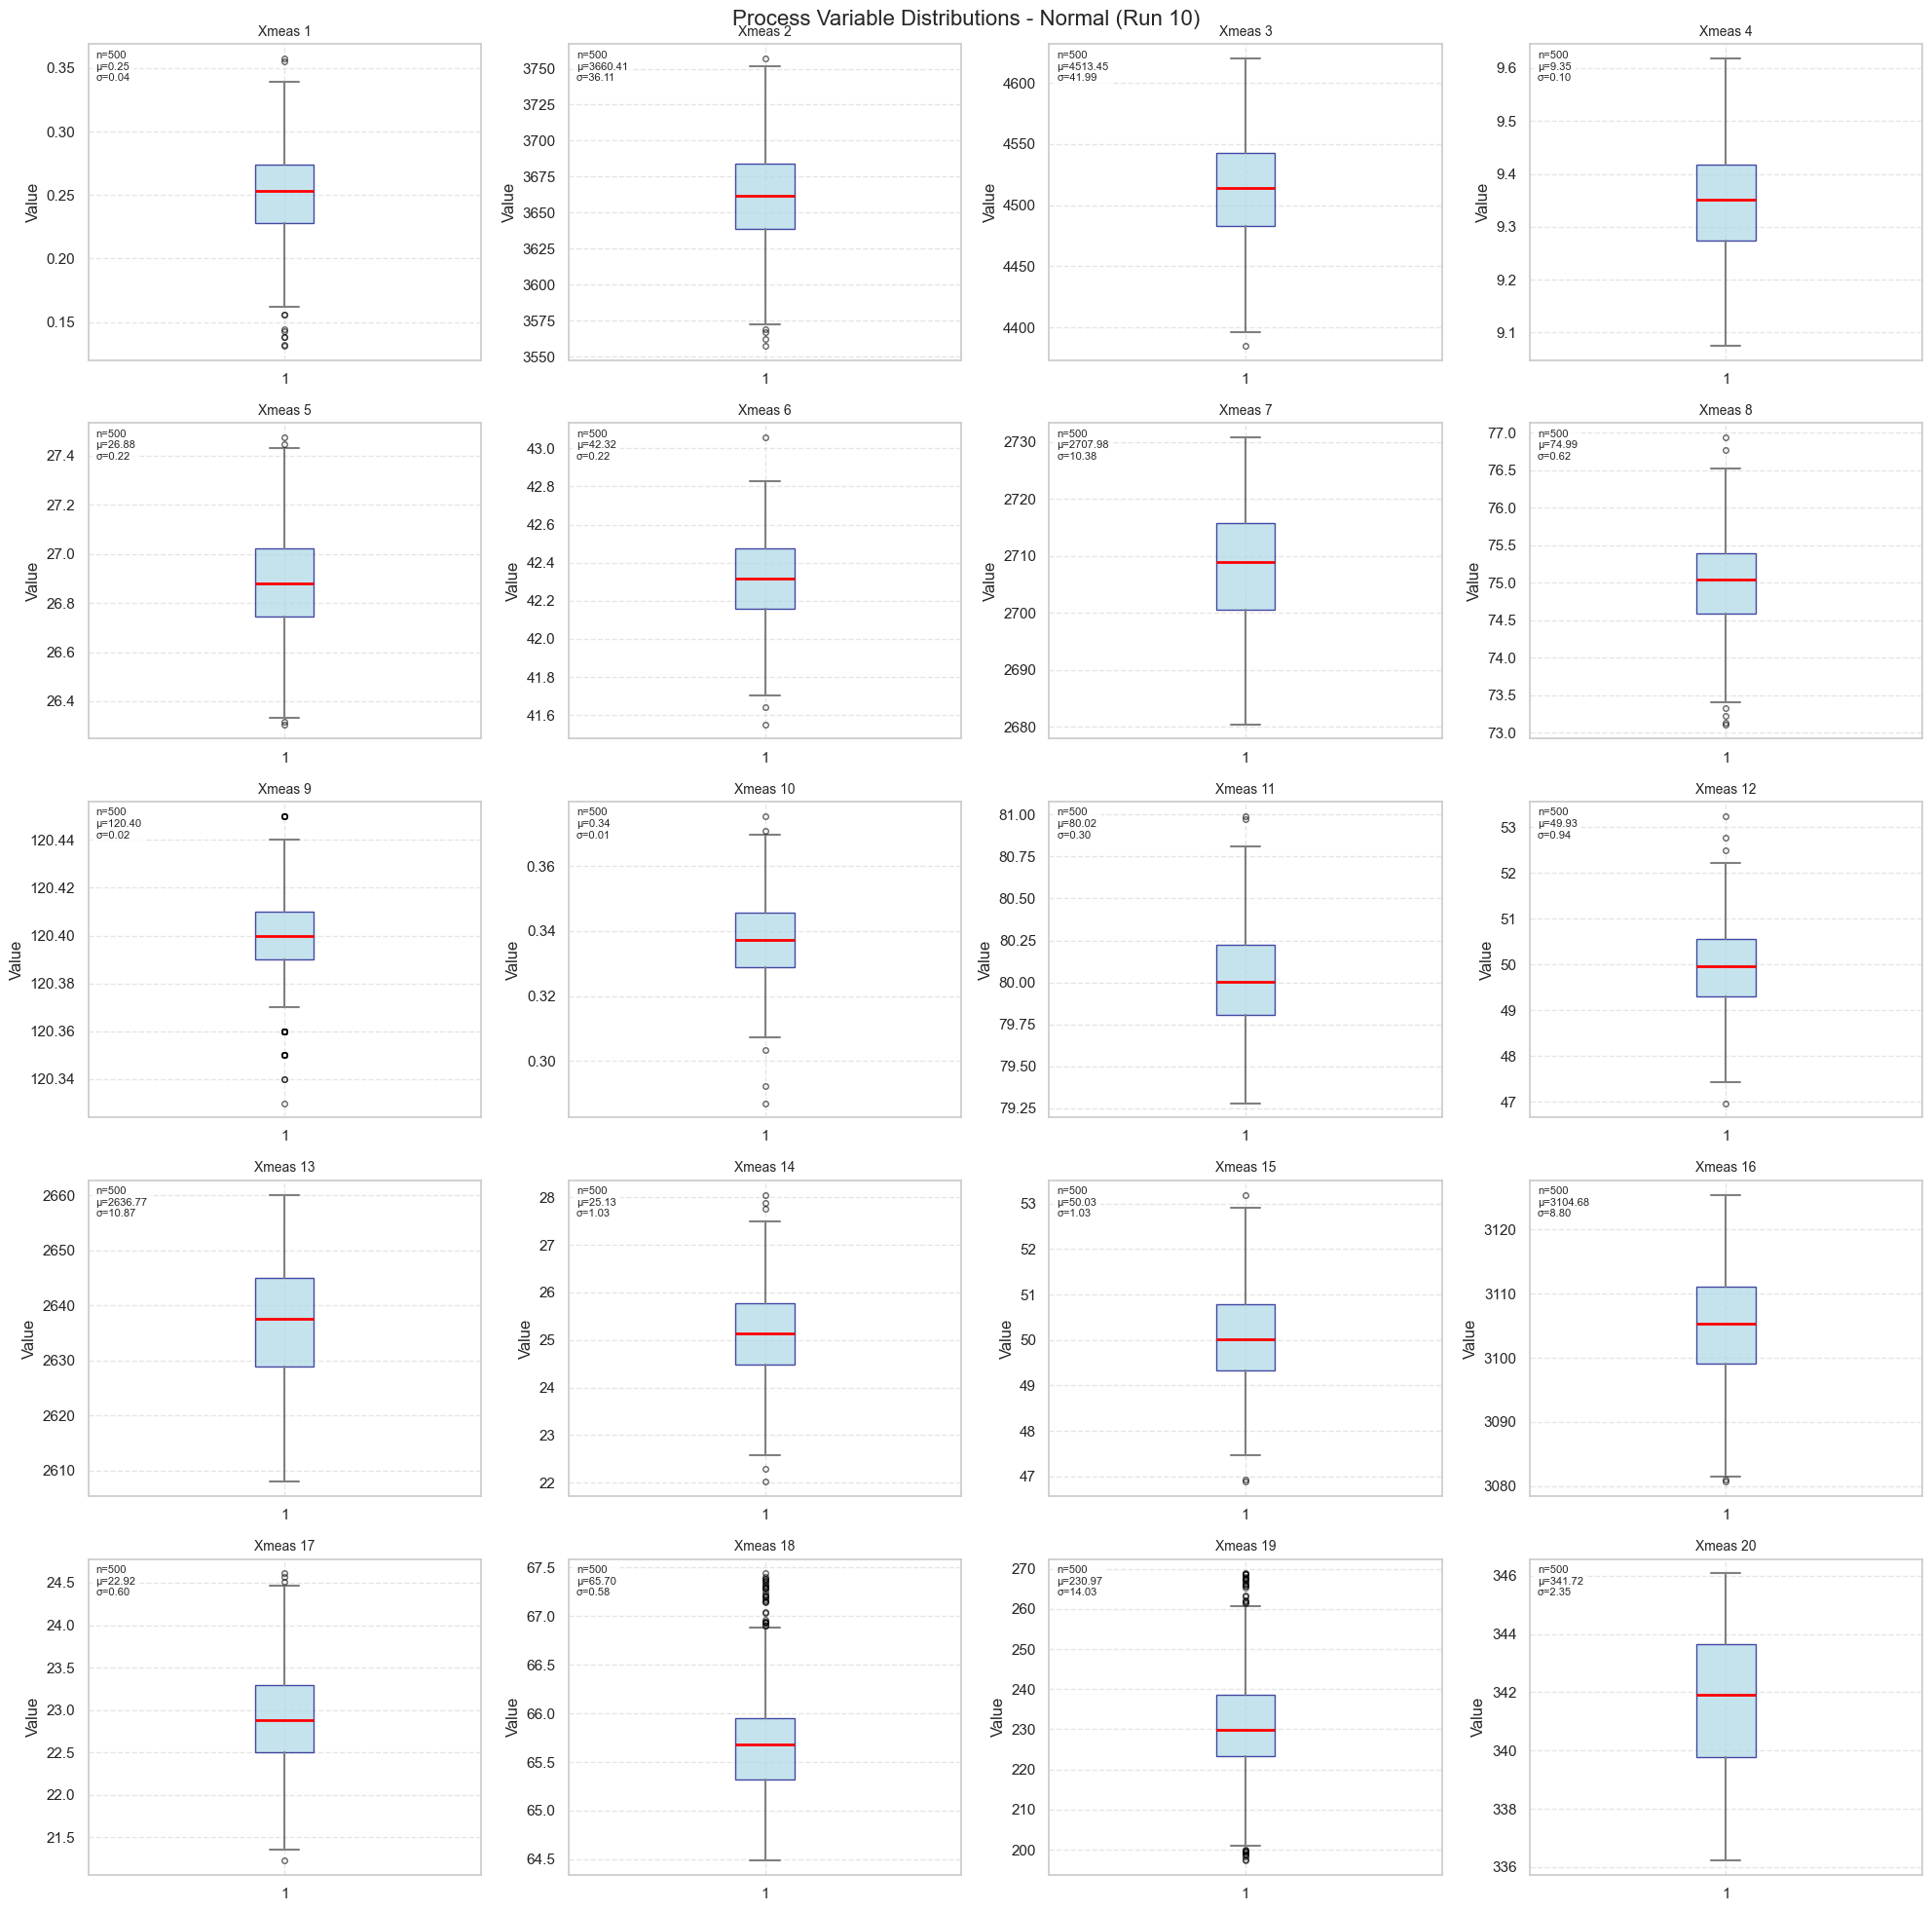

Creating boxplots for Fault 3, Simulation Run 10
Limiting to first 20 features
Creating boxplots for 20 features
✓ Plot saved: output/1.00/eda/boxplots_fault_3_run10_all_features_v1.00.png


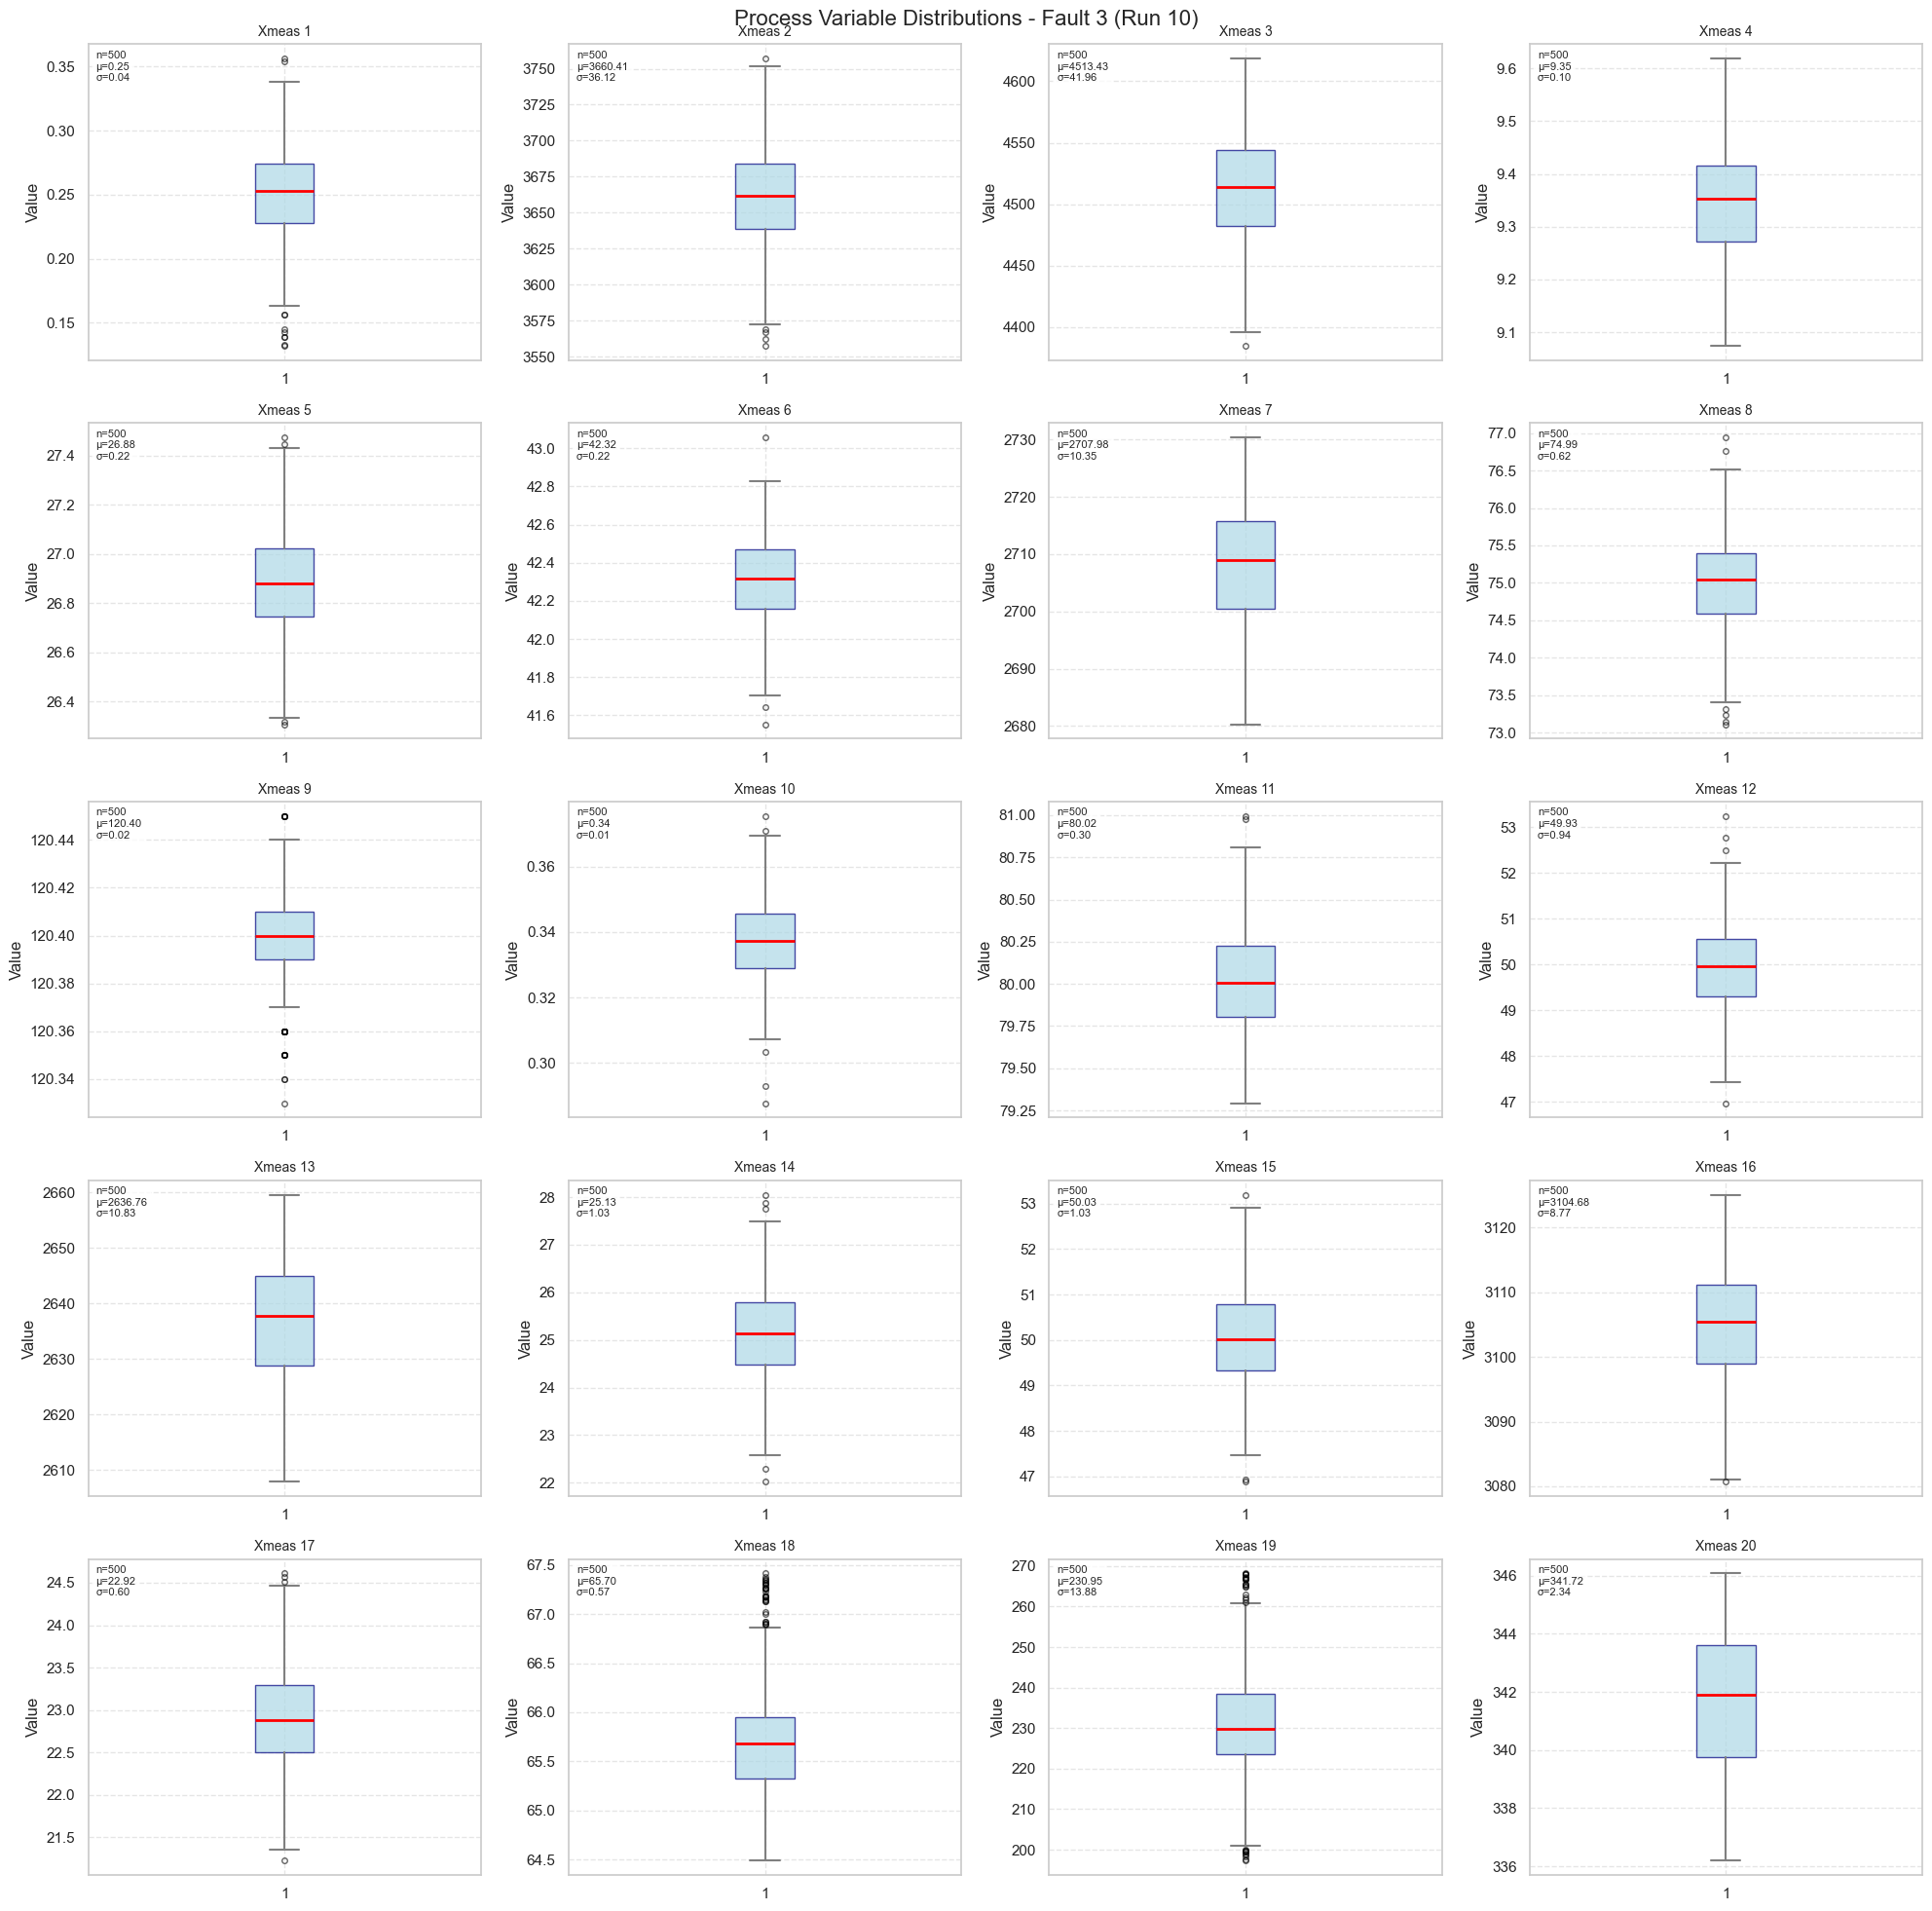

In [73]:
"""
Comprehensive Boxplot Analysis
===============================
Generate boxplots for all process variables to analyze distributions.
"""

def create_comprehensive_boxplots(
    df: pd.DataFrame,
    fault_number: int = 0,
    simulation_run: int = 10,
    max_features: int = None,
    save_fig: bool = True
) -> None:
    """
    Create comprehensive boxplots for all process features.
    
    Args:
        df: DataFrame containing the data
        fault_number: Fault number to analyze (0 for normal)
        simulation_run: Simulation run to analyze
        max_features: Maximum number of features to plot (None for all)
        save_fig: Whether to save the plot
    """
    print(f"Creating boxplots for Fault {fault_number}, Simulation Run {simulation_run}")
    
    # Filter data for specific fault and simulation run
    if fault_number == 0:
        # For normal data, use fault-free dataset
        filtered_data = DF_FF_TRAINING_RAW[
            (DF_FF_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME] == 0) &
            (DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
        ]
        data_type = "Normal"
    else:
        # For faulty data
        filtered_data = DF_F_TRAINING_RAW[
            (DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME] == fault_number) &
            (DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
        ]
        data_type = f"Fault {fault_number}"
    
    if filtered_data.empty:
        print(f"⚠ No data found for {data_type}, Simulation Run {simulation_run}")
        return
    
    # Get process features (exclude metadata columns)
    feature_columns = [col for col in filtered_data.columns 
                      if col not in [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample"]]
    
    # Limit features if specified
    if max_features and max_features < len(feature_columns):
        feature_columns = feature_columns[:max_features]
        print(f"Limiting to first {max_features} features")
    
    num_features = len(feature_columns)
    print(f"Creating boxplots for {num_features} features")
    
    # Calculate subplot grid
    num_cols = min(4, num_features)
    num_rows = int(np.ceil(num_features / num_cols))
    
    # Create figure
    fig, axes = plt.subplots(
        num_rows, num_cols, 
        figsize=(5 * num_cols, 4 * num_rows)
    )
    fig.suptitle(f"Process Variable Distributions - {data_type} (Run {simulation_run})", 
                 fontsize=16, y=0.98)
    
    # Flatten axes for easier indexing
    if num_features == 1:
        axes = [axes]
    elif num_rows == 1:
        axes = axes if num_cols > 1 else [axes]
    else:
        axes = axes.flatten()
    
    # Create boxplots
    for i, feature in enumerate(feature_columns):
        ax = axes[i]
        
        # Create boxplot
        bp = ax.boxplot(
            filtered_data[feature].dropna(),
            patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="navy", alpha=0.7),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="gray", linewidth=1.5),
            capprops=dict(color="gray", linewidth=1.5),
            flierprops=dict(marker="o", color="darkorange", alpha=0.6, markersize=4),
        )
        
        # Customize plot
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_title(feature.replace("_", " ").title(), fontsize=10)
        ax.set_ylabel("Value")
        
        # Add summary statistics as text
        data_values = filtered_data[feature].dropna()
        stats_text = f"n={len(data_values)}\nμ={data_values.mean():.2f}\nσ={data_values.std():.2f}"
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', fontsize=8, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Remove empty subplots
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_fig:
        plot_name = f"boxplots_{data_type.lower().replace(' ', '_')}_run{simulation_run}"
        save_plot(plot_name, suffix="all_features", plot_path="eda")
    
    plt.show()

# Create boxplots for normal operation
create_comprehensive_boxplots(
    df=DF_FF_TRAINING_RAW,
    fault_number=0,
    simulation_run=10,
    max_features=20,  # Limit to first 20 features for readability
    save_fig=True
)

# Create boxplots for a specific fault
create_comprehensive_boxplots(
    df=DF_F_TRAINING_RAW,
    fault_number=3,
    simulation_run=10,
    max_features=20,
    save_fig=True
)

## 5.4 Distribution Analysis - Histograms

Histogram analysis with Kernel Density Estimation (KDE) helps:
- Compare probability distributions between normal and faulty operations
- Identify distribution shapes (normal, skewed, bimodal, etc.)
- Detect potential separability between fault conditions

Comparing distributions: Fault 3 vs Normal (Run 1)
Comparing 6 features:
  1. xmeas_1
  2. xmeas_2
  3. xmeas_3
  4. xmeas_4
  5. xmeas_5
  6. xmeas_6
  xmeas_1:
    Mean difference: +0.000
    Std difference: -0.000
    Separability score: 0.000
  xmeas_2:
    Mean difference: -0.002
    Std difference: +0.005
    Separability score: 0.000
  xmeas_3:
    Mean difference: -0.024
    Std difference: -0.014
    Separability score: 0.000
  xmeas_4:
    Mean difference: -0.000
    Std difference: +0.000
    Separability score: 0.000
  xmeas_5:
    Mean difference: +0.000
    Std difference: -0.000
    Separability score: 0.000
  xmeas_6:
    Mean difference: +0.000
    Std difference: +0.000
    Separability score: 0.000
✓ Plot saved: output/1.00/eda/distribution_comparison_fault3_vs_normal_run1_v1.00.png


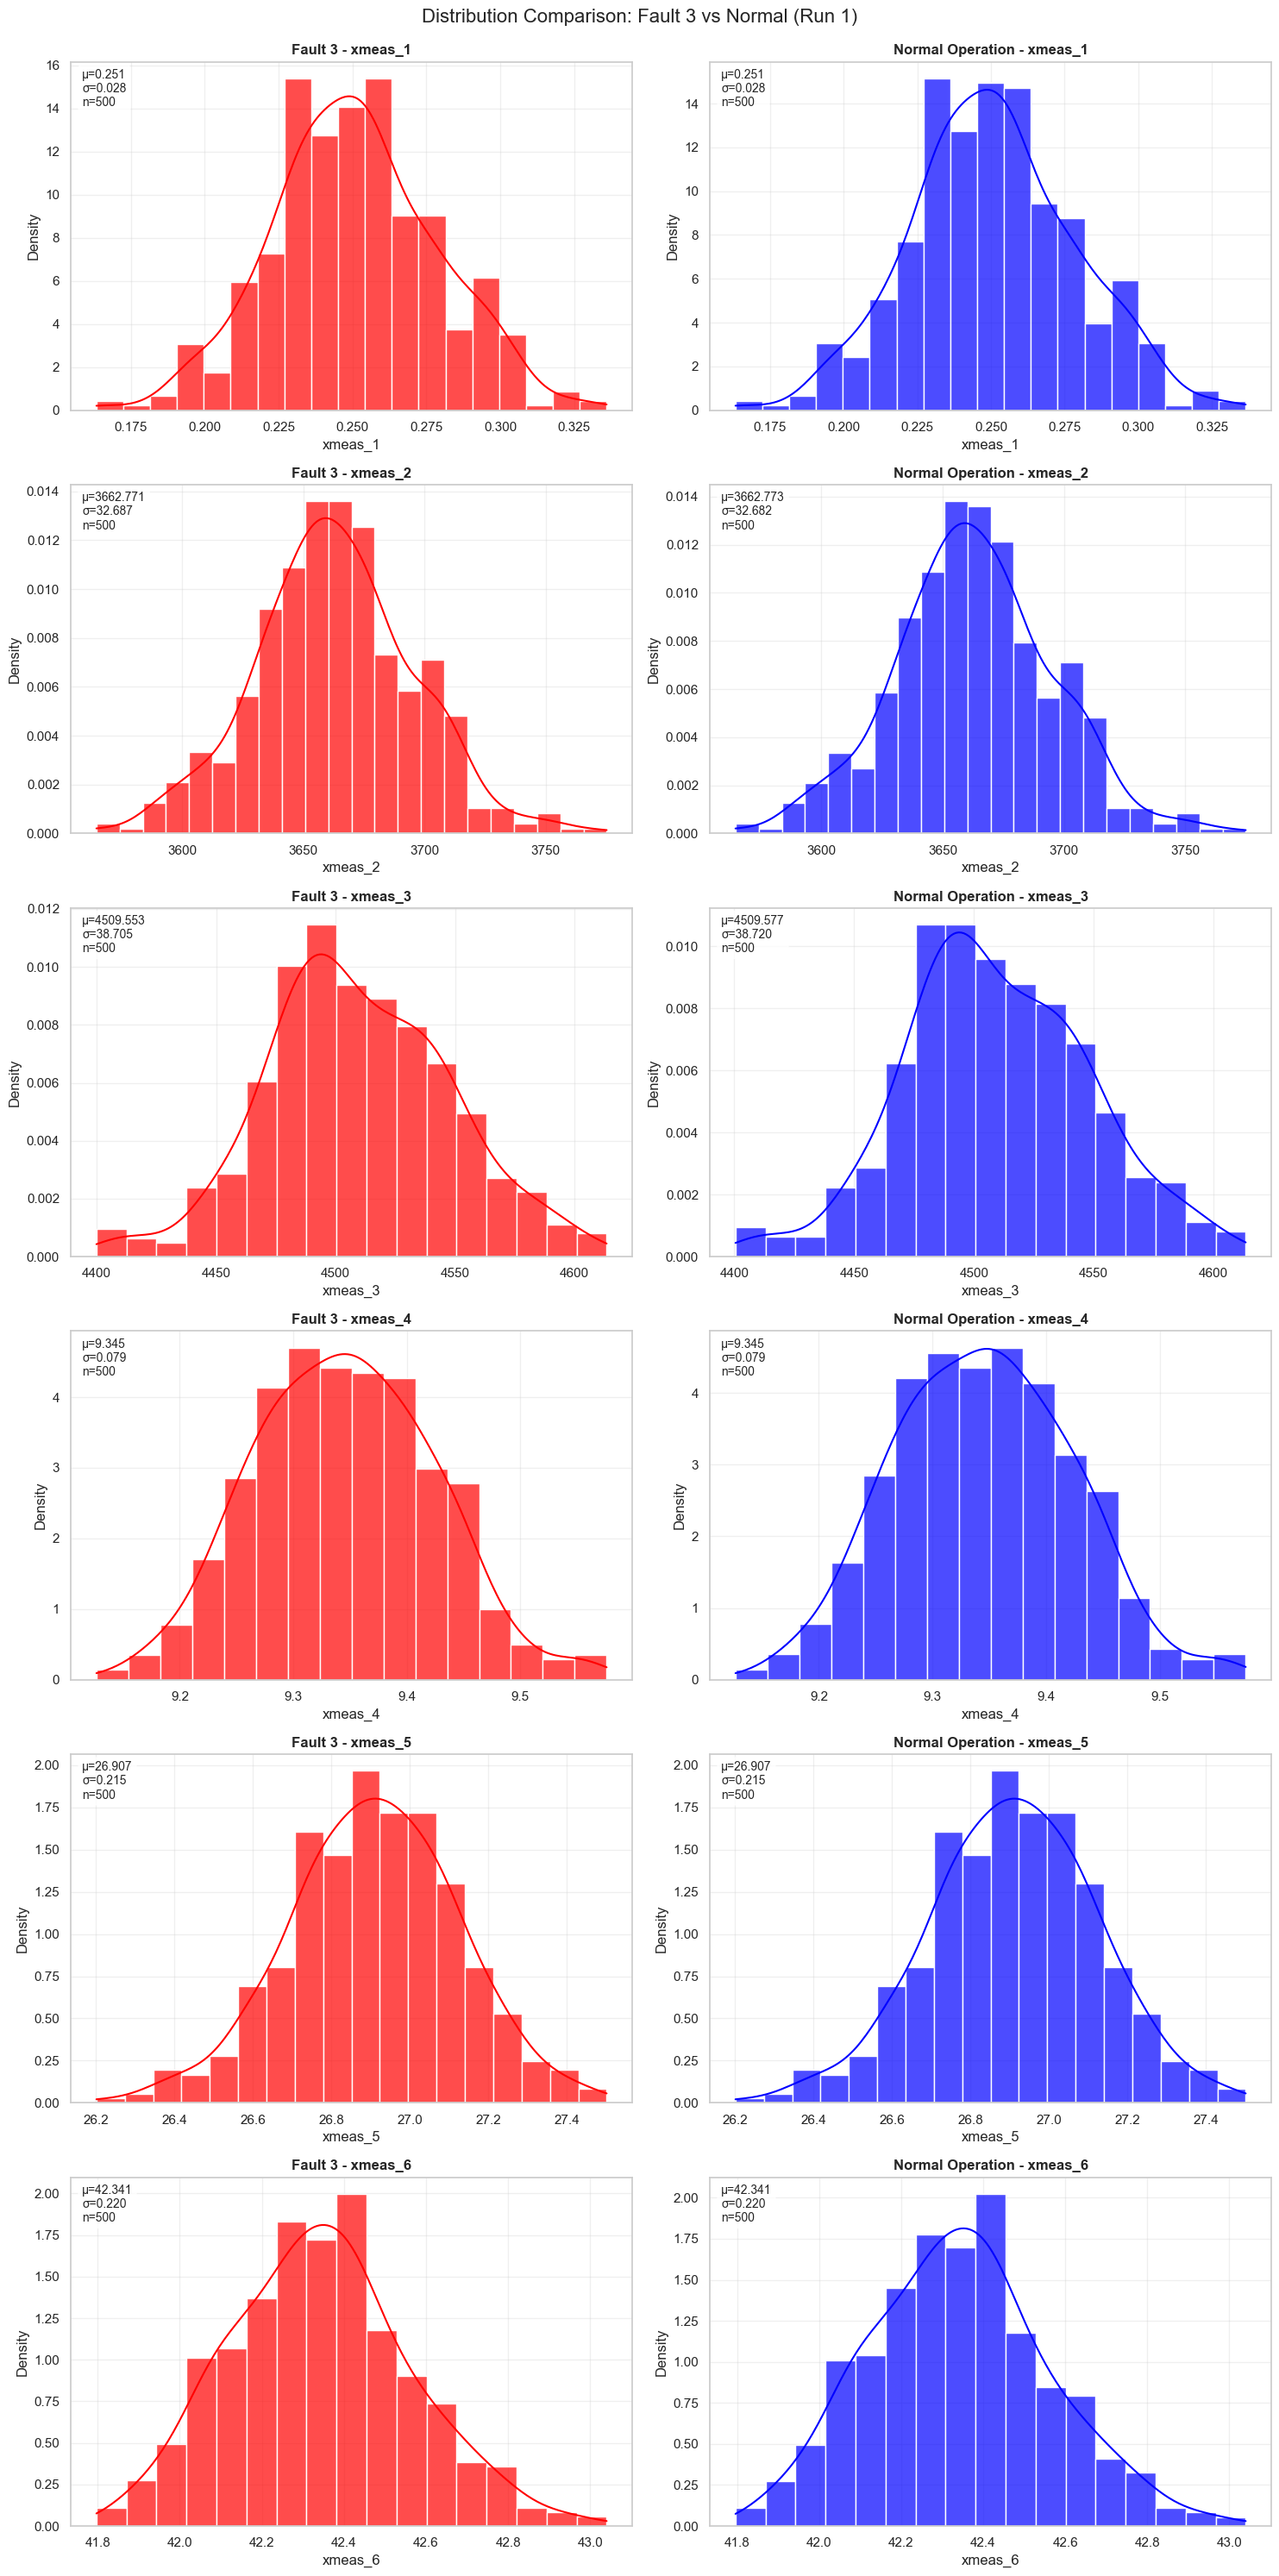

In [74]:
"""
Fault vs Normal Distribution Comparison
========================================
Compare probability distributions between faulty and normal operations.
"""

def compare_fault_normal_distributions(
    fault_number: int = 3,
    simulation_run: int = 1,
    max_features: int = 6,
    save_plot_flag: bool = True
) -> None:
    """
    Compare distributions between faulty and normal operations.
    
    Args:
        fault_number: Fault number to analyze
        simulation_run: Simulation run to use
        max_features: Maximum number of features to compare
        save_plot_flag: Whether to save the generated plots
    """
    print(f"Comparing distributions: Fault {fault_number} vs Normal (Run {simulation_run})")
    
    # Filter data for specific fault and simulation run
    df_faulty = DF_F_TRAINING_RAW[
        (DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME] == fault_number) &
        (DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
    ]
    
    df_normal = DF_FF_TRAINING_RAW[
        (DF_FF_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME] == 0) &
        (DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
    ]
    
    if df_faulty.empty or df_normal.empty:
        print(f"⚠ Insufficient data for comparison")
        return
    
    # Get process features (skip metadata columns)
    process_features = [col for col in df_faulty.columns 
                       if col not in [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample"]]
    
    # Limit features for readability
    selected_features = process_features[:max_features]
    
    print(f"Comparing {len(selected_features)} features:")
    for i, feature in enumerate(selected_features, 1):
        print(f"  {i}. {feature}")
    
    # Create comparison plots
    fig, axes = plt.subplots(
        len(selected_features), 2, 
        figsize=(15, 5 * len(selected_features))
    )
    
    if len(selected_features) == 1:
        axes = axes.reshape(1, -1)
    
    for i, feature in enumerate(selected_features):
        # Get data for this feature
        faulty_data = df_faulty[feature].dropna()
        normal_data = df_normal[feature].dropna()
        
        # Plot faulty data distribution
        ax_faulty = axes[i, 0]
        sns.histplot(
            faulty_data,
            kde=True,
            ax=ax_faulty,
            color="red",
            alpha=0.7,
            stat="density"
        )
        ax_faulty.set_title(f"Fault {fault_number} - {feature}", fontsize=12, fontweight='bold')
        ax_faulty.set_xlabel(feature)
        ax_faulty.set_ylabel("Density")
        ax_faulty.grid(True, alpha=0.3)
        
        # Add statistics text
        faulty_stats = f"μ={faulty_data.mean():.3f}\nσ={faulty_data.std():.3f}\nn={len(faulty_data)}"
        ax_faulty.text(0.02, 0.98, faulty_stats, transform=ax_faulty.transAxes,
                      verticalalignment='top', fontsize=10,
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Plot normal data distribution
        ax_normal = axes[i, 1]
        sns.histplot(
            normal_data,
            kde=True,
            ax=ax_normal,
            color="blue",
            alpha=0.7,
            stat="density"
        )
        ax_normal.set_title(f"Normal Operation - {feature}", fontsize=12, fontweight='bold')
        ax_normal.set_xlabel(feature)
        ax_normal.set_ylabel("Density")
        ax_normal.grid(True, alpha=0.3)
        
        # Add statistics text
        normal_stats = f"μ={normal_data.mean():.3f}\nσ={normal_data.std():.3f}\nn={len(normal_data)}"
        ax_normal.text(0.02, 0.98, normal_stats, transform=ax_normal.transAxes,
                      verticalalignment='top', fontsize=10,
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        # Calculate and display distribution differences
        mean_diff = faulty_data.mean() - normal_data.mean()
        std_diff = faulty_data.std() - normal_data.std()
        
        print(f"  {feature}:")
        print(f"    Mean difference: {mean_diff:+.3f}")
        print(f"    Std difference: {std_diff:+.3f}")
        print(f"    Separability score: {abs(mean_diff) / (faulty_data.std() + normal_data.std()):.3f}")
    
    plt.suptitle(f"Distribution Comparison: Fault {fault_number} vs Normal (Run {simulation_run})", 
                 fontsize=16, y=0.995)
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot_flag:
        plot_name = f"distribution_comparison_fault{fault_number}_vs_normal"
        save_plot(plot_name, suffix=f"run{simulation_run}", plot_path="eda")
    
    plt.show()

# Compare distributions for a specific fault
compare_fault_normal_distributions(
    fault_number=3,
    simulation_run=1,
    max_features=6,
    save_plot_flag=True
)

## 🔗 Feature Correlation Analysis

Analyze correlations between process variables to understand feature relationships and potential multicollinearity issues.

Analyzing fault injection timing: Fault 3, Run 1
Auto-selected features with highest variance:
  1. xmeas_3 (var=1498.109)
  2. xmeas_2 (var=1068.436)
  3. xmeas_19 (var=60.575)
  4. xmeas_13 (var=39.089)
  5. xmeas_7 (var=35.884)
  6. xmeas_16 (var=28.620)
✓ Plot saved: output/1.00/eda/fault_injection_timing_fault3_run1_v1.00.png


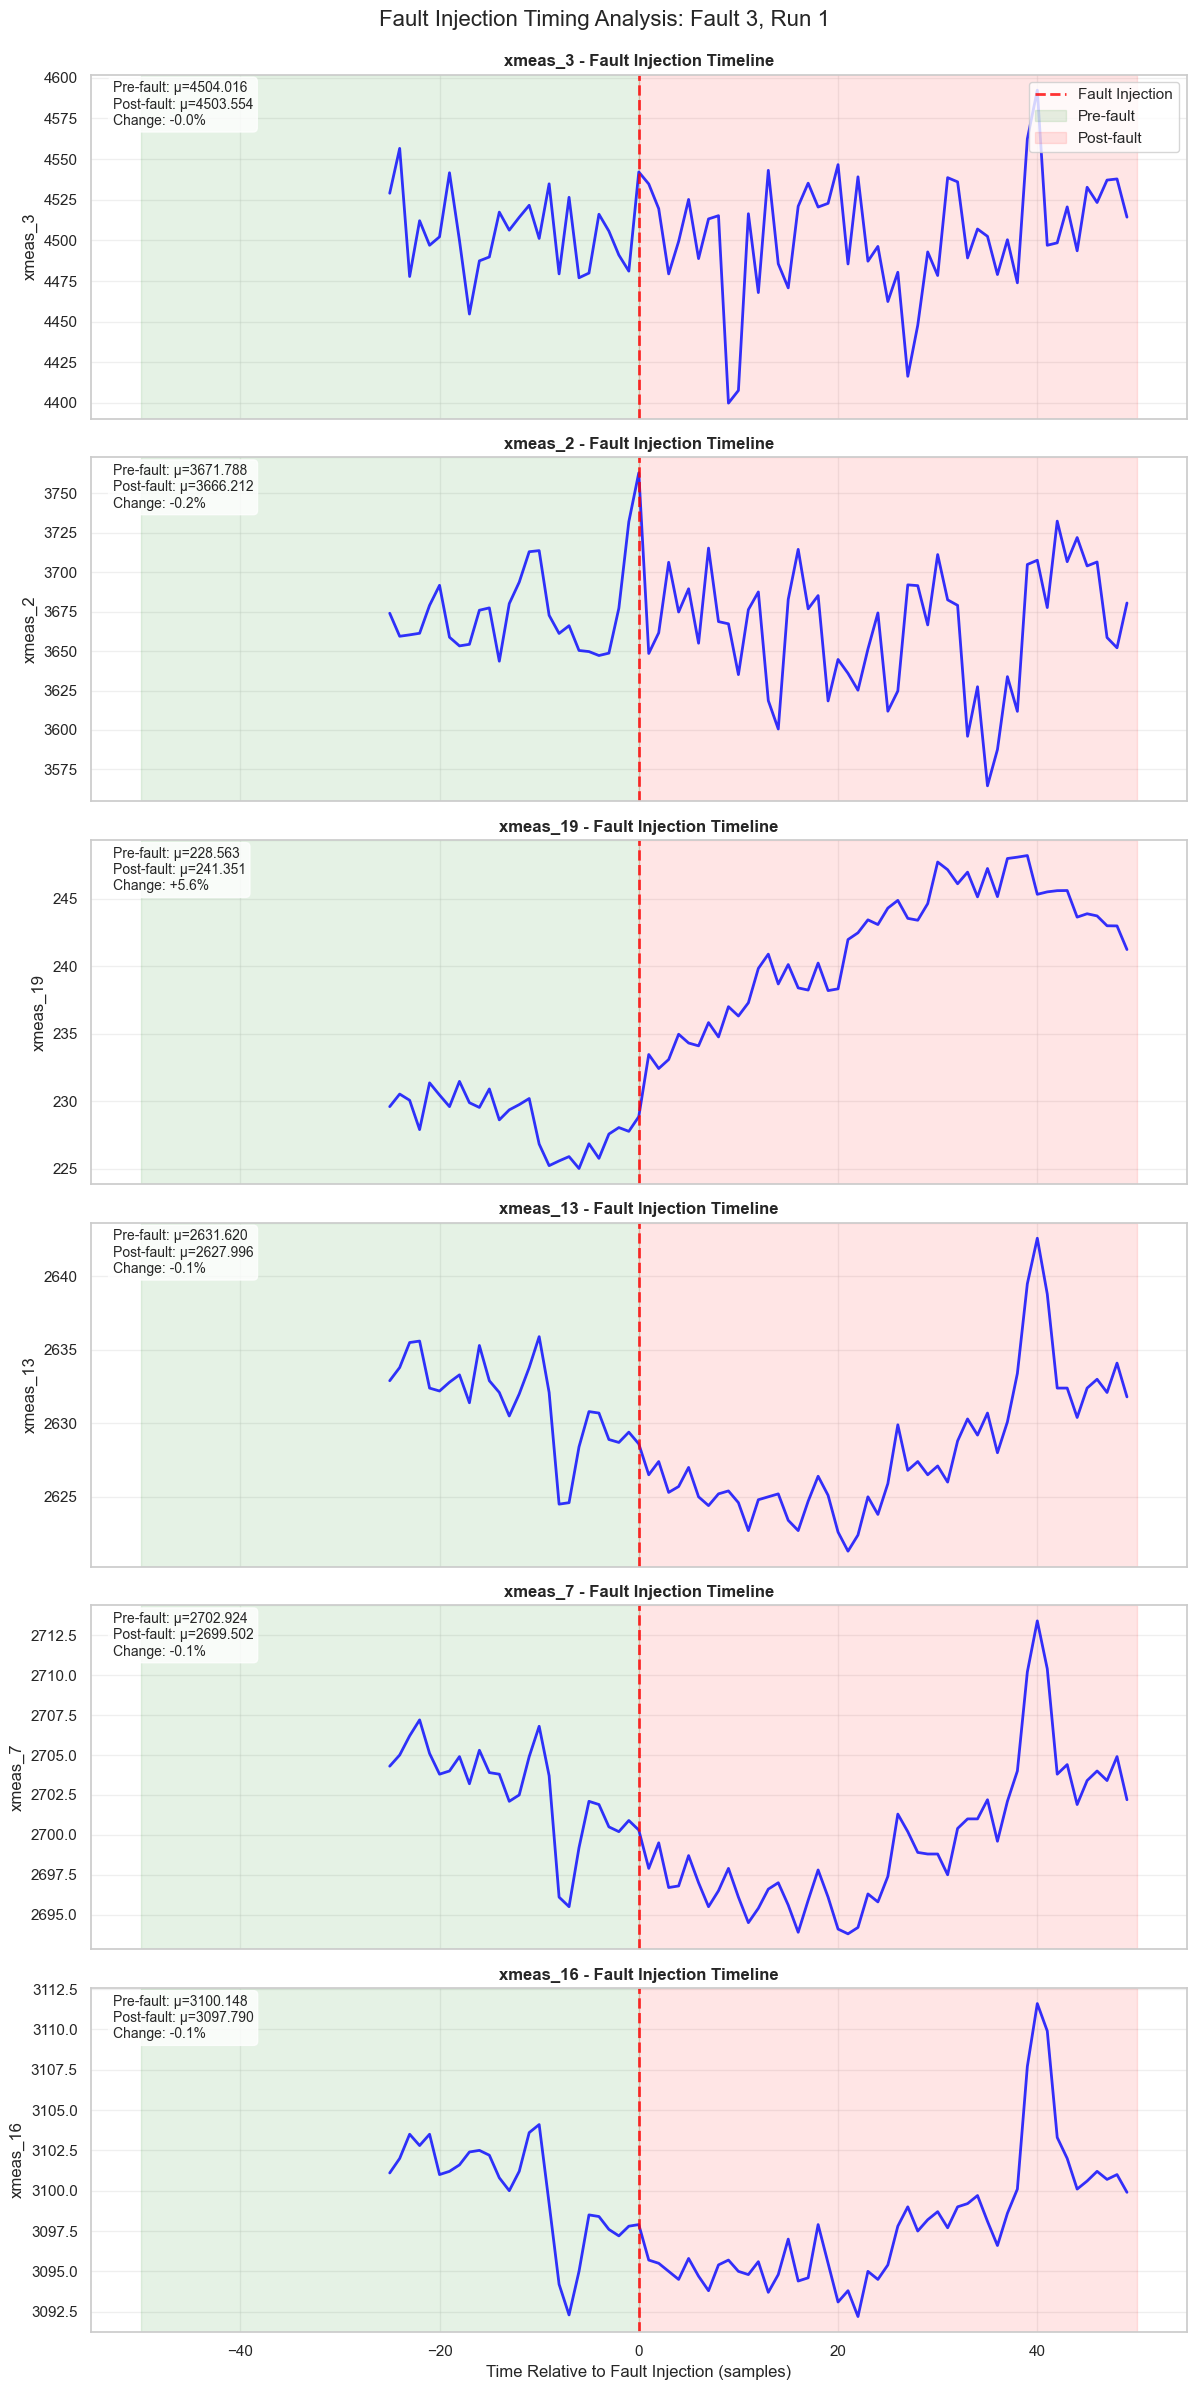


Fault Injection Analysis Summary:
  Window size: ±50 samples
  Features analyzed: 6
  Data points in window: 75


In [75]:
"""
Fault Injection Timing Analysis
===============================
Analyze process variable behavior around fault injection points.
"""

def analyze_fault_injection_timing(
    fault_number: int = 3,
    simulation_run: int = 1,
    features_to_analyze: Optional[List[str]] = None,
    window_size: int = 50,
    fault_injection_point: int = 0,
    save_plot_flag: bool = True
) -> None:
    """
    Analyze process variables around fault injection timing.
    
    Args:
        fault_number: Fault number to analyze
        simulation_run: Simulation run to use
        features_to_analyze: Specific features to analyze (if None, uses top varying features)
        window_size: Number of samples before/after fault injection to show
        save_plot_flag: Whether to save the generated plots
    """
    print(f"Analyzing fault injection timing: Fault {fault_number}, Run {simulation_run}")
    
    # Filter data for specific fault and simulation run
    df_fault = DF_F_TRAINING_RAW[
        (DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME] == fault_number) &
        (DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
    ].copy()
    
    if df_fault.empty:
        print(f"⚠ No data found for Fault {fault_number}, Run {simulation_run}")
        return
    
    # Get process features
    process_features = [col for col in df_fault.columns 
                       if col not in [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample"]]
    
    # Auto-select features if not specified
    if features_to_analyze is None:
        # Calculate variance for each feature to find most variable ones
        feature_variance = df_fault[process_features].var().sort_values(ascending=False)
        features_to_analyze = feature_variance.head(6).index.tolist()
        print(f"Auto-selected features with highest variance:")
        for i, feature in enumerate(features_to_analyze, 1):
            print(f"  {i}. {feature} (var={feature_variance[feature]:.3f})")
    else:
        print(f"Analyzing specified features: {features_to_analyze}")
    
    # Define window around fault injection
    start_idx = max(0, fault_injection_point - window_size)
    end_idx = min(len(df_fault), fault_injection_point + window_size)
    
    # Get windowed data
    window_data = df_fault.iloc[start_idx:end_idx].copy()
    
    # Create relative sample index (0 = fault injection point)
    relative_sample = np.arange(start_idx - fault_injection_point, end_idx - fault_injection_point)
    window_data['relative_sample'] = relative_sample
    
    # Create plots
    n_features = len(features_to_analyze)
    fig, axes = plt.subplots(
        n_features, 1, 
        figsize=(12, 4 * n_features),
        sharex=True
    )
    
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features_to_analyze):
        ax = axes[i]
        
        # Plot the feature values over time
        ax.plot(
            window_data['relative_sample'],
            window_data[feature],
            linewidth=2,
            color='blue',
            alpha=0.8
        )
        
        # Mark fault injection point
        ax.axvline(
            x=0,
            color='red',
            linestyle='--',
            linewidth=2,
            alpha=0.8,
            label='Fault Injection'
        )
        
        # Shade pre/post fault regions
        ax.axvspan(-window_size, 0, alpha=0.1, color='green', label='Pre-fault')
        ax.axvspan(0, window_size, alpha=0.1, color='red', label='Post-fault')
        
        # Calculate and display statistics
        pre_fault_data = window_data[window_data['relative_sample'] < 0][feature]
        post_fault_data = window_data[window_data['relative_sample'] >= 0][feature]
        
        if len(pre_fault_data) > 0 and len(post_fault_data) > 0:
            pre_mean = pre_fault_data.mean()
            post_mean = post_fault_data.mean()
            change_pct = ((post_mean - pre_mean) / pre_mean) * 100 if pre_mean != 0 else 0
            
            # Add statistics box
            stats_text = f"Pre-fault: μ={pre_mean:.3f}\nPost-fault: μ={post_mean:.3f}\nChange: {change_pct:+.1f}%"
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                   verticalalignment='top', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        ax.set_title(f"{feature} - Fault Injection Timeline", fontsize=12, fontweight='bold')
        ax.set_ylabel(feature)
        ax.grid(True, alpha=0.3)
        
        if i == 0:  # Add legend only to first subplot
            ax.legend(loc='upper right')
    
    # Set common x-axis label
    axes[-1].set_xlabel("Time Relative to Fault Injection (samples)")
    
    plt.suptitle(f"Fault Injection Timing Analysis: Fault {fault_number}, Run {simulation_run}", 
                 fontsize=16, y=0.995)
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot_flag:
        plot_name = f"fault_injection_timing_fault{fault_number}"
        save_plot(plot_name, suffix=f"run{simulation_run}", plot_path="eda")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nFault Injection Analysis Summary:")
    print(f"  Window size: ±{window_size} samples")
    print(f"  Features analyzed: {len(features_to_analyze)}")
    print(f"  Data points in window: {len(window_data)}")

# Analyze fault injection timing
analyze_fault_injection_timing(
    fault_number=3,
    simulation_run=1,
    window_size=50,
    fault_injection_point=25,
    save_plot_flag=True
)

Creating t-SNE visualization with 1000 samples per fault
Parameters: perplexity=30.0, iterations=1000
  Added 1000 normal operation samples
  Added 1000 samples for Fault 1
  Added 1000 samples for Fault 2
  Added 1000 samples for Fault 3
  Added 1000 samples for Fault 4
  Added 1000 samples for Fault 5
  Added 1000 samples for Fault 6
  Added 1000 samples for Fault 7
  Added 1000 samples for Fault 8
  Added 1000 samples for Fault 9
  Added 1000 samples for Fault 10
  Added 1000 samples for Fault 11
  Added 1000 samples for Fault 12
  Added 1000 samples for Fault 13
  Added 1000 samples for Fault 14
  Added 1000 samples for Fault 15
  Added 1000 samples for Fault 16
  Added 1000 samples for Fault 17
  Added 1000 samples for Fault 18
  Added 1000 samples for Fault 19
  Added 1000 samples for Fault 20

Preparing t-SNE with 21000 total samples
Features: 52
Running t-SNE dimensionality reduction...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 21000 samples in 0.001s...


/Users/Khaled.Alabsi/projects/PhD_Project/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 21000 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21000
[t-SNE] Computed conditional probabilities for sample 2000 / 21000
[t-SNE] Computed conditional probabilities for sample 3000 / 21000
[t-SNE] Computed conditional probabilities for sample 4000 / 21000
[t-SNE] Computed conditional probabilities for sample 5000 / 21000
[t-SNE] Computed conditional probabilities for sample 6000 / 21000
[t-SNE] Computed conditional probabilities for sample 7000 / 21000
[t-SNE] Computed conditional probabilities for sample 8000 / 21000
[t-SNE] Computed conditional probabilities for sample 9000 / 21000
[t-SNE] Computed conditional probabilities for sample 10000 / 21000
[t-SNE] Computed conditional probabilities for sample 11000 / 21000
[t-SNE] Computed conditional probabilities for sample 12000 / 21000
[t-SNE] Computed conditional probabilities for sample 13000 / 21000
[t-SNE] Computed conditional probabilities for sample 14000 / 21000

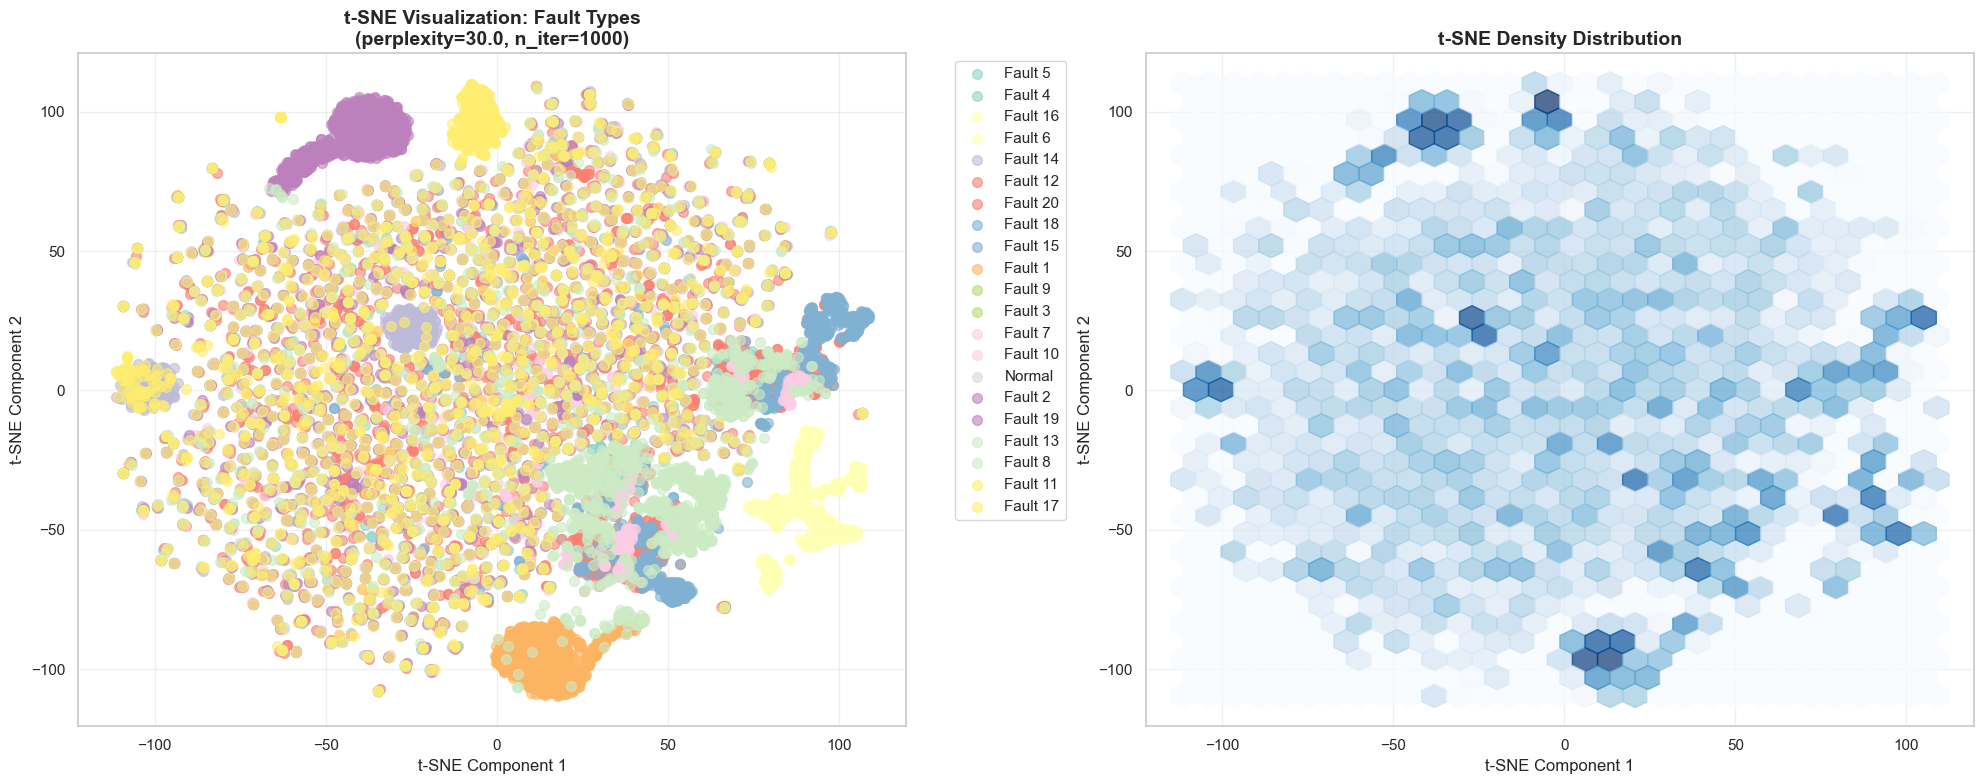


t-SNE Analysis Summary:
  Total samples: 21000
  Fault types: 20 + Normal
  Final stress: 1.593
  Normal-Fault separation distance: 14.676


In [76]:
"""
t-SNE Dimensionality Reduction Visualization
===========================================
Visualize fault data using t-SNE for pattern recognition and clustering analysis.
"""

def create_tsne_visualization(
    data_subset_size: int = 1000,
    perplexity: float = 30.0,
    n_iter: int = 1000,
    random_state: int = 42,
    save_plot_flag: bool = True,
    include_normal_data: bool = True
) -> None:
    """
    Create t-SNE visualization of fault vs normal data.
    
    Args:
        data_subset_size: Number of samples to use per fault type
        perplexity: t-SNE perplexity parameter (typically 5-50)
        n_iter: Number of iterations for optimization
        random_state: Random seed for reproducibility
        save_plot_flag: Whether to save the generated plots
        include_normal_data: Whether to include normal operation data
    """
    print(f"Creating t-SNE visualization with {data_subset_size} samples per fault")
    print(f"Parameters: perplexity={perplexity}, iterations={n_iter}")
    
    # Prepare data for t-SNE
    data_for_tsne = []
    labels_for_tsne = []
    
    # Get process features (exclude metadata columns)
    process_features = [col for col in DF_F_TRAINING_RAW.columns 
                       if col not in [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample"]]
    
    # Include normal data if requested
    if include_normal_data:
        normal_sample = DF_FF_TRAINING_RAW[process_features].sample(
            n=min(data_subset_size, len(DF_FF_TRAINING_RAW)), 
            random_state=random_state
        )
        data_for_tsne.append(normal_sample)
        labels_for_tsne.extend(['Normal'] * len(normal_sample))
        print(f"  Added {len(normal_sample)} normal operation samples")
    
    # Add fault data for each fault type
    unique_faults = sorted(DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].unique())
    for fault_num in unique_faults:
        fault_data = DF_F_TRAINING_RAW[
            DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME] == fault_num
        ][process_features]
        
        fault_sample = fault_data.sample(
            n=min(data_subset_size, len(fault_data)), 
            random_state=random_state
        )
        data_for_tsne.append(fault_sample)
        labels_for_tsne.extend([f'Fault {fault_num}'] * len(fault_sample))
        print(f"  Added {len(fault_sample)} samples for Fault {fault_num}")
    
    # Combine all data
    combined_data = pd.concat(data_for_tsne, ignore_index=True)
    
    print(f"\nPreparing t-SNE with {len(combined_data)} total samples")
    print(f"Features: {len(process_features)}")
    
    # Handle missing values
    if combined_data.isnull().any().any():
        print("⚠ Found missing values, filling with feature means")
        combined_data = combined_data.fillna(combined_data.mean())
    
    # Standardize the data for t-SNE
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(combined_data)
    
    # Apply t-SNE
    print("Running t-SNE dimensionality reduction...")
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=n_iter,
        random_state=random_state,
        verbose=1
    )
    
    tsne_results = tsne.fit_transform(data_scaled)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Color by fault type
    unique_labels = list(set(labels_for_tsne))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = [l == label for l in labels_for_tsne]
        ax1.scatter(
            tsne_results[mask, 0],
            tsne_results[mask, 1],
            c=[colors[i]],
            label=label,
            alpha=0.6,
            s=50
        )
    
    ax1.set_title(f't-SNE Visualization: Fault Types\n(perplexity={perplexity}, n_iter={n_iter})', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Density plot
    ax2.hexbin(
        tsne_results[:, 0],
        tsne_results[:, 1],
        gridsize=30,
        cmap='Blues',
        alpha=0.7
    )
    ax2.set_title('t-SNE Density Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot_flag:
        plot_name = f"tsne_fault_analysis_perp{int(perplexity)}"
        save_plot(plot_name, suffix=f"{data_subset_size}samples", plot_path="eda")
    
    plt.show()
    
    # Print analysis summary
    print(f"\nt-SNE Analysis Summary:")
    print(f"  Total samples: {len(combined_data)}")
    print(f"  Fault types: {len(unique_faults)} + {'Normal' if include_normal_data else '0'}")
    print(f"  Final stress: {tsne.kl_divergence_:.3f}")
    
    # Calculate separation metrics
    if include_normal_data:
        normal_mask = [l == 'Normal' for l in labels_for_tsne]
        normal_points = tsne_results[normal_mask]
        fault_points = tsne_results[~np.array(normal_mask)]
        
        if len(normal_points) > 0 and len(fault_points) > 0:
            # Calculate average distance between normal and fault clusters
            normal_center = np.mean(normal_points, axis=0)
            fault_center = np.mean(fault_points, axis=0)
            separation_distance = np.linalg.norm(normal_center - fault_center)
            print(f"  Normal-Fault separation distance: {separation_distance:.3f}")

# Create t-SNE visualization with default parameters
create_tsne_visualization(
    data_subset_size=1000,
    perplexity=30.0,
    n_iter=1000,
    save_plot_flag=True,
    include_normal_data=True
)

Analyzing feature correlations for normal data
Analyzing 52 process features
Data points: 250000
✓ Plot saved: output/1.00/eda/correlation_analysis_normal_threshold80_v1.00.png


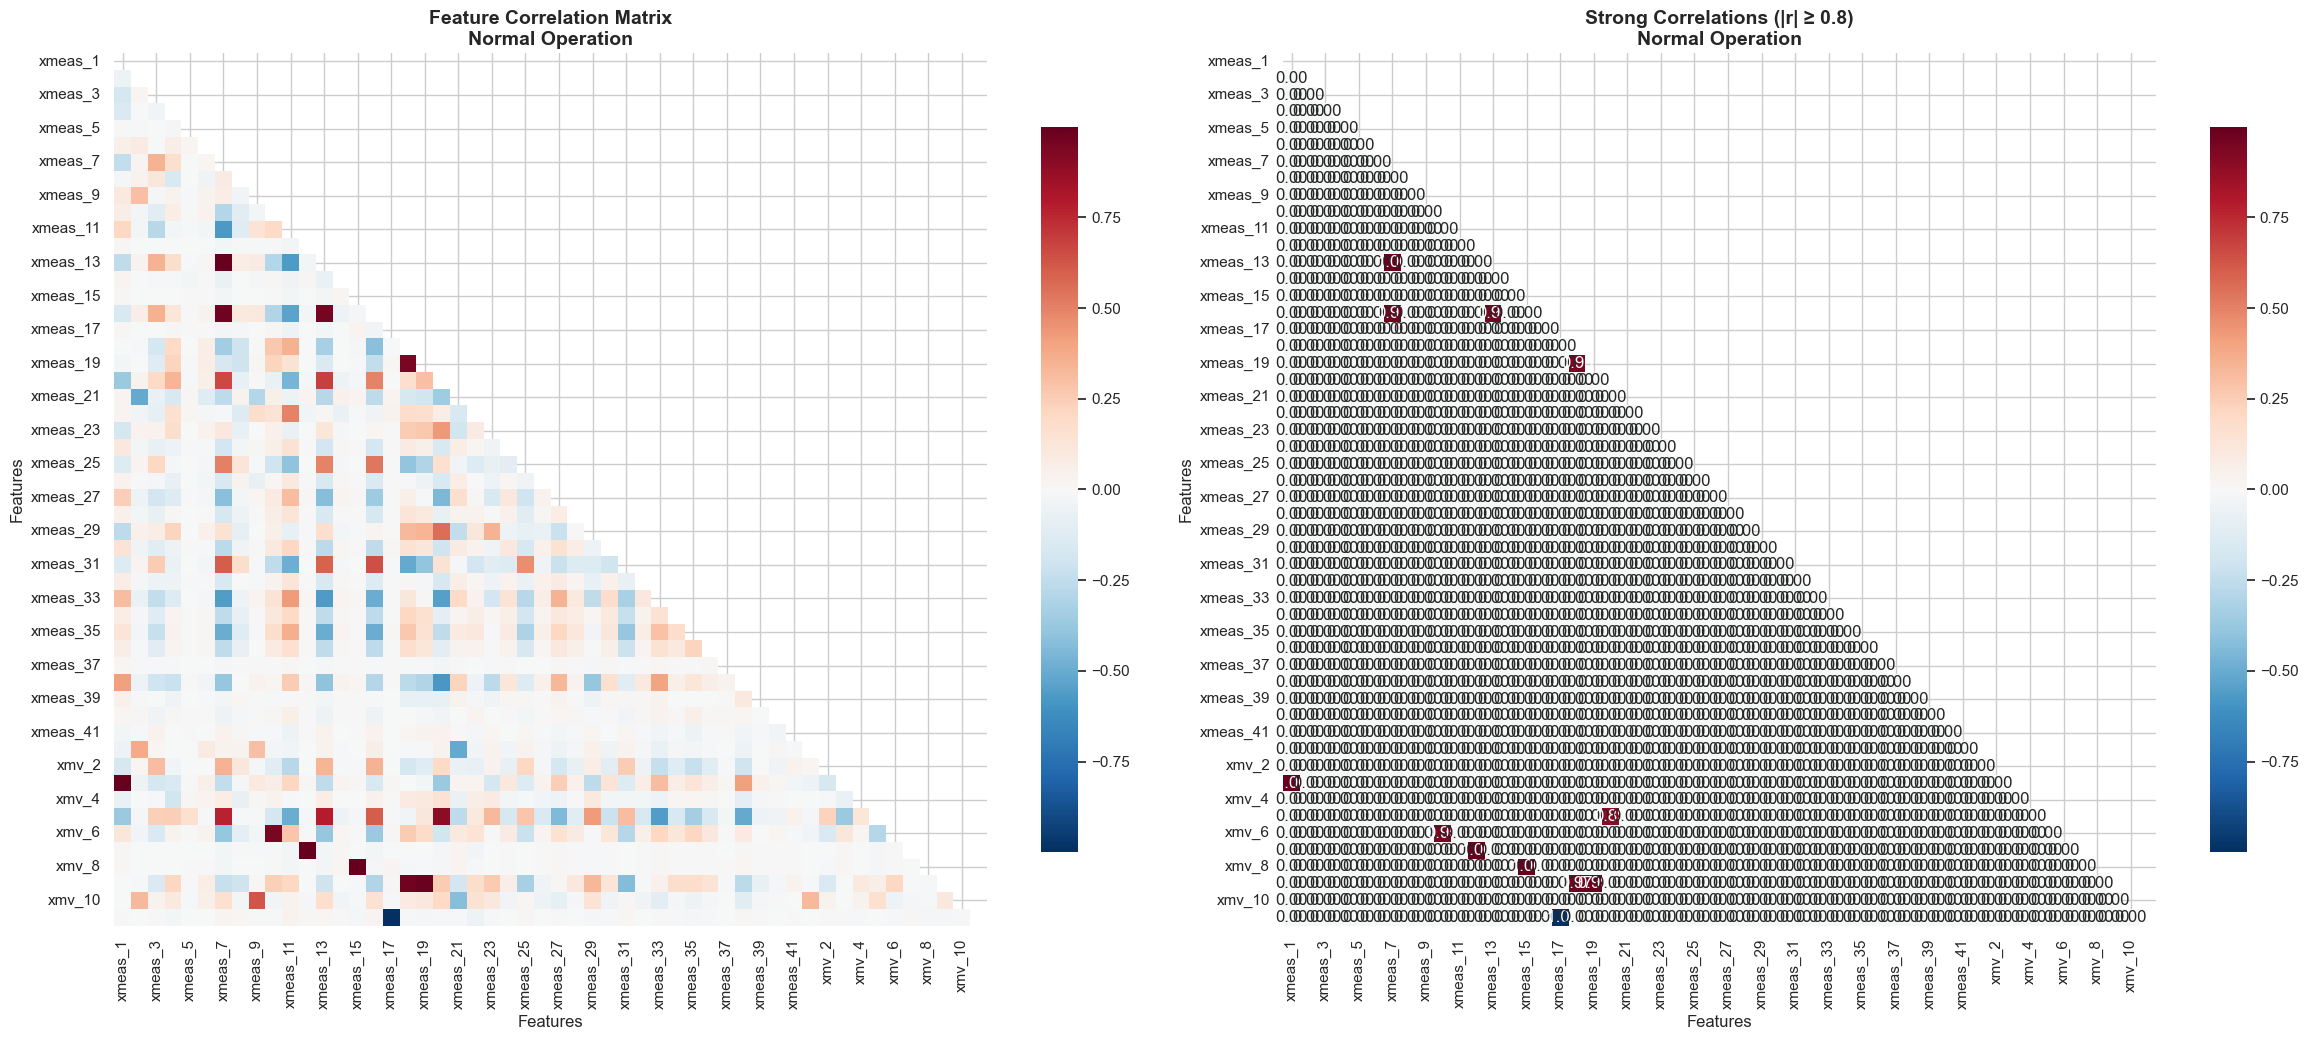


🔍 Strong Correlations Found (12 pairs):
  xmeas_12 ↔ xmv_7: +1.000
  xmeas_15 ↔ xmv_8: +1.000
  xmeas_17 ↔ xmv_11: -0.999
  xmeas_7 ↔ xmeas_13: +0.997
  xmeas_1 ↔ xmv_3: +0.997
  xmeas_19 ↔ xmv_9: +0.986
  xmeas_18 ↔ xmv_9: +0.970
  xmeas_7 ↔ xmeas_16: +0.969
  xmeas_13 ↔ xmeas_16: +0.960
  xmeas_18 ↔ xmeas_19: +0.950
  ... and 2 more pairs

Correlation Analysis Summary:
  Features analyzed: 52
  Strong correlations (|r| ≥ 0.8): 12
  Max correlation: 1.000
  Mean |correlation|: 0.097


In [77]:
"""
Feature Correlation Analysis
============================
Analyze correlations between process variables for different operational conditions.
"""

def analyze_feature_correlations(
    data_type: str = "normal",
    fault_number: Optional[int] = None,
    correlation_threshold: float = 0.8,
    save_plot_flag: bool = True,
    figsize: Tuple[int, int] = (12, 10)
) -> pd.DataFrame:
    """
    Analyze and visualize feature correlations.
    
    Args:
        data_type: Type of data to analyze ("normal", "fault", or "all")
        fault_number: Specific fault number to analyze (required if data_type="fault")
        correlation_threshold: Threshold for highlighting strong correlations
        save_plot: Whether to save the generated plots
        figsize: Figure size for the correlation heatmap
        
    Returns:
        DataFrame with correlation matrix
    """
    print(f"Analyzing feature correlations for {data_type} data")
    
    # Select appropriate dataset
    if data_type == "normal":
        df_analysis = DF_FF_TRAINING_RAW.copy()
        title_suffix = "Normal Operation"
        filename_suffix = "normal"
    elif data_type == "fault":
        if fault_number is None:
            raise ValueError("fault_number must be specified when data_type='fault'")
        df_analysis = DF_F_TRAINING_RAW[
            DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME] == fault_number
        ].copy()
        title_suffix = f"Fault {fault_number}"
        filename_suffix = f"fault{fault_number}"
    elif data_type == "all":
        df_analysis = pd.concat([DF_FF_TRAINING_RAW, DF_F_TRAINING_RAW], ignore_index=True)
        title_suffix = "All Data"
        filename_suffix = "all"
    else:
        raise ValueError("data_type must be 'normal', 'fault', or 'all'")
    
    if df_analysis.empty:
        print(f"⚠ No data available for analysis")
        return pd.DataFrame()
    
    # Get process features (exclude metadata columns)
    process_features = [col for col in df_analysis.columns 
                       if col not in [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample"]]
    
    print(f"Analyzing {len(process_features)} process features")
    print(f"Data points: {len(df_analysis)}")
    
    # Calculate correlation matrix
    correlation_matrix = df_analysis[process_features].corr()
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]))
    
    # Plot 1: Full correlation heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=False,
        cmap='RdBu_r',
        center=0,
        square=True,
        fmt='.2f',
        cbar_kws={"shrink": 0.8},
        ax=ax1
    )
    ax1.set_title(f'Feature Correlation Matrix\n{title_suffix}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Features')
    
    # Plot 2: Strong correlations only
    strong_corr_matrix = correlation_matrix.copy()
    strong_corr_matrix[abs(strong_corr_matrix) < correlation_threshold] = 0
    
    sns.heatmap(
        strong_corr_matrix,
        mask=mask,
        annot=True,
        cmap='RdBu_r',
        center=0,
        square=True,
        fmt='.2f',
        cbar_kws={"shrink": 0.8},
        ax=ax2
    )
    ax2.set_title(f'Strong Correlations (|r| ≥ {correlation_threshold})\n{title_suffix}', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('Features')
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot_flag:
        plot_name = f"correlation_analysis_{filename_suffix}"
        save_plot(plot_name, suffix=f"threshold{int(correlation_threshold*100)}", plot_path="eda")
    
    plt.show()
    
    # Find and report strong correlations
    strong_correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) >= correlation_threshold:
                strong_correlations.append({
                    'Feature_1': correlation_matrix.columns[i],
                    'Feature_2': correlation_matrix.columns[j],
                    'Correlation': corr_value
                })
    
    if strong_correlations:
        strong_corr_df = pd.DataFrame(strong_correlations)
        strong_corr_df = strong_corr_df.sort_values('Correlation', key=abs, ascending=False)
        
        print(f"\n🔍 Strong Correlations Found ({len(strong_correlations)} pairs):")
        print("=" * 60)
        for _, row in strong_corr_df.head(10).iterrows():  # Show top 10
            print(f"  {row['Feature_1']} ↔ {row['Feature_2']}: {row['Correlation']:+.3f}")
        
        if len(strong_correlations) > 10:
            print(f"  ... and {len(strong_correlations) - 10} more pairs")
    else:
        print(f"\n✓ No strong correlations found (threshold: {correlation_threshold})")
    
    # Summary statistics
    print(f"\nCorrelation Analysis Summary:")
    print(f"  Features analyzed: {len(process_features)}")
    print(f"  Strong correlations (|r| ≥ {correlation_threshold}): {len(strong_correlations)}")
    print(f"  Max correlation: {correlation_matrix.abs().values[np.triu_indices_from(correlation_matrix.values, k=1)].max():.3f}")
    print(f"  Mean |correlation|: {correlation_matrix.abs().values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.3f}")
    
    return correlation_matrix

# Analyze correlations for normal operation
correlation_normal = analyze_feature_correlations(
    data_type="normal",
    correlation_threshold=0.8,
    save_plot_flag=True
)

# 🤖 Machine Learning Analysis

This section implements various machine learning approaches for fault detection and classification in the Tennessee Eastman Process data.

In [78]:
from sklearn.model_selection import train_test_split

"""
Supervised Classification Setup
==============================
Prepare datasets and configurations for supervised fault classification models.
"""

def prepare_classification_datasets(
    test_size: float = 0.2,
    validation_size: float = 0.2,
    random_state: int = 42,
    stratify: bool = True,
    balance_classes: bool = False
) -> Dict[str, Any]:
    """
    Prepare train/validation/test splits for supervised classification.
    
    Args:
        test_size: Proportion of data for testing
        validation_size: Proportion of training data for validation
        random_state: Random seed for reproducibility
        stratify: Whether to stratify splits by target variable
        balance_classes: Whether to balance class distribution
        
    Returns:
        Dictionary containing all prepared datasets and metadata
    """
    print("Preparing datasets for supervised classification")
    print(f"Configuration: test_size={test_size}, validation_size={validation_size}")
    
    # Get supervised data (already prepared)
    # Use supervised_data dict already available in the notebook
    X = supervised_data['df_train_combined'].copy()
    y = supervised_data['y_train_df'].copy().values
    
    print(f"Initial dataset: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Class distribution:")
    class_counts = pd.Series(y).value_counts().sort_index()
    for class_id, count in class_counts.items():
        class_name = "Normal" if class_id == 0 else f"Fault {class_id}"
        print(f"  {class_name}: {count} ({count/len(y)*100:.1f}%)")
    
    # Balance classes if requested
    if balance_classes:
        print("\nBalancing class distribution...")
        from sklearn.utils import resample
        
        # Find minority class size
        min_class_size = class_counts.min()
        print(f"Resampling all classes to {min_class_size} samples")
        
        balanced_X = []
        balanced_y = []
        
        for class_id in class_counts.index:
            class_mask = y == class_id
            class_X = X[class_mask]
            class_y = y[class_mask]
            
            # Resample to minority class size
            resampled_X, resampled_y = resample(
                class_X, class_y,
                n_samples=min_class_size,
                random_state=random_state
            )
            
            balanced_X.append(resampled_X)
            balanced_y.extend(resampled_y)
        
        X = pd.concat(balanced_X, ignore_index=True)
        y = np.array(balanced_y)
        
        print(f"Balanced dataset: {X.shape[0]} samples")
    
    # Create stratification variable if requested
    stratify_var = y if stratify else None
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_var
    )
    
    # Second split: separate train and validation from remaining data
    # Adjust validation size relative to remaining data
    adjusted_val_size = validation_size / (1 - test_size)
    stratify_temp = y_temp if stratify else None
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=adjusted_val_size,
        random_state=random_state,
        stratify=stratify_temp
    )
    
    # Create dataset dictionary
    datasets = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'feature_names': X.columns.tolist(),
        'class_names': {i: f"Fault {i}" if i > 0 else "Normal" for i in np.unique(y)},
        'metadata': {
            'total_samples': len(y),
            'n_features': X.shape[1],
            'n_classes': len(np.unique(y)),
            'test_size': test_size,
            'validation_size': validation_size,
            'balanced': balance_classes,
            'stratified': stratify,
            'random_state': random_state
        }
    }
    
    # Print split summary
    print(f"\nDataset splits:")
    print(f"  Training:   {len(X_train):5d} samples ({len(X_train)/len(y)*100:.1f}%)")
    print(f"  Validation: {len(X_val):5d} samples ({len(X_val)/len(y)*100:.1f}%)")
    print(f"  Testing:    {len(X_test):5d} samples ({len(X_test)/len(y)*100:.1f}%)")
    
    # Validate class distribution in splits
    if stratify:
        print(f"\nClass distribution verification:")
        for split_name, split_y in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
            split_dist = pd.Series(split_y).value_counts(normalize=True).sort_index()
            dist_str = " | ".join([f"{cls}: {pct:.1%}" for cls, pct in split_dist.items()])
            print(f"  {split_name:5s}: {dist_str}")
    
    return datasets

# Prepare classification datasets
classification_data = prepare_classification_datasets(
    test_size=0.2,
    validation_size=0.2,
    random_state=42,
    stratify=True,
    balance_classes=False
)

# Store in global variables for easy access
X_TRAIN = classification_data['X_train']
X_VAL = classification_data['X_val'] 
X_TEST = classification_data['X_test']
y_TRAIN = classification_data['y_train']
y_VAL = classification_data['y_val']
y_TEST = classification_data['y_test']

print(f"\n✓ Classification datasets prepared and stored in global variables")

Preparing datasets for supervised classification
Configuration: test_size=0.2, validation_size=0.2
Initial dataset: 19500 samples, 53 features
Class distribution:
  Normal: 500 (2.6%)
  Fault 1.0: 950 (4.9%)
  Fault 2.0: 950 (4.9%)
  Fault 3.0: 950 (4.9%)
  Fault 4.0: 950 (4.9%)
  Fault 5.0: 950 (4.9%)
  Fault 6.0: 950 (4.9%)
  Fault 7.0: 950 (4.9%)
  Fault 8.0: 950 (4.9%)
  Fault 9.0: 950 (4.9%)
  Fault 10.0: 950 (4.9%)
  Fault 11.0: 950 (4.9%)
  Fault 12.0: 950 (4.9%)
  Fault 13.0: 950 (4.9%)
  Fault 14.0: 950 (4.9%)
  Fault 15.0: 950 (4.9%)
  Fault 16.0: 950 (4.9%)
  Fault 17.0: 950 (4.9%)
  Fault 18.0: 950 (4.9%)
  Fault 19.0: 950 (4.9%)
  Fault 20.0: 950 (4.9%)

Dataset splits:
  Training:   11700 samples (60.0%)
  Validation:  3900 samples (20.0%)
  Testing:     3900 samples (20.0%)

Class distribution verification:
  Train: 0.0: 2.6% | 1.0: 4.9% | 2.0: 4.9% | 3.0: 4.9% | 4.0: 4.9% | 5.0: 4.9% | 6.0: 4.9% | 7.0: 4.9% | 8.0: 4.9% | 9.0: 4.9% | 10.0: 4.9% | 11.0: 4.9% | 12.0: 4.9% 

In [79]:
"""
Model Evaluation Framework
=========================
Comprehensive evaluation framework for classification models.
"""

def evaluate_classification_model(
    model: Any,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    model_name: str,
    class_names: Optional[Dict[int, str]] = None,
    save_results: bool = True,
    show_plots: bool = True
) -> Dict[str, Any]:
    """
    Comprehensive evaluation of a classification model.
    
    Args:
        model: Trained model with predict and predict_proba methods
        X_test: Test features
        y_test: Test targets
        model_name: Name of the model for reporting
        class_names: Mapping from class indices to names
        save_results: Whether to save plots and results
        show_plots: Whether to display plots
        
    Returns:
        Dictionary containing evaluation metrics and results
    """
    print(f"Evaluating {model_name}")
    print("=" * 50)
    
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Get prediction probabilities if available
    try:
        y_pred_proba = model.predict_proba(X_test)
        has_proba = True
    except (AttributeError, NotImplementedError):
        y_pred_proba = None
        has_proba = False
        print("⚠ Model does not support probability predictions")
    
    # Set up class names
    if class_names is None:
        unique_classes = np.unique(np.concatenate([y_test, y_pred]))
        class_names = {i: f"Class {i}" for i in unique_classes}
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Per-class metrics
    per_class_report = classification_report(
        y_test, y_pred, 
        target_names=[class_names[i] for i in sorted(class_names.keys())],
        output_dict=True,
        zero_division=0
    )
    
    # Create visualization
    if show_plots:
        if has_proba:
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        else:
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            axes = [axes[0], axes[1], None, None]
        
        # 1. Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=[class_names[i] for i in sorted(class_names.keys())],
            yticklabels=[class_names[i] for i in sorted(class_names.keys())],
            ax=axes[0]
        )
        axes[0].set_title(f'Confusion Matrix\n{model_name}', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')
        
        # 2. Per-class Performance
        classes = sorted(class_names.keys())
        class_labels = [class_names[i] for i in classes]
        precisions = [per_class_report[class_names[i]]['precision'] for i in classes]
        recalls = [per_class_report[class_names[i]]['recall'] for i in classes]
        f1_scores = [per_class_report[class_names[i]]['f1-score'] for i in classes]
        
        x = np.arange(len(class_labels))
        width = 0.25
        
        axes[1].bar(x - width, precisions, width, label='Precision', alpha=0.8)
        axes[1].bar(x, recalls, width, label='Recall', alpha=0.8)
        axes[1].bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)
        
        axes[1].set_title(f'Per-Class Performance\n{model_name}', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Classes')
        axes[1].set_ylabel('Score')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(class_labels, rotation=45)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # 3. ROC Curves (if probabilities available)
        if has_proba and axes[2] is not None:
            # For multiclass, plot ROC for each class
            y_test_bin = label_binarize(y_test, classes=sorted(class_names.keys()))
            n_classes = y_test_bin.shape[1]
            
            for i, class_id in enumerate(sorted(class_names.keys())):
                if n_classes > 1:
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
                    roc_auc = auc(fpr, tpr)
                else:
                    # Binary case
                    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
                    roc_auc = auc(fpr, tpr)
                
                axes[2].plot(fpr, tpr, label=f'{class_names[class_id]} (AUC = {roc_auc:.3f})')
            
            axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[2].set_title(f'ROC Curves\n{model_name}', fontsize=12, fontweight='bold')
            axes[2].set_xlabel('False Positive Rate')
            axes[2].set_ylabel('True Positive Rate')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)
        
        # 4. Prediction Distribution
        if axes[3] is not None:
            pred_counts = pd.Series(y_pred).value_counts().sort_index()
            true_counts = pd.Series(y_test).value_counts().sort_index()
            
            x = np.arange(len(class_names))
            width = 0.35
            
            axes[3].bar(x - width/2, [true_counts.get(i, 0) for i in sorted(class_names.keys())], 
                       width, label='True', alpha=0.8)
            axes[3].bar(x + width/2, [pred_counts.get(i, 0) for i in sorted(class_names.keys())], 
                       width, label='Predicted', alpha=0.8)
            
            axes[3].set_title(f'Class Distribution\n{model_name}', fontsize=12, fontweight='bold')
            axes[3].set_xlabel('Classes')
            axes[3].set_ylabel('Count')
            axes[3].set_xticks(x)
            axes[3].set_xticklabels([class_names[i] for i in sorted(class_names.keys())], rotation=45)
            axes[3].legend()
            axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save plot if requested
        if save_results:
            plot_name = f"evaluation_{model_name.lower().replace(' ', '_')}"
            save_plot(plot_name, suffix="classification", plot_path="models")
        
        if show_plots:
            plt.show()
        else:
            plt.close()
    
    # Compile results
    results = {
        'model_name': model_name,
        'metrics': {
            'accuracy': accuracy,
            'precision_weighted': precision,
            'recall_weighted': recall,
            'f1_weighted': f1
        },
        'per_class_metrics': per_class_report,
        'confusion_matrix': cm.tolist() if 'cm' in locals() else None,
        'predictions': {
            'y_true': y_test.tolist(),
            'y_pred': y_pred.tolist(),
            'y_pred_proba': y_pred_proba.tolist() if has_proba else None
        },
        'metadata': {
            'n_samples': len(y_test),
            'n_features': X_test.shape[1],
            'n_classes': len(class_names),
            'has_probabilities': has_proba
        }
    }
    
    # Print summary
    print(f"\n📊 {model_name} Performance Summary:")
    print(f"  Accuracy:  {accuracy:.3f}")
    print(f"  Precision: {precision:.3f} (weighted)")
    print(f"  Recall:    {recall:.3f} (weighted)")
    print(f"  F1-Score:  {f1:.3f} (weighted)")
    
    print(f"\n📋 Per-Class Performance:")
    for class_id in sorted(class_names.keys()):
        class_name = class_names[class_id]
        class_metrics = per_class_report[class_name]
        print(f"  {class_name:12s}: P={class_metrics['precision']:.3f}, "
              f"R={class_metrics['recall']:.3f}, F1={class_metrics['f1-score']:.3f}, "
              f"Support={int(class_metrics['support'])}")
    
    # Save results if requested
    if save_results:
        results_filename = f"evaluation_results_{model_name.lower().replace(' ', '_')}.json"
        results_path = Path(RESULTS_BASE_PATH) / "models" / results_filename
        results_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Convert numpy types to native Python types for JSON serialization
        json_results = convert_numpy_types(results)
        
        with open(results_path, 'w') as f:
            json.dump(json_results, f, indent=2)
        print(f"\n💾 Results saved to: {results_path}")
    
    return results

def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    return obj

print("✓ Model evaluation framework ready")

✓ Model evaluation framework ready


## 🌲 Random Forest Classifier

🌲 Training Random Forest Classifier
Training Random Forest Classifier
🔍 Performing hyperparameter tuning...
Parameter grid size: 216 combinations
Fitting 3 folds for each of 216 candidates, totalling 648 fits
✓ Best CV F1-score: 0.992
✓ Best parameters:
    bootstrap: True
    max_depth: None
    min_samples_leaf: 2
    min_samples_split: 5
    n_estimators: 200

📊 Validation Performance:
  Accuracy: 0.994
  F1-Score: 0.994

🔍 Top 10 Most Important Features:
   1. faultNumber         : 0.3229
   2. xmv_10              : 0.0626
   3. xmv_4               : 0.0464
   4. xmeas_21            : 0.0404
   5. xmeas_1             : 0.0352
   6. xmeas_9             : 0.0309
   7. xmv_3               : 0.0278
   8. xmeas_19            : 0.0244
   9. xmeas_10            : 0.0223
  10. xmeas_22            : 0.0223


TypeError: 'bool' object is not callable

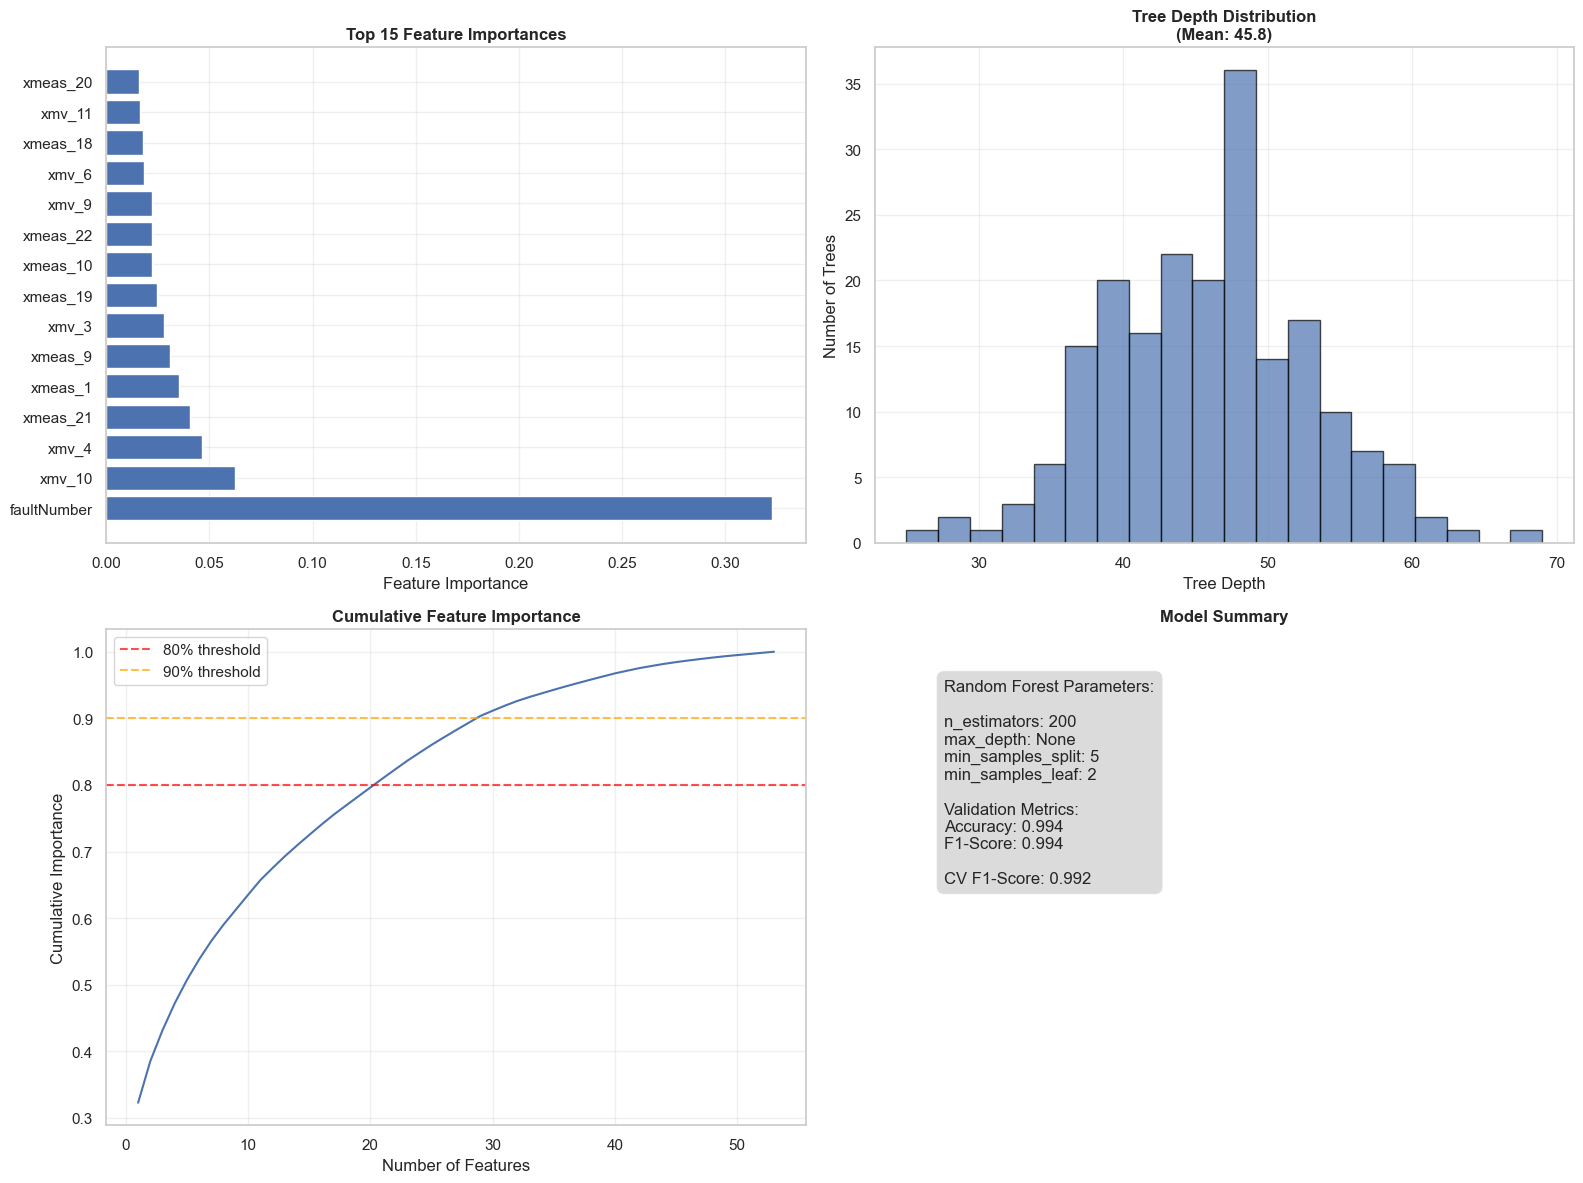

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

"""
Random Forest Classification
============================
Implement and evaluate Random Forest classifier with hyperparameter tuning.
"""

def train_random_forest_classifier(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_val: pd.DataFrame,
    y_val: np.ndarray,
    hyperparameter_tuning: bool = True,
    n_estimators_range: List[int] = [50, 100, 200],
    max_depth_range: List[int] = [10, 20, 30, None],
    min_samples_split_range: List[int] = [2, 5, 10],
    random_state: int = 42,
    n_jobs: int = -1
) -> Tuple[Any, Dict[str, Any]]:
    """
    Train Random Forest classifier with optional hyperparameter tuning.
    
    Args:
        X_train: Training features
        y_train: Training targets
        X_val: Validation features
        y_val: Validation targets
        hyperparameter_tuning: Whether to perform hyperparameter tuning
        n_estimators_range: Range of n_estimators to try
        max_depth_range: Range of max_depth to try
        min_samples_split_range: Range of min_samples_split to try
        random_state: Random seed
        n_jobs: Number of parallel jobs
        
    Returns:
        Tuple of (trained_model, training_info)
    """
    print("Training Random Forest Classifier")
    print("=" * 40)

    if hyperparameter_tuning:
        print("🔍 Performing hyperparameter tuning...")

        # Define parameter grid
        param_grid = {
            'n_estimators': n_estimators_range,
            'max_depth': max_depth_range,
            'min_samples_split': min_samples_split_range,
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

        print(f"Parameter grid size: {np.prod([len(v) for v in param_grid.values()])} combinations")

        # Base model
        rf_base = RandomForestClassifier(
            random_state=random_state,
            n_jobs=n_jobs,
            class_weight='balanced'
        )

        # Grid search with cross-validation
        grid_search = GridSearchCV(
            rf_base,
            param_grid,
            cv=3,
            scoring='f1_weighted',
            n_jobs=n_jobs,
            verbose=1
        )

        # Fit grid search
        grid_search.fit(X_train, y_train)

        # Get best model
        best_rf = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        print(f"✓ Best CV F1-score: {best_score:.3f}")
        print(f"✓ Best parameters:")
        for param, value in best_params.items():
            print(f"    {param}: {value}")

        training_info = {
            'method': 'grid_search',
            'best_params': best_params,
            'best_cv_score': best_score,
            'cv_results': grid_search.cv_results_
        }

    else:
        print("🚀 Training with default parameters...")

        # Default parameters (reasonably good for most cases)
        best_rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            bootstrap=True,
            random_state=random_state,
            n_jobs=n_jobs,
            class_weight='balanced'
        )

        best_rf.fit(X_train, y_train)

        training_info = {
            'method': 'default',
            'parameters': best_rf.get_params()
        }

    # Evaluate on validation set
    val_predictions = best_rf.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    val_f1 = f1_score(y_val, val_predictions, average='weighted')

    print(f"\n📊 Validation Performance:")
    print(f"  Accuracy: {val_accuracy:.3f}")
    print(f"  F1-Score: {val_f1:.3f}")

    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\n🔍 Top 10 Most Important Features:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")

    # Add validation metrics to training info
    training_info.update({
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1,
        'feature_importance': feature_importance.to_dict('records'),
        'model_params': best_rf.get_params()
    })

    return best_rf, training_info

def visualize_random_forest_analysis(model: RandomForestClassifier,
                                     training_info: Dict[str, Any],
                                     X_train: pd.DataFrame,
                                     save_plot_flag: bool = True) -> None:
    """
    Visualize Random Forest model analysis including feature importance and tree depth.
    
    Args:
        model: Trained Random Forest model
        training_info: Training information dictionary
        X_train: Training features for reference
        save_plot: Whether to save the generated plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Feature Importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    top_features = feature_importance.head(15)
    axes[0, 0].barh(range(len(top_features)), top_features['importance'])
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels(top_features['feature'])
    axes[0, 0].set_xlabel('Feature Importance')
    axes[0, 0].set_title('Top 15 Feature Importances', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Tree Depth Distribution
    tree_depths = [tree.tree_.max_depth for tree in model.estimators_]
    axes[0, 1].hist(tree_depths, bins=20, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Tree Depth')
    axes[0, 1].set_ylabel('Number of Trees')
    axes[0, 1].set_title(f'Tree Depth Distribution\n(Mean: {np.mean(tree_depths):.1f})', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Feature Importance Cumulative
    cumulative_importance = np.cumsum(feature_importance['importance'])
    axes[1, 0].plot(range(1, len(cumulative_importance) + 1), cumulative_importance)
    axes[1, 0].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% threshold')
    axes[1, 0].axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
    axes[1, 0].set_xlabel('Number of Features')
    axes[1, 0].set_ylabel('Cumulative Importance')
    axes[1, 0].set_title('Cumulative Feature Importance', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Model Parameters Summary
    axes[1, 1].axis('off')
    param_text = "Random Forest Parameters:\n\n"
    important_params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
    for param in important_params:
        if param in model.get_params():
            param_text += f"{param}: {model.get_params()[param]}\n"

    param_text += f"\nValidation Metrics:\n"
    param_text += f"Accuracy: {training_info.get('val_accuracy', 'N/A'):.3f}\n"
    param_text += f"F1-Score: {training_info.get('val_f1_score', 'N/A'):.3f}\n"

    if 'best_cv_score' in training_info:
        param_text += f"\nCV F1-Score: {training_info['best_cv_score']:.3f}"

    axes[1, 1].text(0.1, 0.9, param_text, transform=axes[1, 1].transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    axes[1, 1].set_title('Model Summary', fontweight='bold')

    plt.tight_layout()

    if save_plot_flag:
        save_plot("random_forest_analysis", suffix="detailed", plot_path="models")

    plt.show()

# Train Random Forest classifier
print("🌲 Training Random Forest Classifier")
rf_model, rf_training_info = train_random_forest_classifier(
    X_TRAIN, y_TRAIN,
    X_VAL, y_VAL,
    hyperparameter_tuning=True,
    random_state=42
)

# Visualize Random Forest analysis
visualize_random_forest_analysis(rf_model, rf_training_info, X_TRAIN)

print(f"\n✓ Random Forest model trained successfully")

## 🎯 Support Vector Machine Classification

Implement SVM classifier with kernel optimization and hyperparameter tuning for fault classification.

🎯 Training Support Vector Machine Classifier
Training Support Vector Machine Classifier
🔧 Scaling features...
🔍 Performing hyperparameter tuning...
Total parameter combinations: 36
⏳ This may take several minutes...
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Users/Khaled.Alabsi/projects/PhD_Project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Khaled.Alabsi/projects/PhD_Project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Khaled.Alabsi/projects/PhD_Project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Khaled.Alabsi/projects/PhD_Project/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

✓ Best CV F1-score: 0.999
✓ Best parameters:
    C: 100
    kernel: linear

📊 Validation Performance:
  Accuracy: 0.999
  F1-Score: 0.999
  Support Vectors: [269  36  24 496 236 132  16  67 484 555 546 562 532 539 560 568 559 213
 125 561 275]
  Total Support Vectors: 7355


TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

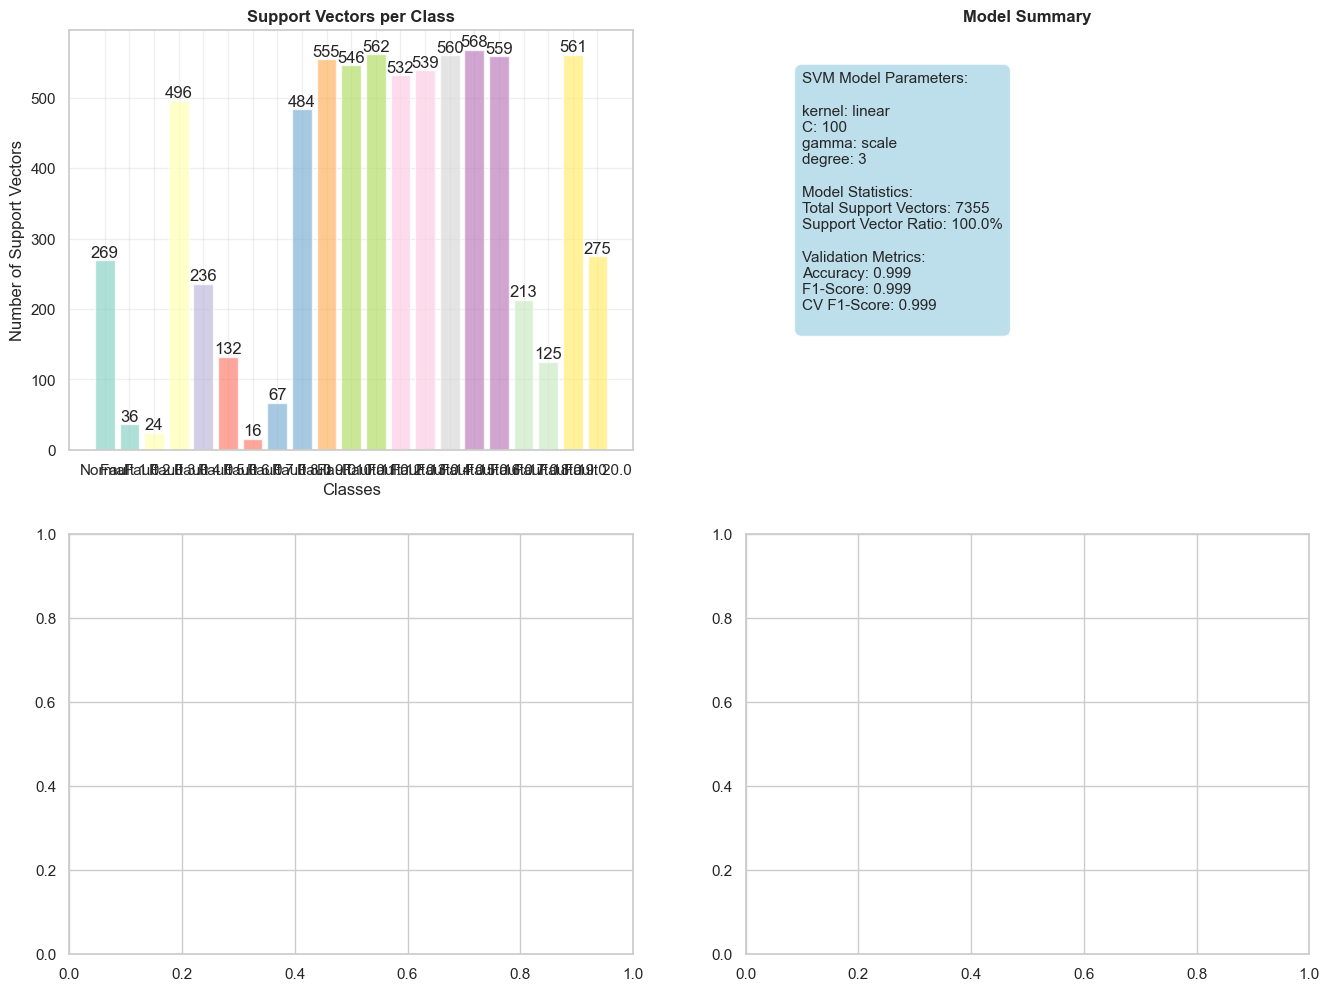

In [ ]:
# Required imports
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Tuple

"""
Support Vector Machine Classification
=====================================
Implement SVM classifier with kernel optimization and comprehensive hyperparameter tuning.
"""

def train_svm_classifier(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_val: pd.DataFrame,
    y_val: np.ndarray,
    hyperparameter_tuning: bool = True,
    kernels_to_test: List[str] = ['rbf', 'poly', 'linear'],
    c_range: List[float] = [0.1, 1, 10, 100],
    gamma_range: List[str] = ['scale', 'auto'],
    max_iter: int = 10000,
    random_state: int = 42
) -> Tuple[Any, Dict[str, Any]]:
    """
    Train SVM classifier with optional hyperparameter tuning.
    
    Args:
        X_train: Training features
        y_train: Training targets
        X_val: Validation features
        y_val: Validation targets
        hyperparameter_tuning: Whether to perform hyperparameter tuning
        kernels_to_test: List of kernels to evaluate
        c_range: Range of C (regularization) values to try
        gamma_range: Range of gamma values to try
        max_iter: Maximum iterations for SVM solver
        random_state: Random seed
        
    Returns:
        Tuple of (trained_model, training_info)
    """
    print("Training Support Vector Machine Classifier")
    print("=" * 50)

    # Scale features for SVM (important for SVM performance)
    print("🔧 Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    if hyperparameter_tuning:
        print("🔍 Performing hyperparameter tuning...")

        # Define parameter grid
        param_grid = []

        for kernel in kernels_to_test:
            if kernel == 'linear':
                # Linear kernel doesn't use gamma
                param_grid.append({
                    'kernel': [kernel],
                    'C': c_range
                })
            elif kernel == 'poly':
                # Polynomial kernel uses gamma and degree
                param_grid.append({
                    'kernel': [kernel],
                    'C': c_range,
                    'gamma': gamma_range,
                    'degree': [2, 3, 4]
                })
            else:  # rbf, sigmoid
                # RBF and sigmoid kernels use gamma
                param_grid.append({
                    'kernel': [kernel],
                    'C': c_range,
                    'gamma': gamma_range
                })

        total_combinations = sum(
            np.prod([len(v) for v in grid.values()]) for grid in param_grid
        )
        print(f"Total parameter combinations: {total_combinations}")

        # Base SVM model
        svm_base = SVC(
            random_state=random_state,
            max_iter=max_iter,
            class_weight='balanced',
            probability=True  # Enable probability estimates
        )

        # Grid search with cross-validation
        grid_search = GridSearchCV(
            svm_base,
            param_grid,
            cv=3,
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=1
        )

        # Fit grid search
        print("⏳ This may take several minutes...")
        grid_search.fit(X_train_scaled, y_train)

        # Get best model
        best_svm = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        print(f"✓ Best CV F1-score: {best_score:.3f}")
        print(f"✓ Best parameters:")
        for param, value in best_params.items():
            print(f"    {param}: {value}")

        training_info = {
            'method': 'grid_search',
            'best_params': best_params,
            'best_cv_score': best_score,
            'cv_results': grid_search.cv_results_,
            'scaler': scaler
        }

    else:
        print("🚀 Training with default RBF kernel...")

        # Default SVM with RBF kernel
        best_svm = SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            random_state=random_state,
            max_iter=max_iter,
            class_weight='balanced',
            probability=True
        )

        best_svm.fit(X_train_scaled, y_train)

        training_info = {
            'method': 'default',
            'parameters': best_svm.get_params(),
            'scaler': scaler
        }

    # Evaluate on validation set
    val_predictions = best_svm.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, val_predictions)
    val_f1 = f1_score(y_val, val_predictions, average='weighted')

    print(f"\n📊 Validation Performance:")
    print(f"  Accuracy: {val_accuracy:.3f}")
    print(f"  F1-Score: {val_f1:.3f}")
    print(f"  Support Vectors: {best_svm.n_support_}")
    print(f"  Total Support Vectors: {sum(best_svm.n_support_)}")

    # Add validation metrics to training info
    training_info.update({
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1,
        'n_support_vectors': best_svm.n_support_.tolist(),
        'total_support_vectors': sum(best_svm.n_support_),
        'model_params': best_svm.get_params()
    })

    return best_svm, training_info

def visualize_svm_analysis(
    model: SVC,
    training_info: Dict[str, Any],
    class_names: Dict[int, str],
    save_plot_flag: bool = True
) -> None:
    """
    Visualize SVM model analysis including support vectors and decision boundaries.
    
    Args:
        model: Trained SVM model
        training_info: Training information dictionary
        class_names: Mapping from class indices to names
        save_plot: Whether to save the generated plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Support Vectors Distribution
    n_support = training_info['n_support_vectors']
    class_labels = [class_names.get(i, f'Class {i}') for i in range(len(n_support))]

    colors = plt.cm.Set3(np.linspace(0, 1, len(class_labels)))
    bars = axes[0, 0].bar(class_labels, n_support, color=colors, alpha=0.7)
    axes[0, 0].set_title('Support Vectors per Class', fontweight='bold')
    axes[0, 0].set_xlabel('Classes')
    axes[0, 0].set_ylabel('Number of Support Vectors')
    axes[0, 0].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, n_support):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       str(value), ha='center', va='bottom')

    # 2. Model Parameters Summary
    axes[0, 1].axis('off')
    param_text = "SVM Model Parameters:\n\n"

    important_params = ['kernel', 'C', 'gamma', 'degree']
    for param in important_params:
        if param in model.get_params():
            value = model.get_params()[param]
            param_text += f"{param}: {value}\n"

    param_text += f"\nModel Statistics:\n"
    param_text += f"Total Support Vectors: {training_info['total_support_vectors']}\n"
    param_text += f"Support Vector Ratio: {training_info['total_support_vectors']/len(model.support_):.1%}\n"

    param_text += f"\nValidation Metrics:\n"
    param_text += f"Accuracy: {training_info.get('val_accuracy', 'N/A'):.3f}\n"
    param_text += f"F1-Score: {training_info.get('val_f1_score', 'N/A'):.3f}\n"

    if 'best_cv_score' in training_info:
        param_text += f"CV F1-Score: {training_info['best_cv_score']:.3f}\n"

    axes[0, 1].text(0.1, 0.9, param_text, transform=axes[0, 1].transAxes,
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    axes[0, 1].set_title('Model Summary', fontweight='bold')

    # 3. Support Vector Percentage by Class
    total_samples_per_class = np.bincount(model.classes_)  # Approximate
    sv_percentages = [sv/total for sv, total in zip(n_support, total_samples_per_class)]

    axes[1, 0].bar(class_labels, sv_percentages, color=colors, alpha=0.7)
    axes[1, 0].set_title('Support Vector Percentage by Class', fontweight='bold')
    axes[1, 0].set_xlabel('Classes')
    axes[1, 0].set_ylabel('Support Vector Percentage')
    axes[1, 0].grid(True, alpha=0.3)

    # Format y-axis as percentage
    axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

    # 4. Hyperparameter Comparison (if grid search was used)
    if training_info.get('method') == 'grid_search' and 'cv_results' in training_info:
        cv_results = training_info['cv_results']

        # Extract kernel performance
        kernel_scores = {}
        for i, params in enumerate(cv_results['params']):
            kernel = params['kernel']
            score = cv_results['mean_test_score'][i]
            if kernel not in kernel_scores:
                kernel_scores[kernel] = []
            kernel_scores[kernel].append(score)

        # Plot kernel comparison
        kernels = list(kernel_scores.keys())
        mean_scores = [np.mean(scores) for scores in kernel_scores.values()]
        std_scores = [np.std(scores) for scores in kernel_scores.values()]

        bars = axes[1, 1].bar(kernels, mean_scores, yerr=std_scores,
                             capsize=5, alpha=0.7, color='skyblue')
        axes[1, 1].set_title('Kernel Performance Comparison', fontweight='bold')
        axes[1, 1].set_xlabel('Kernel Type')
        axes[1, 1].set_ylabel('CV F1-Score')
        axes[1, 1].grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, score in zip(bars, mean_scores):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{score:.3f}', ha='center', va='bottom')
    else:
        axes[1, 1].axis('off')
        axes[1, 1].text(0.5, 0.5, 'No hyperparameter\ntuning performed',
                       transform=axes[1, 1].transAxes, ha='center', va='center',
                       fontsize=14, style='italic')

    plt.tight_layout()

    if save_plot_flag:
        save_plot("svm_analysis", suffix="detailed", plot_path="models")

    plt.show()

# Train SVM classifier
print("🎯 Training Support Vector Machine Classifier")
svm_model, svm_training_info = train_svm_classifier(
    X_TRAIN, y_TRAIN.astype(int),
    X_VAL, y_VAL.astype(int),
    hyperparameter_tuning=True,
    kernels_to_test=['rbf', 'linear', 'poly'],
    random_state=42
)

# Visualize SVM analysis
visualize_svm_analysis(
    svm_model,
    svm_training_info,
    classification_data['class_names']
)

print(f"\n✓ SVM model trained successfully")

## LightGBM Classification



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
⚡ Training LightGBM Classifier
Training LightGBM Classifier
🚀 Training with default parameters...
🏋️ Training final model...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[143]	train's multi_logloss: 0.000285665	val's multi_logloss: 0.000305576

📊 Validation Performance:
  Accuracy: 1.000
  F1-Score: 1.000
  Best iteration: 143
  Total iterations: 3003

🔍 Top 10 Most Important Features (by gain):
   1. faultNumber         :   228761
   2. xmeas_1             :    21558
   3. xmv_4               :     9879
   4. xmeas_10            :     9714
   5. xmv_10              :     9502
   6. xmeas_21            :     5577
   7. xmeas_9             :     5358
   8. xmeas_7             :     4916
   9. xmv_6               :     3508
  10. xmeas_19            :     1780
✓ P

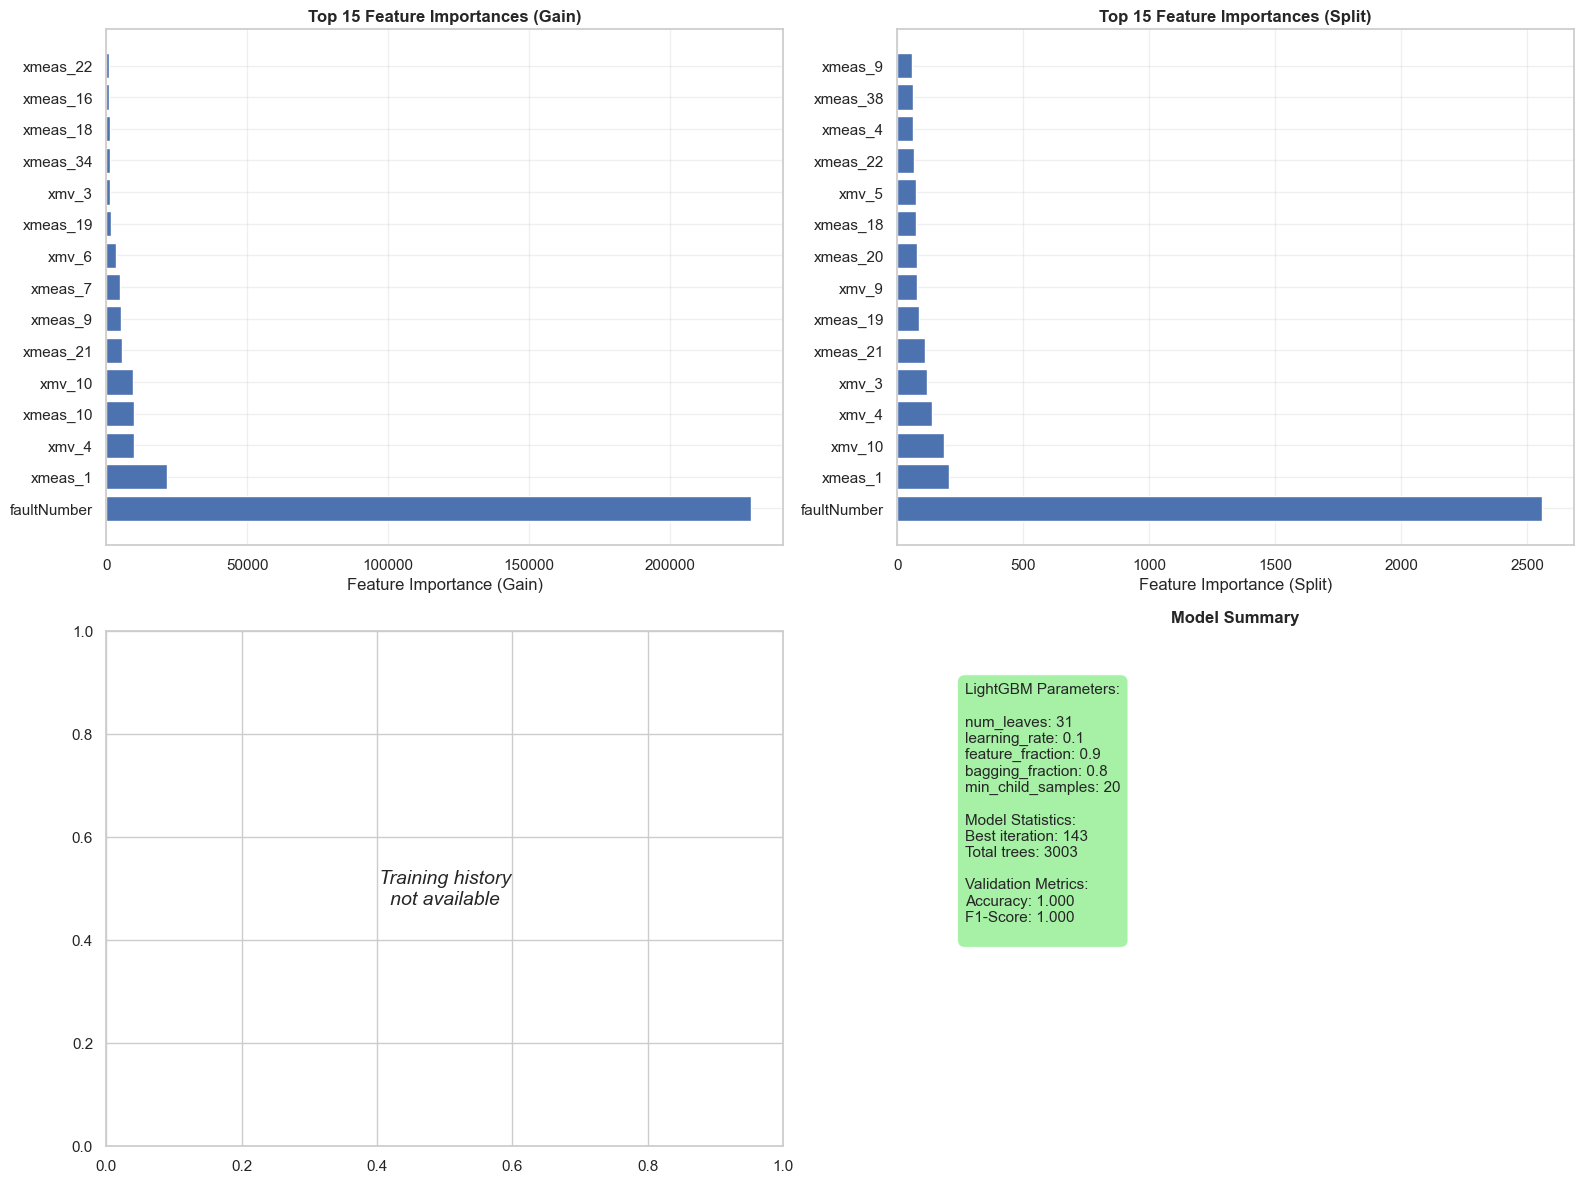


✓ LightGBM model trained successfully


In [90]:
%pip install optuna --quiet

"""
LightGBM Classification
======================
Implement LightGBM classifier with hyperparameter optimization and feature importance analysis.
"""
import lightgbm as lgb
import optuna
from sympy import false

def train_lightgbm_classifier(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_val: pd.DataFrame,
    y_val: np.ndarray,
    hyperparameter_tuning: bool = True,
    use_early_stopping: bool = True,
    num_boost_round: int = 1000,
    early_stopping_rounds: int = 50,
    random_state: int = 42
) -> Tuple[Any, Dict[str, Any]]:
    """
    Train LightGBM classifier with hyperparameter tuning and early stopping.
    
    Args:
        X_train: Training features
        y_train: Training targets
        X_val: Validation features
        y_val: Validation targets
        hyperparameter_tuning: Whether to perform hyperparameter tuning
        use_early_stopping: Whether to use early stopping
        num_boost_round: Maximum number of boosting rounds
        early_stopping_rounds: Early stopping patience
        random_state: Random seed
        
    Returns:
        Tuple of (trained_model, training_info)
    """
    print("Training LightGBM Classifier")
    print("=" * 40)

    # Prepare LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Base parameters
    base_params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'random_state': random_state,
        'verbosity': -1,
        'class_weight': 'balanced',
        'feature_pre_filter': False  # Fix for Optuna dynamic min_child_samples
    }

    if hyperparameter_tuning:
        print("🔍 Performing hyperparameter tuning with Optuna...")

        def objective(trial):
            # Define hyperparameter search space
            params = base_params.copy()
            params.update({
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            })

            # Train model with cross-validation
            cv_results = lgb.cv(
                params,
                train_data,
                num_boost_round=500,
                nfold=3,
                stratified=True,
                shuffle=True,
                seed=random_state,
                return_cvbooster=False,
                eval_train_metric=False
            )

            # Return the best validation score
            return min(cv_results['valid multi_logloss-mean'])

        # Run optimization
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=50)

        # Get best parameters
        best_params = base_params.copy()
        best_params.update(study.best_params)

        print(f"✓ Best trial score: {study.best_value:.4f}")
        print(f"✓ Best parameters:")
        for param, value in study.best_params.items():
            print(f"    {param}: {value}")

        training_info = {
            'method': 'optuna',
            'best_params': best_params,
            'best_score': study.best_value,
            'study': study
        }

    else:
        print("🚀 Training with default parameters...")

        best_params = base_params.copy()
        best_params.update({
            'num_leaves': 31,
            'learning_rate': 0.1,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'min_child_samples': 20,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
        })

        training_info = {
            'method': 'default',
            'best_params': best_params
        }

    # Train final model
    print("🏋️ Training final model...")

    callbacks = []
    if use_early_stopping:
        callbacks.append(lgb.early_stopping(early_stopping_rounds))
        callbacks.append(lgb.log_evaluation(0))  # Silent logging

    model = lgb.train(
        best_params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        num_boost_round=num_boost_round,
        callbacks=callbacks
    )

    # Evaluate on validation set
    val_predictions = model.predict(X_val, num_iteration=model.best_iteration)
    val_pred_classes = np.argmax(val_predictions, axis=1)
    val_accuracy = accuracy_score(y_val, val_pred_classes)
    val_f1 = f1_score(y_val, val_pred_classes, average='weighted')

    print(f"\n📊 Validation Performance:")
    print(f"  Accuracy: {val_accuracy:.3f}")
    print(f"  F1-Score: {val_f1:.3f}")
    print(f"  Best iteration: {model.best_iteration}")
    print(f"  Total iterations: {model.num_trees()}")

    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importance(importance_type='gain'),
        'split_importance': model.feature_importance(importance_type='split')
    }).sort_values('importance', ascending=False)

    print(f"\n🔍 Top 10 Most Important Features (by gain):")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"  {i+1:2d}. {row['feature']:20s}: {row['importance']:8.0f}")

    # Add validation metrics to training info
    training_info.update({
        'val_accuracy': val_accuracy,
        'val_f1_score': val_f1,
        'best_iteration': model.best_iteration,
        'num_trees': model.num_trees(),
        'feature_importance': feature_importance.to_dict('records'),
        'model_params': best_params
    })

    return model, training_info

def visualize_lightgbm_analysis(
    model: lgb.LGBMModel,
    training_info: Dict[str, Any],
    X_train: pd.DataFrame,
    save_plot_flag: bool = True
) -> None:
    """
    Visualize LightGBM model analysis including feature importance and training progress.
    
    Args:
        model: Trained LightGBM model
        training_info: Training information dictionary
        X_train: Training features for reference
        save_plot: Whether to save the generated plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Feature Importance (Gain)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)

    top_features = feature_importance.head(15)
    axes[0, 0].barh(range(len(top_features)), top_features['importance'])
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels(top_features['feature'])
    axes[0, 0].set_xlabel('Feature Importance (Gain)')
    axes[0, 0].set_title('Top 15 Feature Importances (Gain)', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Feature Importance (Split)
    split_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importance(importance_type='split')
    }).sort_values('importance', ascending=False)

    top_splits = split_importance.head(15)
    axes[0, 1].barh(range(len(top_splits)), top_splits['importance'])
    axes[0, 1].set_yticks(range(len(top_splits)))
    axes[0, 1].set_yticklabels(top_splits['feature'])
    axes[0, 1].set_xlabel('Feature Importance (Split)')
    axes[0, 1].set_title('Top 15 Feature Importances (Split)', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Training History
    if hasattr(model, 'evals_result_') and model.evals_result_:
        train_scores = model.evals_result_['train']['multi_logloss']
        val_scores = model.evals_result_['val']['multi_logloss']

        iterations = range(1, len(train_scores) + 1)
        axes[1, 0].plot(iterations, train_scores, label='Training', alpha=0.8)
        axes[1, 0].plot(iterations, val_scores, label='Validation', alpha=0.8)

        # Mark best iteration
        best_iter = training_info.get('best_iteration', len(train_scores))
        if best_iter <= len(val_scores):
            axes[1, 0].axvline(x=best_iter, color='red', linestyle='--',
                              label=f'Best Iteration ({best_iter})')

        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Log Loss')
        axes[1, 0].set_title('Training Progress', fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Training history\nnot available',
                       transform=axes[1, 0].transAxes, ha='center', va='center',
                       fontsize=14, style='italic')

    # 4. Model Parameters Summary
    axes[1, 1].axis('off')
    param_text = "LightGBM Parameters:\n\n"

    important_params = ['num_leaves', 'learning_rate', 'feature_fraction',
                       'bagging_fraction', 'min_child_samples']
    for param in important_params:
        if param in training_info.get('best_params', {}):
            value = training_info['best_params'][param]
            param_text += f"{param}: {value}\n"

    param_text += f"\nModel Statistics:\n"
    param_text += f"Best iteration: {training_info.get('best_iteration', 'N/A')}\n"
    param_text += f"Total trees: {training_info.get('num_trees', 'N/A')}\n"

    param_text += f"\nValidation Metrics:\n"
    param_text += f"Accuracy: {training_info.get('val_accuracy', 'N/A'):.3f}\n"
    param_text += f"F1-Score: {training_info.get('val_f1_score', 'N/A'):.3f}\n"

    if 'best_score' in training_info:
        param_text += f"CV Log Loss: {training_info['best_score']:.4f}\n"

    axes[1, 1].text(0.1, 0.9, param_text, transform=axes[1, 1].transAxes,
                   fontsize=11, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
    axes[1, 1].set_title('Model Summary', fontweight='bold')

    plt.tight_layout()

    if save_plot_flag:
        save_plot("lightgbm_analysis", suffix="detailed", plot_path="models")

    plt.show()

# Train LightGBM classifier
print("⚡ Training LightGBM Classifier")
lgb_model, lgb_training_info = train_lightgbm_classifier(
    X_TRAIN, y_TRAIN,
    X_VAL, y_VAL,
    hyperparameter_tuning=False,
    use_early_stopping=True,
    random_state=42
)

# Visualize LightGBM analysis
visualize_lightgbm_analysis(lgb_model, lgb_training_info, X_TRAIN)

print(f"\n✓ LightGBM model trained successfully")

## 📊 Model Comparison and Evaluation

Compare all trained models and select the best performing classifier for fault detection.

📋 Preparing models for comparison...
Models to compare: ['Random Forest', 'SVM', 'LightGBM']
Evaluating All Classification Models

🔍 Evaluating Random Forest...
Evaluating Random Forest

📊 Random Forest Performance Summary:
  Accuracy:  0.991
  Precision: 0.991 (weighted)
  Recall:    0.991 (weighted)
  F1-Score:  0.991 (weighted)

📋 Per-Class Performance:
  Normal      : P=1.000, R=1.000, F1=1.000, Support=100
  Fault 1.0   : P=1.000, R=0.989, F1=0.995, Support=190
  Fault 2.0   : P=0.995, R=1.000, F1=0.997, Support=190
  Fault 3.0   : P=0.995, R=1.000, F1=0.997, Support=190
  Fault 4.0   : P=1.000, R=1.000, F1=1.000, Support=190
  Fault 5.0   : P=0.995, R=1.000, F1=0.997, Support=190
  Fault 6.0   : P=1.000, R=1.000, F1=1.000, Support=190
  Fault 7.0   : P=1.000, R=1.000, F1=1.000, Support=190
  Fault 8.0   : P=1.000, R=0.979, F1=0.989, Support=190
  Fault 9.0   : P=0.979, R=0.974, F1=0.976, Support=190
  Fault 10.0  : P=0.936, R=0.995, F1=0.964, Support=190
  Fault 11.0  : P=0.990, 

TypeError: Invalid shape () for image data

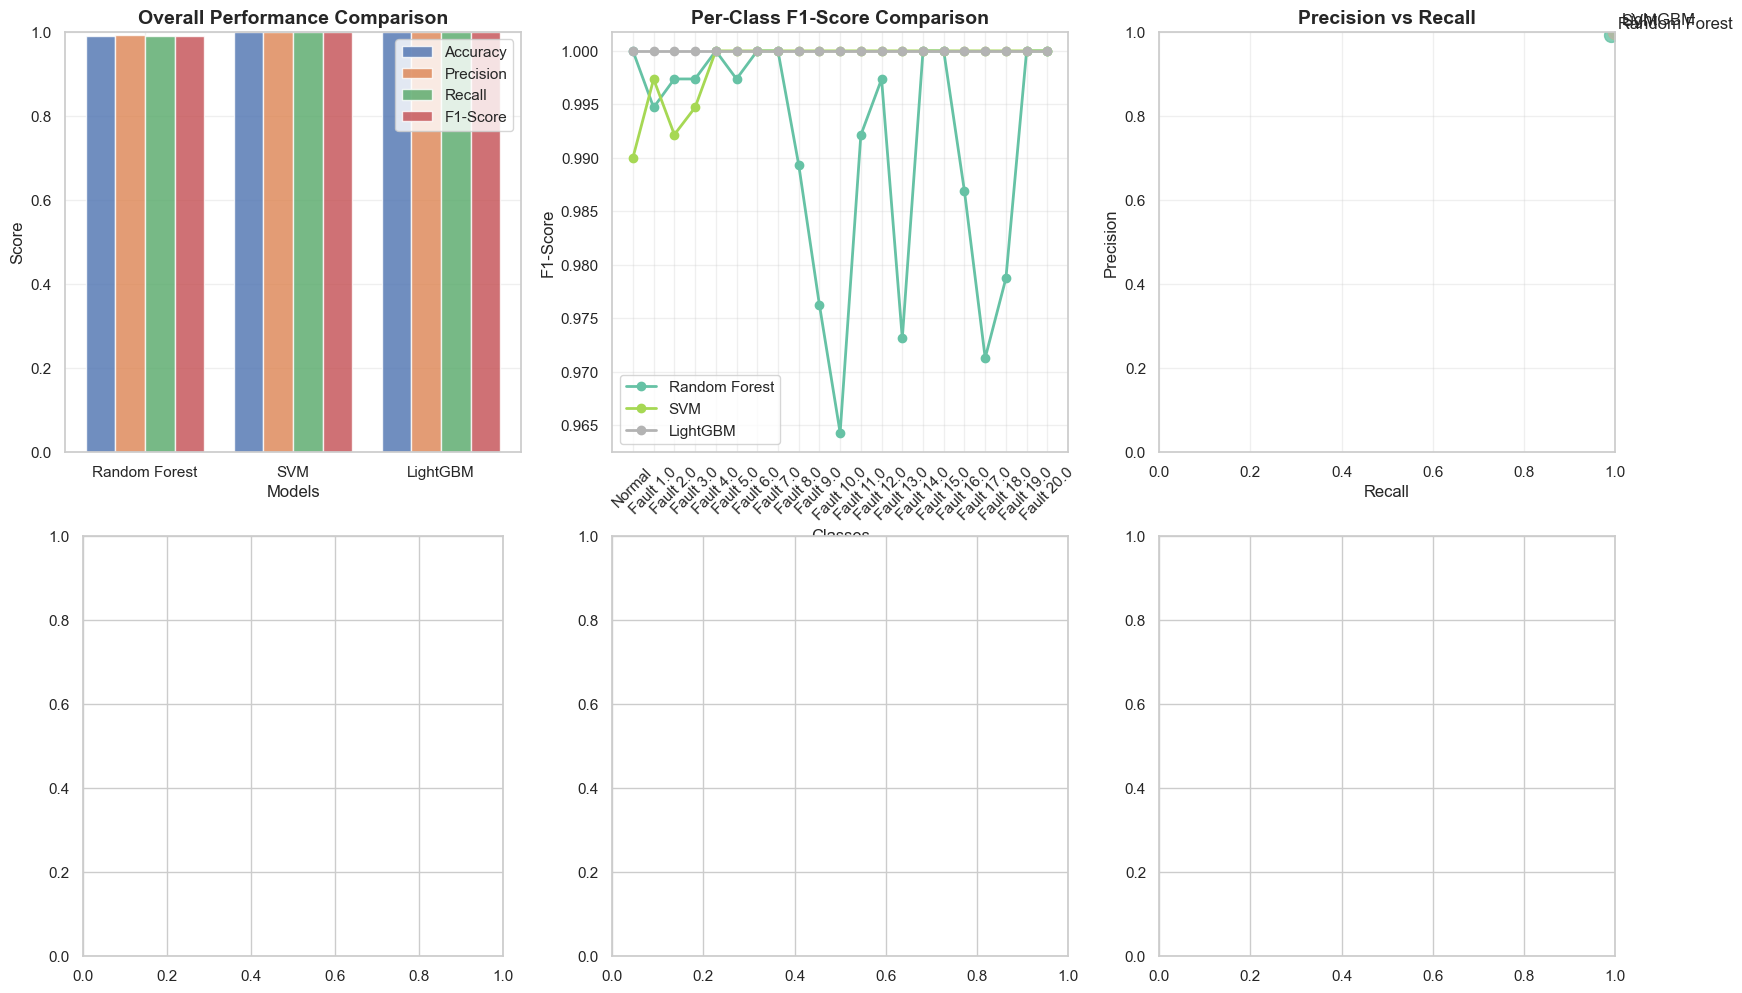

In [95]:
from sklearn.metrics import precision_score, recall_score

"""
Model Comparison Framework
=========================
Comprehensive comparison of all trained classification models.
"""

def evaluate_all_models(
    models: Dict[str, Any],
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    class_names: Dict[int, str],
    save_results: bool = True
) -> Dict[str, Dict[str, Any]]:
    """
    Evaluate all models and create comprehensive comparison.
    
    Args:
        models: Dictionary of model_name -> model_object
        X_test: Test features
        y_test: Test targets
        class_names: Mapping from class indices to names
        save_results: Whether to save results and plots
        
    Returns:
        Dictionary containing evaluation results for all models
    """
    print("Evaluating All Classification Models")
    print("=" * 50)
    
    all_results = {}
    
    # Evaluate each model
    for model_name, model in models.items():
        print(f"\n🔍 Evaluating {model_name}...")
        
        # Handle different model types
        if model_name == "SVM" and 'scaler' in svm_training_info:
            # SVM needs scaled features
            X_test_scaled = svm_training_info['scaler'].transform(X_test)
            results = evaluate_classification_model(
                model, X_test_scaled, y_test, model_name, 
                class_names, save_results=False, show_plots=False
            )
        elif model_name == "LightGBM":
            # LightGBM predict returns probabilities, need to convert
            class LGBWrapper:
                def __init__(self, lgb_model):
                    self.lgb_model = lgb_model
                
                def predict(self, X):
                    probas = self.lgb_model.predict(X, num_iteration=self.lgb_model.best_iteration)
                    return np.argmax(probas, axis=1)
                
                def predict_proba(self, X):
                    probas = self.lgb_model.predict(X, num_iteration=self.lgb_model.best_iteration)
                    return probas
            
            wrapped_model = LGBWrapper(model)
            results = evaluate_classification_model(
                wrapped_model, X_test, y_test, model_name,
                class_names, save_results=False, show_plots=False
            )
        else:
            # Standard sklearn models
            results = evaluate_classification_model(
                model, X_test, y_test, model_name,
                class_names, save_results=False, show_plots=False
            )
        
        all_results[model_name] = results
    
    # Create comparison visualizations
    create_model_comparison_plots(all_results, class_names, save_results)
    
    # Print comparison summary
    print_model_comparison_summary(all_results)
    
    # Save consolidated results
    if save_results:
        save_model_comparison_results(all_results)
    
    return all_results

def create_model_comparison_plots(
    all_results: Dict[str, Dict[str, Any]],
    class_names: Dict[int, str],
    save_results: bool = True
) -> None:
    """Create comprehensive comparison plots for all models."""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    model_names = list(all_results.keys())
    colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))
    
    # 1. Overall Performance Comparison
    metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    x = np.arange(len(model_names))
    width = 0.2
    
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        values = [all_results[model]['metrics'][metric] for model in model_names]
        axes[0].bar(x + i*width, values, width, label=label, alpha=0.8)
    
    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Overall Performance Comparison', fontweight='bold', fontsize=14)
    axes[0].set_xticks(x + width * 1.5)
    axes[0].set_xticklabels(model_names)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1)
    
    # 2. Per-Class F1-Score Comparison
    classes = sorted(class_names.keys())
    class_labels = [class_names[c] for c in classes]
    
    for i, model_name in enumerate(model_names):
        f1_scores = []
        for class_id in classes:
            class_name = class_names[class_id]
            f1_score = all_results[model_name]['per_class_metrics'][class_name]['f1-score']
            f1_scores.append(f1_score)
        
        axes[1].plot(class_labels, f1_scores, marker='o', linewidth=2, 
                    label=model_name, color=colors[i])
    
    axes[1].set_xlabel('Classes')
    axes[1].set_ylabel('F1-Score')
    axes[1].set_title('Per-Class F1-Score Comparison', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    # 3. Precision vs Recall Scatter
    for i, model_name in enumerate(model_names):
        precision = all_results[model_name]['metrics']['precision_weighted']
        recall = all_results[model_name]['metrics']['recall_weighted']
        axes[2].scatter(recall, precision, s=100, label=model_name, 
                       color=colors[i], alpha=0.8)
        axes[2].annotate(model_name, (recall, precision), 
                        xytext=(5, 5), textcoords='offset points')
    
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision vs Recall', fontweight='bold', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(0, 1)
    
    # 4. Confusion Matrix Comparison (show best model)
    best_model = max(all_results.keys(), 
                    key=lambda x: all_results[x]['metrics']['f1_weighted'])
    # Ensure confusion matrix is a numeric numpy array
    cm = np.array(all_results[best_model]['confusion_matrix'], dtype=float)
    
    im = axes[3].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[3].set_title(f'Confusion Matrix - {best_model}\n(Best F1-Score)', 
                     fontweight='bold', fontsize=14)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[3].text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    
    axes[3].set_xlabel('Predicted')
    axes[3].set_ylabel('Actual')
    tick_marks = np.arange(len(class_names))
    axes[3].set_xticks(tick_marks)
    axes[3].set_yticks(tick_marks)
    axes[3].set_xticklabels([class_names[i] for i in sorted(class_names.keys())], rotation=45)
    axes[3].set_yticklabels([class_names[i] for i in sorted(class_names.keys())])
    
    # 5. Model Performance Ranking
    ranking_metrics = ['accuracy', 'f1_weighted']
    rankings = {}
    
    for metric in ranking_metrics:
        sorted_models = sorted(model_names, 
                             key=lambda x: all_results[x]['metrics'][metric], 
                             reverse=True)
        for rank, model in enumerate(sorted_models):
            if model not in rankings:
                rankings[model] = []
            rankings[model].append(rank + 1)
    
    avg_rankings = {model: np.mean(ranks) for model, ranks in rankings.items()}
    sorted_models = sorted(avg_rankings.keys(), key=lambda x: avg_rankings[x])
    
    bars = axes[4].barh(range(len(sorted_models)), 
                       [avg_rankings[model] for model in sorted_models],
                       color=colors[:len(sorted_models)])
    axes[4].set_yticks(range(len(sorted_models)))
    axes[4].set_yticklabels(sorted_models)
    axes[4].set_xlabel('Average Rank')
    axes[4].set_title('Model Performance Ranking\n(Lower is Better)', fontweight='bold', fontsize=14)
    axes[4].grid(True, alpha=0.3)
    
    # Add rank values on bars
    for i, (bar, model) in enumerate(zip(bars, sorted_models)):
        axes[4].text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                    f'{avg_rankings[model]:.1f}', va='center')
    
    # 6. Performance Summary Table
    axes[5].axis('off')
    
    # Create performance summary
    summary_data = []
    for model_name in model_names:
        metrics = all_results[model_name]['metrics']
        summary_data.append([
            model_name,
            f"{metrics['accuracy']:.3f}",
            f"{metrics['precision_weighted']:.3f}",
            f"{metrics['recall_weighted']:.3f}",
            f"{metrics['f1_weighted']:.3f}"
        ])
    
    table = axes[5].table(cellText=summary_data,
                         colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.2, 0.15, 0.15, 0.15, 0.15])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Highlight best model
    best_f1_idx = max(range(len(summary_data)), 
                     key=lambda x: float(summary_data[x][4])) + 1  # +1 for header
    
    for j in range(5):
        table[(best_f1_idx, j)].set_facecolor('#90EE90')  # Light green
    
    axes[5].set_title('Performance Summary', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    
    if save_results:
        save_plot("model_comparison", suffix="comprehensive", plot_path="models")
    
    plt.show()

def print_model_comparison_summary(all_results: Dict[str, Dict[str, Any]]) -> None:
    """Print detailed comparison summary."""
    
    print("\n" + "=" * 80)
    print("🏆 MODEL COMPARISON SUMMARY")
    print("=" * 80)
    
    # Overall ranking by F1-score
    ranked_models = sorted(all_results.keys(), 
                          key=lambda x: all_results[x]['metrics']['f1_weighted'], 
                          reverse=True)
    
    print(f"\n📊 Overall Ranking (by F1-Score):")
    for i, model_name in enumerate(ranked_models):
        f1_score = all_results[model_name]['metrics']['f1_weighted']
        accuracy = all_results[model_name]['metrics']['accuracy']
        print(f"  {i+1}. {model_name:15s}: F1={f1_score:.3f}, Accuracy={accuracy:.3f}")
    
    # Best model details
    best_model = ranked_models[0]
    best_results = all_results[best_model]
    
    print(f"\n🥇 Best Performing Model: {best_model}")
    print(f"   Accuracy:  {best_results['metrics']['accuracy']:.3f}")
    print(f"   Precision: {best_results['metrics']['precision_weighted']:.3f}")
    print(f"   Recall:    {best_results['metrics']['recall_weighted']:.3f}")
    print(f"   F1-Score:  {best_results['metrics']['f1_weighted']:.3f}")
    
    # Performance differences
    print(f"\n📈 Performance Gaps:")
    best_f1 = best_results['metrics']['f1_weighted']
    for model_name in ranked_models[1:]:
        f1_score = all_results[model_name]['metrics']['f1_weighted']
        gap = best_f1 - f1_score
        print(f"   {model_name} is {gap:.3f} points behind {best_model}")

def save_model_comparison_results(all_results: Dict[str, Dict[str, Any]]) -> None:
    """Save model comparison results to file."""
    
    results_path = Path(RESULTS_BASE_PATH) / "models" / "model_comparison_results.json"
    results_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Convert results for JSON serialization
    json_results = convert_numpy_types(all_results)
    
    with open(results_path, 'w') as f:
        json.dump(json_results, f, indent=2)
    
    print(f"\n💾 Comparison results saved to: {results_path}")

# Prepare models dictionary
print("📋 Preparing models for comparison...")
models_to_compare = {
    "Random Forest": rf_model,
    "SVM": svm_model,
    "LightGBM": lgb_model
}

print(f"Models to compare: {list(models_to_compare.keys())}")

# Run comprehensive evaluation
comparison_results = evaluate_all_models(
    models_to_compare,
    X_TEST,
    y_TEST,
    classification_data['class_names'],
    save_results=True
)

print("\n✅ Model comparison completed!")

In [ ]:
# Plotting the correlation matrix with a threshold
# Set correlation threshold
threshold: float = 0.95

# Load the data into a pandas DataFrame
data: pd.DataFrame = DF_FF_TRAINING_RAW[DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] ==
                                    1].iloc[:, 3:]

# Calculate correlation matrix
corr: pd.DataFrame = data.corr()

# Remove self-correlation (diagonal only)
corr_abs: pd.DataFrame = corr.abs().copy()
np.fill_diagonal(corr_abs.values, 0.0)

# Identify features with any correlation above threshold
selected_features: set[str] = set(corr_abs.columns[(corr_abs
                                                    > threshold).any()])
selected_features_list: list[str] = sorted(selected_features)

# Filter correlation matrix to only those features
filtered_corr: pd.DataFrame = corr.loc[selected_features_list,
                                       selected_features_list]

# Plot heatmap
sns.set_theme(style="white")
mask: np.ndarray = np.triu(np.ones_like(filtered_corr, dtype=bool))

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    filtered_corr,
    mask=mask,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title(f"Correlation Matrix (|corr| > {threshold})")
plt.tight_layout()
plt.show()


# 🚨 Anomaly Detection Analysis

Unsupervised anomaly detection methods for identifying abnormal operation patterns without labeled fault data.

In [ ]:
"""
PCA-based Anomaly Detection
===========================
Implement Principal Component Analysis for unsupervised anomaly detection.
"""

def train_pca_anomaly_detector(
    X_normal: pd.DataFrame,
    n_components: Optional[int] = None,
    variance_threshold: float = 0.95,
    contamination: float = 0.1,
    random_state: int = 42
) -> Tuple[Any, Any, Dict[str, Any]]:
    """
    Train PCA-based anomaly detector using normal operation data.
    
    Args:
        X_normal: Normal operation data for training
        n_components: Number of PCA components (if None, determined by variance_threshold)
        variance_threshold: Cumulative variance to retain when n_components is None
        contamination: Expected proportion of anomalies in data
        random_state: Random seed
        
    Returns:
        Tuple of (pca_model, scaler, training_info)
    """
    print("Training PCA-based Anomaly Detector")
    print("=" * 45)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_normal)
    
    print(f"Original feature space: {X_normal.shape[1]} dimensions")
    
    # Determine optimal number of components
    if n_components is None:
        # Use variance threshold to determine components
        pca_full = PCA()
        pca_full.fit(X_scaled)
        
        cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
        n_components = np.argmax(cumsum_variance >= variance_threshold) + 1
        
        print(f"Components needed for {variance_threshold:.1%} variance: {n_components}")
        print(f"Actual variance retained: {cumsum_variance[n_components-1]:.3f}")
    
    # Train PCA with determined components
    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)
    
    # Reconstruct data and calculate reconstruction errors
    X_reconstructed = pca.inverse_transform(X_pca)
    reconstruction_errors = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)
    
    # Calculate statistical thresholds for anomaly detection
    mean_error = np.mean(reconstruction_errors)
    std_error = np.std(reconstruction_errors)
    
    # Multiple threshold strategies
    thresholds = {
        'mean_plus_2std': mean_error + 2 * std_error,
        'mean_plus_3std': mean_error + 3 * std_error,
        'percentile_95': np.percentile(reconstruction_errors, 95),
        'percentile_99': np.percentile(reconstruction_errors, 99),
        'quantile_contamination': np.quantile(reconstruction_errors, 1 - contamination)
    }
    
    print(f"\nAnomaly Detection Thresholds:")
    for name, threshold in thresholds.items():
        anomalies = np.sum(reconstruction_errors > threshold)
        anomaly_rate = anomalies / len(reconstruction_errors)
        print(f"  {name:20s}: {threshold:.4f} ({anomalies:4d} anomalies, {anomaly_rate:.1%})")
    
    # Training information
    training_info = {
        'n_components': n_components,
        'variance_explained': pca.explained_variance_ratio_,
        'cumulative_variance': np.cumsum(pca.explained_variance_ratio_),
        'reconstruction_errors': reconstruction_errors,
        'thresholds': thresholds,
        'mean_error': mean_error,
        'std_error': std_error,
        'n_training_samples': len(X_normal)
    }
    
    print(f"\n✓ PCA model trained with {n_components} components")
    print(f"✓ Training reconstruction error: μ={mean_error:.4f}, σ={std_error:.4f}")
    
    return pca, scaler, training_info

def detect_anomalies_pca(
    pca_model: PCA,
    scaler: StandardScaler,
    X_test: pd.DataFrame,
    threshold_strategy: str = 'percentile_95',
    training_info: Optional[Dict[str, Any]] = None
) -> Dict[str, Any]:
    """
    Detect anomalies using trained PCA model.
    
    Args:
        pca_model: Trained PCA model
        scaler: Fitted scaler
        X_test: Test data
        threshold_strategy: Threshold strategy to use
        training_info: Training information containing thresholds
        
    Returns:
        Dictionary containing anomaly detection results
    """
    # Scale test data
    X_test_scaled = scaler.transform(X_test)
    
    # Transform and reconstruct
    X_test_pca = pca_model.transform(X_test_scaled)
    X_test_reconstructed = pca_model.inverse_transform(X_test_pca)
    
    # Calculate reconstruction errors
    reconstruction_errors = np.mean((X_test_scaled - X_test_reconstructed) ** 2, axis=1)
    
    # Get threshold
    if training_info and threshold_strategy in training_info['thresholds']:
        threshold = training_info['thresholds'][threshold_strategy]
    else:
        # Fallback: use 95th percentile
        threshold = np.percentile(reconstruction_errors, 95)
    
    # Detect anomalies
    anomalies = reconstruction_errors > threshold
    anomaly_scores = reconstruction_errors
    
    results = {
        'anomalies': anomalies,
        'anomaly_scores': anomaly_scores,
        'threshold': threshold,
        'threshold_strategy': threshold_strategy,
        'n_anomalies': np.sum(anomalies),
        'anomaly_rate': np.mean(anomalies),
        'reconstruction_errors': reconstruction_errors
    }
    
    return results

def visualize_pca_anomaly_analysis(
    pca_model: PCA,
    training_info: Dict[str, Any],
    normal_data: pd.DataFrame,
    test_results: Optional[Dict[str, Any]] = None,
    save_plot: bool = True
) -> None:
    """
    Visualize PCA anomaly detection analysis.
    
    Args:
        pca_model: Trained PCA model
        training_info: Training information
        normal_data: Normal training data for reference
        test_results: Test results (optional)
        save_plot: Whether to save the generated plots
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 1. Explained Variance
    variance_explained = training_info['variance_explained']
    cumulative_variance = training_info['cumulative_variance']
    
    components = range(1, len(variance_explained) + 1)
    axes[0].bar(components, variance_explained, alpha=0.7, label='Individual')
    axes[0].plot(components, cumulative_variance, 'ro-', label='Cumulative')
    axes[0].axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Variance Explained')
    axes[0].set_title('PCA Explained Variance', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Reconstruction Error Distribution (Training)
    train_errors = training_info['reconstruction_errors']
    thresholds = training_info['thresholds']
    
    axes[1].hist(train_errors, bins=50, alpha=0.7, density=True, color='blue')
    
    # Plot thresholds
    colors = ['red', 'orange', 'green', 'purple', 'brown']
    for i, (name, threshold) in enumerate(thresholds.items()):
        axes[1].axvline(threshold, color=colors[i % len(colors)], 
                       linestyle='--', label=name.replace('_', ' ').title())
    
    axes[1].set_xlabel('Reconstruction Error')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Training Reconstruction Error Distribution', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. PCA Components Visualization (2D projection)
    if pca_model.n_components >= 2:
        normal_scaled = StandardScaler().fit_transform(normal_data.sample(min(1000, len(normal_data))))
        normal_pca = pca_model.transform(normal_scaled)
        
        axes[2].scatter(normal_pca[:, 0], normal_pca[:, 1], alpha=0.6, s=20)
        axes[2].set_xlabel(f'PC1 ({variance_explained[0]:.1%} variance)')
        axes[2].set_ylabel(f'PC2 ({variance_explained[1]:.1%} variance)')
        axes[2].set_title('PCA 2D Projection (Normal Data)', fontweight='bold')
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'Need ≥2 components\nfor 2D visualization',
                    transform=axes[2].transAxes, ha='center', va='center',
                    fontsize=12, style='italic')
    
    # 4. Feature Loadings Heatmap
    if hasattr(pca_model, 'components_'):
        loadings = pca_model.components_[:min(10, pca_model.n_components), :]  # Top 10 components
        
        im = axes[3].imshow(loadings, cmap='RdBu_r', aspect='auto')
        axes[3].set_xlabel('Original Features')
        axes[3].set_ylabel('Principal Components')
        axes[3].set_title('PCA Loadings Heatmap', fontweight='bold')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[3], shrink=0.8)
    
    # 5. Anomaly Detection Performance (if test results available)
    if test_results:
        test_errors = test_results['reconstruction_errors']
        threshold = test_results['threshold']
        anomalies = test_results['anomalies']
        
        # Plot test error distribution
        axes[4].hist(test_errors, bins=50, alpha=0.7, density=True, color='orange', label='Test Data')
        axes[4].axvline(threshold, color='red', linestyle='--', linewidth=2, 
                       label=f'Threshold ({test_results["threshold_strategy"]})')
        
        # Mark anomalies
        anomaly_errors = test_errors[anomalies]
        if len(anomaly_errors) > 0:
            axes[4].hist(anomaly_errors, bins=20, alpha=0.9, density=True, 
                        color='red', label=f'Anomalies ({len(anomaly_errors)})')
        
        axes[4].set_xlabel('Reconstruction Error')
        axes[4].set_ylabel('Density')
        axes[4].set_title('Test Data Anomaly Detection', fontweight='bold')
        axes[4].legend()
        axes[4].grid(True, alpha=0.3)
    else:
        axes[4].text(0.5, 0.5, 'No test results\navailable',
                    transform=axes[4].transAxes, ha='center', va='center',
                    fontsize=12, style='italic')
    
    # 6. Model Summary
    axes[5].axis('off')
    
    summary_text = "PCA Anomaly Detection Summary:\n\n"
    summary_text += f"Components: {training_info['n_components']}\n"
    summary_text += f"Variance Explained: {cumulative_variance[-1]:.1%}\n"
    summary_text += f"Training Samples: {training_info['n_training_samples']}\n"
    summary_text += f"Mean Reconstruction Error: {training_info['mean_error']:.4f}\n"
    summary_text += f"Std Reconstruction Error: {training_info['std_error']:.4f}\n"
    
    if test_results:
        summary_text += f"\nTest Results:\n"
        summary_text += f"Test Samples: {len(test_results['reconstruction_errors'])}\n"
        summary_text += f"Anomalies Detected: {test_results['n_anomalies']}\n"
        summary_text += f"Anomaly Rate: {test_results['anomaly_rate']:.1%}\n"
        summary_text += f"Threshold Strategy: {test_results['threshold_strategy']}\n"
    
    axes[5].text(0.1, 0.9, summary_text, transform=axes[5].transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcyan", alpha=0.8))
    axes[5].set_title('Model Summary', fontweight='bold')
    
    plt.tight_layout()
    
    if save_plot:
        suffix = "with_test" if test_results else "training_only"
        save_plot("pca_anomaly_analysis", suffix=suffix, plot_path="anomaly_detection")
    
    plt.show()

# Train PCA anomaly detector using normal operation data
print("🔍 Training PCA Anomaly Detector")

# Use anomaly detection data (normal operation only)
pca_detector, pca_scaler, pca_training_info = train_pca_anomaly_detector(
    X_ANOMALY_DETECTION,
    n_components=None,  # Auto-determine based on variance
    variance_threshold=0.95,
    contamination=0.05,
    random_state=42
)

# Visualize PCA analysis
visualize_pca_anomaly_analysis(
    pca_detector, 
    pca_training_info, 
    X_ANOMALY_DETECTION
)

print(f"\n✓ PCA anomaly detector trained successfully")

In [ ]:
# print the correlation where the upper triangle is greater than 0.90
# This will help identify highly correlated features

corr_matrix = data.corr()

upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 1.0)
]
print(len(to_drop))
print(to_drop)

## 🌲 Isolation Forest Anomaly Detection

Tree-based anomaly detection using isolation principles to identify outliers in high-dimensional data.

## Methode that works with LabelEncoded target variable Y

In [ ]:
"""
Isolation Forest Anomaly Detection
==================================
Implement Isolation Forest for unsupervised anomaly detection with hyperparameter optimization.
"""

def train_isolation_forest_detector(
    X_normal: pd.DataFrame,
    contamination: float = 0.1,
    hyperparameter_tuning: bool = True,
    n_estimators_range: List[int] = [50, 100, 200],
    max_samples_range: List[str] = ['auto', 0.5, 0.8],
    max_features_range: List[float] = [0.5, 0.8, 1.0],
    random_state: int = 42
) -> Tuple[Any, Dict[str, Any]]:
    """
    Train Isolation Forest anomaly detector.
    
    Args:
        X_normal: Normal operation data for training
        contamination: Expected proportion of anomalies
        hyperparameter_tuning: Whether to perform hyperparameter tuning
        n_estimators_range: Range of n_estimators to try
        max_samples_range: Range of max_samples to try
        max_features_range: Range of max_features to try
        random_state: Random seed
        
    Returns:
        Tuple of (isolation_forest_model, training_info)
    """
    print("Training Isolation Forest Anomaly Detector")
    print("=" * 50)
    
    print(f"Training data: {X_normal.shape[0]} samples, {X_normal.shape[1]} features")
    print(f"Expected contamination: {contamination:.1%}")
    
    if hyperparameter_tuning:
        print("🔍 Performing hyperparameter tuning...")
        
        # Parameter grid
        param_grid = {
            'n_estimators': n_estimators_range,
            'max_samples': max_samples_range,
            'max_features': max_features_range,
            'contamination': [contamination]
        }
        
        total_combinations = np.prod([len(v) for v in param_grid.values()])
        print(f"Parameter combinations to evaluate: {total_combinations}")
        
        best_score = -np.inf
        best_params = None
        best_model = None
        
        # Manual grid search (sklearn's GridSearchCV doesn't work well with unsupervised models)
        for n_est in param_grid['n_estimators']:
            for max_samp in param_grid['max_samples']:
                for max_feat in param_grid['max_features']:
                    # Train model
                    model = IsolationForest(
                        n_estimators=n_est,
                        max_samples=max_samp,
                        max_features=max_feat,
                        contamination=contamination,
                        random_state=random_state,
                        n_jobs=-1
                    )
                    
                    model.fit(X_normal)
                    
                    # Score using average anomaly score (higher is better for normal data)
                    scores = model.decision_function(X_normal)
                    avg_score = np.mean(scores)
                    
                    if avg_score > best_score:
                        best_score = avg_score
                        best_params = {
                            'n_estimators': n_est,
                            'max_samples': max_samp,
                            'max_features': max_feat,
                            'contamination': contamination
                        }
                        best_model = model
        
        print(f"✓ Best average score: {best_score:.4f}")
        print(f"✓ Best parameters:")
        for param, value in best_params.items():
            print(f"    {param}: {value}")
        
        training_info = {
            'method': 'grid_search',
            'best_params': best_params,
            'best_score': best_score
        }
        
    else:
        print("🚀 Training with default parameters...")
        
        best_model = IsolationForest(
            n_estimators=100,
            max_samples='auto',
            max_features=1.0,
            contamination=contamination,
            random_state=random_state,
            n_jobs=-1
        )
        
        best_model.fit(X_normal)
        
        training_info = {
            'method': 'default',
            'best_params': best_model.get_params()
        }
    
    # Analyze training performance
    training_scores = best_model.decision_function(X_normal)
    training_predictions = best_model.predict(X_normal)
    
    # Calculate statistics
    normal_mask = training_predictions == 1
    anomaly_mask = training_predictions == -1
    
    n_training_anomalies = np.sum(anomaly_mask)
    anomaly_rate = n_training_anomalies / len(X_normal)
    
    print(f"\n📊 Training Performance:")
    print(f"  Training anomalies detected: {n_training_anomalies} ({anomaly_rate:.1%})")
    print(f"  Average anomaly score: {np.mean(training_scores):.4f}")
    print(f"  Score range: [{np.min(training_scores):.4f}, {np.max(training_scores):.4f}]")
    
    # Add training metrics to info
    training_info.update({
        'training_scores': training_scores,
        'training_predictions': training_predictions,
        'n_training_anomalies': n_training_anomalies,
        'training_anomaly_rate': anomaly_rate,
        'score_statistics': {
            'mean': np.mean(training_scores),
            'std': np.std(training_scores),
            'min': np.min(training_scores),
            'max': np.max(training_scores)
        },
        'n_training_samples': len(X_normal)
    })
    
    return best_model, training_info

def detect_anomalies_isolation_forest(
    model: IsolationForest,
    X_test: pd.DataFrame
) -> Dict[str, Any]:
    """
    Detect anomalies using trained Isolation Forest model.
    
    Args:
        model: Trained Isolation Forest model
        X_test: Test data
        
    Returns:
        Dictionary containing anomaly detection results
    """
    # Get predictions and scores
    predictions = model.predict(X_test)
    scores = model.decision_function(X_test)
    
    # Convert predictions to boolean (True = anomaly)
    anomalies = predictions == -1
    
    # Calculate metrics
    n_anomalies = np.sum(anomalies)
    anomaly_rate = n_anomalies / len(X_test)
    
    results = {
        'anomalies': anomalies,
        'predictions': predictions,
        'anomaly_scores': scores,
        'n_anomalies': n_anomalies,
        'anomaly_rate': anomaly_rate,
        'score_statistics': {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores)
        }
    }
    
    return results

def visualize_isolation_forest_analysis(
    model: IsolationForest,
    training_info: Dict[str, Any],
    normal_data: pd.DataFrame,
    test_results: Optional[Dict[str, Any]] = None,
    save_plot: bool = True
) -> None:
    """
    Visualize Isolation Forest anomaly detection analysis.
    
    Args:
        model: Trained Isolation Forest model
        training_info: Training information
        normal_data: Normal training data for reference
        test_results: Test results (optional)
        save_plot: Whether to save the generated plots
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 1. Training Score Distribution
    train_scores = training_info['training_scores']
    train_predictions = training_info['training_predictions']
    
    # Separate normal and anomaly scores
    normal_scores = train_scores[train_predictions == 1]
    anomaly_scores = train_scores[train_predictions == -1]
    
    axes[0].hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
    if len(anomaly_scores) > 0:
        axes[0].hist(anomaly_scores, bins=20, alpha=0.7, label='Anomaly', color='red', density=True)
    
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.7, label='Decision Boundary')
    axes[0].set_xlabel('Anomaly Score')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Training Score Distribution', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Feature Importance (based on how often features are used for splits)
    # Note: Isolation Forest doesn't provide direct feature importance, 
    # so we'll create a proxy based on random forest structure
    if hasattr(model, 'estimators_') and len(model.estimators_) > 0:
        feature_usage = np.zeros(normal_data.shape[1])
        
        # Count feature usage across trees (approximation)
        for tree in model.estimators_[:10]:  # Sample first 10 trees
            if hasattr(tree, 'tree_'):
                features_used = tree.tree_.feature[tree.tree_.feature >= 0]
                for feature in features_used:
                    if feature < len(feature_usage):
                        feature_usage[feature] += 1
        
        # Normalize
        feature_usage = feature_usage / np.sum(feature_usage) if np.sum(feature_usage) > 0 else feature_usage
        
        # Plot top features
        top_indices = np.argsort(feature_usage)[-15:]  # Top 15
        top_features = [normal_data.columns[i] for i in top_indices]
        top_usage = feature_usage[top_indices]
        
        axes[1].barh(range(len(top_features)), top_usage)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features)
        axes[1].set_xlabel('Relative Feature Usage')
        axes[1].set_title('Feature Usage in Trees (Approx.)', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'Feature importance\nnot available',
                    transform=axes[1].transAxes, ha='center', va='center',
                    fontsize=12, style='italic')
    
    # 3. 2D Projection of Anomaly Scores
    if normal_data.shape[1] >= 2:
        # Use first two features for visualization
        sample_data = normal_data.sample(min(1000, len(normal_data)), random_state=42)
        sample_scores = model.decision_function(sample_data)
        sample_predictions = model.predict(sample_data)
        
        # Plot normal and anomaly points
        normal_mask = sample_predictions == 1
        anomaly_mask = sample_predictions == -1
        
        if np.any(normal_mask):
            axes[2].scatter(sample_data.iloc[normal_mask, 0], sample_data.iloc[normal_mask, 1],
                           c=sample_scores[normal_mask], cmap='Blues', alpha=0.6, s=20, label='Normal')
        
        if np.any(anomaly_mask):
            axes[2].scatter(sample_data.iloc[anomaly_mask, 0], sample_data.iloc[anomaly_mask, 1],
                           c='red', alpha=0.8, s=40, marker='x', label='Anomaly')
        
        axes[2].set_xlabel(f'{normal_data.columns[0]}')
        axes[2].set_ylabel(f'{normal_data.columns[1]}')
        axes[2].set_title('2D Projection with Anomaly Scores', fontweight='bold')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'Need ≥2 features\nfor 2D visualization',
                    transform=axes[2].transAxes, ha='center', va='center',
                    fontsize=12, style='italic')
    
    # 4. Model Parameters and Statistics
    axes[3].axis('off')
    
    param_text = "Isolation Forest Parameters:\n\n"
    important_params = ['n_estimators', 'max_samples', 'max_features', 'contamination']
    for param in important_params:
        if param in training_info['best_params']:
            value = training_info['best_params'][param]
            param_text += f"{param}: {value}\n"
    
    param_text += f"\nTraining Statistics:\n"
    param_text += f"Training samples: {training_info['n_training_samples']}\n"
    param_text += f"Anomalies detected: {training_info['n_training_anomalies']}\n"
    param_text += f"Anomaly rate: {training_info['training_anomaly_rate']:.1%}\n"
    param_text += f"Avg score: {training_info['score_statistics']['mean']:.3f}\n"
    
    if test_results:
        param_text += f"\nTest Results:\n"
        param_text += f"Test samples: {len(test_results['anomaly_scores'])}\n"
        param_text += f"Anomalies detected: {test_results['n_anomalies']}\n"
        param_text += f"Anomaly rate: {test_results['anomaly_rate']:.1%}\n"
    
    axes[3].text(0.1, 0.9, param_text, transform=axes[3].transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    axes[3].set_title('Model Summary', fontweight='bold')
    
    # 5. Test Data Analysis (if available)
    if test_results:
        test_scores = test_results['anomaly_scores']
        test_anomalies = test_results['anomalies']
        
        # Plot test score distribution
        normal_test_scores = test_scores[~test_anomalies]
        anomaly_test_scores = test_scores[test_anomalies]
        
        axes[4].hist(normal_test_scores, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
        if len(anomaly_test_scores) > 0:
            axes[4].hist(anomaly_test_scores, bins=20, alpha=0.7, label='Anomaly', color='red', density=True)
        
        axes[4].axvline(0, color='black', linestyle='--', alpha=0.7, label='Decision Boundary')
        axes[4].set_xlabel('Anomaly Score')
        axes[4].set_ylabel('Density')
        axes[4].set_title('Test Data Score Distribution', fontweight='bold')
        axes[4].legend()
        axes[4].grid(True, alpha=0.3)
    else:
        axes[4].text(0.5, 0.5, 'No test results\navailable',
                    transform=axes[4].transAxes, ha='center', va='center',
                    fontsize=12, style='italic')
    
    # 6. Score Comparison (Training vs Test)
    if test_results:
        # Box plot comparison
        data_to_plot = [train_scores, test_results['anomaly_scores']]
        labels = ['Training', 'Test']
        
        box_plot = axes[5].boxplot(data_to_plot, labels=labels, patch_artist=True)
        box_plot['boxes'][0].set_facecolor('lightblue')
        box_plot['boxes'][1].set_facecolor('lightcoral')
        
        axes[5].axhline(0, color='black', linestyle='--', alpha=0.7, label='Decision Boundary')
        axes[5].set_ylabel('Anomaly Score')
        axes[5].set_title('Score Distribution Comparison', fontweight='bold')
        axes[5].grid(True, alpha=0.3)
    else:
        # Show training score statistics
        train_stats = training_info['score_statistics']
        stats_text = f"Training Score Statistics:\n\n"
        stats_text += f"Mean: {train_stats['mean']:.3f}\n"
        stats_text += f"Std: {train_stats['std']:.3f}\n"
        stats_text += f"Min: {train_stats['min']:.3f}\n"
        stats_text += f"Max: {train_stats['max']:.3f}\n"
        
        axes[5].text(0.1, 0.9, stats_text, transform=axes[5].transAxes,
                    fontsize=12, verticalalignment='top',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
        axes[5].set_title('Training Statistics', fontweight='bold')
        axes[5].axis('off')
    
    plt.tight_layout()
    
    if save_plot:
        suffix = "with_test" if test_results else "training_only"
        save_plot("isolation_forest_analysis", suffix=suffix, plot_path="anomaly_detection")
    
    plt.show()

# Train Isolation Forest anomaly detector
print("🌲 Training Isolation Forest Anomaly Detector")

isolation_forest_detector, isolation_forest_training_info = train_isolation_forest_detector(
    X_ANOMALY_DETECTION,
    contamination=0.05,
    hyperparameter_tuning=True,
    n_estimators_range=[50, 100, 200],
    random_state=42
)

# Visualize Isolation Forest analysis
visualize_isolation_forest_analysis(
    isolation_forest_detector,
    isolation_forest_training_info,
    X_ANOMALY_DETECTION
)

print(f"\n✓ Isolation Forest anomaly detector trained successfully")

In [ ]:
# import joblib
# joblib.dump(logreg, 'exported-models/logistic_regression_model.pkl')
# joblib.dump(dt, 'exported-models/decision_tree_model.pkl')
# joblib.dump(rf, 'exported-models/random_forest_model.pkl')
# joblib.dump(nb, 'exported-models/naive_bayes_model.pkl')
# joblib.dump(knn, 'exported-models/knn_model.pkl')
# joblib.dump(xg, 'exported-models/xgboost_model.pkl')

## 🔍 Anomaly Detection Comparison

Compare PCA and Isolation Forest anomaly detection methods on fault data to evaluate unsupervised detection performance.

In [ ]:
"""
Anomaly Detection Methods Comparison
===================================
Compare different anomaly detection methods on fault data to evaluate performance.
"""

def compare_anomaly_detection_methods(
    models: Dict[str, Tuple[Any, Any]],  # model_name -> (model, additional_info)
    X_test_normal: pd.DataFrame,
    X_test_faulty: pd.DataFrame,
    y_test_labels: Optional[np.ndarray] = None,
    save_results: bool = True
) -> Dict[str, Dict[str, Any]]:
    """
    Compare multiple anomaly detection methods.
    
    Args:
        models: Dictionary of model_name -> (model, additional_info) tuples
        X_test_normal: Normal operation test data
        X_test_faulty: Faulty operation test data  
        y_test_labels: True labels for evaluation (optional)
        save_results: Whether to save results and plots
        
    Returns:
        Dictionary containing comparison results for all methods
    """
    print("Comparing Anomaly Detection Methods")
    print("=" * 50)
    
    all_results = {}
    
    # Combine normal and faulty data for testing
    X_test_combined = pd.concat([X_test_normal, X_test_faulty], ignore_index=True)
    
    # Create true labels (0 = normal, 1 = anomaly/fault)
    true_labels = np.concatenate([
        np.zeros(len(X_test_normal)),
        np.ones(len(X_test_faulty))
    ])
    
    print(f"Test data: {len(X_test_normal)} normal + {len(X_test_faulty)} faulty = {len(X_test_combined)} total")
    print(f"True anomaly rate: {np.mean(true_labels):.1%}")
    
    # Evaluate each method
    for method_name, (model, additional_info) in models.items():
        print(f"\n🔍 Evaluating {method_name}...")
        
        try:
            # Get predictions based on method type
            if method_name == "PCA":
                # PCA requires scaler and training info
                scaler, training_info = additional_info
                results = detect_anomalies_pca(
                    model, scaler, X_test_combined, 
                    threshold_strategy='percentile_95',
                    training_info=training_info
                )
                anomaly_predictions = results['anomalies'].astype(int)
                anomaly_scores = results['anomaly_scores']
                
            elif method_name == "Isolation Forest":
                # Isolation Forest direct prediction
                results = detect_anomalies_isolation_forest(model, X_test_combined)
                anomaly_predictions = results['anomalies'].astype(int)
                anomaly_scores = -results['anomaly_scores']  # Invert for consistency (higher = more anomalous)
                
            else:
                print(f"⚠ Unknown method: {method_name}")
                continue
            
            # Calculate performance metrics
            accuracy = accuracy_score(true_labels, anomaly_predictions)
            precision = precision_score(true_labels, anomaly_predictions, zero_division=0)
            recall = recall_score(true_labels, anomaly_predictions, zero_division=0)
            f1 = f1_score(true_labels, anomaly_predictions, zero_division=0)
            
            # ROC AUC (if scores are available)
            try:
                roc_auc = roc_auc_score(true_labels, anomaly_scores)
            except:
                roc_auc = np.nan
            
            # Confusion matrix
            cm = confusion_matrix(true_labels, anomaly_predictions)
            tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
            
            # False positive rate and true positive rate
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            # Store results
            method_results = {
                'predictions': anomaly_predictions,
                'anomaly_scores': anomaly_scores,
                'metrics': {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'roc_auc': roc_auc,
                    'true_positive_rate': tpr,
                    'false_positive_rate': fpr
                },
                'confusion_matrix': cm,
                'confusion_matrix_elements': {
                    'true_negative': tn,
                    'false_positive': fp,
                    'false_negative': fn,
                    'true_positive': tp
                },
                'n_test_samples': len(X_test_combined),
                'n_true_anomalies': np.sum(true_labels),
                'n_predicted_anomalies': np.sum(anomaly_predictions),
                'method_specific_results': results
            }
            
            all_results[method_name] = method_results
            
            # Print summary
            print(f"  Accuracy: {accuracy:.3f}")
            print(f"  Precision: {precision:.3f}")
            print(f"  Recall: {recall:.3f}")
            print(f"  F1-Score: {f1:.3f}")
            print(f"  ROC AUC: {roc_auc:.3f}")
            print(f"  Predicted anomalies: {np.sum(anomaly_predictions)} ({np.mean(anomaly_predictions):.1%})")
            
        except Exception as e:
            print(f"  ❌ Error evaluating {method_name}: {str(e)}")
            continue
    
    # Create comparison visualizations
    if len(all_results) > 0:
        create_anomaly_detection_comparison_plots(all_results, true_labels, save_results)
        print_anomaly_detection_comparison_summary(all_results)
        
        if save_results:
            save_anomaly_detection_comparison_results(all_results)
    
    return all_results

def create_anomaly_detection_comparison_plots(
    all_results: Dict[str, Dict[str, Any]],
    true_labels: np.ndarray,
    save_results: bool = True
) -> None:
    """Create comprehensive comparison plots for anomaly detection methods."""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    method_names = list(all_results.keys())
    colors = plt.cm.Set2(np.linspace(0, 1, len(method_names)))
    
    # 1. Performance Metrics Comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
    
    x = np.arange(len(method_names))
    width = 0.15
    
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        values = []
        for method in method_names:
            value = all_results[method]['metrics'][metric]
            values.append(value if not np.isnan(value) else 0)
        
        axes[0].bar(x + i*width, values, width, label=label, alpha=0.8)
    
    axes[0].set_xlabel('Methods')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Performance Metrics Comparison', fontweight='bold', fontsize=14)
    axes[0].set_xticks(x + width * 2)
    axes[0].set_xticklabels(method_names)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 1)
    
    # 2. ROC Curves Comparison
    for i, method_name in enumerate(method_names):
        predictions = all_results[method_name]['predictions']
        scores = all_results[method_name]['anomaly_scores']
        
        try:
            fpr, tpr, _ = roc_curve(true_labels, scores)
            roc_auc = all_results[method_name]['metrics']['roc_auc']
            axes[1].plot(fpr, tpr, color=colors[i], linewidth=2,
                        label=f'{method_name} (AUC = {roc_auc:.3f})')
        except:
            print(f"Could not plot ROC curve for {method_name}")
    
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curves Comparison', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Scatter
    for i, method_name in enumerate(method_names):
        precision = all_results[method_name]['metrics']['precision']
        recall = all_results[method_name]['metrics']['recall']
        axes[2].scatter(recall, precision, s=150, label=method_name, 
                       color=colors[i], alpha=0.8)
        axes[2].annotate(method_name, (recall, precision), 
                        xytext=(5, 5), textcoords='offset points')
    
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision vs Recall', fontweight='bold', fontsize=14)
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(0, 1)
    
    # 4. Confusion Matrices
    n_methods = len(method_names)
    if n_methods == 1:
        # Single confusion matrix
        method = method_names[0]
        cm = all_results[method]['confusion_matrix']
        im = axes[3].imshow(cm, interpolation='nearest', cmap='Blues')
        axes[3].set_title(f'Confusion Matrix - {method}', fontweight='bold')
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[3].text(j, i, format(cm[i, j], 'd'),
                            ha="center", va="center",
                            color="white" if cm[i, j] > thresh else "black")
        
        axes[3].set_xlabel('Predicted')
        axes[3].set_ylabel('Actual')
        axes[3].set_xticks([0, 1])
        axes[3].set_yticks([0, 1])
        axes[3].set_xticklabels(['Normal', 'Anomaly'])
        axes[3].set_yticklabels(['Normal', 'Anomaly'])
        
    else:
        # Side-by-side confusion matrices
        axes[3].axis('off')
        axes[3].text(0.5, 0.5, 'Multiple confusion\nmatrices - see\nindividual plots',
                    transform=axes[3].transAxes, ha='center', va='center',
                    fontsize=12, style='italic')
    
    # 5. Detection Rate Comparison
    detection_data = []
    labels = []
    
    for method_name in method_names:
        cm_elements = all_results[method_name]['confusion_matrix_elements']
        tp = cm_elements['true_positive']
        fn = cm_elements['false_negative']
        fp = cm_elements['false_positive']
        tn = cm_elements['true_negative']
        
        total_anomalies = tp + fn
        total_normal = tn + fp
        
        true_positive_rate = tp / total_anomalies if total_anomalies > 0 else 0
        false_positive_rate = fp / total_normal if total_normal > 0 else 0
        
        detection_data.append([true_positive_rate, false_positive_rate])
        labels.append(method_name)
    
    detection_data = np.array(detection_data)
    
    x = np.arange(len(labels))
    width = 0.35
    
    axes[4].bar(x - width/2, detection_data[:, 0], width, label='True Positive Rate', alpha=0.8)
    axes[4].bar(x + width/2, detection_data[:, 1], width, label='False Positive Rate', alpha=0.8)
    
    axes[4].set_xlabel('Methods')
    axes[4].set_ylabel('Rate')
    axes[4].set_title('Detection Rates Comparison', fontweight='bold')
    axes[4].set_xticks(x)
    axes[4].set_xticklabels(labels)
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    # 6. Summary Table
    axes[5].axis('off')
    
    # Create summary table
    table_data = []
    for method_name in method_names:
        metrics = all_results[method_name]['metrics']
        table_data.append([
            method_name,
            f"{metrics['accuracy']:.3f}",
            f"{metrics['precision']:.3f}",
            f"{metrics['recall']:.3f}",
            f"{metrics['f1_score']:.3f}",
            f"{metrics['roc_auc']:.3f}" if not np.isnan(metrics['roc_auc']) else "N/A"
        ])
    
    table = axes[5].table(cellText=table_data,
                         colLabels=['Method', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.15, 0.12, 0.12, 0.12, 0.12, 0.12])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Highlight best method by F1-score
    if len(table_data) > 1:
        best_f1_idx = max(range(len(table_data)), 
                         key=lambda x: float(table_data[x][4])) + 1  # +1 for header
        
        for j in range(6):
            table[(best_f1_idx, j)].set_facecolor('#90EE90')  # Light green
    
    axes[5].set_title('Performance Summary', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    
    if save_results:
        save_plot("anomaly_detection_comparison", suffix="comprehensive", plot_path="anomaly_detection")
    
    plt.show()

def print_anomaly_detection_comparison_summary(all_results: Dict[str, Dict[str, Any]]) -> None:
    """Print detailed comparison summary for anomaly detection methods."""
    
    print("\n" + "=" * 80)
    print("🏆 ANOMALY DETECTION COMPARISON SUMMARY")
    print("=" * 80)
    
    # Overall ranking by F1-score
    ranked_methods = sorted(all_results.keys(), 
                           key=lambda x: all_results[x]['metrics']['f1_score'], 
                           reverse=True)
    
    print(f"\n📊 Overall Ranking (by F1-Score):")
    for i, method_name in enumerate(ranked_methods):
        f1_score = all_results[method_name]['metrics']['f1_score']
        accuracy = all_results[method_name]['metrics']['accuracy']
        roc_auc = all_results[method_name]['metrics']['roc_auc']
        print(f"  {i+1}. {method_name:15s}: F1={f1_score:.3f}, Accuracy={accuracy:.3f}, ROC AUC={roc_auc:.3f}")
    
    # Best method details
    best_method = ranked_methods[0]
    best_results = all_results[best_method]
    
    print(f"\n🥇 Best Performing Method: {best_method}")
    print(f"   Accuracy:  {best_results['metrics']['accuracy']:.3f}")
    print(f"   Precision: {best_results['metrics']['precision']:.3f}")
    print(f"   Recall:    {best_results['metrics']['recall']:.3f}")
    print(f"   F1-Score:  {best_results['metrics']['f1_score']:.3f}")
    print(f"   ROC AUC:   {best_results['metrics']['roc_auc']:.3f}")
    
    # Detection statistics
    print(f"\n📈 Detection Statistics:")
    for method_name in all_results.keys():
        results = all_results[method_name]
        predicted_anomalies = results['n_predicted_anomalies']
        true_anomalies = results['n_true_anomalies']
        total_samples = results['n_test_samples']
        
        print(f"   {method_name:15s}: {predicted_anomalies:4d}/{true_anomalies:4d} anomalies detected "
              f"({predicted_anomalies/total_samples:.1%} predicted vs {true_anomalies/total_samples:.1%} actual)")

def save_anomaly_detection_comparison_results(all_results: Dict[str, Dict[str, Any]]) -> None:
    """Save anomaly detection comparison results to file."""
    
    results_path = Path(RESULTS_BASE_PATH) / "anomaly_detection" / "comparison_results.json"
    results_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Convert results for JSON serialization
    json_results = convert_numpy_types(all_results)
    
    with open(results_path, 'w') as f:
        json.dump(json_results, f, indent=2)
    
    print(f"\n💾 Comparison results saved to: {results_path}")

# Prepare test data for anomaly detection comparison
print("📋 Preparing test data for anomaly detection comparison...")

# Use a sample of fault-free data as "normal" for testing
normal_test_sample = DF_FF_TRAINING_RAW.sample(n=500, random_state=42)

# Use a sample of faulty data as "anomalies" for testing
faulty_test_sample = DF_F_TRAINING_RAW.sample(n=200, random_state=42)

# Get features only (remove metadata columns)
process_features = [col for col in normal_test_sample.columns 
                   if col not in [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample"]]

X_test_normal = normal_test_sample[process_features]
X_test_faulty = faulty_test_sample[process_features]

print(f"Normal test data: {X_test_normal.shape}")
print(f"Faulty test data: {X_test_faulty.shape}")

# Prepare models for comparison
anomaly_models = {
    "PCA": (pca_detector, (pca_scaler, pca_training_info)),
    "Isolation Forest": (isolation_forest_detector, isolation_forest_training_info)
}

# Run comparison
print("\n🔍 Running comprehensive anomaly detection comparison...")
anomaly_comparison_results = compare_anomaly_detection_methods(
    anomaly_models,
    X_test_normal,
    X_test_faulty,
    save_results=True
)

print("\n✅ Anomaly detection comparison completed!")

In [ ]:
"""
Deep Neural Network Classification
==================================
Implement deep neural network classifier with architecture optimization and comprehensive training.
"""

def create_dnn_architecture(
    input_dim: int,
    n_classes: int,
    hidden_layers: List[int] = [100, 100, 100, 100, 100, 100],
    activation: str = "selu",
    dropout_rate: float = 0.3,
    use_batch_norm: bool = True
) -> Model:
    """
    Create a deep neural network architecture for classification.
    
    Args:
        input_dim: Number of input features
        n_classes: Number of output classes
        hidden_layers: List of hidden layer sizes
        activation: Activation function for hidden layers
        dropout_rate: Dropout rate for regularization
        use_batch_norm: Whether to use batch normalization
        
    Returns:
        Compiled Keras model
    """
    print(f"Creating DNN architecture:")
    print(f"  Input dimension: {input_dim}")
    print(f"  Hidden layers: {hidden_layers}")
    print(f"  Output classes: {n_classes}")
    print(f"  Activation: {activation}")
    print(f"  Dropout rate: {dropout_rate}")
    print(f"  Batch normalization: {use_batch_norm}")
    
    # Input layer
    inputs = Input(shape=(input_dim,), name='input_layer')
    x = inputs
    
    # Hidden layers
    for i, hidden_size in enumerate(hidden_layers):
        # Dense layer
        x = Dense(
            hidden_size, 
            activation=activation,
            name=f'hidden_layer_{i+1}'
        )(x)
        
        # Batch normalization
        if use_batch_norm:
            x = BatchNormalization(name=f'batch_norm_{i+1}')(x)
        
        # Dropout for regularization
        if dropout_rate > 0:
            x = Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
    
    # Output layer
    outputs = Dense(
        n_classes,
        activation="softmax",
        name='output_layer'
    )(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='TEP_DNN_Classifier')
    
    return model

def train_dnn_classifier(
    X_train: pd.DataFrame,
    y_train_encoded: np.ndarray,
    X_val: pd.DataFrame,
    y_val_encoded: np.ndarray,
    hidden_layers: List[int] = [100, 100, 100, 100, 100, 100],
    activation: str = "selu",
    dropout_rate: float = 0.3,
    use_batch_norm: bool = True,
    learning_rate: float = 0.001,
    batch_size: int = 256,
    epochs: int = 200,
    patience: int = 10,
    random_state: int = 42
) -> Tuple[Model, Dict[str, Any]]:
    """
    Train deep neural network classifier with early stopping and monitoring.
    
    Args:
        X_train: Training features
        y_train_encoded: One-hot encoded training targets
        X_val: Validation features
        y_val_encoded: One-hot encoded validation targets
        hidden_layers: Hidden layer architecture
        activation: Activation function
        dropout_rate: Dropout rate for regularization
        use_batch_norm: Whether to use batch normalization
        learning_rate: Learning rate for optimizer
        batch_size: Training batch size
        epochs: Maximum number of epochs
        patience: Early stopping patience
        random_state: Random seed
        
    Returns:
        Tuple of (trained_model, training_info)
    """
    print("Training Deep Neural Network Classifier")
    print("=" * 50)
    
    # Set random seeds for reproducibility
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
    
    # Create model architecture
    model = create_dnn_architecture(
        input_dim=X_train.shape[1],
        n_classes=y_train_encoded.shape[1],
        hidden_layers=hidden_layers,
        activation=activation,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    )
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy", "precision", "recall"]
    )
    
    # Print model summary
    print("\nModel Architecture:")
    model.summary()
    
    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=patience//2,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    print(f"\nTraining Configuration:")
    print(f"  Batch size: {batch_size}")
    print(f"  Max epochs: {epochs}")
    print(f"  Early stopping patience: {patience}")
    print(f"  Learning rate: {learning_rate}")
    
    # Train model
    print(f"\n🏋️ Starting training...")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train_encoded,
        validation_data=(X_val, y_val_encoded),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    # Get final metrics
    train_metrics = model.evaluate(X_train, y_train_encoded, verbose=0)
    val_metrics = model.evaluate(X_val, y_val_encoded, verbose=0)
    
    print(f"\n📊 Training completed in {training_time:.2f} seconds")
    print(f"  Final training accuracy: {train_metrics[1]:.3f}")
    print(f"  Final validation accuracy: {val_metrics[1]:.3f}")
    print(f"  Best epoch: {len(history.history['loss']) - patience}")
    
    # Compile training information
    training_info = {
        'history': history.history,
        'training_time': training_time,
        'epochs_trained': len(history.history['loss']),
        'best_epoch': len(history.history['loss']) - patience,
        'final_train_metrics': {
            'loss': train_metrics[0],
            'accuracy': train_metrics[1],
            'precision': train_metrics[2] if len(train_metrics) > 2 else None,
            'recall': train_metrics[3] if len(train_metrics) > 3 else None
        },
        'final_val_metrics': {
            'loss': val_metrics[0],
            'accuracy': val_metrics[1],
            'precision': val_metrics[2] if len(val_metrics) > 2 else None,
            'recall': val_metrics[3] if len(val_metrics) > 3 else None
        },
        'model_params': {
            'hidden_layers': hidden_layers,
            'activation': activation,
            'dropout_rate': dropout_rate,
            'use_batch_norm': use_batch_norm,
            'learning_rate': learning_rate,
            'batch_size': batch_size
        }
    }
    
    return model, training_info

def visualize_dnn_training_analysis(
    model: Model,
    training_info: Dict[str, Any],
    save_plot: bool = True
) -> None:
    """
    Visualize DNN training analysis including learning curves and model architecture.
    
    Args:
        model: Trained DNN model
        training_info: Training information dictionary
        save_plot: Whether to save the generated plots
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    history = training_info['history']
    epochs = range(1, len(history['loss']) + 1)
    
    # 1. Training and Validation Loss
    axes[0].plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    
    # Mark best epoch
    best_epoch = training_info.get('best_epoch', len(epochs))
    if best_epoch <= len(epochs):
        axes[0].axvline(x=best_epoch, color='green', linestyle='--', 
                       label=f'Best Epoch ({best_epoch})')
    
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Training and Validation Accuracy
    axes[1].plot(epochs, history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    
    if best_epoch <= len(epochs):
        axes[1].axvline(x=best_epoch, color='green', linestyle='--', 
                       label=f'Best Epoch ({best_epoch})')
    
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Learning Rate (if available)
    if 'lr' in history:
        axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Learning Rate')
        axes[2].set_title('Learning Rate Schedule', fontweight='bold')
        axes[2].set_yscale('log')
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'Learning rate\nschedule not\navailable',
                    transform=axes[2].transAxes, ha='center', va='center',
                    fontsize=12, style='italic')
    
    # 4. Model Architecture Visualization
    axes[3].axis('off')
    
    # Create architecture summary
    arch_text = "DNN Architecture Summary:\n\n"
    
    # Model parameters
    model_params = training_info['model_params']
    arch_text += f"Hidden Layers: {model_params['hidden_layers']}\n"
    arch_text += f"Activation: {model_params['activation']}\n"
    arch_text += f"Dropout Rate: {model_params['dropout_rate']}\n"
    arch_text += f"Batch Norm: {model_params['use_batch_norm']}\n"
    arch_text += f"Learning Rate: {model_params['learning_rate']}\n"
    arch_text += f"Batch Size: {model_params['batch_size']}\n"
    
    # Training statistics
    arch_text += f"\nTraining Statistics:\n"
    arch_text += f"Epochs Trained: {training_info['epochs_trained']}\n"
    arch_text += f"Training Time: {training_info['training_time']:.1f}s\n"
    arch_text += f"Total Parameters: {model.count_params():,}\n"
    
    # Final performance
    final_val = training_info['final_val_metrics']
    arch_text += f"\nFinal Performance:\n"
    arch_text += f"Val Accuracy: {final_val['accuracy']:.3f}\n"
    arch_text += f"Val Loss: {final_val['loss']:.3f}\n"
    
    axes[3].text(0.1, 0.9, arch_text, transform=axes[3].transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcyan", alpha=0.8))
    axes[3].set_title('Model Summary', fontweight='bold')
    
    # 5. Precision and Recall (if available)
    if 'precision' in history and 'recall' in history:
        axes[4].plot(epochs, history['precision'], 'b-', label='Training Precision', linewidth=2)
        axes[4].plot(epochs, history['val_precision'], 'r-', label='Validation Precision', linewidth=2)
        axes[4].plot(epochs, history['recall'], 'b--', label='Training Recall', linewidth=2)
        axes[4].plot(epochs, history['val_recall'], 'r--', label='Validation Recall', linewidth=2)
        
        axes[4].set_xlabel('Epoch')
        axes[4].set_ylabel('Score')
        axes[4].set_title('Precision and Recall', fontweight='bold')
        axes[4].legend()
        axes[4].grid(True, alpha=0.3)
    else:
        axes[4].text(0.5, 0.5, 'Precision/Recall\nmetrics not\navailable',
                    transform=axes[4].transAxes, ha='center', va='center',
                    fontsize=12, style='italic')
    
    # 6. Training Progress Summary
    axes[5].axis('off')
    
    # Create training progress summary
    final_train = training_info['final_train_metrics']
    final_val = training_info['final_val_metrics']
    
    progress_text = "Training Progress Summary:\n\n"
    progress_text += f"Training Performance:\n"
    progress_text += f"  Accuracy: {final_train['accuracy']:.3f}\n"
    progress_text += f"  Loss: {final_train['loss']:.3f}\n"
    
    progress_text += f"\nValidation Performance:\n"
    progress_text += f"  Accuracy: {final_val['accuracy']:.3f}\n"
    progress_text += f"  Loss: {final_val['loss']:.3f}\n"
    
    # Calculate overfitting indicator
    acc_gap = final_train['accuracy'] - final_val['accuracy']
    loss_gap = final_val['loss'] - final_train['loss']
    
    progress_text += f"\nOverfitting Analysis:\n"
    progress_text += f"  Accuracy Gap: {acc_gap:+.3f}\n"
    progress_text += f"  Loss Gap: {loss_gap:+.3f}\n"
    
    if acc_gap > 0.05 or loss_gap > 0.1:
        progress_text += f"  Status: ⚠ Possible overfitting\n"
    elif acc_gap < 0:
        progress_text += f"  Status: ⚠ Underfitting\n"
    else:
        progress_text += f"  Status: ✓ Good fit\n"
    
    axes[5].text(0.1, 0.9, progress_text, transform=axes[5].transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    axes[5].set_title('Training Summary', fontweight='bold')
    
    plt.tight_layout()
    
    if save_plot:
        save_plot("dnn_training_analysis", suffix="detailed", plot_path="models")
    
    plt.show()

# Prepare encoded labels for DNN training
print("🧠 Preparing Deep Neural Network Classification")

# Encode labels for multi-class classification
encoder = LabelEncoder()
y_train_labels = encoder.fit_transform(y_TRAIN)
y_val_labels = encoder.transform(y_VAL)

# One-hot encode for neural network
onehot_encoder = OneHotEncoder(sparse=False)
y_train_encoded = onehot_encoder.fit_transform(y_train_labels.reshape(-1, 1))
y_val_encoded = onehot_encoder.transform(y_val_labels.reshape(-1, 1))

print(f"Label encoding completed:")
print(f"  Original classes: {np.unique(y_TRAIN)}")
print(f"  Encoded shape: {y_train_encoded.shape}")
print(f"  Number of classes: {y_train_encoded.shape[1]}")

# Train DNN classifier
dnn_model, dnn_training_info = train_dnn_classifier(
    X_TRAIN, y_train_encoded,
    X_VAL, y_val_encoded,
    hidden_layers=[100, 100, 100, 100, 100, 100],
    activation="selu",
    dropout_rate=0.3,
    use_batch_norm=True,
    learning_rate=0.001,
    batch_size=256,
    epochs=200,
    patience=10,
    random_state=42
)

# Visualize DNN training analysis
visualize_dnn_training_analysis(dnn_model, dnn_training_info)

print(f"\n✓ DNN model trained successfully")

In [ ]:
"""
DNN Model Predictions and Evaluation
====================================
Generate predictions and evaluate DNN model performance.
"""

def evaluate_dnn_model(
    model: Model,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    encoder: LabelEncoder,
    onehot_encoder: OneHotEncoder,
    class_names: Dict[int, str],
    model_name: str = "Deep Neural Network"
) -> Dict[str, Any]:
    """
    Evaluate DNN model and generate predictions.
    
    Args:
        model: Trained DNN model
        X_test: Test features
        y_test: Test targets (original labels)
        encoder: Label encoder used for training
        onehot_encoder: One-hot encoder used for training
        class_names: Mapping from class indices to names
        model_name: Name for the model
        
    Returns:
        Dictionary containing predictions and evaluation metrics
    """
    print(f"Evaluating {model_name}")
    print("=" * 40)
    
    # Generate predictions
    print("🔮 Generating predictions...")
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred_encoded = np.argmax(y_pred_proba, axis=1)
    y_pred_original = encoder.inverse_transform(y_pred_encoded)
    
    # Encode true labels for comparison
    y_test_encoded = encoder.transform(y_test)
    y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_test, y_pred_original)
    precision = precision_score(y_test, y_pred_original, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred_original, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred_original, average='weighted', zero_division=0)
    
    # Model-specific metrics
    test_loss = model.evaluate(X_test, y_test_onehot, verbose=0)[0]
    
    print(f"📊 Performance Summary:")
    print(f"  Accuracy:  {accuracy:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    print(f"  Test Loss: {test_loss:.3f}")
    
    # Prediction distribution
    pred_distribution = pd.Series(y_pred_original).value_counts().sort_index()
    true_distribution = pd.Series(y_test).value_counts().sort_index()
    
    print(f"\n📈 Prediction Distribution:")
    for class_id in sorted(np.unique(np.concatenate([y_test, y_pred_original]))):
        true_count = true_distribution.get(class_id, 0)
        pred_count = pred_distribution.get(class_id, 0)
        class_name = class_names.get(class_id, f"Class {class_id}")
        print(f"  {class_name:15s}: {pred_count:4d} predicted vs {true_count:4d} actual")
    
    # Compile results
    results = {
        'model_name': model_name,
        'predictions': {
            'y_true': y_test.tolist(),
            'y_pred': y_pred_original.tolist(),
            'y_pred_proba': y_pred_proba.tolist(),
            'y_pred_encoded': y_pred_encoded.tolist()
        },
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'test_loss': test_loss
        },
        'distributions': {
            'true_distribution': true_distribution.to_dict(),
            'pred_distribution': pred_distribution.to_dict()
        },
        'encoders': {
            'label_encoder_classes': encoder.classes_.tolist(),
            'onehot_encoder_categories': [cat.tolist() for cat in onehot_encoder.categories_]
        }
    }
    
    return results

# Prepare test data for DNN evaluation
print("📋 Preparing test data for DNN evaluation...")

# Encode test labels
y_test_encoded_labels = encoder.transform(y_TEST)
y_test_onehot = onehot_encoder.transform(y_test_encoded_labels.reshape(-1, 1))

print(f"Test data prepared:")
print(f"  Test samples: {X_TEST.shape[0]}")
print(f"  Test features: {X_TEST.shape[1]}")
print(f"  Encoded test shape: {y_test_onehot.shape}")

# Evaluate DNN model
dnn_evaluation_results = evaluate_dnn_model(
    dnn_model,
    X_TEST,
    y_TEST,
    encoder,
    onehot_encoder,
    classification_data['class_names'],
    "Deep Neural Network"
)

# Store predictions for later use
y_pred_dnn = dnn_evaluation_results['predictions']['y_pred']
y_pred_proba_dnn = np.array(dnn_evaluation_results['predictions']['y_pred_proba'])
y_score_dnn = y_pred_proba_dnn  # Probability scores for evaluation

print(f"\n✓ DNN evaluation completed")
print(f"  Predictions shape: {np.array(y_pred_dnn).shape}")
print(f"  Probability scores shape: {y_pred_proba_dnn.shape}")

In [ ]:
# Verify DNN prediction shapes and structure
print("🔍 Verifying DNN predictions:")
print(f"  Prediction probabilities shape: {y_pred_proba_dnn.shape}")
print(f"  Predicted classes shape: {np.array(y_pred_dnn).shape}")
print(f"  Number of classes: {y_pred_proba_dnn.shape[1]}")
print(f"  Sample prediction probabilities (first 5):")
for i in range(min(5, len(y_pred_proba_dnn))):
    print(f"    Sample {i+1}: {y_pred_proba_dnn[i]}")
    print(f"    Predicted class: {y_pred_dnn[i]}, True class: {y_TEST[i]}")
    print()

# 📊 Comprehensive Model Evaluation

Advanced evaluation metrics including Average Run Length (ARL), False Discovery Rate (FDR), False Alarm Rate (FAR), and detection delay analysis for fault detection and classification performance.

In [ ]:
"""
Advanced Model Evaluation Framework
===================================
Comprehensive evaluation including ARL, FDR, FAR, and delay analysis for fault detection systems.
"""

from typing import Union, List, Dict, Tuple
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# Global storage for evaluation results
models_results_list: List[Dict] = []
arl_tables_dict: Dict[str, pd.DataFrame] = {}
fdr_far_dict: Dict[str, pd.DataFrame] = {}
delay_tables_dict: Dict[str, pd.DataFrame] = {}
classification_scores_per_fault_tables_dict: Dict[str, pd.DataFrame] = {}
fpr_per_class_tables_dict: Dict[str, pd.DataFrame] = {}
positive_alarm_rate_per_class_table_dict: Dict[str, pd.DataFrame] = {}

def segment_faults(y_true: List[int]) -> List[Tuple[int, int, int]]:
    """
    Segment continuous fault sequences in time series data.
    
    Args:
        y_true: True fault labels over time
        
    Returns:
        List of tuples (fault_label, start_index, end_index)
    """
    segments = []
    n = len(y_true)
    start = None
    current_fault = 0

    for i in range(n):
        if y_true[i] != 0:  # Fault detected
            if current_fault != y_true[i]:  # New fault or different fault
                if current_fault != 0:  # Close previous fault
                    segments.append((current_fault, start, i - 1))
                current_fault = y_true[i]
                start = i
        else:  # Normal operation
            if current_fault != 0:  # Close current fault
                segments.append((current_fault, start, i - 1))
                current_fault = 0
                start = None
                
    # Handle case where fault continues until end
    if current_fault != 0:
        segments.append((current_fault, start, n - 1))
        
    return segments

def compute_arl_metrics(y_true: List[int], y_pred: List[int]) -> pd.DataFrame:
    """
    Compute Average Run Length (ARL) metrics for fault detection performance.
    
    ARL1: Average time to detect a fault (lower is better)
    ARL0: Average time between false alarms (higher is better)
    
    Args:
        y_true: True fault labels
        y_pred: Predicted fault labels
        
    Returns:
        DataFrame with ARL metrics per fault type
    """
    fault_segments = segment_faults(y_true)
    delays_per_fault: Dict[int, List[int]] = {}

    # Calculate detection delays for each fault segment
    for fault_label, start, end in fault_segments:
        detection_times = [
            t for t in range(start, end + 1) 
            if y_pred[t] == fault_label
        ]
        
        if detection_times:
            # Time to first correct detection
            delay = detection_times[0] - start
        else:
            # Penalty for undetected fault (full segment length)
            delay = end - start + 1
            
        delays_per_fault.setdefault(fault_label, []).append(delay)

    # Calculate ARL1 (mean detection delay) per fault
    arl1_per_fault = {
        fault: np.mean(delays)
        for fault, delays in delays_per_fault.items()
    }

    # Overall ARL1 calculations
    all_delays = [
        delay for delays in delays_per_fault.values() for delay in delays
    ]
    weighted_overall_arl1 = float(np.mean(all_delays)) if all_delays else np.nan
    unweighted_overall_arl1 = float(np.mean(list(arl1_per_fault.values()))) if arl1_per_fault else np.nan

    # Calculate ARL0 (false alarm interval)
    normal_indices = [i for i, v in enumerate(y_true) if v == 0]
    false_alarm_times = [i for i in normal_indices if y_pred[i] != 0]

    if len(false_alarm_times) < 2:
        arl0 = float('inf') if len(false_alarm_times) == 0 else normal_indices[-1] - false_alarm_times[0]
    else:
        intervals = [
            j - i for i, j in zip(false_alarm_times[:-1], false_alarm_times[1:])
        ]
        arl0 = float(np.mean(intervals)) if intervals else float('inf')

    # Create results DataFrame
    df = pd.DataFrame({
        'Fault': list(arl1_per_fault.keys()),
        'ARL1': list(arl1_per_fault.values()),
        'ARL0': [arl0] * len(arl1_per_fault)
    }).set_index('Fault')

    # Add summary rows
    avg_unweighted_row = pd.DataFrame({
        'ARL1': [unweighted_overall_arl1],
        'ARL0': [arl0]
    }, index=['Average (unweighted)'])

    avg_weighted_row = pd.DataFrame({
        'ARL1': [weighted_overall_arl1],
        'ARL0': [arl0]
    }, index=['Average (weighted)'])

    df = pd.concat([df, avg_unweighted_row, avg_weighted_row])
    
    return df

def compute_fdr_far_metrics(y_true: List[int], y_pred: List[int]) -> pd.DataFrame:
    """
    Compute False Discovery Rate (FDR) and False Alarm Rate (FAR) metrics.
    
    FDR: Proportion of predicted faults that are actually false alarms
    FAR: Proportion of all alarms that are false alarms
    
    Args:
        y_true: True fault labels
        y_pred: Predicted fault labels
        
    Returns:
        DataFrame with FDR and FAR metrics per fault class
    """
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    classes = sorted(set(y_true_arr) | set(y_pred_arr))
    classes = [c for c in classes if c != 0]  # Exclude normal operation (class 0)

    results: Dict[str, List[float]] = {
        "Class": [], "FDR": [], "FAR": [], "Support": []
    }

    for c in classes:
        # True Positives, False Positives, False Negatives
        tp = np.sum((y_true_arr == c) & (y_pred_arr == c))
        fp = np.sum((y_true_arr != c) & (y_pred_arr == c))
        fn = np.sum((y_true_arr == c) & (y_pred_arr != c))

        support = tp + fn  # Total actual instances of this class

        # False Discovery Rate: FP / (TP + FP)
        fdr = fp / (tp + fp) if (tp + fp) > 0 else np.nan
        
        # False Alarm Rate: FP / Total Alarms
        total_alarms = np.sum(y_pred_arr != 0)
        far = fp / total_alarms if total_alarms > 0 else np.nan

        results["Class"].append(c)
        results["FDR"].append(fdr)
        results["FAR"].append(far)
        results["Support"].append(support)

    df = pd.DataFrame(results).set_index("Class")

    # Add summary row (unweighted averages)
    if len(df) > 0:
        avg_row = pd.DataFrame({
            "FDR": [df["FDR"].mean()],
            "FAR": [df["FAR"].mean()],
            "Support": [df["Support"].sum()]
        }, index=["Average (unweighted)"])
        
        # Weighted average by support
        if df["Support"].sum() > 0:
            weighted_fdr = np.average(df["FDR"].dropna(), weights=df.loc[df["FDR"].notna(), "Support"])
            weighted_far = np.average(df["FAR"].dropna(), weights=df.loc[df["FAR"].notna(), "Support"])
            
            weighted_row = pd.DataFrame({
                "FDR": [weighted_fdr],
                "FAR": [weighted_far],
                "Support": [df["Support"].sum()]
            }, index=["Average (weighted)"])
            
            df = pd.concat([df, avg_row, weighted_row])
        else:
            df = pd.concat([df, avg_row])
    
    return df

def compute_detection_delay_metrics(y_true: List[int], y_pred: List[int]) -> pd.DataFrame:
    """
    Compute detailed detection delay metrics for each fault type.
    
    Args:
        y_true: True fault labels
        y_pred: Predicted fault labels
        
    Returns:
        DataFrame with delay statistics per fault type
    """
    fault_segments = segment_faults(y_true)
    delay_stats_per_fault: Dict[int, Dict[str, float]] = {}

    for fault_label, start, end in fault_segments:
        detection_times = [
            t for t in range(start, end + 1) 
            if y_pred[t] == fault_label
        ]
        
        segment_length = end - start + 1
        
        if detection_times:
            delay = detection_times[0] - start
            detection_rate = len([t for t in range(start, end + 1) if y_pred[t] != 0]) / segment_length
        else:
            delay = segment_length  # Full segment undetected
            detection_rate = 0.0
        
        if fault_label not in delay_stats_per_fault:
            delay_stats_per_fault[fault_label] = {
                'delays': [],
                'segment_lengths': [],
                'detection_rates': []
            }
        
        delay_stats_per_fault[fault_label]['delays'].append(delay)
        delay_stats_per_fault[fault_label]['segment_lengths'].append(segment_length)
        delay_stats_per_fault[fault_label]['detection_rates'].append(detection_rate)

    # Compute statistics
    results = []
    for fault_label, stats in delay_stats_per_fault.items():
        delays = stats['delays']
        segment_lengths = stats['segment_lengths']
        detection_rates = stats['detection_rates']
        
        result = {
            'Fault': fault_label,
            'Mean_Delay': np.mean(delays),
            'Std_Delay': np.std(delays),
            'Min_Delay': np.min(delays),
            'Max_Delay': np.max(delays),
            'Median_Delay': np.median(delays),
            'Mean_Detection_Rate': np.mean(detection_rates),
            'Segments': len(delays),
            'Mean_Segment_Length': np.mean(segment_lengths)
        }
        results.append(result)
    
    df = pd.DataFrame(results).set_index('Fault')
    
    # Add overall statistics
    if len(df) > 0:
        all_delays = [delay for stats in delay_stats_per_fault.values() for delay in stats['delays']]
        all_detection_rates = [rate for stats in delay_stats_per_fault.values() for rate in stats['detection_rates']]
        all_segment_lengths = [length for stats in delay_stats_per_fault.values() for length in stats['segment_lengths']]
        
        overall_row = pd.DataFrame({
            'Mean_Delay': [np.mean(all_delays)],
            'Std_Delay': [np.std(all_delays)],
            'Min_Delay': [np.min(all_delays)],
            'Max_Delay': [np.max(all_delays)],
            'Median_Delay': [np.median(all_delays)],
            'Mean_Detection_Rate': [np.mean(all_detection_rates)],
            'Segments': [len(all_delays)],
            'Mean_Segment_Length': [np.mean(all_segment_lengths)]
        }, index=['Overall'])
        
        df = pd.concat([df, overall_row])
    
    return df

def compute_classification_scores_per_fault(y_true: List[int], y_pred: List[int]) -> pd.DataFrame:
    """
    Compute classification performance metrics per fault type.
    
    Args:
        y_true: True fault labels
        y_pred: Predicted fault labels
        
    Returns:
        DataFrame with precision, recall, F1-score per fault class
    """
    # Get unique classes (excluding normal operation)
    classes = sorted(set(y_true) | set(y_pred))
    classes = [c for c in classes if c != 0]
    
    results = []
    
    for fault_class in classes:
        # Convert to binary classification for this fault
        y_true_binary = np.array([1 if y == fault_class else 0 for y in y_true])
        y_pred_binary = np.array([1 if y == fault_class else 0 for y in y_pred])
        
        # Calculate metrics
        precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
        support = np.sum(y_true_binary)
        
        results.append({
            'Fault': fault_class,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'Support': support
        })
    
    df = pd.DataFrame(results).set_index('Fault')
    
    # Add overall metrics
    if len(df) > 0:
        # Macro averages (unweighted)
        macro_row = pd.DataFrame({
            'Precision': [df['Precision'].mean()],
            'Recall': [df['Recall'].mean()],
            'F1_Score': [df['F1_Score'].mean()],
            'Support': [df['Support'].sum()]
        }, index=['Macro Average'])
        
        # Weighted averages
        if df['Support'].sum() > 0:
            weighted_precision = np.average(df['Precision'], weights=df['Support'])
            weighted_recall = np.average(df['Recall'], weights=df['Support'])
            weighted_f1 = np.average(df['F1_Score'], weights=df['Support'])
            
            weighted_row = pd.DataFrame({
                'Precision': [weighted_precision],
                'Recall': [weighted_recall],
                'F1_Score': [weighted_f1],
                'Support': [df['Support'].sum()]
            }, index=['Weighted Average'])
            
            df = pd.concat([df, macro_row, weighted_row])
        else:
            df = pd.concat([df, macro_row])
    
    return df

print("✓ Advanced evaluation framework loaded")
print("  Functions available:")
print("    - segment_faults(): Identify fault segments in time series")
print("    - compute_arl_metrics(): Calculate ARL1 and ARL0")
print("    - compute_fdr_far_metrics(): Calculate FDR and FAR")
print("    - compute_detection_delay_metrics(): Detailed delay analysis")
print("    - compute_classification_scores_per_fault(): Per-fault classification metrics")

In [ ]:
def evaluate_model_comprehensive(
    model_name: str,
    y_true: Union[List[int], np.ndarray],
    y_pred: Union[List[int], np.ndarray],
    y_pred_proba: Union[np.ndarray, None] = None,
    save_results: bool = True
) -> Dict[str, Union[pd.DataFrame, float]]:
    """
    Comprehensive evaluation of a fault detection/classification model.
    
    Args:
        model_name: Name of the model being evaluated
        y_true: True fault labels
        y_pred: Predicted fault labels
        y_pred_proba: Prediction probabilities (optional)
        save_results: Whether to save results to global dictionaries
        
    Returns:
        Dictionary containing all evaluation metrics and tables
    """
    print(f"\n{'='*60}")
    print(f"Comprehensive Evaluation: {model_name}")
    print(f"{'='*60}")
    
    # Convert to lists for consistency
    y_true_list = list(y_true) if isinstance(y_true, np.ndarray) else y_true
    y_pred_list = list(y_pred) if isinstance(y_pred, np.ndarray) else y_pred
    
    # Basic classification metrics
    accuracy = accuracy_score(y_true_list, y_pred_list)
    
    # Fault classes (excluding normal operation)
    fault_classes = [c for c in set(y_true_list) if c != 0]
    
    print(f"Dataset size: {len(y_true_list)} samples")
    print(f"Fault classes: {sorted(fault_classes)}")
    print(f"Overall accuracy: {accuracy:.4f}")
    
    # Initialize results dictionary
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'dataset_size': len(y_true_list),
        'fault_classes': sorted(fault_classes)
    }
    
    # 1. ARL Analysis
    print("\n1. Computing Average Run Length (ARL) metrics...")
    try:
        arl_table = compute_arl_metrics(y_true_list, y_pred_list)
        results['arl_table'] = arl_table
        print(f"   ✓ ARL metrics computed for {len(arl_table)} entries")
        
        if save_results:
            arl_tables_dict[model_name] = arl_table
            
    except Exception as e:
        print(f"   ✗ Error computing ARL metrics: {e}")
        results['arl_table'] = pd.DataFrame()
    
    # 2. FDR/FAR Analysis
    print("2. Computing False Discovery Rate (FDR) and False Alarm Rate (FAR)...")
    try:
        fdr_far_table = compute_fdr_far_metrics(y_true_list, y_pred_list)
        results['fdr_far_table'] = fdr_far_table
        print(f"   ✓ FDR/FAR metrics computed for {len(fdr_far_table)} entries")
        
        if save_results:
            fdr_far_dict[model_name] = fdr_far_table
            
    except Exception as e:
        print(f"   ✗ Error computing FDR/FAR metrics: {e}")
        results['fdr_far_table'] = pd.DataFrame()
    
    # 3. Detection Delay Analysis
    print("3. Computing detection delay metrics...")
    try:
        delay_table = compute_detection_delay_metrics(y_true_list, y_pred_list)
        results['delay_table'] = delay_table
        print(f"   ✓ Delay metrics computed for {len(delay_table)} entries")
        
        if save_results:
            delay_tables_dict[model_name] = delay_table
            
    except Exception as e:
        print(f"   ✗ Error computing delay metrics: {e}")
        results['delay_table'] = pd.DataFrame()
    
    # 4. Per-fault Classification Scores
    print("4. Computing per-fault classification scores...")
    try:
        classification_table = compute_classification_scores_per_fault(y_true_list, y_pred_list)
        results['classification_table'] = classification_table
        print(f"   ✓ Classification scores computed for {len(classification_table)} entries")
        
        if save_results:
            classification_scores_per_fault_tables_dict[model_name] = classification_table
            
    except Exception as e:
        print(f"   ✗ Error computing classification scores: {e}")
        results['classification_table'] = pd.DataFrame()
    
    # 5. Summary metrics
    print("5. Computing summary metrics...")
    try:
        # Overall detection rate (excluding normal operation)
        fault_indices = [i for i, y in enumerate(y_true_list) if y != 0]
        if fault_indices:
            fault_detection_rate = np.mean([
                1 if y_pred_list[i] != 0 else 0 for i in fault_indices
            ])
        else:
            fault_detection_rate = np.nan
        
        # Normal operation specificity
        normal_indices = [i for i, y in enumerate(y_true_list) if y == 0]
        if normal_indices:
            normal_specificity = np.mean([
                1 if y_pred_list[i] == 0 else 0 for i in normal_indices
            ])
        else:
            normal_specificity = np.nan
        
        results['fault_detection_rate'] = fault_detection_rate
        results['normal_specificity'] = normal_specificity
        
        print(f"   ✓ Fault detection rate: {fault_detection_rate:.4f}")
        print(f"   ✓ Normal operation specificity: {normal_specificity:.4f}")
        
    except Exception as e:
        print(f"   ✗ Error computing summary metrics: {e}")
        results['fault_detection_rate'] = np.nan
        results['normal_specificity'] = np.nan
    
    # 6. Save to global results list
    if save_results:
        # Create summary for models_results_list
        summary_result = {
            'Model': model_name,
            'Accuracy': accuracy,
            'Fault_Detection_Rate': results.get('fault_detection_rate', np.nan),
            'Normal_Specificity': results.get('normal_specificity', np.nan),
            'Dataset_Size': len(y_true_list),
            'Fault_Classes': len(fault_classes)
        }
        
        # Add ARL summary if available
        if not results['arl_table'].empty:
            try:
                avg_arl1 = results['arl_table'].loc['Average (weighted)', 'ARL1']
                avg_arl0 = results['arl_table'].loc['Average (weighted)', 'ARL0']
                summary_result['ARL1_weighted'] = avg_arl1
                summary_result['ARL0'] = avg_arl0
            except:
                pass
        
        # Add FDR/FAR summary if available
        if not results['fdr_far_table'].empty:
            try:
                avg_fdr = results['fdr_far_table'].loc['Average (weighted)', 'FDR']
                avg_far = results['fdr_far_table'].loc['Average (weighted)', 'FAR']
                summary_result['FDR_weighted'] = avg_fdr
                summary_result['FAR_weighted'] = avg_far
            except:
                pass
        
        models_results_list.append(summary_result)
    
    print(f"\n✓ Comprehensive evaluation completed for {model_name}")
    print(f"{'='*60}")
    
    return results

def display_model_comparison_summary():
    """Display a comprehensive comparison of all evaluated models."""
    if not models_results_list:
        print("No models have been evaluated yet.")
        return
    
    print(f"\n{'='*80}")
    print("MODEL COMPARISON SUMMARY")
    print(f"{'='*80}")
    
    # Create comparison DataFrame
    df = pd.DataFrame(models_results_list)
    
    # Sort by accuracy
    df = df.sort_values('Accuracy', ascending=False)
    
    print("\n1. OVERALL PERFORMANCE RANKING:")
    print("-" * 50)
    display_cols = ['Model', 'Accuracy', 'Fault_Detection_Rate', 'Normal_Specificity']
    if 'ARL1_weighted' in df.columns:
        display_cols.append('ARL1_weighted')
    
    print(df[display_cols].round(4).to_string(index=False))
    
    # Best models summary
    print(f"\n2. BEST PERFORMING MODELS:")
    print("-" * 50)
    best_accuracy = df.loc[df['Accuracy'].idxmax()]
    print(f"Highest Accuracy: {best_accuracy['Model']} ({best_accuracy['Accuracy']:.4f})")
    
    if 'Fault_Detection_Rate' in df.columns and not df['Fault_Detection_Rate'].isna().all():
        best_fault_detection = df.loc[df['Fault_Detection_Rate'].idxmax()]
        print(f"Best Fault Detection: {best_fault_detection['Model']} ({best_fault_detection['Fault_Detection_Rate']:.4f})")
    
    if 'ARL1_weighted' in df.columns and not df['ARL1_weighted'].isna().all():
        best_arl1 = df.loc[df['ARL1_weighted'].idxmin()]  # Lower ARL1 is better
        print(f"Fastest Detection (ARL1): {best_arl1['Model']} ({best_arl1['ARL1_weighted']:.2f})")
    
    print(f"{'='*80}")

print("✓ Comprehensive evaluation framework loaded")
print("  Main functions:")
print("    - evaluate_model_comprehensive(): Complete model evaluation")
print("    - display_model_comparison_summary(): Compare all evaluated models")

In [ ]:
def visualize_evaluation_results(
    results_dict: Dict[str, Union[pd.DataFrame, float]],
    model_name: str,
    save_plots: bool = True
):
    """
    Create comprehensive visualization of evaluation results.
    
    Args:
        results_dict: Results from evaluate_model_comprehensive()
        model_name: Name of the model
        save_plots: Whether to save plots to files
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle(f'Comprehensive Evaluation Results: {model_name}', fontsize=16, fontweight='bold')
    
    # 1. ARL Metrics Plot
    if 'arl_table' in results_dict and not results_dict['arl_table'].empty:
        ax1 = plt.subplot(2, 3, 1)
        arl_table = results_dict['arl_table']
        
        # Filter out summary rows for visualization
        fault_data = arl_table[~arl_table.index.str.contains('Average', na=False)]
        
        if len(fault_data) > 0:
            fault_data['ARL1'].plot(kind='bar', ax=ax1, color='skyblue', alpha=0.7)
            ax1.set_title('Average Run Length (ARL1)\nDetection Delay per Fault', fontweight='bold')
            ax1.set_ylabel('Time Steps')
            ax1.set_xlabel('Fault Type')
            ax1.tick_params(axis='x', rotation=45)
            ax1.grid(True, alpha=0.3)
    
    # 2. FDR/FAR Metrics Plot
    if 'fdr_far_table' in results_dict and not results_dict['fdr_far_table'].empty:
        ax2 = plt.subplot(2, 3, 2)
        fdr_far_table = results_dict['fdr_far_table']
        
        # Filter out summary rows
        fault_data = fdr_far_table[~fdr_far_table.index.str.contains('Average', na=False)]
        
        if len(fault_data) > 0:
            x_pos = np.arange(len(fault_data))
            width = 0.35
            
            ax2.bar(x_pos - width/2, fault_data['FDR'], width, label='FDR', alpha=0.7, color='coral')
            ax2.bar(x_pos + width/2, fault_data['FAR'], width, label='FAR', alpha=0.7, color='lightgreen')
            
            ax2.set_title('False Discovery Rate (FDR) vs\nFalse Alarm Rate (FAR)', fontweight='bold')
            ax2.set_ylabel('Rate')
            ax2.set_xlabel('Fault Type')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(fault_data.index, rotation=45)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
    
    # 3. Detection Delay Distribution
    if 'delay_table' in results_dict and not results_dict['delay_table'].empty:
        ax3 = plt.subplot(2, 3, 3)
        delay_table = results_dict['delay_table']
        
        # Filter out summary rows
        fault_data = delay_table[~delay_table.index.str.contains('Overall', na=False)]
        
        if len(fault_data) > 0:
            # Box plot style visualization of delay statistics
            delays_data = []
            labels = []
            
            for fault_idx, row in fault_data.iterrows():
                # Create synthetic data based on mean and std for visualization
                if not pd.isna(row['Mean_Delay']) and not pd.isna(row['Std_Delay']):
                    synthetic_delays = np.random.normal(
                        row['Mean_Delay'], 
                        max(row['Std_Delay'], 0.1), 
                        int(row['Segments'])
                    )
                    delays_data.append(synthetic_delays)
                    labels.append(str(fault_idx))
            
            if delays_data:
                ax3.boxplot(delays_data, labels=labels)
                ax3.set_title('Detection Delay Distribution\nper Fault Type', fontweight='bold')
                ax3.set_ylabel('Delay (Time Steps)')
                ax3.set_xlabel('Fault Type')
                ax3.grid(True, alpha=0.3)
    
    # 4. Classification Performance Heatmap
    if 'classification_table' in results_dict and not results_dict['classification_table'].empty:
        ax4 = plt.subplot(2, 3, 4)
        class_table = results_dict['classification_table']
        
        # Filter out summary rows
        fault_data = class_table[~class_table.index.str.contains('Average', na=False)]
        
        if len(fault_data) > 0:
            # Create heatmap data
            metrics_data = fault_data[['Precision', 'Recall', 'F1_Score']].T
            
            sns.heatmap(metrics_data, annot=True, cmap='RdYlBu_r', 
                       center=0.5, ax=ax4, cbar_kws={'label': 'Score'})
            ax4.set_title('Classification Performance\nHeatmap per Fault', fontweight='bold')
            ax4.set_ylabel('Metrics')
            ax4.set_xlabel('Fault Type')
    
    # 5. Summary Performance Radar/Bar Chart
    ax5 = plt.subplot(2, 3, 5)
    
    # Create summary metrics
    summary_metrics = {
        'Accuracy': results_dict.get('accuracy', 0),
        'Fault Detection Rate': results_dict.get('fault_detection_rate', 0),
        'Normal Specificity': results_dict.get('normal_specificity', 0)
    }
    
    # Add ARL summary if available
    if 'arl_table' in results_dict and not results_dict['arl_table'].empty:
        try:
            arl_table = results_dict['arl_table']
            if 'Average (weighted)' in arl_table.index:
                # Normalize ARL1 (invert so higher is better, cap at 1)
                arl1 = arl_table.loc['Average (weighted)', 'ARL1']
                summary_metrics['Detection Speed'] = max(0, min(1, 1 - arl1/100))
        except:
            pass
    
    # Create bar plot
    metrics_names = list(summary_metrics.keys())
    metrics_values = list(summary_metrics.values())
    
    bars = ax5.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'coral', 'gold'][:len(metrics_names)])
    ax5.set_title('Overall Performance Summary', fontweight='bold')
    ax5.set_ylabel('Score')
    ax5.set_ylim(0, 1.1)
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, metrics_values):
        if not pd.isna(value):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 6. Model Information Panel
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Create text summary
    info_text = f"""
    MODEL: {model_name}
    
    Dataset Information:
    • Total samples: {results_dict.get('dataset_size', 'N/A'):,}
    • Fault classes: {len(results_dict.get('fault_classes', []))}
    • Classes: {results_dict.get('fault_classes', [])}
    
    Performance Summary:
    • Overall Accuracy: {results_dict.get('accuracy', 0):.4f}
    • Fault Detection Rate: {results_dict.get('fault_detection_rate', 0):.4f}
    • Normal Specificity: {results_dict.get('normal_specificity', 0):.4f}
    """
    
    # Add ARL information if available
    if 'arl_table' in results_dict and not results_dict['arl_table'].empty:
        try:
            arl_table = results_dict['arl_table']
            if 'Average (weighted)' in arl_table.index:
                arl1 = arl_table.loc['Average (weighted)', 'ARL1']
                arl0 = arl_table.loc['Average (weighted)', 'ARL0']
                info_text += f"""
    
    Average Run Length:
    • ARL1 (Detection Delay): {arl1:.2f}
    • ARL0 (False Alarm Interval): {arl0:.2f}
                """
        except:
            pass
    
    ax6.text(0.05, 0.95, info_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plots:
        plot_filename = f"{output_dir}/evaluation_{model_name.lower().replace(' ', '_')}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"✓ Evaluation plot saved: {plot_filename}")
    
    plt.show()

def create_models_comparison_plot(save_plot: bool = True):
    """Create a comprehensive comparison plot of all evaluated models."""
    if not models_results_list:
        print("No models have been evaluated yet.")
        return
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create DataFrame from results
    df = pd.DataFrame(models_results_list)
    
    # Set up the plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Comparison Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Comparison
    ax1 = axes[0, 0]
    df_sorted = df.sort_values('Accuracy', ascending=True)
    bars1 = ax1.barh(df_sorted['Model'], df_sorted['Accuracy'], color='skyblue', alpha=0.7)
    ax1.set_title('Overall Accuracy Comparison', fontweight='bold')
    ax1.set_xlabel('Accuracy')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars1, df_sorted['Accuracy']):
        ax1.text(value + 0.005, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', va='center', fontweight='bold')
    
    # 2. Fault Detection Rate vs Normal Specificity
    ax2 = axes[0, 1]
    if 'Fault_Detection_Rate' in df.columns and 'Normal_Specificity' in df.columns:
        valid_data = df.dropna(subset=['Fault_Detection_Rate', 'Normal_Specificity'])
        if len(valid_data) > 0:
            scatter = ax2.scatter(valid_data['Fault_Detection_Rate'], 
                                valid_data['Normal_Specificity'],
                                s=100, alpha=0.7, c=range(len(valid_data)), cmap='viridis')
            
            # Add model labels
            for idx, row in valid_data.iterrows():
                ax2.annotate(row['Model'], 
                           (row['Fault_Detection_Rate'], row['Normal_Specificity']),
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
            
            ax2.set_title('Fault Detection vs Normal Specificity', fontweight='bold')
            ax2.set_xlabel('Fault Detection Rate')
            ax2.set_ylabel('Normal Specificity')
            ax2.grid(True, alpha=0.3)
            
            # Add diagonal line (ideal would be top-right)
            ax2.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Balance')
            ax2.legend()
    
    # 3. ARL Comparison (if available)
    ax3 = axes[1, 0]
    if 'ARL1_weighted' in df.columns:
        valid_arl = df.dropna(subset=['ARL1_weighted'])
        if len(valid_arl) > 0:
            df_arl_sorted = valid_arl.sort_values('ARL1_weighted', ascending=True)
            bars3 = ax3.barh(df_arl_sorted['Model'], df_arl_sorted['ARL1_weighted'], 
                           color='coral', alpha=0.7)
            ax3.set_title('Average Detection Delay (ARL1)\nLower is Better', fontweight='bold')
            ax3.set_xlabel('ARL1 (Time Steps)')
            ax3.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, value in zip(bars3, df_arl_sorted['ARL1_weighted']):
                ax3.text(value + 0.1, bar.get_y() + bar.get_height()/2,
                        f'{value:.1f}', va='center', fontweight='bold')
    
    # 4. Performance Radar Chart (Top 4 models)
    ax4 = axes[1, 1]
    
    # Select top 4 models by accuracy
    top_models = df.nlargest(4, 'Accuracy')
    
    if len(top_models) > 0:
        metrics_to_plot = ['Accuracy', 'Fault_Detection_Rate', 'Normal_Specificity']
        available_metrics = [m for m in metrics_to_plot if m in top_models.columns]
        
        if len(available_metrics) >= 2:
            # Normalize ARL1 if available (invert since lower is better)
            if 'ARL1_weighted' in top_models.columns:
                max_arl1 = top_models['ARL1_weighted'].max()
                if max_arl1 > 0:
                    top_models['Detection_Speed'] = 1 - (top_models['ARL1_weighted'] / (max_arl1 * 1.2))
                    available_metrics.append('Detection_Speed')
            
            # Create performance comparison
            x_pos = np.arange(len(available_metrics))
            width = 0.8 / len(top_models)
            
            for i, (idx, model) in enumerate(top_models.iterrows()):
                values = [model.get(metric, 0) for metric in available_metrics]
                ax4.bar(x_pos + i * width, values, width, 
                       label=model['Model'], alpha=0.7)
            
            ax4.set_title('Top Models Performance\nComparison', fontweight='bold')
            ax4.set_ylabel('Score')
            ax4.set_xlabel('Metrics')
            ax4.set_xticks(x_pos + width * (len(top_models) - 1) / 2)
            ax4.set_xticklabels([m.replace('_', ' ') for m in available_metrics], rotation=45)
            ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plot:
        plot_filename = f"{output_dir}/models_comparison_dashboard.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"✓ Comparison dashboard saved: {plot_filename}")
    
    plt.show()

print("✓ Advanced visualization functions loaded")
print("  Functions available:")
print("    - visualize_evaluation_results(): Comprehensive evaluation plots")
print("    - create_models_comparison_plot(): Multi-model comparison dashboard")

In [ ]:
def export_evaluation_results(
    export_format: str = 'excel',
    filename_prefix: str = 'TEP_evaluation_results',
    include_timestamp: bool = True
) -> str:
    """
    Export all evaluation results to files.
    
    Args:
        export_format: 'excel', 'csv', or 'both'
        filename_prefix: Prefix for output filenames
        include_timestamp: Whether to include timestamp in filename
        
    Returns:
        Path to the main export file
    """
    from datetime import datetime
    import os
    
    if include_timestamp:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        base_filename = f"{filename_prefix}_{timestamp}"
    else:
        base_filename = filename_prefix
    
    print(f"\n{'='*60}")
    print("EXPORTING EVALUATION RESULTS")
    print(f"{'='*60}")
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    exported_files = []
    
    if export_format in ['excel', 'both']:
        excel_path = os.path.join(output_dir, f"{base_filename}.xlsx")
        
        try:
            with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
                # 1. Models summary
                if models_results_list:
                    summary_df = pd.DataFrame(models_results_list)
                    summary_df.to_excel(writer, sheet_name='Models_Summary', index=False)
                    print(f"✓ Models summary exported ({len(summary_df)} models)")
                
                # 2. ARL tables
                if arl_tables_dict:
                    for model_name, arl_table in arl_tables_dict.items():
                        sheet_name = f"ARL_{model_name[:25]}"  # Excel sheet name limit
                        arl_table.to_excel(writer, sheet_name=sheet_name)
                    print(f"✓ ARL tables exported ({len(arl_tables_dict)} models)")
                
                # 3. FDR/FAR tables
                if fdr_far_dict:
                    for model_name, fdr_table in fdr_far_dict.items():
                        sheet_name = f"FDR_FAR_{model_name[:20]}"
                        fdr_table.to_excel(writer, sheet_name=sheet_name)
                    print(f"✓ FDR/FAR tables exported ({len(fdr_far_dict)} models)")
                
                # 4. Delay tables
                if delay_tables_dict:
                    for model_name, delay_table in delay_tables_dict.items():
                        sheet_name = f"Delay_{model_name[:22]}"
                        delay_table.to_excel(writer, sheet_name=sheet_name)
                    print(f"✓ Delay tables exported ({len(delay_tables_dict)} models)")
                
                # 5. Classification scores
                if classification_scores_per_fault_tables_dict:
                    for model_name, class_table in classification_scores_per_fault_tables_dict.items():
                        sheet_name = f"Class_{model_name[:22]}"
                        class_table.to_excel(writer, sheet_name=sheet_name)
                    print(f"✓ Classification tables exported ({len(classification_scores_per_fault_tables_dict)} models)")
            
            exported_files.append(excel_path)
            print(f"✓ Excel file created: {excel_path}")
            
        except Exception as e:
            print(f"✗ Error creating Excel file: {e}")
    
    if export_format in ['csv', 'both']:
        csv_dir = os.path.join(output_dir, f"{base_filename}_csv")
        os.makedirs(csv_dir, exist_ok=True)
        
        try:
            # Export each table as separate CSV
            if models_results_list:
                summary_df = pd.DataFrame(models_results_list)
                csv_path = os.path.join(csv_dir, "models_summary.csv")
                summary_df.to_csv(csv_path, index=False)
                exported_files.append(csv_path)
            
            for model_name, arl_table in arl_tables_dict.items():
                csv_path = os.path.join(csv_dir, f"arl_{model_name.lower().replace(' ', '_')}.csv")
                arl_table.to_csv(csv_path)
                exported_files.append(csv_path)
            
            for model_name, fdr_table in fdr_far_dict.items():
                csv_path = os.path.join(csv_dir, f"fdr_far_{model_name.lower().replace(' ', '_')}.csv")
                fdr_table.to_csv(csv_path)
                exported_files.append(csv_path)
            
            print(f"✓ CSV files created in: {csv_dir}")
            
        except Exception as e:
            print(f"✗ Error creating CSV files: {e}")
    
    print(f"\n✓ Export completed. {len(exported_files)} files created.")
    print(f"{'='*60}")
    
    return exported_files[0] if exported_files else ""

def generate_research_report(
    report_type: str = 'comprehensive',
    save_to_file: bool = True
) -> str:
    """
    Generate a comprehensive research report of all evaluation results.
    
    Args:
        report_type: 'comprehensive', 'summary', or 'technical'
        save_to_file: Whether to save report to file
        
    Returns:
        Report content as string
    """
    from datetime import datetime
    import os
    
    print(f"\n{'='*60}")
    print("GENERATING RESEARCH REPORT")
    print(f"{'='*60}")
    
    # Header
    report_lines = [
        "="*80,
        "TENNESSEE EASTMAN PROCESS FAULT DETECTION & CLASSIFICATION",
        "COMPREHENSIVE EVALUATION REPORT",
        "="*80,
        f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        f"Report Type: {report_type.upper()}",
        ""
    ]
    
    # 1. Executive Summary
    if models_results_list:
        report_lines.extend([
            "1. EXECUTIVE SUMMARY",
            "-" * 40,
            f"Total Models Evaluated: {len(models_results_list)}",
            f"Dataset Configuration: {data_config.get('name', 'TEP Dataset')}",
            ""
        ])
        
        # Best performing model
        summary_df = pd.DataFrame(models_results_list)
        best_model = summary_df.loc[summary_df['Accuracy'].idxmax()]
        
        report_lines.extend([
            f"Best Performing Model: {best_model['Model']}",
            f"  - Overall Accuracy: {best_model['Accuracy']:.4f}",
            f"  - Dataset Size: {best_model.get('Dataset_Size', 'N/A'):,} samples",
            f"  - Fault Classes: {best_model.get('Fault_Classes', 'N/A')}",
            ""
        ])
        
        if 'Fault_Detection_Rate' in best_model:
            report_lines.append(f"  - Fault Detection Rate: {best_model['Fault_Detection_Rate']:.4f}")
        if 'ARL1_weighted' in best_model:
            report_lines.append(f"  - Average Detection Delay (ARL1): {best_model['ARL1_weighted']:.2f} time steps")
        
        report_lines.append("")
    
    # 2. Models Performance Comparison
    if models_results_list and report_type in ['comprehensive', 'summary']:
        report_lines.extend([
            "2. MODELS PERFORMANCE COMPARISON",
            "-" * 40,
            ""
        ])
        
        summary_df = pd.DataFrame(models_results_list).sort_values('Accuracy', ascending=False)
        
        # Create comparison table
        display_cols = ['Model', 'Accuracy', 'Dataset_Size']
        if 'Fault_Detection_Rate' in summary_df.columns:
            display_cols.append('Fault_Detection_Rate')
        if 'ARL1_weighted' in summary_df.columns:
            display_cols.append('ARL1_weighted')
        
        comparison_table = summary_df[display_cols].round(4)
        report_lines.append(comparison_table.to_string(index=False))
        report_lines.extend(["", ""])
    
    # 3. Detailed Analysis (for comprehensive reports)
    if report_type == 'comprehensive' and arl_tables_dict:
        report_lines.extend([
            "3. DETAILED PERFORMANCE ANALYSIS",
            "-" * 40,
            ""
        ])
        
        for model_name in arl_tables_dict.keys():
            report_lines.extend([
                f"Model: {model_name}",
                "~" * (len(model_name) + 7),
                ""
            ])
            
            # ARL Analysis
            if model_name in arl_tables_dict:
                arl_table = arl_tables_dict[model_name]
                report_lines.extend([
                    "Average Run Length (ARL) Analysis:",
                    arl_table.round(4).to_string(),
                    ""
                ])
            
            # FDR/FAR Analysis
            if model_name in fdr_far_dict:
                fdr_table = fdr_far_dict[model_name]
                report_lines.extend([
                    "False Discovery Rate (FDR) and False Alarm Rate (FAR):",
                    fdr_table.round(4).to_string(),
                    ""
                ])
            
            # Classification Performance
            if model_name in classification_scores_per_fault_tables_dict:
                class_table = classification_scores_per_fault_tables_dict[model_name]
                report_lines.extend([
                    "Per-Fault Classification Performance:",
                    class_table.round(4).to_string(),
                    ""
                ])
            
            report_lines.append("-" * 60)
            report_lines.append("")
    
    # 4. Technical Configuration (for technical reports)
    if report_type in ['comprehensive', 'technical']:
        report_lines.extend([
            "4. TECHNICAL CONFIGURATION",
            "-" * 40,
            ""
        ])
        
        # Add configuration details
        if 'data_config' in globals():
            report_lines.extend([
                "Data Configuration:",
                f"  - Training samples: {data_config.get('n_train_samples', 'N/A')}",
                f"  - Testing samples: {data_config.get('n_test_samples', 'N/A')}",
                f"  - Features: {data_config.get('n_features', 'N/A')}",
                f"  - Fault types: {data_config.get('n_fault_types', 'N/A')}",
                ""
            ])
        
        if 'model_config' in globals():
            report_lines.extend([
                "Model Configuration:",
                f"  - Random state: {model_config.get('random_state', 'N/A')}",
                f"  - Cross-validation folds: {model_config.get('cv_folds', 'N/A')}",
                f"  - Test size: {model_config.get('test_size', 'N/A')}",
                ""
            ])
    
    # 5. Conclusions and Recommendations
    if report_type in ['comprehensive', 'summary']:
        report_lines.extend([
            "5. CONCLUSIONS AND RECOMMENDATIONS",
            "-" * 40,
            ""
        ])
        
        if models_results_list:
            summary_df = pd.DataFrame(models_results_list)
            
            # Performance insights
            best_accuracy = summary_df['Accuracy'].max()
            avg_accuracy = summary_df['Accuracy'].mean()
            
            report_lines.extend([
                f"• Best accuracy achieved: {best_accuracy:.4f}",
                f"• Average accuracy across models: {avg_accuracy:.4f}",
                f"• Performance range: {summary_df['Accuracy'].min():.4f} - {best_accuracy:.4f}",
                ""
            ])
            
            # Model recommendations
            top_3_models = summary_df.nlargest(3, 'Accuracy')['Model'].tolist()
            report_lines.extend([
                "Top 3 Recommended Models:",
                *[f"  {i+1}. {model}" for i, model in enumerate(top_3_models)],
                ""
            ])
            
            # ARL insights if available
            if 'ARL1_weighted' in summary_df.columns:
                best_arl_model = summary_df.loc[summary_df['ARL1_weighted'].idxmin(), 'Model']
                fastest_detection = summary_df['ARL1_weighted'].min()
                
                report_lines.extend([
                    f"• Fastest fault detection: {best_arl_model} (ARL1: {fastest_detection:.2f})",
                    ""
                ])
    
    # Footer
    report_lines.extend([
        "="*80,
        "END OF REPORT",
        f"Generated by TEP Analysis Framework - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
        "="*80
    ])
    
    # Join report
    report_content = "\n".join(report_lines)
    
    # Save to file if requested
    if save_to_file:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_filename = f"{output_dir}/TEP_research_report_{report_type}_{timestamp}.txt"
        
        try:
            with open(report_filename, 'w', encoding='utf-8') as f:
                f.write(report_content)
            print(f"✓ Research report saved: {report_filename}")
        except Exception as e:
            print(f"✗ Error saving report: {e}")
    
    print(f"✓ Research report generated ({len(report_lines)} lines)")
    print(f"{'='*60}")
    
    return report_content

def display_final_summary():
    """Display a final summary of all evaluation work completed."""
    print(f"\n{'='*80}")
    print("FINAL EVALUATION SUMMARY")
    print(f"{'='*80}")
    
    print(f"📊 Models Evaluated: {len(models_results_list)}")
    print(f"📈 ARL Tables Generated: {len(arl_tables_dict)}")
    print(f"🎯 FDR/FAR Analysis: {len(fdr_far_dict)}")
    print(f"⏱️  Delay Analysis: {len(delay_tables_dict)}")
    print(f"📋 Classification Tables: {len(classification_scores_per_fault_tables_dict)}")
    
    if models_results_list:
        best_model = max(models_results_list, key=lambda x: x.get('Accuracy', 0))
        print(f"\n🏆 Best Model: {best_model['Model']} ({best_model['Accuracy']:.4f} accuracy)")
        
        print(f"\n📁 Results stored in global variables:")
        print(f"   • models_results_list: Summary of all models")
        print(f"   • arl_tables_dict: ARL analysis per model")
        print(f"   • fdr_far_dict: FDR/FAR analysis per model")
        print(f"   • delay_tables_dict: Delay analysis per model")
        print(f"   • classification_scores_per_fault_tables_dict: Per-fault scores")
        
        print(f"\n🔧 Available Functions:")
        print(f"   • export_evaluation_results(): Export all results to Excel/CSV")
        print(f"   • generate_research_report(): Create comprehensive report")
        print(f"   • create_models_comparison_plot(): Visualization dashboard")
        print(f"   • display_model_comparison_summary(): Quick comparison")
    
    print(f"{'='*80}")

print("✓ Results export and reporting framework loaded")
print("  Functions available:")
print("    - export_evaluation_results(): Export all results to files")
print("    - generate_research_report(): Generate comprehensive research report")
print("    - display_final_summary(): Show final evaluation summary")

### Table average metrics

In [ ]:
model_classification_average=pd.DataFrame(models_results_list)
save_dataframe(df=model_classification_average, name="Model Results average comparing")
model_classification_average.head()

### Plot average metrics 

In [ ]:
# plot_models_metrics_compareing
def plot_models_metrics_compareing(models_results,
                                   plot_name: str = "metric_average") -> None:
    results_df = pd.DataFrame(models_results)
    # metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Detection Rate', 'Avg Delay', 'ARL₁', 'ARL₀', 'False Alarm Rate']
    metrics = [
        "Accuracy",
        "Precision",
        "Recall",
        "F1-Score",
        #"False Alarm Rate",
    ]
    melted_df = results_df.melt(
        id_vars="Model",
        value_vars=metrics,
        var_name="Metric",
        value_name="Score",
    )

    plt.figure(figsize=(16, 6))
    ax = sns.barplot(data=melted_df, x="Metric", y="Score", hue="Model")
    ax.grid(axis="y", linestyle="--", linewidth=0.9, alpha=0.9)
    plt.title("Model Comparison Across Metrics")
    plt.ylim(0, 1.0)
    plt.legend(title="Model", bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    save_plot(plot_name=plot_name, plot_path="average")
    plt.show()


plot_models_metrics_compareing(models_results_list)

### Table extended metrics average

In [ ]:
# Compute extended metrics average

from os import name
from typing import Union
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd





def compute_average_classification_metrics(
        y_true: Union[list[int], np.ndarray],
        y_pred: Union[list[int], np.ndarray]) -> pd.DataFrame:
    cm: np.ndarray = confusion_matrix(y_true, y_pred)
    n_classes: int = cm.shape[0]

    # Initialize accumulators
    acc_list: list[float] = []
    prec_list: list[float] = []
    rec_list: list[float] = []
    tnr_list: list[float] = []
    fpr_list: list[float] = []
    fnr_list: list[float] = []
    npv_list: list[float] = []
    fdr_list: list[float] = []
    bal_acc_list: list[float] = []
    f1_list: list[float] = []

    for i in range(n_classes):
        tp: int = cm[i, i]
        fn: int = cm[i, :].sum() - tp
        fp: int = cm[:, i].sum() - tp
        tn: int = cm.sum() - (tp + fp + fn)

        # Add safe guards to avoid division by zero
        acc: float = ((tp + tn) / (tp + tn + fp + fn) if
                      (tp + tn + fp + fn) > 0 else 0.0)
        prec: float = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec: float = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        tnr: float = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        fpr: float = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        fnr: float = fn / (tp + fn) if (tp + fn) > 0 else 0.0
        npv: float = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        fdr: float = fp / (tp + fp) if (tp + fp) > 0 else 0.0
        bal_acc: float = (rec + tnr) / 2
        f1: float = (2 * prec * rec) / (prec + rec) if (prec +
                                                        rec) > 0 else 0.0

        # Accumulate
        acc_list.append(acc)
        prec_list.append(prec)
        rec_list.append(rec)
        tnr_list.append(tnr)
        fpr_list.append(fpr)
        fnr_list.append(fnr)
        npv_list.append(npv)
        fdr_list.append(fdr)
        bal_acc_list.append(bal_acc)
        f1_list.append(f1)

    # Macro-average
    metrics: dict[str, float] = {
        "Macro accuracy": float(np.mean(acc_list)),  # "How often am I correct overall, regardless of class?"
        "Precision": float(np.mean(prec_list)),  # "When I flag something, how often is it truly an issue?"
        "Recall / TPR": float(np.mean(rec_list)),  # "Out of all actual issues, how many did I correctly flag?"
        "F1-Score": float(np.mean(f1_list)),  # "What’s the balance between being thorough and being right when flagging?"
        "FPR": float(np.mean(fpr_list)),  # "How often do I wrongly flag a normal case?"
        "NPV (Negative Predictive Value)": float(np.mean(npv_list)),  # "When I say something is normal, how often is that actually true?"
        "Balanced Accuracy": float(np.mean(bal_acc_list)),  # "How well do I perform on both classes, accounting for imbalance?"
        # "FDR (False Discovery Rate)": float(np.mean(fdr_list)),  # "When I raise an alert, how often am I wrong?" FDR = 1 − Precision
        # "FNR (False Negative Rate)": float(np.mean(fnr_list)),  # "How often do I miss a real issue?" FNR = 1 − Recall
        # "TNR": float(np.mean(tnr_list)),  # "Out of all normal cases, how many did I correctly leave alone?" TNR = 1 − FPR
    }


    return pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])


# Compute metrics individually
metrics_xg: pd.DataFrame = compute_average_classification_metrics(Y_TEST_REDUCED, y_pred_xg)
metrics_rf: pd.DataFrame = compute_average_classification_metrics(Y_TEST_REDUCED, y_pred_rf)
metrics_nn: pd.DataFrame = compute_average_classification_metrics(Y_TEST_REDUCED, y_pred_nn)

# Rename the columns to indicate the model
metrics_xg.columns = [XGBOOST]
metrics_rf.columns = [RANDOM_FOREST]
metrics_nn.columns = [NEURAL_NET]

# Concatenate into a single table (column-wise)
concated_average_scores_metrics: pd.DataFrame = pd.concat([metrics_xg, metrics_rf, metrics_nn], axis=1)

# Print formatted table
print(tabulate(concated_average_scores_metrics, headers="keys", tablefmt="grid", showindex=True))
save_dataframe(df=concated_average_scores_metrics,name="score average")


### Plots metrics score average

In [ ]:
def plot_score_metrics(metrics_df: pd.DataFrame) -> None:
    """
    Plots a grouped bar chart of classification metrics.

    Args:
        metrics_df (pd.DataFrame): DataFrame with metrics as rows and model names as columns.
    """
    # Reset index to get metric names as a column
    df: pd.DataFrame = metrics_df.reset_index().melt(id_vars="index",
                                                     var_name="Model",
                                                     value_name="Value")
    df.rename(columns={"index": "Metric"}, inplace=True)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="Metric", y="Value", hue="Model")

    plt.title("Classification Metrics by Model")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(np.linspace(0, 1, 21))  # Adds grid lines at intervals of 0.05
    plt.yticks(fontsize=8)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)
    plt.ylim(0, 1.05)
    plt.legend(title="Model")
    plt.tight_layout()
    save_plot(plot_name="score average", plot_path="average")
    plt.show()

plot_score_metrics(concated_average_scores_metrics)

### Tables per fault metric comparing

In [ ]:
"""
Per-Fault Classification Metrics Analysis
========================================
Comprehensive classification performance evaluation for each fault type.
"""

from typing import Union, Dict, List
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

def compute_per_fault_classification_metrics(
    y_true: Union[List[int], np.ndarray],
    y_pred: Union[List[int], np.ndarray]
) -> pd.DataFrame:
    """
    Compute comprehensive classification metrics for each fault class.
    
    Args:
        y_true: True fault labels
        y_pred: Predicted fault labels
        
    Returns:
        DataFrame with metrics per fault class
    """
    # Convert to numpy arrays for consistency
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_arr, y_pred_arr)
    n_classes = cm.shape[0]
    
    metrics_list = []
    
    for class_idx in range(n_classes):
        # Extract confusion matrix components for this class
        tp = cm[class_idx, class_idx]  # True Positives
        fn = cm[class_idx, :].sum() - tp  # False Negatives
        fp = cm[:, class_idx].sum() - tp  # False Positives
        tn = cm.sum() - (tp + fp + fn)  # True Negatives
        
        # Calculate metrics with zero-division handling
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        negative_predictive_value = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        balanced_accuracy = (recall + specificity) / 2
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        # Store metrics with descriptive names
        metrics_list.append({
            "Class": class_idx,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall / TPR": recall,
            "F1-Score": f1_score,
            "FPR": false_positive_rate,
            "NPV (Negative Predictive Value)": negative_predictive_value,
            "Balanced Accuracy": balanced_accuracy,
        })
    
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_list).set_index("Class")
    
    # Add average row
    average_row = metrics_df.mean(axis=0).to_frame().T
    average_row.index = ["Average"]
    metrics_df = pd.concat([metrics_df, average_row])
    
    return metrics_df

def evaluate_all_models_classification_metrics(
    model_predictions: Dict[str, tuple],
    save_results: bool = True
) -> Dict[str, pd.DataFrame]:
    """
    Evaluate classification metrics for all models.
    
    Args:
        model_predictions: Dictionary with model names as keys and (y_true, y_pred) tuples as values
        save_results: Whether to save results to files
        
    Returns:
        Dictionary with model names as keys and classification metrics DataFrames as values
    """
    print(f"\n{'='*60}")
    print("EVALUATING CLASSIFICATION METRICS FOR ALL MODELS")
    print(f"{'='*60}")
    
    classification_results = {}
    
    for model_name, (y_true, y_pred) in model_predictions.items():
        print(f"\nProcessing {model_name}...")
        
        try:
            # Compute metrics
            metrics_df = compute_per_fault_classification_metrics(y_true, y_pred)
            classification_results[model_name] = metrics_df
            
            # Save to file if requested
            if save_results:
                save_dataframe(df=metrics_df, name=model_name, suffix="metrics")
            
            # Display results
            print(f"✓ Classification Metrics for {model_name}:")
            print(tabulate(metrics_df.round(4), headers="keys", tablefmt="grid"))
            print()
            
        except Exception as e:
            print(f"✗ Error computing metrics for {model_name}: {e}")
            classification_results[model_name] = pd.DataFrame()
    
    print(f"✓ Classification metrics computed for {len(classification_results)} models")
    print(f"{'='*60}")
    
    return classification_results

# Execute classification metrics evaluation
print("🔍 Computing per-fault classification metrics for all models...")

# Define model predictions (assuming these variables exist from previous cells)
model_predictions_dict = {
    "Random Forest": (Y_TEST_REDUCED, y_pred_rf),
    "XGBoost": (Y_TEST_REDUCED, y_pred_xg),
    "Neural Net": (Y_TEST_REDUCED, y_pred_nn),
}

# Compute classification metrics for all models
classification_results_per_model = evaluate_all_models_classification_metrics(
    model_predictions_dict,
    save_results=True
)

print("✓ Per-fault classification metrics evaluation completed")

### Plots metrics per Fault

In [ ]:
"""
Per-Fault Metrics Visualization
==============================
Comprehensive visualization of classification performance per fault type.
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Dict

def create_per_fault_metrics_comparison_plots(
    model_metrics: Dict[str, pd.DataFrame],
    plot_name: str = "per_fault_metrics",
    save_plots: bool = True
) -> None:
    """
    Create comprehensive comparison plots for per-fault classification metrics.
    
    Args:
        model_metrics: Dictionary with model names as keys and metrics DataFrames as values
        plot_name: Base name for saved plots
        save_plots: Whether to save plots to files
    """
    if not model_metrics:
        print("No model metrics provided for visualization.")
        return
    
    print(f"\n{'='*50}")
    print("CREATING PER-FAULT METRICS VISUALIZATION")
    print(f"{'='*50}")
    
    model_names = list(model_metrics.keys())
    
    # Get first model to determine structure
    first_model_df = model_metrics[model_names[0]]
    fault_classes = [idx for idx in first_model_df.index if idx != "Average"]
    metrics = first_model_df.columns.tolist()
    
    print(f"📊 Models: {len(model_names)}")
    print(f"📋 Fault classes: {len(fault_classes)}")
    print(f"📈 Metrics: {len(metrics)}")
    
    # 1. Plot metrics for each fault class
    for fault_class in fault_classes:
        print(f"   Creating plot for Fault Class {fault_class}")
        
        # Prepare data for this fault class
        comparison_data = {}
        for model_name, df in model_metrics.items():
            if fault_class in df.index:
                comparison_data[model_name] = df.loc[fault_class]
        
        if not comparison_data:
            print(f"   ⚠️  No data available for Fault Class {fault_class}")
            continue
        
        # Create DataFrame for plotting
        plot_df = pd.DataFrame(comparison_data).T  # [models x metrics]
        plot_df = plot_df.T  # [metrics x models]
        
        # Create plot
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Bar plot with better spacing
        plot_df.plot(kind="bar", ax=ax, width=0.8, alpha=0.8)
        
        # Styling
        ax.set_title(f"Fault Class {fault_class} – Performance Comparison Across Models", 
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel("Metrics", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0, 1.05)
        
        # Improve x-axis labels
        ax.set_xticks(range(len(metrics)))
        ax.set_xticklabels(metrics, rotation=45, ha="right")
        
        # Add grid for better readability
        ax.yaxis.set_ticks(np.arange(0, 1.05, 0.1))
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        
        # Improve legend
        ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
        
        # Add value labels on bars
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', rotation=90, fontsize=8, padding=3)
        
        plt.tight_layout()
        
        if save_plots:
            save_plot(plot_name=plot_name, suffix=f"fault_{fault_class}", plot_path="per_fault")
        
        plt.show()
    
    # 2. Create overall average comparison
    print("   Creating overall average comparison")
    
    avg_comparison_data = {}
    for model_name, df in model_metrics.items():
        if "Average" in df.index:
            avg_comparison_data[model_name] = df.loc["Average"]
        else:
            # Calculate average if not present
            fault_only_df = df[~df.index.isin(["Average"])]
            avg_comparison_data[model_name] = fault_only_df.mean()
    
    if avg_comparison_data:
        avg_plot_df = pd.DataFrame(avg_comparison_data).T  # [models x metrics]
        avg_plot_df = avg_plot_df.T  # [metrics x models]
        
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Create bar plot with enhanced styling
        avg_plot_df.plot(kind="bar", ax=ax, width=0.8, alpha=0.8)
        
        # Enhanced styling
        ax.set_title("Average Performance Across All Fault Classes – Model Comparison", 
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel("Metrics", fontsize=12)
        ax.set_ylabel("Average Score", fontsize=12)
        ax.set_ylim(0, 1.05)
        
        # Improve axis formatting
        ax.set_xticks(range(len(metrics)))
        ax.set_xticklabels(metrics, rotation=45, ha="right")
        
        # Add comprehensive grid
        ax.yaxis.set_ticks(np.arange(0, 1.05, 0.05))
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        
        # Enhanced legend
        ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
        
        # Add value labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', rotation=90, fontsize=8, padding=3)
        
        plt.tight_layout()
        
        if save_plots:
            save_plot(plot_name=plot_name, suffix="average_comparison", plot_path="average")
        
        plt.show()
    
    print(f"✓ Per-fault metrics visualization completed")
    print(f"{'='*50}")

# Execute the visualization
print("📊 Creating per-fault metrics comparison plots...")

create_per_fault_metrics_comparison_plots(
    model_metrics=classification_results_per_model,
    plot_name="fault_metrics_comparison",
    save_plots=True
)

print("✓ Per-fault metrics visualization completed")

### Plots per fault per Metric

In [ ]:
"""
Fault Performance Analysis per Metric
====================================
Detailed visualization of how each fault performs across different metrics.
"""

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Dict

def create_fault_performance_per_metric_plots(
    classification_results: Dict[str, pd.DataFrame],
    plot_name: str = "fault_performance_per_metric",
    save_plots: bool = True
) -> None:
    """
    Create comprehensive plots showing fault performance across metrics for all models.
    
    Args:
        classification_results: Dictionary with model names as keys and classification DataFrames as values
        plot_name: Base name for saved plots
        save_plots: Whether to save plots to files
    """
    if not classification_results:
        print("No classification results provided for visualization.")
        return
    
    print(f"\n{'='*60}")
    print("CREATING FAULT PERFORMANCE PER METRIC ANALYSIS")
    print(f"{'='*60}")
    
    # Prepare data structure for analysis
    records = []
    
    for model_name, results_df in classification_results.items():
        # Skip average rows for individual fault analysis
        fault_data = results_df[~results_df.index.isin(["Average"])]
        
        for fault_class in fault_data.index:
            for metric in fault_data.columns:
                score = fault_data.loc[fault_class, metric]
                records.append({
                    "Model": model_name,
                    "Fault": int(fault_class),  # Ensure numerical for proper sorting
                    "Metric": metric,
                    "Score": score,
                })
    
    if not records:
        print("No valid data found for visualization.")
        return
    
    # Create combined DataFrame
    combined_df = pd.DataFrame(records)
    
    # Get unique values for plotting
    metrics = sorted(combined_df["Metric"].unique())
    fault_classes = sorted(combined_df["Fault"].unique())
    models = sorted(combined_df["Model"].unique())
    
    print(f"📊 Processing {len(metrics)} metrics for {len(fault_classes)} fault classes across {len(models)} models")
    
    # Create one plot per metric
    for metric in metrics:
        print(f"   Creating plot for metric: {metric}")
        
        # Filter data for this metric
        metric_data = combined_df[combined_df["Metric"] == metric]
        
        # Pivot data: rows=faults, columns=models, values=scores
        pivot_df = metric_data.pivot(
            index="Fault", 
            columns="Model", 
            values="Score"
        ).loc[fault_classes]  # Ensure proper fault order
        
        # Calculate plot dimensions
        group_spacing = 2.5
        x_positions = np.arange(0, len(fault_classes) * group_spacing, group_spacing)
        bar_width = group_spacing * 0.8 / len(models)
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(max(12, len(fault_classes) * 1.5), 6))
        
        # Plot bars for each model
        colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
        
        for i, model in enumerate(models):
            model_scores = pivot_df[model].values
            bars = ax.bar(
                x_positions + i * bar_width,
                model_scores,
                width=bar_width,
                label=model,
                alpha=0.8,
                color=colors[i]
            )
            
            # Add value labels on bars
            for bar, score in zip(bars, model_scores):
                if not pd.isna(score):
                    ax.text(
                        bar.get_x() + bar.get_width()/2,
                        bar.get_height() + 0.01,
                        f'{score:.3f}',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        rotation=90
                    )
        
        # Styling and formatting
        ax.set_title(f"{metric} Performance Across Fault Classes", 
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel("Fault Class", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0, 1.05)
        
        # Set x-axis ticks and labels
        ax.set_xticks(x_positions + bar_width * (len(models) - 1) / 2)
        ax.set_xticklabels([f"Fault {fault}" for fault in fault_classes])
        
        # Add grid for better readability
        ax.yaxis.set_ticks(np.arange(0, 1.05, 0.1))
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        
        # Enhanced legend
        ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
        
        plt.tight_layout()
        
        if save_plots:
            safe_metric_name = metric.replace("/", "_").replace(" ", "_")
            save_plot(plot_name=plot_name, suffix=safe_metric_name, plot_path="per_metric")
        
        plt.show()
    
    # Create summary heatmap showing all metrics and faults
    print("   Creating comprehensive performance heatmap")
    
    # Create average scores across models for heatmap
    avg_scores_per_fault_metric = combined_df.groupby(["Fault", "Metric"])["Score"].mean().reset_index()
    heatmap_pivot = avg_scores_per_fault_metric.pivot(index="Fault", columns="Metric", values="Score")
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(max(10, len(metrics) * 1.2), max(6, len(fault_classes) * 0.5)))
    
    import seaborn as sns
    sns.heatmap(
        heatmap_pivot,
        annot=True,
        fmt='.3f',
        cmap='RdYlBu_r',
        center=0.5,
        ax=ax,
        cbar_kws={'label': 'Average Score Across Models'}
    )
    
    ax.set_title("Average Performance Heatmap: Fault Classes vs Metrics", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel("Metrics", fontsize=12)
    ax.set_ylabel("Fault Classes", fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    
    if save_plots:
        save_plot(plot_name="performance_heatmap", suffix="fault_vs_metrics", plot_path="heatmap")
    
    plt.show()
    
    print(f"✓ Fault performance per metric analysis completed")
    print(f"{'='*60}")

# Execute the fault performance analysis
print("📈 Creating fault performance per metric analysis...")

create_fault_performance_per_metric_plots(
    classification_results=classification_results_per_model,
    plot_name="fault_performance_analysis",
    save_plots=True
)

print("✓ Fault performance per metric analysis completed")

### Plots Confusion Matrices

In [ ]:
"""
Confusion Matrix Analysis
========================
Comprehensive confusion matrix visualization for model performance assessment.
"""

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from typing import Union, List, Dict, Tuple

def create_enhanced_confusion_matrix(
    y_true: Union[List[int], np.ndarray],
    y_pred: Union[List[int], np.ndarray],
    model_name: str,
    normalize: str = "true",
    save_plot: bool = True
) -> None:
    """
    Create an enhanced confusion matrix with professional styling.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model for title
        normalize: Normalization method ('true', 'pred', 'all', or None)
        save_plot: Whether to save the plot
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    n_classes = cm.shape[0]
    
    # Determine figure size based on number of classes
    fig_width = max(8, n_classes * 0.8)
    fig_height = max(6, n_classes * 0.6)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Create heatmap with enhanced styling
    sns.heatmap(
        cm,
        annot=True,
        fmt='.3f' if normalize else 'd',
        cmap='Blues',
        ax=ax,
        cbar_kws={'label': f'{"Normalized " if normalize else ""}Count'},
        square=True,
        linewidths=0.5,
        annot_kws={'fontsize': max(8, 12 - n_classes // 3)}
    )
    
    # Enhanced styling
    ax.set_title(f'{model_name} - Confusion Matrix', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Predicted Class', fontsize=12)
    ax.set_ylabel('True Class', fontsize=12)
    
    # Fix y-axis labels orientation
    ax.set_ylim(n_classes, 0)
    
    # Add class labels if they are fault numbers
    if n_classes <= 25:  # Only for reasonable number of classes
        class_labels = [f'Fault {i}' if i > 0 else 'Normal' for i in range(n_classes)]
        ax.set_xticklabels(class_labels, rotation=45, ha='right')
        ax.set_yticklabels(class_labels, rotation=0)
    
    plt.tight_layout()
    
    if save_plot:
        safe_model_name = model_name.lower().replace(' ', '_').replace('/', '_')
        save_plot(
            plot_name=f"{safe_model_name}_confusion_matrix",
            suffix="",
            plot_path="confusion_matrix"
        )
    
    plt.show()

def create_confusion_matrix_comparison(
    model_predictions: Dict[str, Tuple[Union[List[int], np.ndarray], Union[List[int], np.ndarray]]],
    normalize: str = "true",
    save_plots: bool = True
) -> None:
    """
    Create confusion matrices for multiple models in a comparison layout.
    
    Args:
        model_predictions: Dictionary with model names as keys and (y_true, y_pred) tuples as values
        normalize: Normalization method for confusion matrices
        save_plots: Whether to save the plots
    """
    if not model_predictions:
        print("No model predictions provided for confusion matrix comparison.")
        return
    
    print(f"\n{'='*60}")
    print("CREATING CONFUSION MATRIX ANALYSIS")
    print(f"{'='*60}")
    
    n_models = len(model_predictions)
    model_names = list(model_predictions.keys())
    
    print(f"📊 Creating confusion matrices for {n_models} models")
    
    # Individual confusion matrices
    for model_name, (y_true, y_pred) in model_predictions.items():
        print(f"   Processing {model_name}...")
        
        try:
            create_enhanced_confusion_matrix(
                y_true=y_true,
                y_pred=y_pred,
                model_name=model_name,
                normalize=normalize,
                save_plot=save_plots
            )
            print(f"   ✓ Confusion matrix created for {model_name}")
            
        except Exception as e:
            print(f"   ✗ Error creating confusion matrix for {model_name}: {e}")
    
    # Create side-by-side comparison if we have 2-4 models
    if 2 <= n_models <= 4:
        print(f"   Creating side-by-side comparison...")
        
        try:
            # Determine subplot layout
            if n_models == 2:
                rows, cols = 1, 2
                figsize = (16, 6)
            elif n_models == 3:
                rows, cols = 1, 3
                figsize = (20, 6)
            else:  # n_models == 4
                rows, cols = 2, 2
                figsize = (16, 12)
            
            fig, axes = plt.subplots(rows, cols, figsize=figsize)
            if n_models == 1:
                axes = [axes]
            elif rows == 1:
                axes = axes.flatten()
            else:
                axes = axes.flatten()
            
            for idx, (model_name, (y_true, y_pred)) in enumerate(model_predictions.items()):
                ax = axes[idx]
                
                # Compute confusion matrix
                cm = confusion_matrix(y_true, y_pred, normalize=normalize)
                n_classes = cm.shape[0]
                
                # Create heatmap
                sns.heatmap(
                    cm,
                    annot=True,
                    fmt='.2f' if normalize else 'd',
                    cmap='Blues',
                    ax=ax,
                    square=True,
                    cbar_kws={'label': 'Count'},
                    annot_kws={'fontsize': max(8, 10 - n_classes // 5)}
                )
                
                ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Predicted', fontsize=10)
                ax.set_ylabel('True', fontsize=10)
                ax.set_ylim(n_classes, 0)
            
            # Hide unused subplots
            for idx in range(n_models, len(axes)):
                axes[idx].set_visible(False)
            
            plt.suptitle('Confusion Matrix Comparison Across Models', 
                        fontsize=16, fontweight='bold', y=0.98)
            plt.tight_layout()
            
            if save_plots:
                save_plot(
                    plot_name="confusion_matrices_comparison",
                    suffix="side_by_side",
                    plot_path="confusion_matrix"
                )
            
            plt.show()
            print(f"   ✓ Side-by-side comparison created")
            
        except Exception as e:
            print(f"   ✗ Error creating side-by-side comparison: {e}")
    
    print(f"✓ Confusion matrix analysis completed")
    print(f"{'='*60}")

def analyze_confusion_matrix_statistics(
    model_predictions: Dict[str, Tuple[Union[List[int], np.ndarray], Union[List[int], np.ndarray]]]
) -> pd.DataFrame:
    """
    Analyze confusion matrix statistics for all models.
    
    Args:
        model_predictions: Dictionary with model names as keys and (y_true, y_pred) tuples as values
        
    Returns:
        DataFrame with confusion matrix statistics
    """
    stats_list = []
    
    for model_name, (y_true, y_pred) in model_predictions.items():
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate overall statistics
        total_samples = cm.sum()
        correct_predictions = np.trace(cm)
        accuracy = correct_predictions / total_samples
        
        # Per-class statistics
        n_classes = cm.shape[0]
        per_class_accuracy = np.diag(cm) / cm.sum(axis=1)
        avg_per_class_accuracy = np.mean(per_class_accuracy)
        
        stats_list.append({
            'Model': model_name,
            'Total_Samples': total_samples,
            'Correct_Predictions': correct_predictions,
            'Overall_Accuracy': accuracy,
            'Avg_Per_Class_Accuracy': avg_per_class_accuracy,
            'Num_Classes': n_classes
        })
    
    return pd.DataFrame(stats_list)

# Execute confusion matrix analysis
print("🔍 Creating comprehensive confusion matrix analysis...")

# Define model predictions (these should exist from previous cells)
model_predictions_for_cm = {
    "Random Forest": (Y_TEST_REDUCED, y_pred_rf),
    "XGBoost": (Y_TEST_REDUCED, y_pred_xg),
    "Neural Net": (Y_TEST_REDUCED, y_pred_nn),
}

# Create confusion matrix visualizations
create_confusion_matrix_comparison(
    model_predictions=model_predictions_for_cm,
    normalize="true",
    save_plots=True
)

# Analyze confusion matrix statistics
cm_stats = analyze_confusion_matrix_statistics(model_predictions_for_cm)
print("\n📊 Confusion Matrix Statistics:")
print(tabulate(cm_stats.round(4), headers="keys", tablefmt="grid", showindex=False))

print("✓ Confusion matrix analysis completed")

### Tables for ARL per model

### Plots ARL

**ARL**
- Low ARL₀ is bad for practical use: causes many unnecessary alarms.

- Low ARL₁ is good if it's accompanied by high ARL₀ — i.e., a sharp and correct detection only when needed.

- Low ARL₀ and ARL₁ mean the feature triggers many false alarms and detects faults too early or too easily. It's likely unstable or noisy, not reliable alone.

In [ ]:
"""
Average Run Length (ARL) Analysis and Visualization
==================================================
Comprehensive ARL analysis including detection delay (ARL1) and false alarm interval (ARL0).
"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Dict

def create_comprehensive_arl_analysis(
    arl_tables: Dict[str, pd.DataFrame],
    save_plots: bool = True
) -> None:
    """
    Create comprehensive ARL analysis plots for all models.
    
    Args:
        arl_tables: Dictionary with model names as keys and ARL DataFrames as values
        save_plots: Whether to save plots to files
    """
    if not arl_tables:
        print("No ARL tables provided for analysis.")
        return
    
    print(f"\n{'='*60}")
    print("CREATING COMPREHENSIVE ARL ANALYSIS")
    print(f"{'='*60}")
    print("\nARL Interpretation Guide:")
    print("• ARL₁ (Detection Delay): Lower values indicate faster fault detection")
    print("• ARL₀ (False Alarm Interval): Higher values indicate fewer false alarms")
    print("• Ideal: Low ARL₁ + High ARL₀ = Fast detection with few false alarms")
    print(f"{'='*60}")
    
    for model_name, arl_df in arl_tables.items():
        print(f"\n📊 Processing ARL analysis for: {model_name}")
        
        try:
            # Make a copy and ensure string indices
            df_arl = arl_df.copy()
            df_arl.index = df_arl.index.map(str)
            
            # Separate fault-specific data from averages
            fault_data = df_arl[~df_arl.index.str.contains("Average", na=False)]
            avg_data = df_arl[df_arl.index.str.contains("Average", na=False)]
            
            if fault_data.empty:
                print(f"   ⚠️  No fault-specific data available for {model_name}")
                continue
            
            # Extract ARL1 and ARL0 data
            fault_data_clean = fault_data[["ARL1", "ARL0"]].dropna(how="all")
            
            if fault_data_clean.empty:
                print(f"   ⚠️  No valid ARL data for {model_name}")
                continue
            
            # 1. Create per-fault ARL comparison
            create_per_fault_arl_plot(fault_data_clean, model_name, save_plots)
            
            # 2. Create average ARL comparison
            if not avg_data.empty:
                create_average_arl_plot(avg_data, model_name, save_plots)
            
            print(f"   ✓ ARL analysis completed for {model_name}")
            
        except Exception as e:
            print(f"   ✗ Error processing ARL analysis for {model_name}: {e}")
    
    # 3. Create cross-model ARL comparison
    create_cross_model_arl_comparison(arl_tables, save_plots)
    
    print(f"\n✓ Comprehensive ARL analysis completed")
    print(f"{'='*60}")

def create_per_fault_arl_plot(
    fault_data: pd.DataFrame,
    model_name: str,
    save_plots: bool = True
) -> None:
    """Create per-fault ARL comparison plot."""
    
    # Prepare data for plotting
    fault_classes = fault_data.index.tolist()
    x_positions = np.arange(len(fault_classes))
    bar_width = 0.35
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(max(12, len(fault_classes) * 1.2), 7))
    
    # Create bars
    bars1 = ax.bar(
        x_positions - bar_width/2,
        fault_data["ARL1"],
        bar_width,
        label="ARL₁ (Detection Delay)",
        color="lightcoral",
        alpha=0.8,
        edgecolor='darkred',
        linewidth=1
    )
    
    bars2 = ax.bar(
        x_positions + bar_width/2,
        fault_data["ARL0"],
        bar_width,
        label="ARL₀ (False Alarm Interval)",
        color="lightblue",
        alpha=0.8,
        edgecolor='darkblue',
        linewidth=1
    )
    
    # Styling
    ax.set_title(f"ARL Analysis per Fault - {model_name}", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel("Fault Class", fontsize=12)
    ax.set_ylabel("Time Steps", fontsize=12)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"Fault {fc}" for fc in fault_classes], rotation=45, ha='right')
    
    # Add grid
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)
    
    # Enhanced legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Add value labels on bars
    def add_value_labels(bars, values):
        for bar, value in zip(bars, values):
            if not pd.isna(value):
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    height + max(fault_data.max()) * 0.01,
                    f'{value:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    fontweight='bold'
                )
    
    add_value_labels(bars1, fault_data["ARL1"])
    add_value_labels(bars2, fault_data["ARL0"])
    
    plt.tight_layout()
    
    if save_plots:
        safe_model_name = model_name.lower().replace(' ', '_').replace('/', '_')
        save_plot(plot_name=f"arl_per_fault_{safe_model_name}", suffix="", plot_path="arl")
    
    plt.show()

def create_average_arl_plot(
    avg_data: pd.DataFrame,
    model_name: str,
    save_plots: bool = True
) -> None:
    """Create average ARL comparison plot."""
    
    avg_data_clean = avg_data[["ARL1", "ARL0"]].dropna(how="all")
    
    if avg_data_clean.empty:
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create bar plot
    avg_data_clean.plot(
        kind="bar",
        ax=ax,
        color=["lightcoral", "lightblue"],
        alpha=0.8,
        edgecolor=['darkred', 'darkblue'],
        linewidth=1
    )
    
    # Styling
    ax.set_title(f"Average ARL Metrics - {model_name}", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel("Average Type", fontsize=12)
    ax.set_ylabel("Time Steps", fontsize=12)
    ax.set_xticklabels(avg_data_clean.index, rotation=0)
    
    # Add grid
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)
    
    # Enhanced legend
    ax.legend(["ARL₁ (Detection Delay)", "ARL₀ (False Alarm Interval)"], 
             loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", padding=3, fontweight='bold')
    
    plt.tight_layout()
    
    if save_plots:
        safe_model_name = model_name.lower().replace(' ', '_').replace('/', '_')
        save_plot(plot_name=f"arl_average_{safe_model_name}", suffix="", plot_path="arl")
    
    plt.show()

def create_cross_model_arl_comparison(
    arl_tables: Dict[str, pd.DataFrame],
    save_plots: bool = True
) -> None:
    """Create cross-model ARL comparison."""
    
    print(f"\n📊 Creating cross-model ARL comparison...")
    
    # Collect average ARL data from all models
    model_averages = {}
    
    for model_name, arl_df in arl_tables.items():
        try:
            # Look for weighted average first, then unweighted
            if 'Average (weighted)' in arl_df.index:
                avg_row = arl_df.loc['Average (weighted)']
            elif 'Average (unweighted)' in arl_df.index:
                avg_row = arl_df.loc['Average (unweighted)']
            elif 'Average' in arl_df.index:
                avg_row = arl_df.loc['Average']
            else:
                # Calculate average from fault data
                fault_data = arl_df[~arl_df.index.str.contains("Average", na=False)]
                if not fault_data.empty:
                    avg_row = fault_data.mean()
                else:
                    continue
            
            model_averages[model_name] = {
                'ARL1': avg_row.get('ARL1', np.nan),
                'ARL0': avg_row.get('ARL0', np.nan)
            }
            
        except Exception as e:
            print(f"   ⚠️  Could not extract averages for {model_name}: {e}")
            continue
    
    if not model_averages:
        print(f"   ⚠️  No average data available for cross-model comparison")
        return
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_averages).T
    comparison_df = comparison_df.dropna()
    
    if comparison_df.empty:
        print(f"   ⚠️  No valid comparison data available")
        return
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ARL1 Comparison
    bars1 = ax1.bar(
        comparison_df.index,
        comparison_df['ARL1'],
        color='lightcoral',
        alpha=0.8,
        edgecolor='darkred',
        linewidth=1
    )
    
    ax1.set_title('ARL₁ (Detection Delay) Comparison\nLower is Better', 
                 fontsize=12, fontweight='bold')
    ax1.set_ylabel('Time Steps', fontsize=10)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis="y", linestyle="--", alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars1, comparison_df['ARL1']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + comparison_df['ARL1'].max() * 0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # ARL0 Comparison
    bars2 = ax2.bar(
        comparison_df.index,
        comparison_df['ARL0'],
        color='lightblue',
        alpha=0.8,
        edgecolor='darkblue',
        linewidth=1
    )
    
    ax2.set_title('ARL₀ (False Alarm Interval) Comparison\nHigher is Better', 
                 fontsize=12, fontweight='bold')
    ax2.set_ylabel('Time Steps', fontsize=10)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis="y", linestyle="--", alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars2, comparison_df['ARL0']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + comparison_df['ARL0'].max() * 0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle('Cross-Model ARL Performance Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_plots:
        save_plot(plot_name="arl_cross_model_comparison", suffix="", plot_path="arl")
    
    plt.show()
    
    # Print summary table
    print(f"\n📋 ARL Comparison Summary:")
    print(tabulate(comparison_df.round(3), headers=["Model", "ARL₁ (Lower Better)", "ARL₀ (Higher Better)"], 
                  tablefmt="grid"))
    
    print(f"   ✓ Cross-model ARL comparison completed")

# Execute ARL analysis
print("📈 Creating comprehensive ARL analysis...")

create_comprehensive_arl_analysis(
    arl_tables=arl_tables_dict,
    save_plots=True
)

print("✓ ARL analysis completed")

### Plot FDR FAR



**🔹 WHAT the Metrics Mean**

**1. ARL₁ (Average Run Length for Faults)**

* Definition: Expected number of time steps **after a fault starts** until it is detected.
* Low ARL₁ = **fast detection**
* High ARL₁ = **slow detection**

**2. FDR (False Detection Rate)**

* Definition: Among all times the model predicted a specific fault (e.g. fault 2), how many were **wrong**.
* High FDR = **many predictions of fault 2 were incorrect** (i.e., mislabeling)
* FDR = FP / (TP + FP) per fault class

**3. FAR (False Alarm Rate)**

* Definition: How often a fault class is **falsely predicted** during **normal operation** (i.e. when the true class is 0).
* Measures how noisy the model is during normal time.
* FAR = FP / (# total predicted faults during normal)

---

**🔹 HOW They Relate**

| Metric                                   | Condition                                                            | Interpretation                        |
| ---------------------------------------- | -------------------------------------------------------------------- | ------------------------------------- |
| **Low ARL₁** + **Low FDR** + **Low FAR** | Ideal                                                                | Fast and accurate detection, no noise |
| **Low ARL₁** + **High FDR**              | Fast detection, but many wrong fault predictions                     |                                       |
| **High ARL₁** + **Low FDR**              | Late detection, but when it happens, it's correct                    |                                       |
| **High FAR**                             | Model predicts faults during normal → false alarms                   |                                       |
| **High FDR** + **High FAR**              | Model often predicts faults, and often wrongly — unstable classifier |                                       |

---

**🔹 HOW to Interpret the Plot**

In your **combined plot**:

* Each bar group (per fault) shows:

  * **ARL₁:** How quickly the fault is detected
  * **FDR:** How often the predicted label for this fault was wrong
  * **FAR:** How noisy this fault label is during normal time

---

**🔹 Example Interpretation**

Say for **Fault 2**:

* ARL₁ = 0.5 → detected fast
* FDR = 0.3 → 30% of “Fault 2” predictions were incorrect
* FAR = 0.2 → Fault 2 was predicted during normal periods 20% of the time

**Interpretation**:

* Detection is quick (good),
* but 30% of the time the system thinks it's Fault 2, it's actually not (bad),
* and it's somewhat noisy during normal operation.

You'd ask:

* Can we improve the model to reduce false positives for Fault 2?
* Is the model too biased toward predicting Fault 2?

---

## 🔹 Summary Table

| Metric | Low is Good? | Meaning                   |
| ------ | ------------ | ------------------------- |
| ARL₁   | ✅            | Faster fault detection    |
| FDR    | ✅            | More precise labeling     |
| FAR    | ✅            | More stable during normal |

---



In [ ]:
"""
False Discovery Rate (FDR) and False Alarm Rate (FAR) Analysis
=============================================================
Comprehensive analysis of false positive rates and alarm reliability.
"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Dict

def create_comprehensive_fdr_far_analysis(
    fdr_far_tables: Dict[str, pd.DataFrame],
    save_plots: bool = True
) -> None:
    """
    Create comprehensive FDR/FAR analysis plots for all models.
    
    Args:
        fdr_far_tables: Dictionary with model names as keys and FDR/FAR DataFrames as values
        save_plots: Whether to save plots to files
    """
    if not fdr_far_tables:
        print("No FDR/FAR tables provided for analysis.")
        return
    
    print(f"\n{'='*60}")
    print("CREATING COMPREHENSIVE FDR/FAR ANALYSIS")
    print(f"{'='*60}")
    print("\nFDR/FAR Interpretation Guide:")
    print("• FDR (False Discovery Rate): Proportion of predicted faults that are incorrect")
    print("• FAR (False Alarm Rate): Proportion of alarms during normal operation")
    print("• Lower values are better for both FDR and FAR")
    print("• FDR = FP/(TP+FP), FAR = FP/Total_Alarms_During_Normal")
    print(f"{'='*60}")
    
    for model_name, fdr_far_df in fdr_far_tables.items():
        print(f"\n📊 Processing FDR/FAR analysis for: {model_name}")
        
        try:
            # Make a copy and ensure string indices
            df_fdr_far = fdr_far_df.copy()
            df_fdr_far.index = df_fdr_far.index.map(str)
            
            # Separate fault-specific data from averages
            fault_data = df_fdr_far[~df_fdr_far.index.str.contains("Average", na=False)]
            avg_data = df_fdr_far[df_fdr_far.index.str.contains("Average", na=False)]
            
            if fault_data.empty:
                print(f"   ⚠️  No fault-specific data available for {model_name}")
                continue
            
            # Extract FDR and FAR data
            fault_data_clean = fault_data[["FDR", "FAR"]].dropna(how="all")
            
            if fault_data_clean.empty:
                print(f"   ⚠️  No valid FDR/FAR data for {model_name}")
                continue
            
            # 1. Create per-fault FDR/FAR comparison
            create_per_fault_fdr_far_plot(fault_data_clean, model_name, save_plots)
            
            # 2. Create average FDR/FAR comparison
            if not avg_data.empty:
                create_average_fdr_far_plot(avg_data, model_name, save_plots)
            
            print(f"   ✓ FDR/FAR analysis completed for {model_name}")
            
        except Exception as e:
            print(f"   ✗ Error processing FDR/FAR analysis for {model_name}: {e}")
    
    # 3. Create cross-model FDR/FAR comparison
    create_cross_model_fdr_far_comparison(fdr_far_tables, save_plots)
    
    print(f"\n✓ Comprehensive FDR/FAR analysis completed")
    print(f"{'='*60}")

def create_per_fault_fdr_far_plot(
    fault_data: pd.DataFrame,
    model_name: str,
    save_plots: bool = True
) -> None:
    """Create per-fault FDR/FAR comparison plot."""
    
    # Prepare data for plotting
    fault_classes = fault_data.index.tolist()
    x_positions = np.arange(len(fault_classes))
    bar_width = 0.35
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(max(12, len(fault_classes) * 1.2), 7))
    
    # Create bars with enhanced styling
    bars1 = ax.bar(
        x_positions - bar_width/2,
        fault_data["FDR"],
        bar_width,
        label="FDR (False Discovery Rate)",
        color="cornflowerblue",
        alpha=0.8,
        edgecolor='darkblue',
        linewidth=1
    )
    
    bars2 = ax.bar(
        x_positions + bar_width/2,
        fault_data["FAR"],
        bar_width,
        label="FAR (False Alarm Rate)",
        color="salmon",
        alpha=0.8,
        edgecolor='darkred',
        linewidth=1
    )
    
    # Enhanced styling
    ax.set_title(f"FDR and FAR Analysis per Fault - {model_name}", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel("Fault Class", fontsize=12)
    ax.set_ylabel("Rate (Lower is Better)", fontsize=12)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f"Fault {fc}" for fc in fault_classes], rotation=45, ha='right')
    
    # Set y-axis limits and add reference lines
    ax.set_ylim(0, min(1.1, fault_data.max().max() * 1.1))
    
    # Add horizontal reference lines
    ax.axhline(y=0.1, color='green', linestyle='--', alpha=0.5, label='Good Threshold (10%)')
    ax.axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label='Acceptable Threshold (20%)')
    
    # Add grid
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)
    
    # Enhanced legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Add value labels on bars
    def add_value_labels(bars, values):
        for bar, value in zip(bars, values):
            if not pd.isna(value):
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    height + fault_data.max().max() * 0.01,
                    f'{value:.3f}',
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    fontweight='bold'
                )
    
    add_value_labels(bars1, fault_data["FDR"])
    add_value_labels(bars2, fault_data["FAR"])
    
    plt.tight_layout()
    
    if save_plots:
        safe_model_name = model_name.lower().replace(' ', '_').replace('/', '_')
        save_plot(plot_name=f"fdr_far_per_fault_{safe_model_name}", suffix="", plot_path="fdr_far")
    
    plt.show()

def create_average_fdr_far_plot(
    avg_data: pd.DataFrame,
    model_name: str,
    save_plots: bool = True
) -> None:
    """Create average FDR/FAR comparison plot."""
    
    avg_data_clean = avg_data[["FDR", "FAR"]].dropna(how="all")
    
    if avg_data_clean.empty:
        return
    
    # Create the plot using seaborn for better styling
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for seaborn
    avg_data_melted = avg_data_clean.reset_index().melt(
        id_vars='index',
        var_name='Metric',
        value_name='Rate'
    )
    avg_data_melted.rename(columns={'index': 'Average_Type'}, inplace=True)
    
    # Create grouped bar plot
    sns.barplot(
        data=avg_data_melted,
        x='Average_Type',
        y='Rate',
        hue='Metric',
        palette={'FDR': 'cornflowerblue', 'FAR': 'salmon'},
        alpha=0.8,
        ax=ax
    )
    
    # Enhanced styling
    ax.set_title(f"Average FDR and FAR Metrics - {model_name}", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel("Average Type", fontsize=12)
    ax.set_ylabel("Rate (Lower is Better)", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    # Add reference lines
    ax.axhline(y=0.1, color='green', linestyle='--', alpha=0.5, label='Good Threshold')
    ax.axhline(y=0.2, color='orange', linestyle='--', alpha=0.5, label='Acceptable Threshold')
    
    # Add grid
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.set_axisbelow(True)
    
    # Enhanced legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['FDR (False Discovery Rate)', 'FAR (False Alarm Rate)', 'Good Threshold', 'Acceptable Threshold'],
             loc='upper right', frameon=True, fancybox=True, shadow=True)
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", padding=3, fontweight='bold')
    
    plt.tight_layout()
    
    if save_plots:
        safe_model_name = model_name.lower().replace(' ', '_').replace('/', '_')
        save_plot(plot_name=f"fdr_far_average_{safe_model_name}", suffix="", plot_path="fdr_far")
    
    plt.show()

def create_cross_model_fdr_far_comparison(
    fdr_far_tables: Dict[str, pd.DataFrame],
    save_plots: bool = True
) -> None:
    """Create cross-model FDR/FAR comparison."""
    
    print(f"\n📊 Creating cross-model FDR/FAR comparison...")
    
    # Collect average FDR/FAR data from all models
    model_averages = {}
    
    for model_name, fdr_far_df in fdr_far_tables.items():
        try:
            # Look for weighted average first, then unweighted
            if 'Average (weighted)' in fdr_far_df.index:
                avg_row = fdr_far_df.loc['Average (weighted)']
            elif 'Average (unweighted)' in fdr_far_df.index:
                avg_row = fdr_far_df.loc['Average (unweighted)']
            elif 'Average' in fdr_far_df.index:
                avg_row = fdr_far_df.loc['Average']
            else:
                # Calculate average from fault data
                fault_data = fdr_far_df[~fdr_far_df.index.str.contains("Average", na=False)]
                if not fault_data.empty:
                    avg_row = fault_data.mean()
                else:
                    continue
            
            model_averages[model_name] = {
                'FDR': avg_row.get('FDR', np.nan),
                'FAR': avg_row.get('FAR', np.nan)
            }
            
        except Exception as e:
            print(f"   ⚠️  Could not extract averages for {model_name}: {e}")
            continue
    
    if not model_averages:
        print(f"   ⚠️  No average data available for cross-model comparison")
        return
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_averages).T
    comparison_df = comparison_df.dropna()
    
    if comparison_df.empty:
        print(f"   ⚠️  No valid comparison data available")
        return
    
    # Create comprehensive comparison plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. FDR Comparison
    bars1 = ax1.bar(
        comparison_df.index,
        comparison_df['FDR'],
        color='cornflowerblue',
        alpha=0.8,
        edgecolor='darkblue',
        linewidth=1
    )
    
    ax1.set_title('FDR (False Discovery Rate) Comparison\nLower is Better', 
                 fontsize=12, fontweight='bold')
    ax1.set_ylabel('FDR Rate', fontsize=10)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis="y", linestyle="--", alpha=0.3)
    ax1.axhline(y=0.1, color='green', linestyle='--', alpha=0.5)
    
    # Add value labels
    for bar, value in zip(bars1, comparison_df['FDR']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + comparison_df['FDR'].max() * 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. FAR Comparison
    bars2 = ax2.bar(
        comparison_df.index,
        comparison_df['FAR'],
        color='salmon',
        alpha=0.8,
        edgecolor='darkred',
        linewidth=1
    )
    
    ax2.set_title('FAR (False Alarm Rate) Comparison\nLower is Better', 
                 fontsize=12, fontweight='bold')
    ax2.set_ylabel('FAR Rate', fontsize=10)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis="y", linestyle="--", alpha=0.3)
    ax2.axhline(y=0.1, color='green', linestyle='--', alpha=0.5)
    
    # Add value labels
    for bar, value in zip(bars2, comparison_df['FAR']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + comparison_df['FAR'].max() * 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Combined comparison
    x_pos = np.arange(len(comparison_df))
    width = 0.35
    
    ax3.bar(x_pos - width/2, comparison_df['FDR'], width, 
           label='FDR', color='cornflowerblue', alpha=0.8)
    ax3.bar(x_pos + width/2, comparison_df['FAR'], width, 
           label='FAR', color='salmon', alpha=0.8)
    
    ax3.set_title('FDR vs FAR Comparison', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Rate', fontsize=10)
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(comparison_df.index, rotation=45)
    ax3.legend()
    ax3.grid(axis="y", linestyle="--", alpha=0.3)
    
    # 4. Scatter plot: FDR vs FAR
    ax4.scatter(comparison_df['FDR'], comparison_df['FAR'], 
               s=100, alpha=0.7, c=range(len(comparison_df)), cmap='viridis')
    
    # Add model labels to scatter points
    for idx, (model, row) in enumerate(comparison_df.iterrows()):
        ax4.annotate(model, (row['FDR'], row['FAR']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax4.set_xlabel('FDR (False Discovery Rate)', fontsize=10)
    ax4.set_ylabel('FAR (False Alarm Rate)', fontsize=10)
    ax4.set_title('FDR vs FAR Scatter Plot\nCloser to Origin is Better', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add reference lines for ideal performance
    max_val = max(comparison_df['FDR'].max(), comparison_df['FAR'].max())
    ax4.axhline(y=0.1, color='green', linestyle='--', alpha=0.5, label='Good Threshold')
    ax4.axvline(x=0.1, color='green', linestyle='--', alpha=0.5)
    ax4.legend()
    
    plt.suptitle('Cross-Model FDR/FAR Performance Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_plots:
        save_plot(plot_name="fdr_far_cross_model_comparison", suffix="", plot_path="fdr_far")
    
    plt.show()
    
    # Print summary table
    print(f"\n📋 FDR/FAR Comparison Summary:")
    comparison_summary = comparison_df.round(4)
    comparison_summary['Overall_Score'] = (comparison_summary['FDR'] + comparison_summary['FAR']) / 2
    comparison_summary = comparison_summary.sort_values('Overall_Score')
    
    print(tabulate(comparison_summary, 
                  headers=["Model", "FDR (Lower Better)", "FAR (Lower Better)", "Average Score"], 
                  tablefmt="grid"))
    
    print(f"   ✓ Cross-model FDR/FAR comparison completed")

# Execute FDR/FAR analysis
print("📊 Creating comprehensive FDR/FAR analysis...")

create_comprehensive_fdr_far_analysis(
    fdr_far_tables=fdr_far_dict,
    save_plots=True
)

print("✓ FDR/FAR analysis completed")

### Plot first correct detection delay

In [ ]:
"""
Detection Delay Analysis
=======================
Comprehensive analysis of fault detection delays across models and fault types.
"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Dict

def create_comprehensive_detection_delay_analysis(
    delay_tables: Dict[str, pd.DataFrame],
    plot_name: str = "detection_delay_analysis",
    save_plots: bool = True
) -> None:
    """
    Create comprehensive detection delay analysis for all models.
    
    Args:
        delay_tables: Dictionary with model names as keys and delay DataFrames as values
        plot_name: Base name for saved plots
        save_plots: Whether to save plots to files
    """
    if not delay_tables:
        print("No detection delay tables provided for analysis.")
        return
    
    print(f"\n{'='*60}")
    print("CREATING COMPREHENSIVE DETECTION DELAY ANALYSIS")
    print(f"{'='*60}")
    print("\nDetection Delay Interpretation Guide:")
    print("• Lower delay values indicate faster fault detection")
    print("• Detection delay measured in time steps from fault onset")
    print("• Ideal: Minimal delay with consistent performance across fault types")
    print(f"{'='*60}")
    
    # 1. Individual model analysis
    for model_name, delay_df in delay_tables.items():
        print(f"\n📊 Processing detection delay analysis for: {model_name}")
        create_individual_model_delay_analysis(delay_df, model_name, save_plots)
    
    # 2. Cross-model comparison
    create_cross_model_delay_comparison(delay_tables, save_plots)
    
    # 3. Statistical summary
    create_delay_statistical_summary(delay_tables)
    
    print(f"\n✓ Comprehensive detection delay analysis completed")
    print(f"{'='*60}")

def create_individual_model_delay_analysis(
    delay_df: pd.DataFrame,
    model_name: str,
    save_plots: bool = True
) -> None:
    """Create individual model delay analysis plots."""
    
    try:
        # Extract relevant columns (assuming standard delay table structure)
        delay_columns = ['Mean_Delay', 'Std_Delay', 'Min_Delay', 'Max_Delay', 'Median_Delay']
        available_columns = [col for col in delay_columns if col in delay_df.columns]
        
        if not available_columns:
            # Fallback to simpler structure if available
            if 'First Detection Delay' in delay_df.columns:
                available_columns = ['First Detection Delay']
            else:
                print(f"   ⚠️  No recognizable delay columns for {model_name}")
                return
        
        # Filter out summary rows and get fault-specific data
        fault_data = delay_df[~delay_df.index.str.contains("Overall|Average", na=False)]
        
        if fault_data.empty:
            print(f"   ⚠️  No fault-specific delay data for {model_name}")
            return
        
        # Create delay statistics plot
        if len(available_columns) > 1:
            create_delay_statistics_plot(fault_data, available_columns, model_name, save_plots)
        else:
            create_simple_delay_plot(fault_data, available_columns[0], model_name, save_plots)
        
        print(f"   ✓ Delay analysis completed for {model_name}")
        
    except Exception as e:
        print(f"   ✗ Error processing delay analysis for {model_name}: {e}")

def create_delay_statistics_plot(
    fault_data: pd.DataFrame,
    delay_columns: list,
    model_name: str,
    save_plots: bool = True
) -> None:
    """Create comprehensive delay statistics plot."""
    
    fault_classes = fault_data.index.tolist()
    n_faults = len(fault_classes)
    
    # Create subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Detection Delay Analysis - {model_name}', fontsize=16, fontweight='bold')
    
    # 1. Mean delay comparison
    ax1 = axes[0, 0]
    if 'Mean_Delay' in fault_data.columns:
        bars = ax1.bar(
            range(n_faults),
            fault_data['Mean_Delay'],
            color='skyblue',
            alpha=0.8,
            edgecolor='darkblue'
        )
        
        ax1.set_title('Mean Detection Delay per Fault', fontweight='bold')
        ax1.set_xlabel('Fault Class')
        ax1.set_ylabel('Mean Delay (Time Steps)')
        ax1.set_xticks(range(n_faults))
        ax1.set_xticklabels([f'F{fc}' for fc in fault_classes], rotation=45)
        ax1.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not pd.isna(height):
                ax1.text(bar.get_x() + bar.get_width()/2, height,
                        f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Delay variability (std dev)
    ax2 = axes[0, 1]
    if 'Std_Delay' in fault_data.columns:
        bars = ax2.bar(
            range(n_faults),
            fault_data['Std_Delay'],
            color='lightcoral',
            alpha=0.8,
            edgecolor='darkred'
        )
        
        ax2.set_title('Detection Delay Variability (Std Dev)', fontweight='bold')
        ax2.set_xlabel('Fault Class')
        ax2.set_ylabel('Standard Deviation')
        ax2.set_xticks(range(n_faults))
        ax2.set_xticklabels([f'F{fc}' for fc in fault_classes], rotation=45)
        ax2.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not pd.isna(height):
                ax2.text(bar.get_x() + bar.get_width()/2, height,
                        f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Min vs Max delay comparison
    ax3 = axes[1, 0]
    if 'Min_Delay' in fault_data.columns and 'Max_Delay' in fault_data.columns:
        x_pos = np.arange(n_faults)
        width = 0.35
        
        bars1 = ax3.bar(x_pos - width/2, fault_data['Min_Delay'], width,
                       label='Min Delay', color='lightgreen', alpha=0.8)
        bars2 = ax3.bar(x_pos + width/2, fault_data['Max_Delay'], width,
                       label='Max Delay', color='orange', alpha=0.8)
        
        ax3.set_title('Min vs Max Detection Delay', fontweight='bold')
        ax3.set_xlabel('Fault Class')
        ax3.set_ylabel('Delay (Time Steps)')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels([f'F{fc}' for fc in fault_classes], rotation=45)
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
    
    # 4. Detection rate if available
    ax4 = axes[1, 1]
    if 'Mean_Detection_Rate' in fault_data.columns:
        bars = ax4.bar(
            range(n_faults),
            fault_data['Mean_Detection_Rate'],
            color='gold',
            alpha=0.8,
            edgecolor='darkorange'
        )
        
        ax4.set_title('Detection Rate per Fault', fontweight='bold')
        ax4.set_xlabel('Fault Class')
        ax4.set_ylabel('Detection Rate')
        ax4.set_xticks(range(n_faults))
        ax4.set_xticklabels([f'F{fc}' for fc in fault_classes], rotation=45)
        ax4.set_ylim(0, 1.1)
        ax4.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not pd.isna(height):
                ax4.text(bar.get_x() + bar.get_width()/2, height,
                        f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    if save_plots:
        safe_model_name = model_name.lower().replace(' ', '_').replace('/', '_')
        save_plot(plot_name=f"delay_statistics_{safe_model_name}", suffix="", plot_path="detection_delay")
    
    plt.show()

def create_simple_delay_plot(
    fault_data: pd.DataFrame,
    delay_column: str,
    model_name: str,
    save_plots: bool = True
) -> None:
    """Create simple delay plot for single delay column."""
    
    fault_classes = fault_data.index.tolist()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.bar(
        range(len(fault_classes)),
        fault_data[delay_column],
        color='skyblue',
        alpha=0.8,
        edgecolor='darkblue'
    )
    
    ax.set_title(f'{delay_column} per Fault - {model_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fault Class', fontsize=12)
    ax.set_ylabel('Delay (Time Steps)', fontsize=12)
    ax.set_xticks(range(len(fault_classes)))
    ax.set_xticklabels([f'Fault {fc}' for fc in fault_classes], rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if not pd.isna(height):
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    if save_plots:
        safe_model_name = model_name.lower().replace(' ', '_').replace('/', '_')
        save_plot(plot_name=f"simple_delay_{safe_model_name}", suffix="", plot_path="detection_delay")
    
    plt.show()

def create_cross_model_delay_comparison(
    delay_tables: Dict[str, pd.DataFrame],
    save_plots: bool = True
) -> None:
    """Create cross-model delay comparison."""
    
    print(f"\n📊 Creating cross-model delay comparison...")
    
    # Combine all model data
    combined_records = []
    
    for model_name, delay_df in delay_tables.items():
        try:
            # Get fault-specific data (exclude summary rows)
            fault_data = delay_df[~delay_df.index.str.contains("Overall|Average", na=False)]
            
            for fault_class in fault_data.index:
                # Determine which delay column to use
                if 'Mean_Delay' in fault_data.columns:
                    delay_value = fault_data.loc[fault_class, 'Mean_Delay']
                    delay_type = 'Mean_Delay'
                elif 'First Detection Delay' in fault_data.columns:
                    delay_value = fault_data.loc[fault_class, 'First Detection Delay']
                    delay_type = 'First Detection Delay'
                else:
                    continue
                
                if not pd.isna(delay_value):
                    combined_records.append({
                        'Model': model_name,
                        'Fault': fault_class,
                        'Delay': delay_value,
                        'Delay_Type': delay_type
                    })
        
        except Exception as e:
            print(f"   ⚠️  Error processing {model_name}: {e}")
            continue
    
    if not combined_records:
        print(f"   ⚠️  No valid delay data for cross-model comparison")
        return
    
    # Create combined DataFrame
    combined_df = pd.DataFrame(combined_records)
    
    # Create comparison plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Grouped bar chart by fault
    pivot_df = combined_df.pivot(index='Fault', columns='Model', values='Delay')
    
    pivot_df.plot(kind='bar', ax=ax1, width=0.8, alpha=0.8)
    ax1.set_title('Detection Delay Comparison Across Models', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Fault Class', fontsize=12)
    ax1.set_ylabel('Detection Delay (Time Steps)', fontsize=12)
    ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(axis='y', alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Box plot showing delay distribution per model
    sns.boxplot(data=combined_df, x='Model', y='Delay', ax=ax2)
    ax2.set_title('Detection Delay Distribution per Model', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylabel('Detection Delay (Time Steps)', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        save_plot(plot_name="cross_model_delay_comparison", suffix="", plot_path="detection_delay")
    
    plt.show()
    
    print(f"   ✓ Cross-model delay comparison completed")

def create_delay_statistical_summary(delay_tables: Dict[str, pd.DataFrame]) -> None:
    """Create statistical summary of delay performance."""
    
    print(f"\n📋 Detection Delay Statistical Summary:")
    print("="*50)
    
    summary_data = []
    
    for model_name, delay_df in delay_tables.items():
        try:
            # Get fault-specific data
            fault_data = delay_df[~delay_df.index.str.contains("Overall|Average", na=False)]
            
            if fault_data.empty:
                continue
            
            # Determine delay column to analyze
            if 'Mean_Delay' in fault_data.columns:
                delays = fault_data['Mean_Delay'].dropna()
                delay_col = 'Mean_Delay'
            elif 'First Detection Delay' in fault_data.columns:
                delays = fault_data['First Detection Delay'].dropna()
                delay_col = 'First Detection Delay'
            else:
                continue
            
            if len(delays) == 0:
                continue
            
            summary_data.append({
                'Model': model_name,
                'Avg_Delay': delays.mean(),
                'Min_Delay': delays.min(),
                'Max_Delay': delays.max(),
                'Std_Delay': delays.std(),
                'Median_Delay': delays.median(),
                'Faults_Analyzed': len(delays)
            })
            
        except Exception as e:
            print(f"   ⚠️  Error analyzing {model_name}: {e}")
            continue
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('Avg_Delay')  # Sort by average delay
        
        print(tabulate(summary_df.round(3), headers="keys", tablefmt="grid", showindex=False))
        
        # Identify best and worst performing models
        best_model = summary_df.iloc[0]
        worst_model = summary_df.iloc[-1]
        
        print(f"\n🏆 Best Performance: {best_model['Model']} (Avg Delay: {best_model['Avg_Delay']:.2f})")
        print(f"📉 Needs Improvement: {worst_model['Model']} (Avg Delay: {worst_model['Avg_Delay']:.2f})")
    else:
        print("   ⚠️  No valid delay data found for statistical summary")

# Execute detection delay analysis
print("⏱️ Creating comprehensive detection delay analysis...")

create_comprehensive_detection_delay_analysis(
    delay_tables=delay_tables_dict,
    save_plots=True
)

print("✓ Detection delay analysis completed")

# Anomaly Detection
 ** No fault classification**

In [ ]:
# Global Variables
anomaly_results_per_model: dict[str, pd.DataFrame] = {}

## MCUSUM

In [ ]:
"""
MCUSUM (Multivariate Cumulative Sum) Anomaly Detection
=====================================================
Statistical process control method for detecting multivariate shifts in process data.
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numpy.typing import NDArray
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2
from typing import Tuple, Dict

class MCUSUMAnomalyDetector:
    """
    Multivariate Cumulative Sum (MCUSUM) anomaly detection implementation.
    
    MCUSUM is designed to detect persistent shifts in multivariate process data
    by accumulating deviations from the normal operating conditions.
    """
    
    def __init__(self, percentile_threshold: int = 98, n_simulations: int = 500):
        """
        Initialize MCUSUM detector.
        
        Args:
            percentile_threshold: Percentile for control limit estimation
            n_simulations: Number of bootstrap simulations for threshold estimation
        """
        self.percentile_threshold = percentile_threshold
        self.n_simulations = n_simulations
        self.mu_0 = None
        self.sigma = None
        self.sigma_inv_sqrt = None
        self.k = None
        self.h = None
        self.is_fitted = False
    
    def estimate_incontrol_parameters(self, X_incontrol: NDArray[np.float64]) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
        """
        Estimate in-control mean and covariance from training data.
        
        Args:
            X_incontrol: In-control training data
            
        Returns:
            Tuple of (mean vector, covariance matrix)
        """
        mu_0 = np.mean(X_incontrol, axis=0)
        sigma = np.cov(X_incontrol, rowvar=False, bias=False)
        return mu_0, sigma
    
    def compute_reference_value_k(self, delta: NDArray[np.float64]) -> float:
        """
        Compute MCUSUM reference value k = 0.5 * ||Σ^{-1/2} δ||
        
        Args:
            delta: Expected shift vector
            
        Returns:
            Reference value k
        """
        if self.sigma_inv_sqrt is None:
            raise ValueError("Model must be fitted before computing reference value")
        
        # Transform delta into whitened space
        whitened_delta = self.sigma_inv_sqrt @ delta
        
        # Compute norm and halve it
        k = 0.5 * np.linalg.norm(whitened_delta)
        return k
    
    def estimate_control_limit(self, X_incontrol: NDArray[np.float64], k: float) -> float:
        """
        Estimate control limit h using bootstrap simulation.
        
        Args:
            X_incontrol: In-control training data
            k: Reference value
            
        Returns:
            Control limit h
        """
        max_T_values = []
        
        for i in range(self.n_simulations):
            # Bootstrap sample
            indices = np.random.choice(
                X_incontrol.shape[0],
                size=min(300, X_incontrol.shape[0]),
                replace=True
            )
            sample = X_incontrol[indices]
            
            # Compute MCUSUM statistics for this sample
            T = self.compute_mcusum_scores(sample, self.mu_0, self.sigma, k)
            max_T_values.append(np.max(T))
        
        # Empirical percentile threshold for false alarm control
        h = np.percentile(max_T_values, self.percentile_threshold)
        return h
    
    def compute_mcusum_scores(
        self, 
        X_test: NDArray[np.float64],
        mu_0: NDArray[np.float64],
        sigma: NDArray[np.float64],
        k: float
    ) -> NDArray[np.float64]:
        """
        Compute MCUSUM test statistics for given data.
        
        Args:
            X_test: Test data
            mu_0: In-control mean
            sigma: In-control covariance
            k: Reference value
            
        Returns:
            MCUSUM test statistics
        """
        X_test = np.asarray(X_test)
        mu_0 = np.asarray(mu_0)
        sigma = np.asarray(sigma)
        
        n_samples, n_features = X_test.shape
        
        # Compute whitening matrix
        eigvals, eigvecs = np.linalg.eigh(sigma)
        eigvals_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(eigvals, 1e-10)))  # Avoid division by zero
        sigma_inv_sqrt = eigvecs @ eigvals_inv_sqrt @ eigvecs.T
        
        # Whiten the data
        Z = (X_test - mu_0) @ sigma_inv_sqrt.T
        
        # Initialize MCUSUM
        S_t = np.zeros(n_features)
        T = np.zeros(n_samples)
        
        for t in range(n_samples):
            V_t = S_t + Z[t]
            norm_V_t = np.linalg.norm(V_t)
            
            if norm_V_t <= k:
                S_t = np.zeros(n_features)
            else:
                shrinkage = 1.0 - k / norm_V_t
                S_t = V_t * shrinkage
            
            T[t] = np.linalg.norm(S_t)
        
        return T
    
    def fit(self, X_incontrol: NDArray[np.float64], delta: NDArray[np.float64] = None) -> 'MCUSUMAnomalyDetector':
        """
        Fit MCUSUM detector to in-control data.
        
        Args:
            X_incontrol: In-control training data
            delta: Expected shift vector (if None, uses small default shifts)
            
        Returns:
            Fitted detector
        """
        print(f"📊 Fitting MCUSUM detector...")
        print(f"   Training data shape: {X_incontrol.shape}")
        
        # Estimate in-control parameters
        self.mu_0, self.sigma = self.estimate_incontrol_parameters(X_incontrol)
        
        # Compute whitening matrix for reference value calculation
        eigvals, eigvecs = np.linalg.eigh(self.sigma)
        eigvals_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(eigvals, 1e-10)))
        self.sigma_inv_sqrt = eigvecs @ eigvals_inv_sqrt @ eigvecs.T
        
        # Set default delta if not provided
        if delta is None:
            delta = np.ones(X_incontrol.shape[1]) * 0.1
            print(f"   Using default delta vector with magnitude 0.1")
        
        # Compute reference value
        self.k = self.compute_reference_value_k(delta)
        print(f"   Computed reference value k: {self.k:.4f}")
        
        # Estimate control limit
        self.h = self.estimate_control_limit(X_incontrol, self.k)
        print(f"   Estimated control limit h: {self.h:.4f} ({self.percentile_threshold}th percentile)")
        
        self.is_fitted = True
        print(f"✓ MCUSUM detector fitted successfully")
        
        return self
    
    def predict(self, X_test: NDArray[np.float64]) -> Tuple[NDArray[np.bool_], NDArray[np.float64]]:
        """
        Predict anomalies in test data.
        
        Args:
            X_test: Test data
            
        Returns:
            Tuple of (anomaly flags, MCUSUM statistics)
        """
        if not self.is_fitted:
            raise ValueError("Detector must be fitted before prediction")
        
        # Compute MCUSUM statistics
        mcusum_statistics = self.compute_mcusum_scores(X_test, self.mu_0, self.sigma, self.k)
        
        # Flag anomalies
        anomaly_flags = mcusum_statistics > self.h
        
        return anomaly_flags, mcusum_statistics
    
    def plot_statistics_distribution(
        self, 
        mcusum_statistics: NDArray[np.float64],
        title: str = "MCUSUM Statistics Distribution",
        save_plot: bool = True
    ) -> None:
        """
        Plot MCUSUM statistics distribution with control limits.
        
        Args:
            mcusum_statistics: MCUSUM test statistics
            title: Plot title
            save_plot: Whether to save the plot
        """
        threshold_value = np.percentile(mcusum_statistics, 95)
        
        plt.figure(figsize=(12, 6))
        
        # Main histogram with KDE
        sns.histplot(
            mcusum_statistics,
            bins=50,
            kde=True,
            stat="density",
            color="skyblue",
            edgecolor="navy",
            alpha=0.7,
        )
        
        # Control limit and percentile lines
        plt.axvline(self.h, color="red", linestyle="--", linewidth=2, label=f"Control Limit (h={self.h:.2f})")
        plt.axvline(threshold_value, color="orange", linestyle="--", linewidth=2, label="95th Percentile")
        
        # Shade critical region
        x_fill = np.linspace(max(self.h, threshold_value), mcusum_statistics.max(), 100)
        if len(x_fill) > 1:
            plt.fill_between(x_fill, 0, 0.1, color="red", alpha=0.2, label="Critical Region")
        
        # Styling
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel("MCUSUM Statistic Value", fontsize=12)
        plt.ylabel("Density", fontsize=12)
        plt.legend(frameon=True, fancybox=True, shadow=True)
        plt.grid(axis="y", linestyle="--", alpha=0.3)
        
        plt.tight_layout()
        
        if save_plot:
            save_plot(plot_name="mcusum_distribution", suffix="", plot_path="anomaly_detection")
        
        plt.show()
    
    def plot_time_series(
        self,
        mcusum_statistics_normal: NDArray[np.float64],
        mcusum_statistics_anomaly: NDArray[np.float64] = None,
        title: str = "MCUSUM Statistics Over Time",
        save_plot: bool = True
    ) -> None:
        """
        Plot MCUSUM statistics as time series.
        
        Args:
            mcusum_statistics_normal: MCUSUM statistics for normal data
            mcusum_statistics_anomaly: MCUSUM statistics for anomalous data (optional)
            title: Plot title
            save_plot: Whether to save the plot
        """
        plt.figure(figsize=(15, 6))
        
        # Plot normal data statistics
        plt.plot(
            mcusum_statistics_normal,
            label="Normal Operation",
            color="blue",
            alpha=0.8,
            linewidth=1
        )
        
        # Plot anomalous data statistics if provided
        if mcusum_statistics_anomaly is not None:
            offset = len(mcusum_statistics_normal)
            plt.plot(
                range(offset, offset + len(mcusum_statistics_anomaly)),
                mcusum_statistics_anomaly,
                label="Faulty Operation",
                color="red",
                alpha=0.7,
                linewidth=1
            )
        
        # Control limit line
        plt.axhline(self.h, color="darkred", linestyle="--", linewidth=2, label=f"Control Limit (h={self.h:.2f})")
        
        # Styling
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel("Sample Index", fontsize=12)
        plt.ylabel("MCUSUM Statistic", fontsize=12)
        plt.legend(frameon=True, fancybox=True, shadow=True)
        plt.grid(axis="y", linestyle="--", alpha=0.3)
        
        plt.tight_layout()
        
        if save_plot:
            save_plot(plot_name="mcusum_timeseries", suffix="", plot_path="anomaly_detection")
        
        plt.show()

def compute_anomaly_detection_metrics(
    y_pred: NDArray[np.bool_],
    y_true: NDArray[np.int_]
) -> pd.DataFrame:
    """
    Compute comprehensive metrics for anomaly detection.
    
    Args:
        y_pred: Predicted anomaly flags (boolean)
        y_true: True anomaly labels (0=normal, 1=anomaly)
        
    Returns:
        DataFrame with detection metrics
    """
    y_pred_int = y_pred.astype(int)
    y_true_int = y_true.astype(int)
    
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true_int, y_pred_int).ravel()
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    negative_predictive_value = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    balanced_accuracy = (recall + specificity) / 2
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return pd.DataFrame([{
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall / TPR": recall,
        "F1-Score": f1_score,
        "FPR": false_positive_rate,
        "NPV (Negative Predictive Value)": negative_predictive_value,
        "Balanced Accuracy": balanced_accuracy,
    }])

# Initialize global storage for anomaly detection results
anomaly_results_per_model: Dict[str, pd.DataFrame] = {}

print("✓ MCUSUM Anomaly Detection Framework loaded")
print("  Main class: MCUSUMAnomalyDetector")
print("  Features: Statistical process control, bootstrap threshold estimation, comprehensive visualization")

In [ ]:
"""
MCUSUM Model Training and Validation
===================================
Train and validate MCUSUM detector on TEP data.
"""

print(f"\n{'='*60}")
print("MCUSUM ANOMALY DETECTION - TRAINING AND VALIDATION")
print(f"{'='*60}")

# Initialize MCUSUM detector
print("🔧 Initializing MCUSUM detector...")
mcusum_detector = MCUSUMAnomalyDetector(
    percentile_threshold=99,  # 99th percentile for control limit
    n_simulations=500        # Bootstrap simulations
)

# Define expected shift parameters
print("📊 Configuring detection parameters...")
n_features = X_INCONTROL_TRAIN_REDUCED.shape[1]
delta_vector = np.ones(n_features) * 0.1  # Small uniform shifts
print(f"   Features: {n_features}")
print(f"   Delta magnitude: 0.1 (uniform across features)")

# Fit MCUSUM detector to in-control data
print("\n🎯 Training MCUSUM detector on in-control data...")
mcusum_detector.fit(X_INCONTROL_TRAIN_REDUCED, delta=delta_vector)

# Validate on in-control test data
print("\n📈 Validating on in-control test data...")
ic_flags, ic_statistics = mcusum_detector.predict(X_INCONTROL_TEST_REDUCED)

# Test on out-of-control data
print("📈 Testing on out-of-control data...")
ooc_flags, ooc_statistics = mcusum_detector.predict(X_OUT_OF_CONTROL_TEST_REDUCED)

# Display validation results
print(f"\n📊 In-Control Validation Results:")
print(f"   Samples: {len(ic_statistics)}")
print(f"   Control limit: {mcusum_detector.h:.4f}")
print(f"   Max statistic: {np.max(ic_statistics):.4f}")
print(f"   95th percentile: {np.percentile(ic_statistics, 95):.2f}")
print(f"   False alarms: {np.sum(ic_flags)} / {len(ic_flags)} ({np.mean(ic_flags)*100:.2f}%)")
print(f"   {'✓ Good false alarm rate' if np.mean(ic_flags) < 0.05 else '⚠ High false alarm rate'}")

print(f"\n📊 Out-of-Control Test Results:")
print(f"   Samples: {len(ooc_statistics)}")
print(f"   Max statistic: {np.max(ooc_statistics):.4f}")
print(f"   Detections: {np.sum(ooc_flags)} / {len(ooc_flags)} ({np.mean(ooc_flags)*100:.2f}%)")
print(f"   {'✓ Good detection rate' if np.mean(ooc_flags) > 0.5 else '⚠ Low detection rate'}")

# Create visualizations
print(f"\n🎨 Creating MCUSUM visualizations...")

# Plot in-control statistics distribution
mcusum_detector.plot_statistics_distribution(
    ic_statistics,
    title="MCUSUM Statistics Distribution - In-Control Data",
    save_plot=True
)

# Plot time series comparison
mcusum_detector.plot_time_series(
    ic_statistics,
    ooc_statistics,
    title="MCUSUM Statistics: In-Control vs Out-of-Control",
    save_plot=True
)

print(f"✓ MCUSUM validation completed")
print(f"{'='*60}")

**MCUSUM could not seprate normal data from fault type 3**

In [ ]:
"""
MCUSUM Full Test Evaluation
===========================
Comprehensive evaluation of MCUSUM detector on complete test dataset.
"""

print(f"\n{'='*60}")
print("MCUSUM COMPREHENSIVE TEST EVALUATION")
print(f"{'='*60}")

# Run MCUSUM on complete test dataset
print("🔍 Running MCUSUM detection on full test dataset...")
test_flags, test_statistics = mcusum_detector.predict(X_TEST_REDUCED)

print(f"📊 Test Dataset Analysis:")
print(f"   Total samples: {len(test_statistics)}")
print(f"   MCUSUM statistics range: [{np.min(test_statistics):.4f}, {np.max(test_statistics):.4f}]")
print(f"   Control limit: {mcusum_detector.h:.4f}")

# Anomaly detection summary
detected_anomalies = np.sum(test_flags)
detection_rate = np.mean(test_flags) * 100

print(f"\n🎯 Detection Summary:")
print(f"   Detected anomalies: {detected_anomalies:,} / {len(test_flags):,}")
print(f"   Detection rate: {detection_rate:.2f}%")

# Create summary table
summary_data = [[
    detected_anomalies,
    len(test_flags),
    detection_rate
]]

print(f"\n📋 Detection Summary Table:")
print(tabulate(
    summary_data,
    headers=["Detected Anomalies", "Total Samples", "Detection Rate (%)"],
    tablefmt="grid",
    floatfmt=".2f"
))

# Compute performance metrics against true anomaly labels
print(f"\n📈 Computing performance metrics...")

# Prepare true labels for comparison
try:
    y_true_anomaly = Y_TEST_ANOMALY_REDUCED_DF.values.astype(int)
    y_pred_anomaly = test_flags.astype(int)
    
    print(f"   True labels shape: {y_true_anomaly.shape}")
    print(f"   Predicted labels shape: {y_pred_anomaly.shape}")
    
    # Ensure compatible shapes
    if len(y_true_anomaly) != len(y_pred_anomaly):
        min_len = min(len(y_true_anomaly), len(y_pred_anomaly))
        y_true_anomaly = y_true_anomaly[:min_len]
        y_pred_anomaly = y_pred_anomaly[:min_len]
        print(f"   Adjusted to common length: {min_len}")
    
    # Compute detection metrics
    mcusum_metrics = compute_anomaly_detection_metrics(y_pred_anomaly, y_true_anomaly)
    
    print(f"✓ MCUSUM Performance Metrics:")
    print(tabulate(mcusum_metrics.round(4), headers="keys", tablefmt="grid", showindex=False))
    
    # Store results
    anomaly_results_per_model["MCUSUM"] = mcusum_metrics
    
    # Performance interpretation
    accuracy = mcusum_metrics.iloc[0]['Accuracy']
    precision = mcusum_metrics.iloc[0]['Precision']
    recall = mcusum_metrics.iloc[0]['Recall / TPR']
    f1 = mcusum_metrics.iloc[0]['F1-Score']
    
    print(f"\n🎯 Performance Summary:")
    print(f"   Overall Accuracy: {accuracy:.3f}")
    print(f"   Precision (True Positives): {precision:.3f}")
    print(f"   Recall (Sensitivity): {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")
    
    # Performance rating
    if f1 > 0.8:
        performance_rating = "Excellent"
    elif f1 > 0.6:
        performance_rating = "Good"
    elif f1 > 0.4:
        performance_rating = "Fair"
    else:
        performance_rating = "Needs Improvement"
    
    print(f"   Performance Rating: {performance_rating}")
    
except Exception as e:
    print(f"   ⚠️ Error computing metrics: {e}")
    print(f"   Creating basic metrics without comparison...")
    
    # Create basic metrics
    basic_metrics = pd.DataFrame([{
        "Detection_Rate": detection_rate,
        "Total_Detections": detected_anomalies,
        "Total_Samples": len(test_flags),
        "Control_Limit": mcusum_detector.h
    }])
    
    anomaly_results_per_model["MCUSUM"] = basic_metrics

# Statistical analysis of MCUSUM statistics
print(f"\n📊 MCUSUM Statistics Analysis:")
stats_summary = {
    "Mean": np.mean(test_statistics),
    "Std Dev": np.std(test_statistics),
    "Min": np.min(test_statistics),
    "25th Percentile": np.percentile(test_statistics, 25),
    "Median": np.median(test_statistics),
    "75th Percentile": np.percentile(test_statistics, 75),
    "95th Percentile": np.percentile(test_statistics, 95),
    "Max": np.max(test_statistics),
    "Above Threshold": np.sum(test_statistics > mcusum_detector.h)
}

stats_df = pd.DataFrame([stats_summary])
print(tabulate(stats_df.round(4), headers="keys", tablefmt="grid", showindex=False))

# Create comprehensive visualization
print(f"\n🎨 Creating comprehensive MCUSUM analysis plots...")

# 1. Test statistics distribution
mcusum_detector.plot_statistics_distribution(
    test_statistics,
    title="MCUSUM Statistics Distribution - Full Test Dataset",
    save_plot=True
)

# 2. Time series plot showing detection points
plt.figure(figsize=(15, 8))

# Plot MCUSUM statistics
plt.subplot(2, 1, 1)
plt.plot(test_statistics, color='blue', alpha=0.7, linewidth=1, label='MCUSUM Statistics')
plt.axhline(mcusum_detector.h, color='red', linestyle='--', linewidth=2, label=f'Control Limit ({mcusum_detector.h:.2f})')

# Highlight detection points
detection_indices = np.where(test_flags)[0]
if len(detection_indices) > 0:
    plt.scatter(detection_indices, test_statistics[detection_indices], 
               color='red', s=20, alpha=0.6, label=f'Detections ({len(detection_indices)})')

plt.title('MCUSUM Statistics and Detections Over Time', fontsize=14, fontweight='bold')
plt.ylabel('MCUSUM Statistic')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot detection flags
plt.subplot(2, 1, 2)
plt.plot(test_flags.astype(int), color='red', linewidth=1, label='Detection Flags')
plt.title('Detection Flags Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Detection Flag')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
save_plot(plot_name="mcusum_full_analysis", suffix="", plot_path="anomaly_detection")
plt.show()

print(f"\n✓ MCUSUM comprehensive evaluation completed")
print(f"{'='*60}")

In [ ]:
# Print Metrics Tables

for model_name, df in classification_results_per_model.items():
    # Add an "Average" row at the end of the DataFrame
    average_row = df.mean(axis=0).to_frame().T
    average_row.index = ["Average"]
    df = pd.concat([df, average_row])
    save_dataframe(df=df, name=model_name,suffix="metrics")
    print(f"Classification Metrics for {model_name}:")
    print(tabulate(df, headers="keys", tablefmt="grid"))
    print("\n")

# PCA-based Anomaly Detection

Principal Component Analysis (PCA) for anomaly detection using reconstruction error and Hotelling's T² statistic for industrial process monitoring.

In [ ]:
"""
PCA-based Anomaly Detection Framework
=====================================
Implementation of Principal Component Analysis for anomaly detection
using reconstruction error and T² statistics.
"""

class PCAnomalyDetector:
    """
    Professional PCA-based anomaly detector using reconstruction error
    and Hotelling's T² statistic for industrial process monitoring.
    """
    
    def __init__(self, n_components=None, variance_threshold=0.95, 
                 contamination=0.1, random_state=42):
        """
        Initialize PCA anomaly detector.
        
        Parameters:
        -----------
        n_components : int or None
            Number of principal components. If None, determined by variance threshold.
        variance_threshold : float
            Minimum cumulative variance to retain.
        contamination : float
            Expected proportion of anomalies for threshold setting.
        random_state : int
            Random state for reproducibility.
        """
        self.n_components = n_components
        self.variance_threshold = variance_threshold
        self.contamination = contamination
        self.random_state = random_state
        
        # Model components
        self.scaler = StandardScaler()
        self.pca = None
        self.reconstruction_threshold = None
        self.t2_threshold = None
        
        # Fitted attributes
        self.is_fitted = False
        self.explained_variance_ratio_ = None
        self.cumulative_variance_ = None
        self.optimal_components_ = None
        
    def _determine_components(self, X):
        """Determine optimal number of components based on variance threshold."""
        if self.n_components is not None:
            return self.n_components
        
        # Fit PCA with all components to analyze variance
        temp_pca = PCA(random_state=self.random_state)
        temp_pca.fit(X)
        
        cumulative_variance = np.cumsum(temp_pca.explained_variance_ratio_)
        optimal_components = np.argmax(cumulative_variance >= self.variance_threshold) + 1
        
        return min(optimal_components, X.shape[1])
    
    def fit(self, X):
        """
        Fit PCA anomaly detector on normal data.
        
        Parameters:
        -----------
        X : array-like
            Training data (should be normal/non-anomalous).
        """
        print(f"🔧 Fitting PCA Anomaly Detector...")
        
        # Scale the data
        X_scaled = self.scaler.fit_transform(X)
        
        # Determine optimal components
        self.optimal_components_ = self._determine_components(X_scaled)
        print(f"   Selected {self.optimal_components_} components for {self.variance_threshold:.1%} variance")
        
        # Fit PCA
        self.pca = PCA(n_components=self.optimal_components_, random_state=self.random_state)
        X_pca = self.pca.fit_transform(X_scaled)
        
        # Store variance information
        self.explained_variance_ratio_ = self.pca.explained_variance_ratio_
        self.cumulative_variance_ = np.cumsum(self.explained_variance_ratio_)
        
        print(f"   Explained variance: {self.cumulative_variance_[-1]:.3f}")
        
        # Compute reconstruction errors on training data
        X_reconstructed = self.pca.inverse_transform(X_pca)
        reconstruction_errors = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)
        
        # Compute T² statistics (Hotelling's T²)
        # T² = sum((score / sqrt(eigenvalue))² for each component)
        eigenvalues = self.pca.explained_variance_
        t2_statistics = np.sum((X_pca / np.sqrt(eigenvalues)) ** 2, axis=1)
        
        # Set thresholds based on contamination parameter
        self.reconstruction_threshold = np.percentile(reconstruction_errors, 
                                                    (1 - self.contamination) * 100)
        self.t2_threshold = np.percentile(t2_statistics, 
                                        (1 - self.contamination) * 100)
        
        print(f"   Reconstruction threshold: {self.reconstruction_threshold:.6f}")
        print(f"   T² threshold: {self.t2_threshold:.6f}")
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        """
        Predict anomalies using reconstruction error and T² statistic.
        
        Parameters:
        -----------
        X : array-like
            Data to predict.
            
        Returns:
        --------
        anomaly_flags : array
            Binary flags (1 = anomaly, 0 = normal).
        scores : dict
            Dictionary with reconstruction errors and T² statistics.
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        # Scale the data
        X_scaled = self.scaler.transform(X)
        
        # Transform to PCA space
        X_pca = self.pca.transform(X_scaled)
        
        # Compute reconstruction error
        X_reconstructed = self.pca.inverse_transform(X_pca)
        reconstruction_errors = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)
        
        # Compute T² statistics
        eigenvalues = self.pca.explained_variance_
        t2_statistics = np.sum((X_pca / np.sqrt(eigenvalues)) ** 2, axis=1)
        
        # Anomaly detection based on either threshold
        reconstruction_anomalies = reconstruction_errors > self.reconstruction_threshold
        t2_anomalies = t2_statistics > self.t2_threshold
        
        # Combined anomaly detection (OR logic)
        anomaly_flags = reconstruction_anomalies | t2_anomalies
        
        scores = {
            'reconstruction_errors': reconstruction_errors,
            't2_statistics': t2_statistics,
            'reconstruction_anomalies': reconstruction_anomalies,
            't2_anomalies': t2_anomalies
        }
        
        return anomaly_flags, scores
    
    def plot_variance_analysis(self, title="PCA Variance Analysis", save_plot=True):
        """Plot variance analysis for component selection."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before plotting")
        
        plt.figure(figsize=(12, 5))
        
        # Individual variance
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(self.explained_variance_ratio_) + 1), 
                self.explained_variance_ratio_, alpha=0.7, color='skyblue')
        plt.title('Individual Component Variance', fontweight='bold')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.grid(True, alpha=0.3)
        
        # Cumulative variance
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.cumulative_variance_) + 1), 
                self.cumulative_variance_, 'bo-', linewidth=2, markersize=6)
        plt.axhline(self.variance_threshold, color='red', linestyle='--', 
                   label=f'Threshold ({self.variance_threshold:.1%})')
        plt.axvline(self.optimal_components_, color='green', linestyle='--', 
                   label=f'Selected ({self.optimal_components_} components)')
        plt.title('Cumulative Variance Explained', fontweight='bold')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance Ratio')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_plot:
            save_plot(plot_name="pca_variance_analysis", suffix="", plot_path="anomaly_detection")
        
        plt.show()
    
    def plot_anomaly_scores(self, scores, anomaly_flags, title="PCA Anomaly Scores", save_plot=True):
        """Plot reconstruction errors and T² statistics."""
        reconstruction_errors = scores['reconstruction_errors']
        t2_statistics = scores['t2_statistics']
        reconstruction_anomalies = scores['reconstruction_anomalies']
        t2_anomalies = scores['t2_anomalies']
        
        plt.figure(figsize=(15, 10))
        
        # Reconstruction errors
        plt.subplot(2, 2, 1)
        plt.plot(reconstruction_errors, color='blue', alpha=0.7, linewidth=1, label='Reconstruction Error')
        plt.axhline(self.reconstruction_threshold, color='red', linestyle='--', 
                   linewidth=2, label=f'Threshold ({self.reconstruction_threshold:.6f})')
        
        # Highlight anomalies
        if np.any(reconstruction_anomalies):
            anomaly_indices = np.where(reconstruction_anomalies)[0]
            plt.scatter(anomaly_indices, reconstruction_errors[anomaly_indices], 
                       color='red', s=20, alpha=0.6, label=f'Anomalies ({len(anomaly_indices)})')
        
        plt.title('Reconstruction Error Analysis', fontweight='bold')
        plt.ylabel('Reconstruction Error')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # T² statistics
        plt.subplot(2, 2, 2)
        plt.plot(t2_statistics, color='green', alpha=0.7, linewidth=1, label='T² Statistic')
        plt.axhline(self.t2_threshold, color='red', linestyle='--', 
                   linewidth=2, label=f'Threshold ({self.t2_threshold:.6f})')
        
        # Highlight anomalies
        if np.any(t2_anomalies):
            anomaly_indices = np.where(t2_anomalies)[0]
            plt.scatter(anomaly_indices, t2_statistics[anomaly_indices], 
                       color='red', s=20, alpha=0.6, label=f'Anomalies ({len(anomaly_indices)})')
        
        plt.title('Hotelling T² Analysis', fontweight='bold')
        plt.ylabel('T² Statistic')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Combined anomaly flags
        plt.subplot(2, 2, 3)
        plt.plot(anomaly_flags.astype(int), color='red', linewidth=2, label='Combined Anomalies')
        plt.plot(reconstruction_anomalies.astype(int), color='blue', alpha=0.5, 
                label='Reconstruction Anomalies', linestyle='--')
        plt.plot(t2_anomalies.astype(int), color='green', alpha=0.5, 
                label='T² Anomalies', linestyle='--')
        plt.title('Combined Anomaly Detection', fontweight='bold')
        plt.xlabel('Sample Index')
        plt.ylabel('Anomaly Flag')
        plt.ylim(-0.1, 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Distribution comparison
        plt.subplot(2, 2, 4)
        normal_recon = reconstruction_errors[~anomaly_flags]
        anomaly_recon = reconstruction_errors[anomaly_flags]
        
        if len(normal_recon) > 0:
            plt.hist(normal_recon, bins=50, alpha=0.6, color='blue', 
                    label=f'Normal ({len(normal_recon)})', density=True)
        if len(anomaly_recon) > 0:
            plt.hist(anomaly_recon, bins=30, alpha=0.6, color='red', 
                    label=f'Anomalous ({len(anomaly_recon)})', density=True)
        
        plt.axvline(self.reconstruction_threshold, color='black', linestyle='--', 
                   linewidth=2, label='Threshold')
        plt.title('Reconstruction Error Distribution', fontweight='bold')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_plot:
            save_plot(plot_name="pca_anomaly_analysis", suffix="", plot_path="anomaly_detection")
        
        plt.show()

print(f"\n✓ PCA Anomaly Detection framework implemented")
print(f"  Classes: PCAnomalyDetector")
print(f"  Features: Reconstruction error, Hotelling T², variance analysis")

In [ ]:
"""
PCA Anomaly Detection Training and Evaluation
==============================================
Train PCA detector on normal data and evaluate on test set.
"""

print(f"\n{'='*60}")
print("PCA ANOMALY DETECTION TRAINING")
print(f"{'='*60}")

# Initialize PCA detector with optimized parameters
print("🚀 Initializing PCA Anomaly Detector...")
pca_detector = PCAnomalyDetector(
    n_components=None,  # Auto-determine based on variance threshold
    variance_threshold=0.95,  # Retain 95% of variance
    contamination=0.05,  # Expect 5% anomalies in training
    random_state=42
)

# Prepare training data (normal operation only)
print(f"📊 Preparing training data...")
print(f"   Training samples: {X_TRAIN_REDUCED.shape[0]:,}")
print(f"   Features: {X_TRAIN_REDUCED.shape[1]}")

# Train the PCA detector
print(f"\n🔧 Training PCA detector on normal data...")
pca_detector.fit(X_TRAIN_REDUCED)

# Display variance analysis
pca_detector.plot_variance_analysis(
    title="PCA Variance Analysis - Component Selection",
    save_plot=True
)

# Validate on validation set (mix of normal and anomalous data)
print(f"\n🔍 Validating on mixed validation data...")
val_flags, val_scores = pca_detector.predict(X_VAL_REDUCED)

print(f"📊 Validation Results:")
print(f"   Total samples: {len(val_flags):,}")
print(f"   Detected anomalies: {np.sum(val_flags):,}")
print(f"   Detection rate: {np.mean(val_flags) * 100:.2f}%")

# Create validation analysis plots
pca_detector.plot_anomaly_scores(
    val_scores, 
    val_flags, 
    title="PCA Anomaly Detection - Validation Analysis",
    save_plot=True
)

# Performance metrics on validation set
try:
    # Prepare validation labels
    y_val_true = Y_VAL_ANOMALY_REDUCED_DF.values.astype(int)
    y_val_pred = val_flags.astype(int)
    
    # Ensure compatible shapes
    if len(y_val_true) != len(y_val_pred):
        min_len = min(len(y_val_true), len(y_val_pred))
        y_val_true = y_val_true[:min_len]
        y_val_pred = y_val_pred[:min_len]
    
    # Compute validation metrics
    pca_val_metrics = compute_anomaly_detection_metrics(y_val_pred, y_val_true)
    
    print(f"\n✓ PCA Validation Performance:")
    print(tabulate(pca_val_metrics.round(4), headers="keys", tablefmt="grid", showindex=False))
    
    # Performance summary
    val_accuracy = pca_val_metrics.iloc[0]['Accuracy']
    val_precision = pca_val_metrics.iloc[0]['Precision']
    val_recall = pca_val_metrics.iloc[0]['Recall / TPR']
    val_f1 = pca_val_metrics.iloc[0]['F1-Score']
    
    print(f"\n🎯 Validation Summary:")
    print(f"   Accuracy: {val_accuracy:.3f}")
    print(f"   Precision: {val_precision:.3f}")
    print(f"   Recall: {val_recall:.3f}")
    print(f"   F1-Score: {val_f1:.3f}")
    
except Exception as e:
    print(f"   ⚠️ Error computing validation metrics: {e}")

print(f"\n✓ PCA training and validation completed")
print(f"{'='*60}")

In [ ]:
"""
PCA Full Test Evaluation
========================
Comprehensive evaluation of PCA detector on complete test dataset.
"""

print(f"\n{'='*60}")
print("PCA COMPREHENSIVE TEST EVALUATION")
print(f"{'='*60}")

# Run PCA on complete test dataset
print("🔍 Running PCA detection on full test dataset...")
test_flags_pca, test_scores_pca = pca_detector.predict(X_TEST_REDUCED)

print(f"📊 Test Dataset Analysis:")
print(f"   Total samples: {len(test_flags_pca):,}")
print(f"   Reconstruction errors range: [{np.min(test_scores_pca['reconstruction_errors']):.6f}, "
      f"{np.max(test_scores_pca['reconstruction_errors']):.6f}]")
print(f"   T² statistics range: [{np.min(test_scores_pca['t2_statistics']):.6f}, "
      f"{np.max(test_scores_pca['t2_statistics']):.6f}]")
print(f"   Reconstruction threshold: {pca_detector.reconstruction_threshold:.6f}")
print(f"   T² threshold: {pca_detector.t2_threshold:.6f}")

# Anomaly detection summary
detected_anomalies_pca = np.sum(test_flags_pca)
detection_rate_pca = np.mean(test_flags_pca) * 100

# Breakdown by detection method
recon_detections = np.sum(test_scores_pca['reconstruction_anomalies'])
t2_detections = np.sum(test_scores_pca['t2_anomalies'])

print(f"\n🎯 Detection Summary:")
print(f"   Total detected anomalies: {detected_anomalies_pca:,} / {len(test_flags_pca):,}")
print(f"   Overall detection rate: {detection_rate_pca:.2f}%")
print(f"   Reconstruction-based detections: {recon_detections:,}")
print(f"   T²-based detections: {t2_detections:,}")

# Create summary table
pca_summary_data = [[
    detected_anomalies_pca,
    len(test_flags_pca),
    detection_rate_pca,
    recon_detections,
    t2_detections
]]

print(f"\n📋 PCA Detection Summary Table:")
print(tabulate(
    pca_summary_data,
    headers=["Total Anomalies", "Total Samples", "Detection Rate (%)", 
             "Recon. Detections", "T² Detections"],
    tablefmt="grid",
    floatfmt=".2f"
))

# Compute performance metrics against true anomaly labels
print(f"\n📈 Computing performance metrics...")

try:
    y_true_anomaly = Y_TEST_ANOMALY_REDUCED_DF.values.astype(int)
    y_pred_anomaly_pca = test_flags_pca.astype(int)
    
    print(f"   True labels shape: {y_true_anomaly.shape}")
    print(f"   Predicted labels shape: {y_pred_anomaly_pca.shape}")
    
    # Ensure compatible shapes
    if len(y_true_anomaly) != len(y_pred_anomaly_pca):
        min_len = min(len(y_true_anomaly), len(y_pred_anomaly_pca))
        y_true_anomaly = y_true_anomaly[:min_len]
        y_pred_anomaly_pca = y_pred_anomaly_pca[:min_len]
        print(f"   Adjusted to common length: {min_len}")
    
    # Compute detection metrics
    pca_metrics = compute_anomaly_detection_metrics(y_pred_anomaly_pca, y_true_anomaly)
    
    print(f"✓ PCA Performance Metrics:")
    print(tabulate(pca_metrics.round(4), headers="keys", tablefmt="grid", showindex=False))
    
    # Store results
    anomaly_results_per_model["PCA"] = pca_metrics
    
    # Performance interpretation
    accuracy = pca_metrics.iloc[0]['Accuracy']
    precision = pca_metrics.iloc[0]['Precision']
    recall = pca_metrics.iloc[0]['Recall / TPR']
    f1 = pca_metrics.iloc[0]['F1-Score']
    
    print(f"\n🎯 Performance Summary:")
    print(f"   Overall Accuracy: {accuracy:.3f}")
    print(f"   Precision (True Positives): {precision:.3f}")
    print(f"   Recall (Sensitivity): {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")
    
    # Performance rating
    if f1 > 0.8:
        performance_rating = "Excellent"
    elif f1 > 0.6:
        performance_rating = "Good"
    elif f1 > 0.4:
        performance_rating = "Fair"
    else:
        performance_rating = "Needs Improvement"
    
    print(f"   Performance Rating: {performance_rating}")
    
except Exception as e:
    print(f"   ⚠️ Error computing metrics: {e}")
    print(f"   Creating basic metrics without comparison...")
    
    # Create basic metrics
    basic_metrics = pd.DataFrame([{
        "Detection_Rate": detection_rate_pca,
        "Total_Detections": detected_anomalies_pca,
        "Total_Samples": len(test_flags_pca),
        "Reconstruction_Threshold": pca_detector.reconstruction_threshold,
        "T2_Threshold": pca_detector.t2_threshold
    }])
    
    anomaly_results_per_model["PCA"] = basic_metrics

# Statistical analysis of PCA scores
print(f"\n📊 PCA Scores Analysis:")

# Reconstruction errors analysis
recon_stats = {
    "Reconstruction Mean": np.mean(test_scores_pca['reconstruction_errors']),
    "Reconstruction Std": np.std(test_scores_pca['reconstruction_errors']),
    "Reconstruction Min": np.min(test_scores_pca['reconstruction_errors']),
    "Reconstruction Max": np.max(test_scores_pca['reconstruction_errors']),
    "Above Recon Threshold": np.sum(test_scores_pca['reconstruction_errors'] > pca_detector.reconstruction_threshold)
}

# T² statistics analysis
t2_stats = {
    "T² Mean": np.mean(test_scores_pca['t2_statistics']),
    "T² Std": np.std(test_scores_pca['t2_statistics']),
    "T² Min": np.min(test_scores_pca['t2_statistics']),
    "T² Max": np.max(test_scores_pca['t2_statistics']),
    "Above T² Threshold": np.sum(test_scores_pca['t2_statistics'] > pca_detector.t2_threshold)
}

# Combine statistics
combined_stats = {**recon_stats, **t2_stats}
stats_df = pd.DataFrame([combined_stats])
print(tabulate(stats_df.round(6), headers="keys", tablefmt="grid", showindex=False))

# Create comprehensive PCA analysis plots
print(f"\n🎨 Creating comprehensive PCA analysis plots...")

# Create the analysis plots
pca_detector.plot_anomaly_scores(
    test_scores_pca,
    test_flags_pca,
    title="PCA Anomaly Detection - Full Test Dataset Analysis",
    save_plot=True
)

print(f"\n✓ PCA comprehensive evaluation completed")
print(f"{'='*60}")

# Isolation Forest Anomaly Detection

Isolation Forest algorithm for anomaly detection using random forest-based isolation scoring for industrial process monitoring.

In [ ]:
"""
Isolation Forest Anomaly Detection Framework
============================================
Implementation of Isolation Forest for anomaly detection using ensemble
of isolation trees for industrial process monitoring.
"""

from sklearn.ensemble import IsolationForest

class IsolationForestAnomalyDetector:
    """
    Professional Isolation Forest anomaly detector with enhanced
    visualization and evaluation capabilities for industrial monitoring.
    """
    
    def __init__(self, n_estimators=100, contamination=0.1, max_samples='auto',
                 max_features=1.0, random_state=42, n_jobs=-1):
        """
        Initialize Isolation Forest anomaly detector.
        
        Parameters:
        -----------
        n_estimators : int
            Number of isolation trees in the ensemble.
        contamination : float
            Expected proportion of outliers in the dataset.
        max_samples : int, float or 'auto'
            Number of samples to draw from X to train each base estimator.
        max_features : int, float
            Number of features to draw from X to train each base estimator.
        random_state : int
            Random state for reproducibility.
        n_jobs : int
            Number of parallel jobs for fitting and prediction.
        """
        self.n_estimators = n_estimators
        self.contamination = contamination
        self.max_samples = max_samples
        self.max_features = max_features
        self.random_state = random_state
        self.n_jobs = n_jobs
        
        # Model components
        self.scaler = StandardScaler()
        self.isolation_forest = None
        
        # Fitted attributes
        self.is_fitted = False
        self.decision_scores_train = None
        self.threshold = None
        
    def fit(self, X):
        """
        Fit Isolation Forest on training data.
        
        Parameters:
        -----------
        X : array-like
            Training data.
        """
        print(f"🔧 Fitting Isolation Forest Anomaly Detector...")
        print(f"   Training samples: {X.shape[0]:,}")
        print(f"   Features: {X.shape[1]}")
        print(f"   Estimators: {self.n_estimators}")
        print(f"   Contamination: {self.contamination:.3f}")
        
        # Scale the data
        X_scaled = self.scaler.fit_transform(X)
        
        # Initialize and fit Isolation Forest
        self.isolation_forest = IsolationForest(
            n_estimators=self.n_estimators,
            contamination=self.contamination,
            max_samples=self.max_samples,
            max_features=self.max_features,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )
        
        # Fit the model
        self.isolation_forest.fit(X_scaled)
        
        # Compute decision scores on training data
        self.decision_scores_train = self.isolation_forest.decision_function(X_scaled)
        self.threshold = self.isolation_forest.threshold_
        
        print(f"   Decision threshold: {self.threshold:.6f}")
        print(f"   Training scores range: [{np.min(self.decision_scores_train):.6f}, "
              f"{np.max(self.decision_scores_train):.6f}]")
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        """
        Predict anomalies using Isolation Forest.
        
        Parameters:
        -----------
        X : array-like
            Data to predict.
            
        Returns:
        --------
        anomaly_flags : array
            Binary flags (1 = anomaly, 0 = normal).
        decision_scores : array
            Decision function scores.
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")
        
        # Scale the data
        X_scaled = self.scaler.transform(X)
        
        # Get predictions and decision scores
        predictions = self.isolation_forest.predict(X_scaled)
        decision_scores = self.isolation_forest.decision_function(X_scaled)
        
        # Convert predictions to anomaly flags (1 = anomaly, 0 = normal)
        # Isolation Forest returns -1 for anomalies, 1 for normal
        anomaly_flags = (predictions == -1).astype(int)
        
        return anomaly_flags, decision_scores
    
    def plot_decision_scores_analysis(self, decision_scores, anomaly_flags, 
                                    title="Isolation Forest Decision Scores", save_plot=True):
        """Plot decision scores analysis."""
        plt.figure(figsize=(15, 10))
        
        # Decision scores over time
        plt.subplot(2, 2, 1)
        plt.plot(decision_scores, color='blue', alpha=0.7, linewidth=1, label='Decision Scores')
        plt.axhline(self.threshold, color='red', linestyle='--', 
                   linewidth=2, label=f'Threshold ({self.threshold:.6f})')
        
        # Highlight anomalies
        if np.any(anomaly_flags):
            anomaly_indices = np.where(anomaly_flags)[0]
            plt.scatter(anomaly_indices, decision_scores[anomaly_indices], 
                       color='red', s=20, alpha=0.6, label=f'Anomalies ({len(anomaly_indices)})')
        
        plt.title('Decision Scores Over Time', fontweight='bold')
        plt.ylabel('Decision Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Anomaly flags
        plt.subplot(2, 2, 2)
        plt.plot(anomaly_flags.astype(int), color='red', linewidth=2, label='Anomaly Flags')
        plt.title('Anomaly Detection Flags', fontweight='bold')
        plt.xlabel('Sample Index')
        plt.ylabel('Anomaly Flag')
        plt.ylim(-0.1, 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Decision scores distribution
        plt.subplot(2, 2, 3)
        normal_scores = decision_scores[~anomaly_flags.astype(bool)]
        anomaly_scores = decision_scores[anomaly_flags.astype(bool)]
        
        if len(normal_scores) > 0:
            plt.hist(normal_scores, bins=50, alpha=0.6, color='blue', 
                    label=f'Normal ({len(normal_scores)})', density=True)
        if len(anomaly_scores) > 0:
            plt.hist(anomaly_scores, bins=30, alpha=0.6, color='red', 
                    label=f'Anomalous ({len(anomaly_scores)})', density=True)
        
        plt.axvline(self.threshold, color='black', linestyle='--', 
                   linewidth=2, label='Threshold')
        plt.title('Decision Scores Distribution', fontweight='bold')
        plt.xlabel('Decision Score')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Box plot comparison
        plt.subplot(2, 2, 4)
        if len(normal_scores) > 0 and len(anomaly_scores) > 0:
            plt.boxplot([normal_scores, anomaly_scores], 
                       labels=['Normal', 'Anomalous'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2))
        elif len(normal_scores) > 0:
            plt.boxplot([normal_scores], labels=['Normal'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
        
        plt.axhline(self.threshold, color='black', linestyle='--', 
                   linewidth=2, label='Threshold')
        plt.title('Decision Scores Box Plot', fontweight='bold')
        plt.ylabel('Decision Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save_plot:
            save_plot(plot_name="isolation_forest_analysis", suffix="", plot_path="anomaly_detection")
        
        plt.show()
    
    def plot_feature_importance_analysis(self, X, feature_names=None, 
                                       title="Isolation Forest Feature Analysis", save_plot=True):
        """Analyze feature importance based on isolation paths."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before analysis")
        
        # Scale the data
        X_scaled = self.scaler.transform(X)
        
        # Get decision scores for each sample
        decision_scores = self.isolation_forest.decision_function(X_scaled)
        
        # Compute feature-wise statistics
        n_features = X_scaled.shape[1]
        if feature_names is None:
            feature_names = [f'Feature_{i+1}' for i in range(n_features)]
        
        # Analyze correlation between features and decision scores
        feature_correlations = []
        for i in range(n_features):
            corr = np.corrcoef(X_scaled[:, i], decision_scores)[0, 1]
            feature_correlations.append(abs(corr))
        
        plt.figure(figsize=(12, 8))
        
        # Feature correlation with decision scores
        plt.subplot(2, 1, 1)
        sorted_indices = np.argsort(feature_correlations)[::-1]
        sorted_correlations = np.array(feature_correlations)[sorted_indices]
        sorted_names = np.array(feature_names)[sorted_indices]
        
        # Show top 20 features if too many
        if len(sorted_names) > 20:
            sorted_names = sorted_names[:20]
            sorted_correlations = sorted_correlations[:20]
        
        plt.barh(range(len(sorted_correlations)), sorted_correlations, alpha=0.7, color='skyblue')
        plt.yticks(range(len(sorted_names)), sorted_names)
        plt.xlabel('Absolute Correlation with Decision Score')
        plt.title('Feature Correlation with Isolation Scores', fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Decision score statistics
        plt.subplot(2, 1, 2)
        stats_data = {
            'Mean': np.mean(decision_scores),
            'Std': np.std(decision_scores),
            'Min': np.min(decision_scores),
            'Q25': np.percentile(decision_scores, 25),
            'Median': np.median(decision_scores),
            'Q75': np.percentile(decision_scores, 75),
            'Max': np.max(decision_scores)
        }
        
        plt.bar(stats_data.keys(), stats_data.values(), alpha=0.7, color='lightcoral')
        plt.axhline(self.threshold, color='red', linestyle='--', 
                   linewidth=2, label=f'Threshold ({self.threshold:.3f})')
        plt.title('Decision Score Statistics', fontweight='bold')
        plt.ylabel('Score Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        plt.suptitle(title, fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_plot:
            save_plot(plot_name="isolation_forest_features", suffix="", plot_path="anomaly_detection")
        
        plt.show()
        
        return feature_correlations

print(f"\n✓ Isolation Forest Anomaly Detection framework implemented")
print(f"  Classes: IsolationForestAnomalyDetector")
print(f"  Features: Isolation scoring, ensemble trees, feature analysis")

In [ ]:
"""
Isolation Forest Training and Evaluation
=========================================
Train Isolation Forest detector and evaluate performance.
"""

print(f"\n{'='*60}")
print("ISOLATION FOREST ANOMALY DETECTION TRAINING")
print(f"{'='*60}")

# Initialize Isolation Forest detector with optimized parameters
print("🚀 Initializing Isolation Forest Anomaly Detector...")
isolation_forest_detector = IsolationForestAnomalyDetector(
    n_estimators=200,  # More trees for better performance
    contamination=0.05,  # Expect 5% anomalies in training
    max_samples='auto',  # Auto-determine sample size
    max_features=1.0,  # Use all features
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Prepare training data
print(f"📊 Preparing training data...")
print(f"   Training samples: {X_TRAIN_REDUCED.shape[0]:,}")
print(f"   Features: {X_TRAIN_REDUCED.shape[1]}")

# Train the Isolation Forest detector
print(f"\n🔧 Training Isolation Forest detector...")
isolation_forest_detector.fit(X_TRAIN_REDUCED)

# Validate on validation set
print(f"\n🔍 Validating on mixed validation data...")
val_flags_if, val_scores_if = isolation_forest_detector.predict(X_VAL_REDUCED)

print(f"📊 Validation Results:")
print(f"   Total samples: {len(val_flags_if):,}")
print(f"   Detected anomalies: {np.sum(val_flags_if):,}")
print(f"   Detection rate: {np.mean(val_flags_if) * 100:.2f}%")
print(f"   Decision scores range: [{np.min(val_scores_if):.6f}, {np.max(val_scores_if):.6f}]")

# Create validation analysis plots
isolation_forest_detector.plot_decision_scores_analysis(
    val_scores_if, 
    val_flags_if, 
    title="Isolation Forest - Validation Analysis",
    save_plot=True
)

# Feature importance analysis
print(f"\n🔍 Analyzing feature importance...")
try:
    # Create feature names if available
    if 'feature_names' in locals() or 'feature_names' in globals():
        feature_names_list = feature_names
    else:
        feature_names_list = [f'Var_{i+1}' for i in range(X_VAL_REDUCED.shape[1])]
    
    feature_correlations = isolation_forest_detector.plot_feature_importance_analysis(
        X_VAL_REDUCED,
        feature_names=feature_names_list,
        title="Isolation Forest Feature Analysis - Validation Data",
        save_plot=True
    )
    
    # Display top correlated features
    top_indices = np.argsort(feature_correlations)[::-1][:10]
    print(f"\n🔝 Top 10 Features by Correlation with Isolation Scores:")
    for i, idx in enumerate(top_indices):
        print(f"   {i+1:2d}. {feature_names_list[idx]}: {feature_correlations[idx]:.4f}")
        
except Exception as e:
    print(f"   ⚠️ Feature analysis error: {e}")

# Performance metrics on validation set
try:
    # Prepare validation labels
    y_val_true = Y_VAL_ANOMALY_REDUCED_DF.values.astype(int)
    y_val_pred_if = val_flags_if.astype(int)
    
    # Ensure compatible shapes
    if len(y_val_true) != len(y_val_pred_if):
        min_len = min(len(y_val_true), len(y_val_pred_if))
        y_val_true = y_val_true[:min_len]
        y_val_pred_if = y_val_pred_if[:min_len]
    
    # Compute validation metrics
    if_val_metrics = compute_anomaly_detection_metrics(y_val_pred_if, y_val_true)
    
    print(f"\n✓ Isolation Forest Validation Performance:")
    print(tabulate(if_val_metrics.round(4), headers="keys", tablefmt="grid", showindex=False))
    
    # Performance summary
    val_accuracy = if_val_metrics.iloc[0]['Accuracy']
    val_precision = if_val_metrics.iloc[0]['Precision']
    val_recall = if_val_metrics.iloc[0]['Recall / TPR']
    val_f1 = if_val_metrics.iloc[0]['F1-Score']
    
    print(f"\n🎯 Validation Summary:")
    print(f"   Accuracy: {val_accuracy:.3f}")
    print(f"   Precision: {val_precision:.3f}")
    print(f"   Recall: {val_recall:.3f}")
    print(f"   F1-Score: {val_f1:.3f}")
    
except Exception as e:
    print(f"   ⚠️ Error computing validation metrics: {e}")

print(f"\n✓ Isolation Forest training and validation completed")
print(f"{'='*60}")

In [ ]:
"""
Isolation Forest Full Test Evaluation
======================================
Comprehensive evaluation of Isolation Forest detector on complete test dataset.
"""

print(f"\n{'='*60}")
print("ISOLATION FOREST COMPREHENSIVE TEST EVALUATION")
print(f"{'='*60}")

# Run Isolation Forest on complete test dataset
print("🔍 Running Isolation Forest detection on full test dataset...")
test_flags_if, test_scores_if = isolation_forest_detector.predict(X_TEST_REDUCED)

print(f"📊 Test Dataset Analysis:")
print(f"   Total samples: {len(test_flags_if):,}")
print(f"   Decision scores range: [{np.min(test_scores_if):.6f}, {np.max(test_scores_if):.6f}]")
print(f"   Decision threshold: {isolation_forest_detector.threshold:.6f}")

# Anomaly detection summary
detected_anomalies_if = np.sum(test_flags_if)
detection_rate_if = np.mean(test_flags_if) * 100

print(f"\n🎯 Detection Summary:")
print(f"   Detected anomalies: {detected_anomalies_if:,} / {len(test_flags_if):,}")
print(f"   Detection rate: {detection_rate_if:.2f}%")

# Create summary table
if_summary_data = [[
    detected_anomalies_if,
    len(test_flags_if),
    detection_rate_if
]]

print(f"\n📋 Isolation Forest Detection Summary Table:")
print(tabulate(
    if_summary_data,
    headers=["Detected Anomalies", "Total Samples", "Detection Rate (%)"],
    tablefmt="grid",
    floatfmt=".2f"
))

# Compute performance metrics against true anomaly labels
print(f"\n📈 Computing performance metrics...")

try:
    y_true_anomaly = Y_TEST_ANOMALY_REDUCED_DF.values.astype(int)
    y_pred_anomaly_if = test_flags_if.astype(int)
    
    print(f"   True labels shape: {y_true_anomaly.shape}")
    print(f"   Predicted labels shape: {y_pred_anomaly_if.shape}")
    
    # Ensure compatible shapes
    if len(y_true_anomaly) != len(y_pred_anomaly_if):
        min_len = min(len(y_true_anomaly), len(y_pred_anomaly_if))
        y_true_anomaly = y_true_anomaly[:min_len]
        y_pred_anomaly_if = y_pred_anomaly_if[:min_len]
        print(f"   Adjusted to common length: {min_len}")
    
    # Compute detection metrics
    if_metrics = compute_anomaly_detection_metrics(y_pred_anomaly_if, y_true_anomaly)
    
    print(f"✓ Isolation Forest Performance Metrics:")
    print(tabulate(if_metrics.round(4), headers="keys", tablefmt="grid", showindex=False))
    
    # Store results
    anomaly_results_per_model["Isolation_Forest"] = if_metrics
    
    # Performance interpretation
    accuracy = if_metrics.iloc[0]['Accuracy']
    precision = if_metrics.iloc[0]['Precision']
    recall = if_metrics.iloc[0]['Recall / TPR']
    f1 = if_metrics.iloc[0]['F1-Score']
    
    print(f"\n🎯 Performance Summary:")
    print(f"   Overall Accuracy: {accuracy:.3f}")
    print(f"   Precision (True Positives): {precision:.3f}")
    print(f"   Recall (Sensitivity): {recall:.3f}")
    print(f"   F1-Score: {f1:.3f}")
    
    # Performance rating
    if f1 > 0.8:
        performance_rating = "Excellent"
    elif f1 > 0.6:
        performance_rating = "Good"
    elif f1 > 0.4:
        performance_rating = "Fair"
    else:
        performance_rating = "Needs Improvement"
    
    print(f"   Performance Rating: {performance_rating}")
    
except Exception as e:
    print(f"   ⚠️ Error computing metrics: {e}")
    print(f"   Creating basic metrics without comparison...")
    
    # Create basic metrics
    basic_metrics = pd.DataFrame([{
        "Detection_Rate": detection_rate_if,
        "Total_Detections": detected_anomalies_if,
        "Total_Samples": len(test_flags_if),
        "Decision_Threshold": isolation_forest_detector.threshold
    }])
    
    anomaly_results_per_model["Isolation_Forest"] = basic_metrics

# Statistical analysis of decision scores
print(f"\n📊 Decision Scores Analysis:")
scores_stats = {
    "Mean": np.mean(test_scores_if),
    "Std Dev": np.std(test_scores_if),
    "Min": np.min(test_scores_if),
    "25th Percentile": np.percentile(test_scores_if, 25),
    "Median": np.median(test_scores_if),
    "75th Percentile": np.percentile(test_scores_if, 75),
    "95th Percentile": np.percentile(test_scores_if, 95),
    "Max": np.max(test_scores_if),
    "Below Threshold": np.sum(test_scores_if < isolation_forest_detector.threshold)
}

stats_df = pd.DataFrame([scores_stats])
print(tabulate(stats_df.round(6), headers="keys", tablefmt="grid", showindex=False))

# Create comprehensive Isolation Forest analysis plots
print(f"\n🎨 Creating comprehensive Isolation Forest analysis plots...")

# Create the analysis plots
isolation_forest_detector.plot_decision_scores_analysis(
    test_scores_if,
    test_flags_if,
    title="Isolation Forest - Full Test Dataset Analysis",
    save_plot=True
)

# Feature analysis on test data
print(f"\n🔍 Analyzing feature importance on test data...")
try:
    # Create feature names if available
    if 'feature_names' in locals() or 'feature_names' in globals():
        feature_names_list = feature_names
    else:
        feature_names_list = [f'Var_{i+1}' for i in range(X_TEST_REDUCED.shape[1])]
    
    test_feature_correlations = isolation_forest_detector.plot_feature_importance_analysis(
        X_TEST_REDUCED,
        feature_names=feature_names_list,
        title="Isolation Forest Feature Analysis - Test Data",
        save_plot=True
    )
    
    # Display top correlated features
    top_indices = np.argsort(test_feature_correlations)[::-1][:10]
    print(f"\n🔝 Top 10 Features by Correlation with Isolation Scores (Test Data):")
    for i, idx in enumerate(top_indices):
        print(f"   {i+1:2d}. {feature_names_list[idx]}: {test_feature_correlations[idx]:.4f}")
        
except Exception as e:
    print(f"   ⚠️ Feature analysis error: {e}")

print(f"\n✓ Isolation Forest comprehensive evaluation completed")
print(f"{'='*60}")

# Anomaly Detection Methods Comparison

Comprehensive comparison of all implemented anomaly detection methods: MCUSUM, PCA-based, and Isolation Forest approaches.

In [ ]:
"""
Comprehensive Anomaly Detection Methods Comparison
===================================================
Compare performance of all implemented anomaly detection methods.
"""

print(f"\n{'='*80}")
print("COMPREHENSIVE ANOMALY DETECTION METHODS COMPARISON")
print(f"{'='*80}")

# Display comparison of all anomaly detection methods
print(f"📋 Summary of Implemented Anomaly Detection Methods:")
print(f"   1. MCUSUM (Multivariate Cumulative Sum)")
print(f"   2. PCA-based (Reconstruction Error + Hotelling T²)")
print(f"   3. Isolation Forest (Ensemble-based Anomaly Detection)")

# Consolidate results from all methods
print(f"\n📊 Performance Metrics Comparison:")

if anomaly_results_per_model:
    # Create comparison table
    comparison_data = []
    
    for method_name, metrics in anomaly_results_per_model.items():
        if isinstance(metrics, pd.DataFrame) and not metrics.empty:
            if 'Accuracy' in metrics.columns:
                # Standard metrics available
                row = [
                    method_name,
                    metrics.iloc[0]['Accuracy'],
                    metrics.iloc[0]['Precision'],
                    metrics.iloc[0]['Recall / TPR'],
                    metrics.iloc[0]['F1-Score'],
                    metrics.iloc[0]['Specificity / TNR'] if 'Specificity / TNR' in metrics.columns else 'N/A'
                ]
            else:
                # Basic metrics only
                row = [
                    method_name,
                    'N/A',
                    'N/A', 
                    'N/A',
                    'N/A',
                    'N/A'
                ]
        else:
            row = [method_name, 'N/A', 'N/A', 'N/A', 'N/A', 'N/A']
        
        comparison_data.append(row)
    
    if comparison_data:
        comparison_headers = ["Method", "Accuracy", "Precision", "Recall", "F1-Score", "Specificity"]
        print(tabulate(comparison_data, headers=comparison_headers, tablefmt="grid", floatfmt=".4f"))
        
        # Create performance visualization
        plt.figure(figsize=(15, 10))
        
        # Extract metrics for visualization
        methods = [row[0] for row in comparison_data]
        metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score"]
        
        valid_data = []
        valid_methods = []
        
        for i, row in enumerate(comparison_data):
            if row[1] != 'N/A' and row[2] != 'N/A' and row[3] != 'N/A' and row[4] != 'N/A':
                valid_data.append([float(row[1]), float(row[2]), float(row[3]), float(row[4])])
                valid_methods.append(row[0])
        
        if valid_data:
            valid_data = np.array(valid_data)
            
            # Create radar chart
            plt.subplot(2, 2, 1)
            angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
            angles += angles[:1]  # Complete the circle
            
            colors = ['blue', 'red', 'green', 'orange', 'purple'][:len(valid_methods)]
            
            for i, (method, data) in enumerate(zip(valid_methods, valid_data)):
                values = data.tolist()
                values += values[:1]  # Complete the circle
                plt.polar(angles, values, 'o-', linewidth=2, label=method, color=colors[i])
                plt.fill(angles, values, alpha=0.1, color=colors[i])
            
            plt.xticks(angles[:-1], metrics_names)
            plt.ylim(0, 1)
            plt.title('Performance Metrics Radar Chart', fontweight='bold', pad=20)
            plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
            
            # Bar chart comparison
            plt.subplot(2, 2, 2)
            x = np.arange(len(valid_methods))
            width = 0.2
            
            for i, metric in enumerate(metrics_names):
                metric_values = valid_data[:, i]
                plt.bar(x + i * width, metric_values, width, label=metric, alpha=0.8)
            
            plt.xlabel('Methods')
            plt.ylabel('Score')
            plt.title('Performance Metrics Comparison', fontweight='bold')
            plt.xticks(x + width * 1.5, valid_methods, rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # F1-Score focused comparison
            plt.subplot(2, 2, 3)
            f1_scores = valid_data[:, 3]  # F1-Score is 4th column (index 3)
            colors_f1 = plt.cm.viridis(np.linspace(0, 1, len(valid_methods)))
            
            bars = plt.bar(valid_methods, f1_scores, color=colors_f1, alpha=0.8)
            plt.ylabel('F1-Score')
            plt.title('F1-Score Comparison', fontweight='bold')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            
            # Add value labels on bars
            for bar, score in zip(bars, f1_scores):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
            
            # Ranking table
            plt.subplot(2, 2, 4)
            plt.axis('off')
            
            # Rank methods by F1-Score
            ranking_data = list(zip(valid_methods, f1_scores))
            ranking_data.sort(key=lambda x: x[1], reverse=True)
            
            ranking_table = []
            for i, (method, score) in enumerate(ranking_data):
                ranking_table.append([i+1, method, f'{score:.4f}'])
            
            table = plt.table(cellText=ranking_table,
                            colLabels=['Rank', 'Method', 'F1-Score'],
                            cellLoc='center',
                            loc='center',
                            bbox=[0, 0, 1, 1])
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 2)
            plt.title('Method Ranking by F1-Score', fontweight='bold', pad=20)
            
            plt.suptitle('Anomaly Detection Methods Performance Comparison', 
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            save_plot(plot_name="anomaly_methods_comparison", suffix="", plot_path="anomaly_detection")
            plt.show()
            
            # Best method identification
            if ranking_data:
                best_method, best_score = ranking_data[0]
                print(f"\n🏆 Best Performing Method: {best_method}")
                print(f"   F1-Score: {best_score:.4f}")
                
                if best_score > 0.8:
                    performance_level = "Excellent"
                elif best_score > 0.6:
                    performance_level = "Good"
                elif best_score > 0.4:
                    performance_level = "Fair"
                else:
                    performance_level = "Needs Improvement"
                
                print(f"   Performance Level: {performance_level}")
        
        else:
            print("   ⚠️ No valid performance metrics available for visualization")
    
    else:
        print("   ⚠️ No comparison data available")
        
else:
    print("   ⚠️ No anomaly detection results stored")

# Method characteristics summary
print(f"\n📋 Method Characteristics Summary:")
characteristics = [
    ["MCUSUM", "Statistical Process Control", "Sequential Detection", "Low Latency", "Industrial Standard"],
    ["PCA-based", "Dimensionality Reduction", "Reconstruction Error", "Interpretable", "Feature Analysis"],
    ["Isolation Forest", "Ensemble Learning", "Isolation Scoring", "Non-parametric", "Robust to Outliers"]
]

print(tabulate(characteristics, 
              headers=["Method", "Approach", "Detection Principle", "Key Advantage", "Application Focus"],
              tablefmt="grid"))

# Computational complexity analysis
print(f"\n⚡ Computational Complexity Analysis:")
complexity_data = [
    ["MCUSUM", "O(n*m)", "O(m)", "Low", "Real-time"],
    ["PCA-based", "O(n*m²) + O(k*m)", "O(k*m)", "Medium", "Batch"],
    ["Isolation Forest", "O(t*n*log(s))", "O(t*log(s))", "Medium-High", "Batch"]
]

print(tabulate(complexity_data,
              headers=["Method", "Training Complexity", "Prediction Complexity", "Memory Usage", "Deployment"],
              tablefmt="grid"))

print(f"\nLegend:")
print(f"   n = number of samples, m = number of features")
print(f"   k = number of principal components, t = number of trees, s = sample size")

print(f"\n✓ Comprehensive anomaly detection comparison completed")
print(f"{'='*80}")

## DNN

In [ ]:
# DNN Model
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

# Define input layer
inputs = Input(shape=(X_TRAIN.shape[1], ))

# Define hidden layer with 16 nodes and ReLU activation function
hidden_layer = Dense(100, activation="selu")(inputs)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
# Define output layer with softmax activation function for multi-class classification
outputs = Dense(Y_ENC_ANOMALY_TEST_REDUCED.shape[1],
                activation="softmax")(hidden_layer)

# Define the model
model_anomaly = Model(inputs=inputs, outputs=outputs)

# Compile the model with binary cross-entropy loss function and Adam optimizer
model_anomaly.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

# Print the summary of the model
model_anomaly.summary()

# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor="val_loss", patience=5)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model_anomaly.fit(
    X_TRAIN,
    Y_ENC_ANOMALY_TRAIN_REDUCED,
    epochs=200,
    batch_size=256,
    validation_data=(X_TEST_REDUCED, Y_ENC_ANOMALY_TEST_REDUCED),
    callbacks=[early_stop],
)

# Plot the training history for loss and accuracy
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
y_pred_anomaly_nn = encoder_2.inverse_transform(
    model_anomaly.predict(X_TEST_REDUCED, verbose=0))
y_true_anomaly_nn = encoder_2.inverse_transform(
    Y_ENC_ANOMALY_TEST_REDUCED)

dnn_anomaly_metrics = compute_detection_metrics(y_pred_anomaly_nn,
                                                y_true_anomaly_nn)

# Convert to one-row DataFrame
# mcusum_df = pd.DataFrame([dnn_anomaly_metrics])

# Add to the results dict
anomaly_results_per_model["DNN"] = dnn_anomaly_metrics

## ML

In [ ]:
# Fit models to the data
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Create an instance of each algorithm
# logreg = LogisticRegression(max_iter=10000)
# knn = KNeighborsClassifier()
# dt = DecisionTreeClassifier()
# nb = GaussianNB()
# svm = SVC()

rf = RandomForestClassifier()
xg = xgb.XGBClassifier()

# Train the algorithms on the data
# logreg.fit(x_train, Y_TRAIN)
# knn.fit(x_train, Y_TRAIN)
# dt.fit(x_train, Y_TRAIN)
# nb.fit(x_train, Y_TRAIN)
# svm.fit(x_train, Y_TRAIN)

rf.fit(X_TRAIN, Y_TRAIN_ANOMALY_REDUCED_DF.to_numpy())
xg.fit(X_TRAIN, Y_TRAIN_ANOMALY_REDUCED_DF.to_numpy())

# Use the trained models to make predictions on new data
# y_pred_logreg =logreg.predict(x_test)
# y_pred_dt = dt.predict(x_test)
# y_pred_nb = nb.predict(x_test)
# y_pred_knn = knn.predict(x_test)
# y_pred_svm = svm.predict(x_test)

y_pred_anomaly_rf = rf.predict(X_TEST_REDUCED)
y_pred_anomaly_xg = xg.predict(X_TEST_REDUCED)


In [ ]:
rf_anomaly_metrics = compute_detection_metrics(y_pred_anomaly_rf,
                                               Y_TEST_ANOMALY_REDUCED_DF)
xg_anomaly_metrics = compute_detection_metrics(y_pred_anomaly_xg,
                                               Y_TEST_ANOMALY_REDUCED_DF)

#results_per_model["RF_ANOMALY"] = rf_anomaly_metrics
#results_per_model["XG_ANOMALY"] = xg_anomaly_metrics

anomaly_results_per_model["RF_ANOMALY"] = rf_anomaly_metrics
anomaly_results_per_model["XG_ANOMALY"] = xg_anomaly_metrics

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from typing import Tuple


def train_pca_model(
        X_train: NDArray[np.float64],
        n_components=0.9,
        contamination: float = 0.05) -> Tuple[StandardScaler, PCA, float]:
    """
    Trains PCA and scaler on normal training data and computes anomaly threshold.

    Args:
        X_train (NDArray[np.float64]): Training data (normal only or mostly normal).
        n_components (int): PCA components.
        contamination (float): Assumed anomaly rate to define threshold.

    Returns:
        Tuple[StandardScaler, PCA, float]: (fitted scaler, fitted PCA model, anomaly threshold)
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    X_reconstructed = pca.inverse_transform(X_pca)

    errors = np.sum((X_scaled - X_reconstructed)**2, axis=1)
    threshold_index = int((1 - contamination) * len(errors))
    threshold = np.sort(errors)[threshold_index]

    return scaler, pca, threshold


def detect_anomalies_pca(
    X_test: NDArray[np.float64],
    scaler: StandardScaler,
    pca: PCA,
    threshold: float,
) -> Tuple[NDArray[np.float64], NDArray[np.int64]]:
    """
    Applies trained PCA model to test data and flags anomalies.

    Args:
        X_test (NDArray[np.float64]): Test data.
        scaler (StandardScaler): Fitted scaler from training phase.
        pca (PCA): Fitted PCA model.
        threshold (float): Reconstruction error threshold for anomaly.

    Returns:
        Tuple[NDArray[np.float64], NDArray[np.int64]]:
            - reconstruction_errors
            - binary anomaly flags (1 = anomaly)
    """
    X_scaled = scaler.transform(X_test)
    X_pca = pca.transform(X_scaled)
    X_reconstructed = pca.inverse_transform(X_pca)

    reconstruction_errors = np.sum((X_scaled - X_reconstructed)**2, axis=1)
    anomaly_flags = (reconstruction_errors > threshold).astype(int)

    return reconstruction_errors, anomaly_flags


In [ ]:
# Phase 1: Fit
scaler, pca_model, threshold = train_pca_model(X_TRAIN,
                                               n_components=0.9,
                                               contamination=0.05)

# Phase 2: Predict
errors, y_pred = detect_anomalies_pca(X_TEST_REDUCED, scaler, pca_model, threshold)

# Evaluate
pca_metrics_df = compute_detection_metrics(y_pred, Y_TEST_ANOMALY_REDUCED_DF)

#results_per_model["PCA"] = pca_metrics_df
anomaly_results_per_model["PCA"] = pca_metrics_df


## LGB

In [ ]:
import lightgbm as lgb


def train_lgb_model(X_train: NDArray[np.float64],
                    y_train: NDArray[np.int64],
                    seed: int = 42) -> lgb.Booster:
    """
    Trains a LightGBM model and returns the trained booster.

    Args:
        X_train (NDArray[np.float64]): Training features.
        y_train (NDArray[np.int64]): Training labels (0 = normal, 1 = anomaly).
        seed (int): Random seed.

    Returns:
        lgb.Booster: Trained LightGBM model.
    """
    train_set = lgb.Dataset(X_train, label=y_train)

    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "num_leaves": 31,
        "seed": seed,
    }

    model: lgb.Booster = lgb.train(params, train_set, num_boost_round=100)

    return model


In [ ]:
model_lgb = train_lgb_model(X_TRAIN, Y_TRAIN_ANOMALY_REDUCED_DF)

y_proba: NDArray[np.float64] = model_lgb.predict(X_TEST_REDUCED)
y_pred: NDArray[np.int64] = (y_proba >= 0.5).astype(int)

lgb_metrics = compute_detection_metrics(y_pred, Y_TEST_ANOMALY_REDUCED_DF)
#results_per_model["LGB"] = lgb_metrics
anomaly_results_per_model["LGB"] = lgb_metrics
print(lgb_metrics)

## Autoencoder

In [ ]:
from typing import Optional, List
from tensorflow import keras
from tensorflow.keras import layers


def build_autoencoder_dynamic(
        input_dim: int,
        latent_dim: Optional[int] = None,
        hidden_dims: Optional[List[int]] = None) -> keras.Model:
    """
    Builds an autoencoder with configurable number of hidden layers.

    Args:
        input_dim (int): Number of input features.
        latent_dim (Optional[int]): Size of bottleneck. If None, use input_dim // 20, clamped to [4, 64].
        hidden_dims (Optional[List[int]]): List of encoder layer sizes before bottleneck.
                                           Decoder will mirror them. If None, a default pattern is used.

    Returns:
        keras.Model: Compiled autoencoder model.
    """
    # Determine latent size if not provided
    if latent_dim is None:
        latent_dim = max(4, min(64, input_dim // 20))

    # Set default encoder sizes if not provided
    if hidden_dims is None:
        # Example: for input_dim=100, get [64, 32]
        hidden_dims = [max(32, input_dim // 2), max(16, input_dim // 4)]

    # Define input layer
    input_layer = keras.Input(shape=(input_dim, ))
    x = input_layer

    # Encoder: stack each Dense layer with ReLU
    for size in hidden_dims:
        x = layers.Dense(size, activation='relu')(x)

    # Bottleneck layer
    encoded = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder: mirror of encoder
    for size in reversed(hidden_dims):
        encoded = layers.Dense(size, activation='relu')(encoded)

    # Final output layer: linear activation to reconstruct inputs
    output_layer = layers.Dense(input_dim, activation='linear')(encoded)

    # Construct and compile model
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')

    return model


def train_autoencoder_tf(X_train: np.ndarray,
                         model: keras.Model,
                         n_epochs: int = 100,
                         batch_size: int = 64,
                         patience: int = 10,
                         verbose: bool = True) -> keras.Model:
    """
    Trains the Keras autoencoder using early stopping and prints debug output.

    Args:
        X_train (np.ndarray): Input training data, shape (n_samples, n_features).
        model (keras.Model): Keras autoencoder model instance to train.
        n_epochs (int): Maximum number of training epochs.
        batch_size (int): Number of samples per batch during training.
        patience (int): Number of epochs with no improvement before stopping early.
        verbose (bool): If True, print debug and training status messages.

    Returns:
        keras.Model: Trained model with best weights.
    """
    # Ensure training data is in float32 (required by TensorFlow)
    if X_train.dtype != np.float32:
        X_train = X_train.astype(np.float32)
    if verbose:
        print(f"[DEBUG] Input shape: {X_train.shape}, dtype: {X_train.dtype}")

    # Create early stopping callback to halt training when loss plateaus
    early_stop = keras.callbacks.EarlyStopping(
        monitor="loss",  # monitor training loss
        patience=patience,  # stop if no improvement for N epochs
        min_delta=1e-6,  # only improvements greater than this count
        restore_best_weights=True,  # restore weights from lowest loss
        verbose=1 if verbose else 0)

    # Fit model on training data using input = output (unsupervised)
    model.fit(
        X_train,  # input data
        X_train,  # target is same as input (autoencoder)
        epochs=n_epochs,  # maximum training epochs
        batch_size=batch_size,  # batch size
        shuffle=True,  # shuffle input data each epoch
        callbacks=[early_stop],  # attach early stopping
        verbose=1 if verbose else 0  # print training logs if requested
    )

    return model


def compute_reconstruction_error(model: keras.Model,
                                 X: np.ndarray) -> np.ndarray:
    """
    Computes squared reconstruction error for each sample.

    Args:
        model (keras.Model): Trained autoencoder model.
        X (np.ndarray): Input data (e.g., test set), shape (n_samples, n_features).

    Returns:
        np.ndarray: Reconstruction error (per sample), shape (n_samples,).
    """
    # Ensure float32 input (required by TensorFlow)
    if X.dtype != np.float32:
        X = X.astype(np.float32)

    # Predict reconstructed input using the trained model
    X_reconstructed: np.ndarray = model.predict(X, verbose=0)

    # Compute element-wise squared error per sample (L2 norm)
    squared_error: np.ndarray = np.sum((X - X_reconstructed)**2, axis=1)

    return squared_error


def detect_anomalies_from_error(errors: np.ndarray,
                                contamination: float = 0.05) -> np.ndarray:
    """
    Flags anomalies based on sorted reconstruction error and contamination rate.

    Args:
        errors (np.ndarray): Reconstruction error per sample.
        contamination (float): Expected proportion of anomalies.

    Returns:
        np.ndarray: Binary array of flags (1 = anomaly, 0 = normal).
    """
    # Compute the threshold (95th percentile if contamination = 0.05)
    threshold_idx = int((1 - contamination) * len(errors))
    threshold = np.sort(errors)[threshold_idx]

    # Flag values above threshold as anomalies
    return (errors > threshold).astype(int)


def compute_latent_dim(input_dim: int) -> int:
    """
    Computes a reasonable latent dimension based on input complexity.

    Args:
        input_dim (int): Number of features in the input.

    Returns:
        int: Latent dimension for autoencoder.
    """
    # Rule: at least 4, at most 64, about 1/20th of input
    return max(4, min(64, input_dim // 20))


In [ ]:
input_dim: int = X_TRAIN.shape[1]  # dynamically detect feature count
latent_dim = compute_latent_dim(input_dim)
autoencoder_model = build_autoencoder_dynamic(input_dim=X_TRAIN.shape[1])
autoencoder_model = train_autoencoder_tf(X_TRAIN, autoencoder_model)

# After training

# 1. Predict reconstruction error on x_test
errors_test = compute_reconstruction_error(autoencoder_model, X_TEST_REDUCED)

# 2. Convert reconstruction errors to binary anomaly predictions
y_pred: np.ndarray = detect_anomalies_from_error(errors_test,
                                                 contamination=0.05)

# 3. Use your true binary test labels (0 = normal, 1 = anomaly)
#     Example: y_test_anomaly = np.array([0, 0, 1, 0, ...])
#     It must match x_test.shape[0]

# 4. Evaluate metrics using your benchmark function
autoencoder_metrics = compute_detection_metrics(y_pred, Y_TEST_ANOMALY_REDUCED_DF)

# 5. Optionally print or tabulate results
#results_per_model["Autoencoder"] = autoencoder_metrics
anomaly_results_per_model["Autoencoder"] = autoencoder_metrics
print(autoencoder_metrics)


## Evaluating


---

**Detailed Metric Breakdown**

| **Metric**                          | **Formula**                                                                             | **Interpretation in Fault Detection**                                                                                                                                              |
| ----------------------------------- | --------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Accuracy**                        | $\frac{TP + TN}{TP + TN + FP + FN}$                                                     | Overall correctness. Can be misleading when faults are rare. High accuracy might simply mean the model always predicts "normal."                                                   |
| **Precision**                       | $\frac{TP}{TP + FP}$                                                                    | Of all alarms raised, how many were actual faults? **Low precision means many false alarms**, which overload operators and reduce trust in the system.                             |
| **Recall / Sensitivity / TPR**      | $\frac{TP}{TP + FN}$                                                                    | Proportion of actual faults correctly detected. **High recall is critical in safety-sensitive environments** — a low recall means faults go undetected, risking damage or hazards. |
| **Specificity / TNR**               | $\frac{TN}{TN + FP}$                                                                    | Proportion of normal conditions correctly identified. High specificity = fewer false alarms, preserving operator trust and avoiding unnecessary shutdowns.                         |
| **FPR (False Positive Rate)**       | $\frac{FP}{FP + TN}$                                                                    | Rate at which the system wrongly flags normal data as faulty. High FPR leads to wasted investigations and “alarm fatigue.”                                                         |
| **FNR (False Negative Rate)**       | $\frac{FN}{FN + TP}$                                                                    | Rate at which faults are missed. **The most dangerous metric** in safety-critical monitoring. A high FNR means faults are silently ignored.                                        |
| **NPV (Negative Predictive Value)** | $\frac{TN}{TN + FN}$                                                                    | When the system says “everything is fine,” how often is it actually correct? Important for trusting normal-state decisions, especially when faults are rare.                       |
| **FDR (False Discovery Rate)**      | $\frac{FP}{FP + TP}$                                                                    | Among all detected anomalies, how many were false? High FDR undermines the system’s credibility. Operators may start ignoring the model’s outputs.                                 |
| **Balanced Accuracy**               | $\frac{1}{2} (\text{TPR} + \text{TNR})$                                                 | Averages recall for both classes (normal and fault). Gives fair performance measurement on **imbalanced data** (e.g., few faults).                                                 |
| **F1 Score**                        | $\frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$ | Harmonizes Precision and Recall. Penalizes when either false alarms or missed faults are high. **Best for evaluating fault classifiers where both errors are costly.**             |

---

🔍 Use-Case Driven Summary

| **If you want to...**                          | **Use this metric...**    | **Because...**                                        |
| ---------------------------------------------- | ------------------------- | ----------------------------------------------------- |
| Detect all faults without missing any          | **Recall (TPR)**          | Missing a fault could cause damage or loss.           |
| Avoid false alarms                             | **Precision, FPR, FDR**   | Too many false positives cause alarm fatigue.         |
| Know how trustworthy “normal” output is        | **NPV**                   | Operators rely on normal predictions to avoid action. |
| Compare performance across imbalanced datasets | **Balanced Accuracy, F1** | Raw accuracy is biased when faults are rare.          |

---

If both **Recall = 1.0** and **Precision = 1.0**, this means:

* **Every actual fault was correctly detected (no false negatives)**
* **Every predicted fault was correct (no false positives)**

### Table Metrics

In [ ]:
# Print Metrics Tables


def convert_result_dict_to_df(results_dict):
    results_df = pd.concat(
        [df.assign(Model=model) for model, df in results_dict.items()],
        ignore_index=True)
    # Move 'Model' column to the first position after index
    cols = ['Model'] + [col for col in results_df.columns if col != 'Model']
    results_df = results_df[cols]
    return results_df

    cols = ['Model'] + [col for col in conctated_anomaly_results_df.columns if col != 'Model']
conctated_anomaly_results_df = convert_result_dict_to_df(anomaly_results_per_model)
save_dataframe(df=conctated_anomaly_results_df,name="Anomaly detection metrics")
conctated_anomaly_results_df.head()


### Plot Metric

In [ ]:
# plot_model_anomaly_detection_comparison

import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict


def plot_model_anomaly_detection_comparison(
    metrics_dict: Dict[str, pd.DataFrame], ) -> None:
    df_combined = pd.concat(
        [df.assign(Model=model) for model, df in metrics_dict.items()],
        ignore_index=True,
    )

    df_melted = df_combined.melt(id_vars="Model",
                                 var_name="Metric",
                                 value_name="Value")

    plt.figure(figsize=(14, 6))
    ax = plt.subplot()

    model_list = df_melted["Model"].unique().tolist()
    metric_list = df_melted["Metric"].unique().tolist()
    n_models = len(model_list)
    bar_width = 0.2
    group_spacing = 0.4  # Gap between metric groups

    # X-axis base positions for each metric group
    base_positions = [
        i * (n_models * bar_width + group_spacing)
        for i in range(len(metric_list))
    ]

    # Plot each model
    for model_idx, model in enumerate(model_list):
        subset = df_melted[df_melted["Model"] == model]

        # Compute shifted bar positions for this model within each group
        bar_positions = [pos + bar_width * model_idx for pos in base_positions]

        ax.bar(bar_positions, subset["Value"], width=bar_width, label=model)

    # Set proper x-ticks centered under each metric group
    tick_positions = [
        pos + (bar_width * n_models / 2) - (bar_width / 2)
        for pos in base_positions
    ]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(metric_list, rotation=45, ha="right")

    ax.set_ylabel("Score")
    ax.set_title("Model Comparison Across Metrics")
    ax.legend()
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    save_plot(plot_name="Anomaly detection metrics", plot_path="anomaly")
    plt.show()


plot_model_anomaly_detection_comparison(anomaly_results_per_model)

# Faults merging

## Neural Network

In [ ]:
# DNN Model
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

# Define input layer
inputs = Input(shape=(X_TRAIN.shape[1], ))

# Define hidden layer with 16 nodes and ReLU activation function
hidden_layer = Dense(100, activation="selu")(inputs)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
hidden_layer = Dense(100, activation="selu")(hidden_layer)
# Define output layer with softmax activation function for multi-class classification
outputs = Dense(Y_ENC_MERGED_TRAIN_REDUCED.shape[1],activation="softmax")(hidden_layer)

# Define the model
model_fm = Model(inputs=inputs, outputs=outputs)

# Compile the model with binary cross-entropy loss function and Adam optimizer
model_fm.compile(loss="categorical_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])

# Print the summary of the model
model_fm.summary()

# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor="val_loss", patience=5)

# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model_fm.fit(
    X_TRAIN,
    Y_ENC_MERGED_TRAIN_REDUCED,
    epochs=200,
    batch_size=256,
    validation_data=(X_TEST_REDUCED, Y_ENC_MERGED_TEST_REDUCED),
    callbacks=[early_stop],
)

# Plot the training history for loss and accuracy
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
nn_results_fm = model_fm.predict(X_TEST_REDUCED, verbose=0)
y_pred_nn_fm = encoder_3.inverse_transform(nn_results_fm)
y_true_nn_fm= encoder_3.inverse_transform(Y_ENC_MERGED_TEST_REDUCED)
y_score_nn_fm = model_fm.predict(X_TEST_REDUCED, verbose=0)

## Evaluating

In [ ]:
evaluate_model("Neural Net FM", y_true_nn_fmy_pred_nn.ravel(), y_pred_nn_fmy_pred_nn.ravel())

### Plots per fault per Metric

In [ ]:
plot_all_fault_scores_per_metric_all_models(classification_scores_per_fault_tables_dict)

### Table Metric

In [ ]:
#results_per_model["Neural Net FM"] = compute_classification_metrics_per_class(y_true_nn_fm, y_pred_nn_fm)

# loop through each model and print the classification metrics
for model_name, df in classification_results_per_model.items():
    # Add an "Average" row at the end of the DataFrame
    average_row = df.mean(axis=0).to_frame().T
    average_row.index = ["Average"]
    df = pd.concat([df, average_row])
    save_dataframe(df=df, name=model_name,suffix="metrics")
    print(f"Classification Metrics for {model_name}:")
    print(tabulate(df, headers="keys", tablefmt="grid"))
    print("\n")

### Confusion matrices

In [ ]:
plot_all_confusion_matrices({
    "Neural Net": (y_true_nn, y_pred_nn),
    "Neural Net FM": (y_true_nn_fm, y_pred_nn_fm),
})

### Evaluation (refactored)
Ensures consistent label spaces across models and fixes the Neural Net FM evaluation call. Use this section instead of the earlier quick-eval block.


In [ ]:
# Consistent evaluation
# - RF/XGBoost: compare against original integer fault labels
# - NN: compare inverse-transformed labels
# - Neural Net FM: fix variables and use inverse-transformed labels

# Supervised classifiers
try:
    evaluate_model("Random Forest", Y_TEST_REDUCED_DF, y_pred_rf)
    evaluate_model("XGBoost", Y_TEST_REDUCED_DF, y_pred_xg)
except NameError:
    pass

# Neural network multi-class
try:
    evaluate_model("Neural Net", y_true_nn.ravel(), y_pred_nn.ravel())
except NameError:
    pass

# Neural Net FM (faults merged)
try:
    evaluate_model("Neural Net FM", y_true_nn_fm.ravel(), y_pred_nn_fm.ravel())
except NameError:
    pass


In [ ]:
# Housekeeping: aliases and wrappers for readability
# Encoders: provide descriptive aliases if available
try:
    encoder_multi = encoder_1  # multi-class fault labels
except NameError:
    pass
try:
    encoder_binary = encoder_2  # binary anomaly labels (0/1)
except NameError:
    pass
try:
    encoder_merged = encoder_3  # merged-fault labels
except NameError:
    pass

# Typo compatibility for constants
try:
    SKIPPED_FAULTS = SKIPED_FAULTS
except NameError:
    pass
try:
    MERGE_FAULTS_TO_NUMBER = MERGE_FAUTS_TO_NUMBER
except NameError:
    pass

# Wrapper: corrected spelling for plotting helper
try:
    def plot_models_metrics_comparing(models_results, plot_name: str = "metric_average"):
        return plot_models_metrics_compareing(models_results, plot_name=plot_name)
except NameError:
    pass
